## 3. $H\rightarrow b\bar{b}$ via Machine Learning 

### 3.1 Importing libraries and loading 


In [2]:
# Download the data files if we need them. If you download the repo as a ZIP, 
# this cell is not needed. If running on colab, it will automatically download
# all required data.

from pathlib import Path

data_path = Path('../data-v2/VHbb_data_2jet.csv')
train_data_path = Path('../data-v2/VHbb_data_2jet_train.csv')
val_data_path = Path('../data-v2/VHbb_data_2jet_val.csv')
test_data_path = Path('../data-v2/VHbb_data_2jet_test.csv')
class_path = Path('ucl_masterclass.py')
if not data_path.exists():
    !wget -P ../data-v2/ https://raw.githubusercontent.com/nikitapond/in2HEP/master/data-v2/VHbb_data_2jet.csv
else:
    print("Data file already found")

if not train_data_path.exists():
    !wget -P ../data-v2 https://raw.githubusercontent.com/nikitapond/in2HEP/master/data-v2/VHbb_data_2jet_train.csv
else:
    print("Train data file already found")

if not val_data_path.exists():
    !wget -P ../data-v2 https://raw.githubusercontent.com/nikitapond/in2HEP/master/data-v2/VHbb_data_2jet_val.csv
else:
    print("Validation data file already found")

if not test_data_path.exists():
    !wget -P ../data-v2 https://raw.githubusercontent.com/nikitapond/in2HEP/master/data-v2/VHbb_data_2jet_test.csv
else:
    print("Test data file already found")

if not class_path.exists():
    !wget https://raw.githubusercontent.com/nikitapond/in2HEP/master/notebooks/ucl_masterclass.py
else:
    print("Required custom classes already found")

Data file already found
Train data file already found
Validation data file already found
Test data file already found
Required custom classes already found


In [3]:
import pandas as pd
from copy import deepcopy
from ucl_masterclass import *
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv1D
from keras.layers  import Flatten
from keras.optimizers import Nadam 



# This uses some preprocessing from sklearn you may need to add install sklearn (which is one of the other most common libraries)
# pip3 install -U scikit-learn
from sklearn.preprocessing import scale
import tensorflow as tf
from tensorflow import keras
from time import time

In [4]:

# Load the training, validation, and testing data
df_train = pd.read_csv(train_data_path)
df_val = pd.read_csv(val_data_path)
df_test = pd.read_csv(test_data_path)

## Building

### PCA reduction (which parameters have the biggest contribution to the variance.)

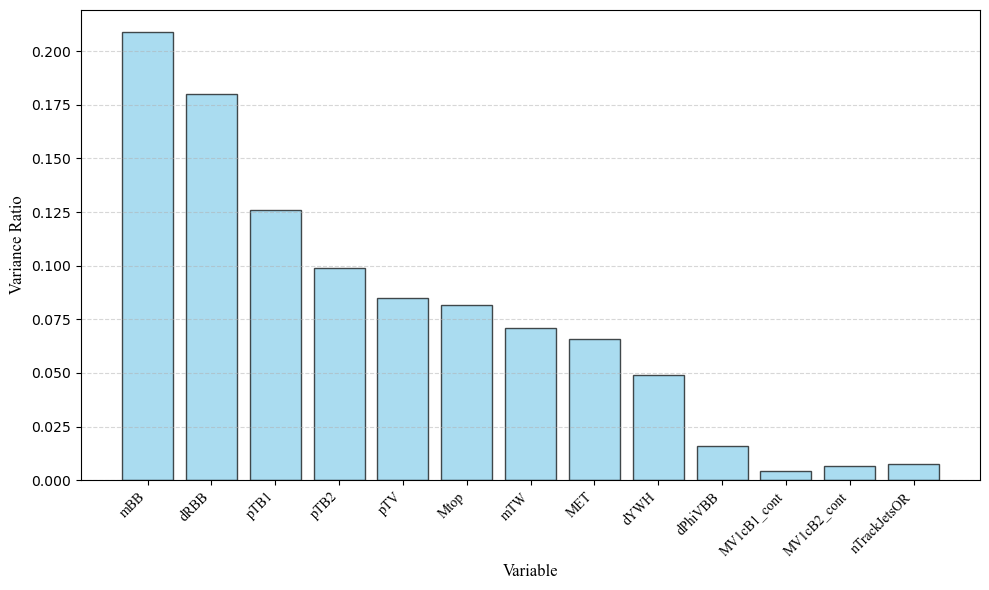

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# List of variables used in training
variables = [ 'mBB','dRBB', 'pTB1', 'pTB2', 'pTV', 'Mtop', 'mTW', 'MET', 'dYWH', 'dPhiVBB', 'MV1cB1_cont', 'MV1cB2_cont', 'nTrackJetsOR']


#load data for variable selection
(x_train, y_train, w_train, 
 dset_val, dset_test) = scale_prepare_data(df_train, df_val, df_test, variables, scaler='standard')



def compute_covariance_matrix(data):
    """
    Compute the covariance matrix of the data.

    Parameters:
    - data: Input data matrix (rows represent samples, columns represent features)

    Returns:
    - Covariance matrix
    """
    num_samples = data.shape[0]
    covariance_matrix = (1 / num_samples) * np.dot(data.T, data)
    return covariance_matrix

def perform_pca(data):
    """
    Perform Principal Component Analysis (PCA) on the given data.

    Parameters:
    - data: Input data matrix (rows represent samples, columns represent features)

    Returns:
    - variance_ratio: Explained variance ratio for each principal component
    - eigenvectors: Eigenvectors of the covariance matrix
    """
    covariance_matrix = compute_covariance_matrix(data)
    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)
    variance_ratio = eigenvalues / np.sum(eigenvalues)
    return variance_ratio, eigenvectors

def best_pca(data, variables, num):
    """
    Select the top 'num' variables based on Principal Component Analysis (PCA).

    Parameters:
    - data: Input data matrix (rows represent samples, columns represent features)
    - variables: List of variable names/features used in the model
    - num: Number of variables to select

    Returns:
    - List of selected variables
    """
    variance_ratio, eigenvectors = perform_pca(data)
    
    # Combine variance ratio and variables into a 2D array
    combined_array = np.array(list(zip(variance_ratio, variables)))
    
    # Sort the array based on variance ratio in descending order
    sorted_combined_array = combined_array[combined_array[:, 0].argsort()[::-1]]
    
    # Select the top 'num' variables
    selected_variables = sorted_combined_array[:num, 1]
    
    return selected_variables

# Assuming 'x_train', 'variables', and 'num' are defined

# Perform PCA and select top variables
selected_variables = best_pca(x_train, variables, 13)

# Plot the explained variance ratio for each component
variance_ratio, _ = perform_pca(x_train)
plt.figure(figsize=(10, 6))
plt.bar(variables, variance_ratio, alpha=0.7, color='skyblue', edgecolor='black')
plt.xlabel('Variable', fontname='Times New Roman', fontsize=12)
plt.ylabel('Variance Ratio', fontname='Times New Roman',  fontsize=12)
plt.xticks(rotation=45, ha='right', fontname='Times New Roman', fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Here is PCA performed on 13 dimension of data (corresponding to the 13 parameters). We can see that as the introductory notebook tells us, mBB is the most sensitive, in other words, contributes the most to the covariance matrix.

### Pre-Processing


In [7]:
#preprocessing of the data 
#remove the rows where data is missing from the input variables 

df_train = df_train.dropna(subset = variables)
df_val = df_val.dropna(subset = variables)
df_test = df_test.dropna(subset = variables)


This cell removes any rows with empty cells 

In [8]:
#data normalisation with standard (mean = 0 and standard deviation = 1)


(x_train, y_train, w_train, 
dset_val, dset_test) = scale_prepare_data(df_train, df_val, df_test, selected_variables, scaler='standard')

Here is normalisation performed, in this case, standardisation. Mean = 0 and standard deviation = 1. 

### number of nodes in layer 


#### Layer 1

In [9]:
variables = [ 'mBB','dRBB', 'pTB1', 'pTB2', 'pTV', 'Mtop', 'mTW', 'MET', 'dYWH', 'dPhiVBB', 'MV1cB1_cont', 'MV1cB2_cont', 'nTrackJetsOR']

def model_nodes_1(nodes, variables):
    """
    Create and compile a neural network model with a single hidden layer.

    Parameters:
    - nodes (int): Number of nodes/neurons in the hidden layer.
    - variables (list): List of input variables/features.

    Returns:
    - Compiled Keras model.
    """
    num_variables = len(variables)
    model = Sequential()
    # The input layer
    model.add(Dense(units=nodes, input_dim=num_variables, activation='relu'))

    # Output layer
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])

    return model

def train_model_nodes(nodes, variables, x_train, y_train, w_train):
    """
    Train a neural network model with a single hidden layer.

    Parameters:
    - nodes (int): Number of nodes/neurons in the hidden layer.
    - variables (list): List of input variables/features.
    - x_train (numpy.ndarray): Input training data.
    - y_train (numpy.ndarray): Target training data.
    - w_train (numpy.ndarray): Sample weights for training data.

    Returns:
    - Sensitivity of the trained model.
    """
    model = model_nodes_1(nodes, variables)
    history = model.fit(x_train, y_train, sample_weight=w_train, epochs=4, batch_size=64, verbose=1)
    df_test['decision_value'] = model.predict(dset_test[0])
    return round(sensitivity_NN(df_test)[0],2)


nodes_number_1 = np.linspace(1, 150, 150, dtype=int)
sensitivity_list_1 = []
for i in range(150):
    sensitivity_list_1.append(train_model_nodes(nodes_number_1[i], variables, x_train, y_train, w_train))

Epoch 1/4
1206/1206 [==============================] - 1s 414us/step - loss: 0.6208 - accuracy: 0.7139
Epoch 2/4
1206/1206 [==============================] - 1s 424us/step - loss: 0.5558 - accuracy: 0.7859
Epoch 3/4
1206/1206 [==============================] - 0s 346us/step - loss: 0.5333 - accuracy: 0.7940
Epoch 4/4
517/517 [==============================] - 0s 263us/step
Epoch 1/4
1206/1206 [==============================] - 1s 414us/step - loss: 0.5703 - accuracy: 0.7242
Epoch 2/4
1206/1206 [==============================] - 0s 331us/step - loss: 0.4954 - accuracy: 0.7706
Epoch 3/4
1206/1206 [==============================] - 0s 407us/step - loss: 0.4767 - accuracy: 0.7806
Epoch 4/4
517/517 [==============================] - 0s 260us/step
Epoch 1/4
1206/1206 [==============================] - 1s 336us/step - loss: 0.6387 - accuracy: 0.7069
Epoch 2/4
1206/1206 [==============================] - 1s 481us/step - loss: 0.4997 - accuracy: 0.7964
Epoch 3/4
1206/1206 [=====================

In [1]:
# Plot the data
plt.plot(nodes_number_1, sensitivity_list_1, marker='o', linestyle='-', color='b', label='Accuracy')

plt.xlabel('Number of nodes in the first layer', fontname='Times New Roman')
plt.ylabel('Final mBB sensitivity', fontname='Times New Roman')
plt.grid(True)
plt.show()

NameError: name 'plt' is not defined

Assessment for the first layer. Number of nodes chosen is 120.

#### Layer 2

In [10]:
variables = [ 'mBB','dRBB', 'pTB1', 'pTB2', 'pTV', 'Mtop', 'mTW', 'MET', 'dYWH', 'dPhiVBB', 'MV1cB1_cont', 'MV1cB2_cont', 'nTrackJetsOR']


def model_nodes2(nodes, variables):
    """
    Create and compile a neural network model with a second hidden layer.
    
    Parameters:
    - nodes (int): Number of nodes/neurons in the hidden layer.
    - variables (list): List of input variables/features.

    Returns:
    - Compiled Keras model.
    """
    num_variables = len(variables)
    model = Sequential()

    # The input layer
    model.add(Dense(units=120, input_dim=num_variables, activation='relu'))

    model.add(Dense(units=nodes, activation='relu'))

    # Output layer
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])

    return model

def train_model_nodes_2(nodes, variables, x_train, y_train, w_train):
    """
    Train a neural network model with two hidden layer.

    Parameters:
    - nodes (int): Number of nodes/neurons in the hidden layer.
    - variables (list): List of input variables/features.
    - x_train (numpy.ndarray): Input training data.
    - y_train (numpy.ndarray): Target training data.
    - w_train (numpy.ndarray): Sample weights for training data.

    Returns:
    - Sensitivity of the trained model.
    """
    model = model_nodes2(nodes, variables)
    history = model.fit(x_train, y_train, sample_weight=w_train, epochs=4, batch_size=64, verbose=0)
    df_test['decision_value'] = model.predict(dset_test[0])
    return round(sensitivity_NN(df_test)[0],2)


nodes_number_2 = np.arange(1, 101, dtype=int)
sensitivity_list_2 = []
for i in range(100):
    sensitivity_list_2.append(train_model_nodes_2(nodes_number_2[i], variables, x_train, y_train, w_train))


517/517 [==============================] - 0s 277us/step


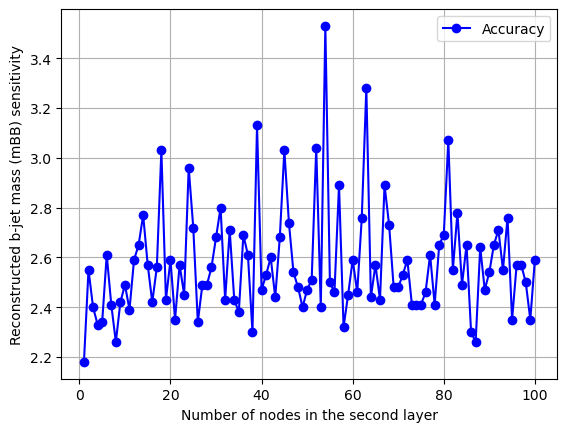

In [32]:
# Plot the data
plt.plot(nodes_number_2, sensitivity_list_2, marker='o', linestyle='-', color='b', label='Accuracy')
plt.xlabel('Number of nodes in the second layer', fontname='Times New Roman')
plt.ylabel('Reconstructed b-jet mass (mBB) sensitivity', fontname='Times New Roman')
plt.grid(True)
plt.legend()
plt.show()


Assessment of second layer, number of nodes chosen is 65.

#### Layer 3

In [11]:
variables = [ 'mBB','dRBB', 'pTB1', 'pTB2', 'pTV', 'Mtop', 'mTW', 'MET', 'dYWH', 'dPhiVBB', 'MV1cB1_cont', 'MV1cB2_cont', 'nTrackJetsOR']


def model_nodes3(nodes, variables):
    """
    Create and compile a neural network model with a third hidden layer.

    Parameters:
    - nodes (int): Number of nodes/neurons in the second hidden layer.
    - variables (list): List of input variables/features.

    Returns:
    - Compiled Keras model.
    """
    num_variables = len(variables)
    model = Sequential()

    # The input layer
    model.add(Dense(units=120, input_dim=num_variables, activation='relu'))

    model.add(Dense(units=65, activation='relu'))

    model.add(Dense(units=nodes, activation='relu'))

    # Output layer
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])

    return model

def train_model_nodes_3(nodes, variables, x_train, y_train, w_train):
    """
    Train a neural network model with a third hidden layer.

    Parameters:
    - nodes (int): Number of nodes/neurons in the second hidden layer.
    - variables (list): List of input variables/features.
    - x_train (numpy.ndarray): Input training data.
    - y_train (numpy.ndarray): Target training data.
    - w_train (numpy.ndarray): Sample weights for training data.

    Returns:
    - Sensitivity of the trained model.
    """
    model = model_nodes3(nodes, variables)
    history = model.fit(x_train, y_train, sample_weight=w_train, epochs=4, batch_size=64, verbose=1)
    df_test['decision_value'] = model.predict(dset_test[0])
    return round(sensitivity_NN(df_test)[0],2)

nodes_number_3 = np.arange(1, 81, dtype=int) 
sensitivity_list_3 = []

for i in range(80):
    sensitivity_list_3.append(train_model_nodes_3(nodes_number_3[i], variables, x_train, y_train, w_train))


Epoch 1/4
1206/1206 [==============================] - 1s 631us/step - loss: 0.5307 - accuracy: 0.8108
Epoch 2/4
1206/1206 [==============================] - 1s 868us/step - loss: 0.4076 - accuracy: 0.8804
Epoch 3/4
1206/1206 [==============================] - 1s 545us/step - loss: 0.3602 - accuracy: 0.8911
Epoch 4/4
517/517 [==============================] - 0s 325us/step
Epoch 1/4
1206/1206 [==============================] - 1s 744us/step - loss: 0.5434 - accuracy: 0.7849
Epoch 2/4
1206/1206 [==============================] - 1s 447us/step - loss: 0.3724 - accuracy: 0.8763
Epoch 3/4
1206/1206 [==============================] - 1s 452us/step - loss: 0.3335 - accuracy: 0.8921
Epoch 4/4
517/517 [==============================] - 0s 296us/step
Epoch 1/4
1206/1206 [==============================] - 1s 599us/step - loss: 0.5385 - accuracy: 0.8168
Epoch 2/4
1206/1206 [==============================] - 1s 650us/step - loss: 0.3958 - accuracy: 0.8774
Epoch 3/4
1206/1206 [=====================

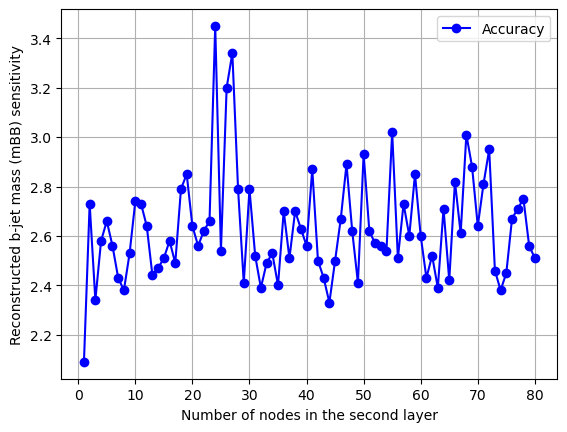

In [12]:
# Plot the data
plt.plot(nodes_number_3, sensitivity_list_3, marker='o', linestyle='-', color='b', label='Accuracy')
plt.xlabel('Number of nodes in the second layer', fontname='Times New Roman')
plt.ylabel('Reconstructed b-jet mass (mBB) sensitivity', fontname='Times New Roman')
plt.grid(True)
plt.legend()
plt.show()


Assessment of the third layer. Number of nodes chosen is 49.

#### Layer 4

In [13]:
variables = [ 'mBB','dRBB', 'pTB1', 'pTB2', 'pTV', 'Mtop', 'mTW', 'MET', 'dYWH', 'dPhiVBB', 'MV1cB1_cont', 'MV1cB2_cont', 'nTrackJetsOR']

def model_nodes4(nodes, variables):
    """
    Create and compile a neural network model with a fourth hidden layer.

    Parameters:
    - nodes (int): Number of nodes/neurons in the third hidden layer.
    - variables (list): List of input variables/features.

    Returns:
    - Compiled Keras model.
    """
    num_variables = len(variables)
    model = Sequential()

    # The input layer
    model.add(Dense(units=120, input_dim=num_variables, activation='relu'))

    model.add(Dense(units=65, activation='relu'))

    model.add(Dense(units=49, activation='relu'))

    model.add(Dense(units=nodes, activation='relu'))

    # Output layer
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])

    return model

def train_model_nodes_4(nodes, variables, x_train, y_train, w_train):
    """
    Train a neural network model with a fourth hidden layer.

    Parameters:
    - nodes (int): Number of nodes/neurons in the third hidden layer.
    - variables (list): List of input variables/features.
    - x_train (numpy.ndarray): Input training data.
    - y_train (numpy.ndarray): Target training data.
    - w_train (numpy.ndarray): Sample weights for training data.

    Returns:
    - Sensitivity of the trained model.
    """
    model = model_nodes4(nodes, variables)
    history = model.fit(x_train, y_train, sample_weight=w_train, epochs=4, batch_size=64, verbose=1)
    df_test['decision_value'] = model.predict(dset_test[0])
    return round(sensitivity_NN(df_test)[0], 2)


nodes_number_4 = np.arange(1, 31, dtype=int)
sensitivity_list_4 = []

for i in range(30):
    sensitivity_list_4.append(train_model_nodes_4(nodes_number_4[i], variables, x_train, y_train, w_train))


Epoch 1/4
1206/1206 [==============================] - 1s 611us/step - loss: 0.7161 - accuracy: 0.6518
Epoch 2/4
1206/1206 [==============================] - 1s 547us/step - loss: 0.7098 - accuracy: 0.6537
Epoch 3/4
1206/1206 [==============================] - 1s 527us/step - loss: 0.7098 - accuracy: 0.6537
Epoch 4/4
517/517 [==============================] - 0s 586us/step
Epoch 1/4
1206/1206 [==============================] - 2s 690us/step - loss: 0.6294 - accuracy: 0.6853
Epoch 2/4
1206/1206 [==============================] - 1s 503us/step - loss: 0.4482 - accuracy: 0.8658
Epoch 3/4
1206/1206 [==============================] - 1s 485us/step - loss: 0.3688 - accuracy: 0.8906
Epoch 4/4
517/517 [==============================] - 0s 299us/step
Epoch 1/4
1206/1206 [==============================] - 1s 574us/step - loss: 0.4956 - accuracy: 0.8054
Epoch 2/4
1206/1206 [==============================] - 1s 521us/step - loss: 0.3531 - accuracy: 0.8837
Epoch 3/4
1206/1206 [=====================

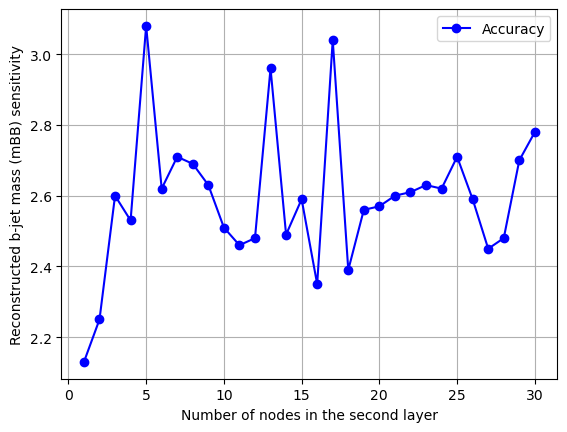

In [14]:
# Plot the data
plt.plot(nodes_number_4, sensitivity_list_4, marker='o', linestyle='-', color='b', label='Accuracy')
plt.xlabel('Number of nodes in the second layer', fontname='Times New Roman')
plt.ylabel('Reconstructed b-jet mass (mBB) sensitivity', fontname='Times New Roman')
plt.grid(True)
plt.legend()
plt.show()

Assessment of the fourth layer. Number of nodes chosen is 14. 

#### Combined

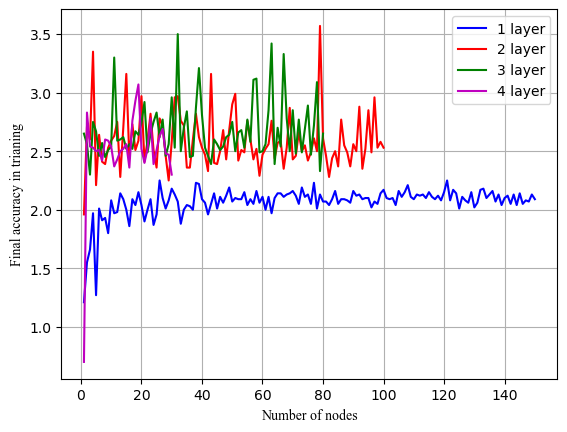

In [15]:
plt.subplot()

plt.plot(nodes_number_1, sensitivity_list_1, linestyle='-', color='b', label ='1 layer')
plt.plot(nodes_number_2, sensitivity_list_2, linestyle='-', color='r', label ='2 layer')
plt.plot(nodes_number_3, sensitivity_list_3, linestyle='-', color='g', label ='3 layer')
plt.plot(nodes_number_4, sensitivity_list_4, linestyle='-', color='m', label ='4 layer')


plt.xlabel('Number of nodes', fontname='Times New Roman')
plt.ylabel('Final accuracy in trianing', fontname='Times New Roman')
plt.grid(True)
plt.legend()
plt.show()

This plot shows us that adding up to 4 layers gives considerable imporvement to our network, however the number of layers do seem to asymptotically converge. Therefore adding a 5th layer is not necessary as it gives approximately the same results as having 5 layers. 
The summary of our final model is provided below. 

In [16]:
model_nodes4(14, variables).summary()

Model: "sequential_360"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_970 (Dense)           (None, 120)               1680      
                                                                 
 dense_971 (Dense)           (None, 65)                7865      
                                                                 
 dense_972 (Dense)           (None, 49)                3234      
                                                                 
 dense_973 (Dense)           (None, 14)                700       
                                                                 
 dense_974 (Dense)           (None, 1)                 15        
                                                                 
Total params: 13494 (52.71 KB)
Trainable params: 13494 (52.71 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Optimizer

In [16]:
list_loss = ('BinaryCrossentropy',
             'BinaryFocalCrossentropy',
             'CategoricalFocalCrossentropy',
             'Hinge',
             'CategoricalHinge',
             'SquaredHinge',
             'KLDivergence')

list_optimizer = ['SGD', 'RMSprop', 'Adam', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam', 'Ftrl']

def model_optimizer(variables, optimizer, loss):
    """
    Create and compile a neural network with trial optimizer and loss.

    Parameters:
    - variables: List of input variables/features used in the model
    - optimizer: Name of the optimizer to use 
    - loss: Name of the loss function to use 

    Returns:
    - Compiled model
    """
    num_variables = len(variables)

    model = Sequential()

    model.add(Dense(units=120, input_dim=num_variables, activation='relu'))
    model.add(Dense(units=65, activation='relu'))
    model.add(Dense(units=49, activation='relu'))
    model.add(Dense(units=14, activation='relu'))
    model.add(Dense(units=1, activation='sigmoid'))

    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

    return model

def train_model_optimizer(variables, optimizer, loss, x_train, y_train, w_train):
    """
    Train a neural network model with specified optimizer and loss function.

    Parameters:
    - variables: List of input variables/features used in the model
    - optimizer: Name of the optimizer to use 
    - loss: Name of the loss function to use 
    - x_train: Input features for training
    - y_train: Target labels for training
    - w_train: Sample weights for training

    Returns:
    - Sensitivity value
    """
    model = model_optimizer(variables, optimizer, loss)
    history = model.fit(x_train, y_train, sample_weight=w_train, epochs=3, batch_size=58, verbose=1)
    df_test['decision_value'] = model.predict(dset_test[0])
    return round(sensitivity_NN(df_test)[0], 2)

# Initialize the dictionary to store results
efficiencies_optimizer = {}

# Loop over each optimizer and loss function combination
for opt in list_optimizer:
    for loss_func in list_loss:
        key = (opt, loss_func)
        print(f"Training with optimizer: {opt}, loss function: {loss_func}")
        # Train the model and store the sensitivity
        efficiencies_optimizer[key] = train_model_optimizer(variables, opt, loss_func, x_train, y_train, w_train)


Training with optimizer: SGD, loss function: BinaryCrossentropy
Epoch 1/3
1331/1331 [==============================] - 2s 970us/step - loss: 0.4817 - accuracy: 0.8135
Epoch 2/3
1331/1331 [==============================] - 1s 470us/step - loss: 0.3419 - accuracy: 0.8876
Epoch 3/3
517/517 [==============================] - 0s 291us/step
Training with optimizer: SGD, loss function: BinaryFocalCrossentropy
Epoch 1/3
1331/1331 [==============================] - 1s 471us/step - loss: 0.1261 - accuracy: 0.8028
Epoch 2/3
1331/1331 [==============================] - 1s 459us/step - loss: 0.0979 - accuracy: 0.8747
Epoch 3/3
517/517 [==============================] - 0s 277us/step
Training with optimizer: SGD, loss function: CategoricalFocalCrossentropy
Epoch 1/3


/Users/yannzurstrassen/anaconda3/lib/python3.11/site-packages/tensorflow/python/util/dispatch.py:1260: SyntaxWarning: In loss categorical_focal_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


1331/1331 [==============================] - 1s 455us/step - loss: 2.8908e-22 - accuracy: 0.3828
Epoch 2/3
1331/1331 [==============================] - 1s 450us/step - loss: 2.8908e-22 - accuracy: 0.3828
Epoch 3/3
517/517 [==============================] - 0s 754us/step
Training with optimizer: SGD, loss function: Hinge
Epoch 1/3
1331/1331 [==============================] - 1s 451us/step - loss: 0.7829 - accuracy: 0.6923
Epoch 2/3
1331/1331 [==============================] - 1s 458us/step - loss: 0.6265 - accuracy: 0.8108
Epoch 3/3
517/517 [==============================] - 0s 287us/step
Training with optimizer: SGD, loss function: CategoricalHinge
Epoch 1/3
1331/1331 [==============================] - 1s 465us/step - loss: 0.7198 - accuracy: 0.7562
Epoch 2/3
1331/1331 [==============================] - 1s 448us/step - loss: 0.6115 - accuracy: 0.8147
Epoch 3/3
517/517 [==============================] - 0s 295us/step
Training with optimizer: SGD, loss function: SquaredHinge
Epoch 1/3
13

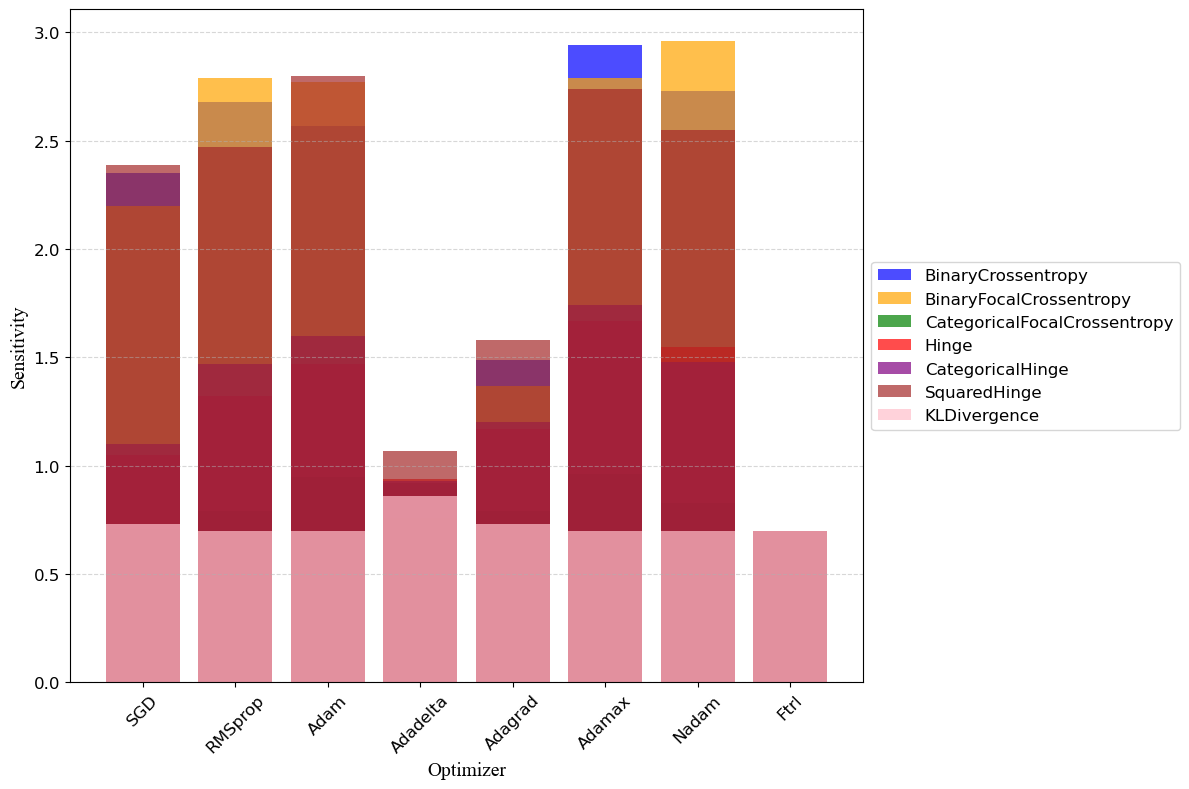

In [21]:
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'cyan', 'magenta']


def plot_sensitivity_vs_optimizer(efficiencies_optimizer, list_optimizer, list_loss, colors):
    """
    Plot sensitivities achieved by different optimizers for each loss function.

    Parameters:
    - efficiencies_optimizer (dict): Dictionary containing sensitivities for different optimizer-loss function combinations.
    - list_optimizer (list): List of optimizer names.
    - list_loss (list): List of loss function names.
    - colors (list): List of colors for the bars in the plot.

    Returns:
    None
    """
    plt.figure(figsize=(12, 8))

    # Find the combination with the highest sensitivity
    max_combination = max(efficiencies_optimizer, key=efficiencies_optimizer.get)

    legend_handles = []  

    for i, loss_func in enumerate(list_loss):
        sensitivity_values = [efficiencies_optimizer.get((opt, loss_func), 0) for opt in list_optimizer]
        label = f'{loss_func} (Max)' if loss_func == max_combination[1] and max_combination[0] in list_optimizer else loss_func
        bar = plt.bar(list_optimizer, sensitivity_values, color=colors[i], alpha=0.7, label=label)
        legend_handles.append(bar[0])  

    plt.xlabel('Optimizer', fontname='Times New Roman', fontsize=14)
    plt.ylabel('Sensitivity', fontname='Times New Roman', fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(handles=legend_handles, labels=list_loss, fontsize=12, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


# Usage example:
plot_sensitivity_vs_optimizer(efficiencies_optimizer, list_optimizer, list_loss, colors)


Assement of optimser and loss function together. If the code is run multiple times, some other combination might perform better (probably will) due to the random nature of the initialisaiton of the model. The combination chosen is part of the most recurring top contenders.

### Activation Function

Epoch 1/3
1331/1331 [==============================] - 2s 684us/step - loss: 0.0915 - accuracy: 0.8866
Epoch 2/3
1331/1331 [==============================] - 1s 602us/step - loss: 0.0860 - accuracy: 0.8945
Epoch 3/3
517/517 [==============================] - 0s 288us/step


Epoch 1/3
1331/1331 [==============================] - 2s 609us/step - loss: 0.0918 - accuracy: 0.8863
Epoch 2/3
1331/1331 [==============================] - 1s 600us/step - loss: 0.0855 - accuracy: 0.8953
Epoch 3/3
517/517 [==============================] - 0s 292us/step


Epoch 1/3
1331/1331 [==============================] - 1s 619us/step - loss: 0.0916 - accuracy: 0.8860
Epoch 2/3
1331/1331 [==============================] - 1s 613us/step - loss: 0.0853 - accuracy: 0.8950
Epoch 3/3
517/517 [==============================] - 0s 283us/step


Epoch 1/3
1331/1331 [==============================] - 1s 611us/step - loss: 0.0916 - accuracy: 0.8861
Epoch 2/3
1331/1331 [==============================] - 1s 619us/step - loss: 0.0852 - accuracy: 0.8953
Epoch 3/3
517/517 [==============================] - 0s 292us/step


Epoch 1/3
1331/1331 [==============================] - 2s 618us/step - loss: 0.0922 - accuracy: 0.8862
Epoch 2/3
1331/1331 [==============================] - 1s 604us/step - loss: 0.0854 - accuracy: 0.8958
Epoch 3/3
517/517 [==============================] - 0s 339us/step


Epoch 1/3
1331/1331 [==============================] - 2s 620us/step - loss: 0.0917 - accuracy: 0.8860
Epoch 2/3
1331/1331 [==============================] - 1s 606us/step - loss: 0.0855 - accuracy: 0.8940
Epoch 3/3
517/517 [==============================] - 0s 293us/step


Epoch 1/3
1331/1331 [==============================] - 2s 639us/step - loss: 0.0919 - accuracy: 0.8866
Epoch 2/3
1331/1331 [==============================] - 1s 630us/step - loss: 0.0853 - accuracy: 0.8964
Epoch 3/3
517/517 [==============================] - 0s 324us/step


Epoch 1/3
1331/1331 [==============================] - 2s 629us/step - loss: 0.0922 - accuracy: 0.8860
Epoch 2/3
1331/1331 [==============================] - 1s 762us/step - loss: 0.0856 - accuracy: 0.8948
Epoch 3/3
517/517 [==============================] - 0s 702us/step


Epoch 1/3
1331/1331 [==============================] - 2s 641us/step - loss: 0.0918 - accuracy: 0.8864
Epoch 2/3
1331/1331 [==============================] - 1s 652us/step - loss: 0.0852 - accuracy: 0.8958
Epoch 3/3
517/517 [==============================] - 0s 294us/step


Epoch 1/3
1331/1331 [==============================] - 2s 627us/step - loss: 0.0913 - accuracy: 0.8867
Epoch 2/3
1331/1331 [==============================] - 1s 638us/step - loss: 0.0857 - accuracy: 0.8953
Epoch 3/3
517/517 [==============================] - 0s 302us/step


Epoch 1/3
1331/1331 [==============================] - 2s 718us/step - loss: 0.1012 - accuracy: 0.8635
Epoch 2/3
1331/1331 [==============================] - 1s 626us/step - loss: 0.0864 - accuracy: 0.8938
Epoch 3/3
517/517 [==============================] - 0s 312us/step


Epoch 1/3
1331/1331 [==============================] - 2s 631us/step - loss: 0.1024 - accuracy: 0.8632
Epoch 2/3
1331/1331 [==============================] - 1s 672us/step - loss: 0.0873 - accuracy: 0.8936
Epoch 3/3
517/517 [==============================] - 0s 315us/step


Epoch 1/3
1331/1331 [==============================] - 2s 640us/step - loss: 0.1101 - accuracy: 0.8473
Epoch 2/3
1331/1331 [==============================] - 1s 628us/step - loss: 0.0869 - accuracy: 0.8932
Epoch 3/3
517/517 [==============================] - 0s 305us/step


Epoch 1/3
1331/1331 [==============================] - 2s 636us/step - loss: 0.1096 - accuracy: 0.8507
Epoch 2/3
1331/1331 [==============================] - 1s 626us/step - loss: 0.0874 - accuracy: 0.8931
Epoch 3/3
517/517 [==============================] - 0s 304us/step


Epoch 1/3
1331/1331 [==============================] - 2s 633us/step - loss: 0.1022 - accuracy: 0.8640
Epoch 2/3
1331/1331 [==============================] - 1s 686us/step - loss: 0.0867 - accuracy: 0.8942
Epoch 3/3
517/517 [==============================] - 0s 305us/step


Epoch 1/3
1331/1331 [==============================] - 2s 632us/step - loss: 0.1030 - accuracy: 0.8620
Epoch 2/3
1331/1331 [==============================] - 1s 620us/step - loss: 0.0871 - accuracy: 0.8940
Epoch 3/3
517/517 [==============================] - 0s 305us/step


Epoch 1/3
1331/1331 [==============================] - 2s 627us/step - loss: 0.1006 - accuracy: 0.8674
Epoch 2/3
1331/1331 [==============================] - 1s 615us/step - loss: 0.0873 - accuracy: 0.8924
Epoch 3/3
517/517 [==============================] - 0s 296us/step


Epoch 1/3
1331/1331 [==============================] - 2s 628us/step - loss: 0.1011 - accuracy: 0.8631
Epoch 2/3
1331/1331 [==============================] - 1s 617us/step - loss: 0.0868 - accuracy: 0.8943
Epoch 3/3
517/517 [==============================] - 0s 306us/step


Epoch 1/3
1331/1331 [==============================] - 2s 638us/step - loss: 0.1034 - accuracy: 0.8609
Epoch 2/3
1331/1331 [==============================] - 1s 625us/step - loss: 0.0869 - accuracy: 0.8937
Epoch 3/3
517/517 [==============================] - 0s 305us/step


Epoch 1/3
1331/1331 [==============================] - 2s 631us/step - loss: 0.1011 - accuracy: 0.8647
Epoch 2/3
1331/1331 [==============================] - 1s 618us/step - loss: 0.0869 - accuracy: 0.8934
Epoch 3/3
517/517 [==============================] - 0s 377us/step


Epoch 1/3
1331/1331 [==============================] - 2s 663us/step - loss: 0.1232 - accuracy: 0.8101
Epoch 2/3
1331/1331 [==============================] - 1s 641us/step - loss: 0.0867 - accuracy: 0.8966
Epoch 3/3
517/517 [==============================] - 0s 311us/step


Epoch 1/3
1331/1331 [==============================] - 2s 660us/step - loss: 0.1223 - accuracy: 0.8130
Epoch 2/3
1331/1331 [==============================] - 1s 639us/step - loss: 0.0861 - accuracy: 0.8970
Epoch 3/3
517/517 [==============================] - 0s 313us/step


Epoch 1/3
1331/1331 [==============================] - 2s 652us/step - loss: 0.1212 - accuracy: 0.8197
Epoch 2/3
1331/1331 [==============================] - 1s 687us/step - loss: 0.0872 - accuracy: 0.8964
Epoch 3/3
517/517 [==============================] - 0s 310us/step


Epoch 1/3
1331/1331 [==============================] - 2s 664us/step - loss: 0.1181 - accuracy: 0.8232
Epoch 2/3
1331/1331 [==============================] - 1s 893us/step - loss: 0.0860 - accuracy: 0.8977
Epoch 3/3
517/517 [==============================] - 0s 315us/step


Epoch 1/3
1331/1331 [==============================] - 2s 647us/step - loss: 0.1284 - accuracy: 0.7998
Epoch 2/3
1331/1331 [==============================] - 1s 631us/step - loss: 0.0867 - accuracy: 0.8978
Epoch 3/3
517/517 [==============================] - 0s 311us/step


Epoch 1/3
1331/1331 [==============================] - 2s 651us/step - loss: 0.1197 - accuracy: 0.8195
Epoch 2/3
1331/1331 [==============================] - 1s 877us/step - loss: 0.0864 - accuracy: 0.8965
Epoch 3/3
517/517 [==============================] - 0s 314us/step


Epoch 1/3
1331/1331 [==============================] - 2s 653us/step - loss: 0.1201 - accuracy: 0.8198
Epoch 2/3
1331/1331 [==============================] - 1s 659us/step - loss: 0.0862 - accuracy: 0.8975
Epoch 3/3
517/517 [==============================] - 0s 313us/step


Epoch 1/3
1331/1331 [==============================] - 2s 659us/step - loss: 0.1189 - accuracy: 0.8196
Epoch 2/3
1331/1331 [==============================] - 1s 973us/step - loss: 0.0864 - accuracy: 0.8974
Epoch 3/3
517/517 [==============================] - 0s 310us/step


Epoch 1/3
1331/1331 [==============================] - 2s 726us/step - loss: 0.1201 - accuracy: 0.8178
Epoch 2/3
1331/1331 [==============================] - 1s 673us/step - loss: 0.0873 - accuracy: 0.8961
Epoch 3/3
517/517 [==============================] - 0s 315us/step


Epoch 1/3
1331/1331 [==============================] - 4s 748us/step - loss: 0.1188 - accuracy: 0.8244
Epoch 2/3
1331/1331 [==============================] - 1s 788us/step - loss: 0.0863 - accuracy: 0.8973
Epoch 3/3
517/517 [==============================] - 0s 324us/step


Epoch 1/3
1331/1331 [==============================] - 2s 934us/step - loss: 0.0967 - accuracy: 0.8775
Epoch 2/3
1331/1331 [==============================] - 1s 1ms/step - loss: 0.0867 - accuracy: 0.8939
Epoch 3/3
517/517 [==============================] - 0s 576us/step


Epoch 1/3
1331/1331 [==============================] - 3s 1ms/step - loss: 0.0969 - accuracy: 0.8763
Epoch 2/3
1331/1331 [==============================] - 1s 861us/step - loss: 0.0872 - accuracy: 0.8933
Epoch 3/3
517/517 [==============================] - 0s 382us/step


Epoch 1/3
1331/1331 [==============================] - 2s 843us/step - loss: 0.0991 - accuracy: 0.8729
Epoch 2/3
1331/1331 [==============================] - 1s 829us/step - loss: 0.0864 - accuracy: 0.8946
Epoch 3/3
517/517 [==============================] - 0s 384us/step


Epoch 1/3
1331/1331 [==============================] - 2s 838us/step - loss: 0.0972 - accuracy: 0.8741
Epoch 2/3
1331/1331 [==============================] - 1s 846us/step - loss: 0.0863 - accuracy: 0.8956
Epoch 3/3
517/517 [==============================] - 0s 432us/step


Epoch 1/3
1331/1331 [==============================] - 2s 854us/step - loss: 0.1002 - accuracy: 0.8733
Epoch 2/3
1331/1331 [==============================] - 1s 1ms/step - loss: 0.0868 - accuracy: 0.8938
Epoch 3/3
517/517 [==============================] - 0s 379us/step


Epoch 1/3
1331/1331 [==============================] - 2s 845us/step - loss: 0.0957 - accuracy: 0.8787
Epoch 2/3
1331/1331 [==============================] - 1s 834us/step - loss: 0.0867 - accuracy: 0.8947
Epoch 3/3
517/517 [==============================] - 1s 958us/step


Epoch 1/3
1331/1331 [==============================] - 2s 849us/step - loss: 0.0986 - accuracy: 0.8726
Epoch 2/3
1331/1331 [==============================] - 1s 836us/step - loss: 0.0870 - accuracy: 0.8948
Epoch 3/3
517/517 [==============================] - 0s 383us/step


Epoch 1/3
1331/1331 [==============================] - 2s 844us/step - loss: 0.0981 - accuracy: 0.8762
Epoch 2/3
1331/1331 [==============================] - 1s 1ms/step - loss: 0.0878 - accuracy: 0.8931
Epoch 3/3
517/517 [==============================] - 0s 377us/step


Epoch 1/3
1331/1331 [==============================] - 2s 842us/step - loss: 0.0964 - accuracy: 0.8760
Epoch 2/3
1331/1331 [==============================] - 1s 826us/step - loss: 0.0863 - accuracy: 0.8948
Epoch 3/3
517/517 [==============================] - 0s 378us/step


Epoch 1/3
1331/1331 [==============================] - 2s 1ms/step - loss: 0.0980 - accuracy: 0.8768
Epoch 2/3
1331/1331 [==============================] - 1s 821us/step - loss: 0.0867 - accuracy: 0.8949
Epoch 3/3
517/517 [==============================] - 0s 378us/step


Epoch 1/3
1331/1331 [==============================] - 2s 624us/step - loss: 0.0931 - accuracy: 0.8823
Epoch 2/3
1331/1331 [==============================] - 1s 612us/step - loss: 0.0876 - accuracy: 0.8921
Epoch 3/3
517/517 [==============================] - 0s 302us/step


Epoch 1/3
1331/1331 [==============================] - 2s 627us/step - loss: 0.0936 - accuracy: 0.8825
Epoch 2/3
1331/1331 [==============================] - 1s 611us/step - loss: 0.0879 - accuracy: 0.8934
Epoch 3/3
517/517 [==============================] - 0s 302us/step


Epoch 1/3
1331/1331 [==============================] - 2s 629us/step - loss: 0.0952 - accuracy: 0.8790
Epoch 2/3
1331/1331 [==============================] - 1s 614us/step - loss: 0.0875 - accuracy: 0.8923
Epoch 3/3
517/517 [==============================] - 0s 297us/step


Epoch 1/3
1331/1331 [==============================] - 2s 647us/step - loss: 0.0936 - accuracy: 0.8812
Epoch 2/3
1331/1331 [==============================] - 1s 612us/step - loss: 0.0875 - accuracy: 0.8928
Epoch 3/3
517/517 [==============================] - 0s 295us/step


Epoch 1/3
1331/1331 [==============================] - 2s 641us/step - loss: 0.0934 - accuracy: 0.8815
Epoch 2/3
1331/1331 [==============================] - 1s 609us/step - loss: 0.0882 - accuracy: 0.8921
Epoch 3/3
517/517 [==============================] - 0s 293us/step


Epoch 1/3
1331/1331 [==============================] - 2s 644us/step - loss: 0.0938 - accuracy: 0.8820
Epoch 2/3
1331/1331 [==============================] - 1s 618us/step - loss: 0.0879 - accuracy: 0.8900
Epoch 3/3
517/517 [==============================] - 0s 299us/step


Epoch 1/3
1331/1331 [==============================] - 2s 624us/step - loss: 0.0927 - accuracy: 0.8819
Epoch 2/3
1331/1331 [==============================] - 1s 614us/step - loss: 0.0877 - accuracy: 0.8928
Epoch 3/3
517/517 [==============================] - 0s 299us/step


Epoch 1/3
1331/1331 [==============================] - 2s 624us/step - loss: 0.0932 - accuracy: 0.8814
Epoch 2/3
1331/1331 [==============================] - 1s 614us/step - loss: 0.0879 - accuracy: 0.8930
Epoch 3/3
517/517 [==============================] - 0s 329us/step


Epoch 1/3
1331/1331 [==============================] - 2s 625us/step - loss: 0.0939 - accuracy: 0.8812
Epoch 2/3
1331/1331 [==============================] - 1s 611us/step - loss: 0.0872 - accuracy: 0.8933
Epoch 3/3
517/517 [==============================] - 0s 299us/step


Epoch 1/3
1331/1331 [==============================] - 2s 629us/step - loss: 0.0948 - accuracy: 0.8798
Epoch 2/3
1331/1331 [==============================] - 1s 622us/step - loss: 0.0877 - accuracy: 0.8927
Epoch 3/3
517/517 [==============================] - 0s 302us/step


Epoch 1/3
1331/1331 [==============================] - 2s 624us/step - loss: 0.0942 - accuracy: 0.8814
Epoch 2/3
1331/1331 [==============================] - 1s 612us/step - loss: 0.0878 - accuracy: 0.8900
Epoch 3/3
517/517 [==============================] - 0s 429us/step


Epoch 1/3
1331/1331 [==============================] - 2s 630us/step - loss: 0.0940 - accuracy: 0.8822
Epoch 2/3
1331/1331 [==============================] - 1s 615us/step - loss: 0.0895 - accuracy: 0.8909
Epoch 3/3
517/517 [==============================] - 0s 308us/step


Epoch 1/3
1331/1331 [==============================] - 2s 629us/step - loss: 0.0949 - accuracy: 0.8792
Epoch 2/3
1331/1331 [==============================] - 1s 615us/step - loss: 0.0895 - accuracy: 0.8909
Epoch 3/3
517/517 [==============================] - 0s 571us/step


Epoch 1/3
1331/1331 [==============================] - 2s 634us/step - loss: 0.0942 - accuracy: 0.8816
Epoch 2/3
1331/1331 [==============================] - 1s 616us/step - loss: 0.0892 - accuracy: 0.8905
Epoch 3/3
517/517 [==============================] - 0s 309us/step


Epoch 1/3
1331/1331 [==============================] - 2s 632us/step - loss: 0.0944 - accuracy: 0.8815
Epoch 2/3
1331/1331 [==============================] - 1s 624us/step - loss: 0.0895 - accuracy: 0.8907
Epoch 3/3
517/517 [==============================] - 0s 307us/step


Epoch 1/3
1331/1331 [==============================] - 2s 625us/step - loss: 0.0948 - accuracy: 0.8817
Epoch 2/3
1331/1331 [==============================] - 1s 614us/step - loss: 0.0893 - accuracy: 0.8908
Epoch 3/3
517/517 [==============================] - 0s 306us/step


Epoch 1/3
1331/1331 [==============================] - 2s 657us/step - loss: 0.0948 - accuracy: 0.8797
Epoch 2/3
1331/1331 [==============================] - 1s 614us/step - loss: 0.0895 - accuracy: 0.8886
Epoch 3/3
517/517 [==============================] - 0s 308us/step


Epoch 1/3
1331/1331 [==============================] - 2s 659us/step - loss: 0.0949 - accuracy: 0.8828
Epoch 2/3
1331/1331 [==============================] - 1s 889us/step - loss: 0.0896 - accuracy: 0.8907
Epoch 3/3
517/517 [==============================] - 0s 308us/step


Epoch 1/3
1331/1331 [==============================] - 4s 654us/step - loss: 0.0950 - accuracy: 0.8808
Epoch 2/3
1331/1331 [==============================] - 1s 648us/step - loss: 0.0896 - accuracy: 0.8909
Epoch 3/3
517/517 [==============================] - 0s 318us/step


Epoch 1/3
1331/1331 [==============================] - 2s 637us/step - loss: 0.0952 - accuracy: 0.8784
Epoch 2/3
1331/1331 [==============================] - 1s 627us/step - loss: 0.0896 - accuracy: 0.8908
Epoch 3/3
517/517 [==============================] - 0s 316us/step


Epoch 1/3
1331/1331 [==============================] - 2s 816us/step - loss: 0.0956 - accuracy: 0.8798
Epoch 2/3
1331/1331 [==============================] - 1s 787us/step - loss: 0.0879 - accuracy: 0.8916
Epoch 3/3
517/517 [==============================] - 0s 352us/step


Epoch 1/3
1331/1331 [==============================] - 2s 796us/step - loss: 0.0954 - accuracy: 0.8818
Epoch 2/3
1331/1331 [==============================] - 1s 1ms/step - loss: 0.0894 - accuracy: 0.8900
Epoch 3/3
517/517 [==============================] - 0s 348us/step


Epoch 1/3
1331/1331 [==============================] - 2s 797us/step - loss: 0.0969 - accuracy: 0.8810
Epoch 2/3
1331/1331 [==============================] - 1s 787us/step - loss: 0.0884 - accuracy: 0.8915
Epoch 3/3
517/517 [==============================] - 0s 350us/step


Epoch 1/3
1331/1331 [==============================] - 2s 1ms/step - loss: 0.0965 - accuracy: 0.8817
Epoch 2/3
1331/1331 [==============================] - 1s 784us/step - loss: 0.0885 - accuracy: 0.8910
Epoch 3/3
517/517 [==============================] - 0s 350us/step


Epoch 1/3
1331/1331 [==============================] - 2s 807us/step - loss: 0.0983 - accuracy: 0.8774
Epoch 2/3
1331/1331 [==============================] - 1s 779us/step - loss: 0.0884 - accuracy: 0.8910
Epoch 3/3
517/517 [==============================] - 1s 967us/step


Epoch 1/3
1331/1331 [==============================] - 2s 801us/step - loss: 0.0954 - accuracy: 0.8813
Epoch 2/3
1331/1331 [==============================] - 1s 782us/step - loss: 0.0878 - accuracy: 0.8913
Epoch 3/3
517/517 [==============================] - 0s 359us/step


Epoch 1/3
1331/1331 [==============================] - 2s 797us/step - loss: 0.0961 - accuracy: 0.8803
Epoch 2/3
1331/1331 [==============================] - 1s 778us/step - loss: 0.0876 - accuracy: 0.8912
Epoch 3/3
517/517 [==============================] - 0s 351us/step


Epoch 1/3
1331/1331 [==============================] - 2s 799us/step - loss: 0.0946 - accuracy: 0.8821
Epoch 2/3
1331/1331 [==============================] - 1s 783us/step - loss: 0.0884 - accuracy: 0.8913
Epoch 3/3
517/517 [==============================] - 0s 354us/step


Epoch 1/3
1331/1331 [==============================] - 2s 793us/step - loss: 0.0976 - accuracy: 0.8778
Epoch 2/3
1331/1331 [==============================] - 1s 1ms/step - loss: 0.0888 - accuracy: 0.8905
Epoch 3/3
517/517 [==============================] - 0s 357us/step


Epoch 1/3
1331/1331 [==============================] - 2s 797us/step - loss: 0.0975 - accuracy: 0.8766
Epoch 2/3
1331/1331 [==============================] - 1s 775us/step - loss: 0.0887 - accuracy: 0.8914
Epoch 3/3
517/517 [==============================] - 0s 344us/step


Epoch 1/3
1331/1331 [==============================] - 2s 1ms/step - loss: 0.0933 - accuracy: 0.8833
Epoch 2/3
1331/1331 [==============================] - 1s 750us/step - loss: 0.0880 - accuracy: 0.8921
Epoch 3/3
517/517 [==============================] - 0s 449us/step


Epoch 1/3
1331/1331 [==============================] - 2s 773us/step - loss: 0.0926 - accuracy: 0.8837
Epoch 2/3
1331/1331 [==============================] - 1s 757us/step - loss: 0.0866 - accuracy: 0.8931
Epoch 3/3
517/517 [==============================] - 1s 759us/step


Epoch 1/3
1331/1331 [==============================] - 2s 773us/step - loss: 0.0931 - accuracy: 0.8840
Epoch 2/3
1331/1331 [==============================] - 1s 746us/step - loss: 0.0873 - accuracy: 0.8924
Epoch 3/3
517/517 [==============================] - 0s 350us/step


Epoch 1/3
1331/1331 [==============================] - 2s 765us/step - loss: 0.0927 - accuracy: 0.8832
Epoch 2/3
1331/1331 [==============================] - 1s 745us/step - loss: 0.0870 - accuracy: 0.8923
Epoch 3/3
517/517 [==============================] - 0s 379us/step


Epoch 1/3
1331/1331 [==============================] - 2s 762us/step - loss: 0.0929 - accuracy: 0.8840
Epoch 2/3
1331/1331 [==============================] - 1s 743us/step - loss: 0.0875 - accuracy: 0.8926
Epoch 3/3
517/517 [==============================] - 0s 335us/step


Epoch 1/3
1331/1331 [==============================] - 2s 783us/step - loss: 0.0925 - accuracy: 0.8854
Epoch 2/3
1331/1331 [==============================] - 1s 1ms/step - loss: 0.0874 - accuracy: 0.8928
Epoch 3/3
517/517 [==============================] - 0s 347us/step


Epoch 1/3
1331/1331 [==============================] - 2s 756us/step - loss: 0.0930 - accuracy: 0.8837
Epoch 2/3
1331/1331 [==============================] - 1s 747us/step - loss: 0.0868 - accuracy: 0.8933
Epoch 3/3
517/517 [==============================] - 0s 346us/step


Epoch 1/3
1331/1331 [==============================] - 2s 975us/step - loss: 0.0925 - accuracy: 0.8839
Epoch 2/3
1331/1331 [==============================] - 1s 753us/step - loss: 0.0882 - accuracy: 0.8918
Epoch 3/3
517/517 [==============================] - 0s 345us/step


Epoch 1/3
1331/1331 [==============================] - 2s 770us/step - loss: 0.0935 - accuracy: 0.8857
Epoch 2/3
1331/1331 [==============================] - 1s 738us/step - loss: 0.0874 - accuracy: 0.8918
Epoch 3/3
517/517 [==============================] - 0s 340us/step


Epoch 1/3
1331/1331 [==============================] - 2s 775us/step - loss: 0.0936 - accuracy: 0.8816
Epoch 2/3
1331/1331 [==============================] - 1s 744us/step - loss: 0.0873 - accuracy: 0.8936
Epoch 3/3
517/517 [==============================] - 0s 347us/step


Epoch 1/3
1331/1331 [==============================] - 2s 664us/step - loss: 0.0926 - accuracy: 0.8854
Epoch 2/3
1331/1331 [==============================] - 1s 903us/step - loss: 0.0870 - accuracy: 0.8932
Epoch 3/3
517/517 [==============================] - 0s 297us/step


Epoch 1/3
1331/1331 [==============================] - 2s 670us/step - loss: 0.0933 - accuracy: 0.8836
Epoch 2/3
1331/1331 [==============================] - 1s 660us/step - loss: 0.0865 - accuracy: 0.8935
Epoch 3/3
517/517 [==============================] - 0s 294us/step


Epoch 1/3
1331/1331 [==============================] - 2s 668us/step - loss: 0.0923 - accuracy: 0.8867
Epoch 2/3
1331/1331 [==============================] - 1s 898us/step - loss: 0.0862 - accuracy: 0.8938
Epoch 3/3
517/517 [==============================] - 0s 300us/step


Epoch 1/3
1331/1331 [==============================] - 3s 712us/step - loss: 0.0926 - accuracy: 0.8856
Epoch 2/3
1331/1331 [==============================] - 1s 645us/step - loss: 0.0860 - accuracy: 0.8942
Epoch 3/3
517/517 [==============================] - 0s 297us/step


Epoch 1/3
1331/1331 [==============================] - 2s 674us/step - loss: 0.0922 - accuracy: 0.8864
Epoch 2/3
1331/1331 [==============================] - 1s 657us/step - loss: 0.0862 - accuracy: 0.8937
Epoch 3/3
517/517 [==============================] - 1s 1ms/step


Epoch 1/3
1331/1331 [==============================] - 2s 831us/step - loss: 0.0925 - accuracy: 0.8874
Epoch 2/3
1331/1331 [==============================] - 1s 659us/step - loss: 0.0867 - accuracy: 0.8926
Epoch 3/3
517/517 [==============================] - 0s 294us/step


Epoch 1/3
1331/1331 [==============================] - 2s 671us/step - loss: 0.0927 - accuracy: 0.8863
Epoch 2/3
1331/1331 [==============================] - 1s 642us/step - loss: 0.0865 - accuracy: 0.8947
Epoch 3/3
517/517 [==============================] - 0s 297us/step


Epoch 1/3
1331/1331 [==============================] - 2s 674us/step - loss: 0.0924 - accuracy: 0.8862
Epoch 2/3
1331/1331 [==============================] - 1s 651us/step - loss: 0.0860 - accuracy: 0.8937
Epoch 3/3
517/517 [==============================] - 0s 330us/step


Epoch 1/3
1331/1331 [==============================] - 2s 721us/step - loss: 0.0922 - accuracy: 0.8848
Epoch 2/3
1331/1331 [==============================] - 1s 923us/step - loss: 0.0862 - accuracy: 0.8943
Epoch 3/3
517/517 [==============================] - 0s 342us/step


Epoch 1/3
1331/1331 [==============================] - 2s 815us/step - loss: 0.0928 - accuracy: 0.8864
Epoch 2/3
1331/1331 [==============================] - 2s 1ms/step - loss: 0.0866 - accuracy: 0.8932
Epoch 3/3
517/517 [==============================] - 0s 382us/step


Epoch 1/3


Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x16458f380>
Traceback (most recent call last):
  File "/Users/yannzurstrassen/anaconda3/lib/python3.11/weakref.py", line 369, in remove
    def remove(k, selfref=ref(self)):

KeyboardInterrupt: 


1331/1331 [==============================] - 9s 850us/step - loss: 0.0908 - accuracy: 0.8869
Epoch 2/3
1331/1331 [==============================] - 1s 760us/step - loss: 0.0845 - accuracy: 0.8960
Epoch 3/3
517/517 [==============================] - 0s 316us/step


Epoch 1/3
1331/1331 [==============================] - 2s 798us/step - loss: 0.0913 - accuracy: 0.8873
Epoch 2/3
1331/1331 [==============================] - 1s 679us/step - loss: 0.0853 - accuracy: 0.8953
Epoch 3/3
517/517 [==============================] - 0s 330us/step


Epoch 1/3
1331/1331 [==============================] - 2s 661us/step - loss: 0.0911 - accuracy: 0.8864
Epoch 2/3
1331/1331 [==============================] - 1s 706us/step - loss: 0.0854 - accuracy: 0.8960
Epoch 3/3
517/517 [==============================] - 0s 317us/step


Epoch 1/3
1331/1331 [==============================] - 2s 641us/step - loss: 0.0909 - accuracy: 0.8876
Epoch 2/3
1331/1331 [==============================] - 1s 1ms/step - loss: 0.0847 - accuracy: 0.8962
Epoch 3/3
517/517 [==============================] - 0s 315us/step


Epoch 1/3
1331/1331 [==============================] - 2s 679us/step - loss: 0.0912 - accuracy: 0.8882
Epoch 2/3
1331/1331 [==============================] - 1s 641us/step - loss: 0.0852 - accuracy: 0.8953
Epoch 3/3
517/517 [==============================] - 0s 508us/step


Epoch 1/3
1331/1331 [==============================] - 2s 621us/step - loss: 0.0905 - accuracy: 0.8878
Epoch 2/3
1331/1331 [==============================] - 1s 599us/step - loss: 0.0848 - accuracy: 0.8953
Epoch 3/3
517/517 [==============================] - 0s 294us/step


Epoch 1/3
1331/1331 [==============================] - 2s 633us/step - loss: 0.0915 - accuracy: 0.8870
Epoch 2/3
1331/1331 [==============================] - 1s 602us/step - loss: 0.0854 - accuracy: 0.8949
Epoch 3/3
517/517 [==============================] - 0s 289us/step


Epoch 1/3
1331/1331 [==============================] - 2s 893us/step - loss: 0.0914 - accuracy: 0.8838
Epoch 2/3
1331/1331 [==============================] - 1s 607us/step - loss: 0.0853 - accuracy: 0.8955
Epoch 3/3
517/517 [==============================] - 0s 289us/step


Epoch 1/3
1331/1331 [==============================] - 2s 629us/step - loss: 0.0904 - accuracy: 0.8877
Epoch 2/3
1331/1331 [==============================] - 1s 655us/step - loss: 0.0851 - accuracy: 0.8953
Epoch 3/3
517/517 [==============================] - 0s 293us/step


Epoch 1/3
1331/1331 [==============================] - 2s 638us/step - loss: 0.0911 - accuracy: 0.8870
Epoch 2/3
1331/1331 [==============================] - 1s 609us/step - loss: 0.0850 - accuracy: 0.8956
Epoch 3/3
517/517 [==============================] - 0s 571us/step


Epoch 1/3
1331/1331 [==============================] - 3s 1ms/step - loss: 0.0905 - accuracy: 0.8889
Epoch 2/3
1331/1331 [==============================] - 1s 688us/step - loss: 0.0852 - accuracy: 0.8949
Epoch 3/3
517/517 [==============================] - 0s 318us/step


Epoch 1/3
1331/1331 [==============================] - 2s 817us/step - loss: 0.0909 - accuracy: 0.8886
Epoch 2/3
1331/1331 [==============================] - 1s 727us/step - loss: 0.0858 - accuracy: 0.8949
Epoch 3/3
517/517 [==============================] - 0s 415us/step


Epoch 1/3
1331/1331 [==============================] - 2s 775us/step - loss: 0.0906 - accuracy: 0.8869
Epoch 2/3
1331/1331 [==============================] - 1s 693us/step - loss: 0.0848 - accuracy: 0.8955
Epoch 3/3
517/517 [==============================] - 0s 318us/step


Epoch 1/3
1331/1331 [==============================] - 3s 1ms/step - loss: 0.0903 - accuracy: 0.8890
Epoch 2/3
1331/1331 [==============================] - 1s 727us/step - loss: 0.0856 - accuracy: 0.8948
Epoch 3/3
517/517 [==============================] - 0s 576us/step


Epoch 1/3
1331/1331 [==============================] - 2s 749us/step - loss: 0.0904 - accuracy: 0.8879
Epoch 2/3
1331/1331 [==============================] - 1s 715us/step - loss: 0.0862 - accuracy: 0.8949
Epoch 3/3
517/517 [==============================] - 0s 308us/step


Epoch 1/3
1331/1331 [==============================] - 3s 1ms/step - loss: 0.0908 - accuracy: 0.8889
Epoch 2/3
1331/1331 [==============================] - 1s 706us/step - loss: 0.0862 - accuracy: 0.8952
Epoch 3/3
517/517 [==============================] - 0s 351us/step


Epoch 1/3
1331/1331 [==============================] - 2s 913us/step - loss: 0.0906 - accuracy: 0.8874
Epoch 2/3
1331/1331 [==============================] - 1s 651us/step - loss: 0.0854 - accuracy: 0.8952
Epoch 3/3
517/517 [==============================] - 0s 310us/step


Epoch 1/3
1331/1331 [==============================] - 2s 918us/step - loss: 0.0908 - accuracy: 0.8886
Epoch 2/3
1331/1331 [==============================] - 1s 1ms/step - loss: 0.0856 - accuracy: 0.8953
Epoch 3/3
517/517 [==============================] - 0s 329us/step


Epoch 1/3
1331/1331 [==============================] - 2s 959us/step - loss: 0.0912 - accuracy: 0.8868
Epoch 2/3
1331/1331 [==============================] - 1s 706us/step - loss: 0.0856 - accuracy: 0.8951
Epoch 3/3
517/517 [==============================] - 0s 322us/step


Epoch 1/3
1331/1331 [==============================] - 2s 730us/step - loss: 0.0902 - accuracy: 0.8887
Epoch 2/3
1331/1331 [==============================] - 2s 1ms/step - loss: 0.0848 - accuracy: 0.8960
Epoch 3/3
517/517 [==============================] - 0s 397us/step


Epoch 1/3
1331/1331 [==============================] - 3s 963us/step - loss: 0.0902 - accuracy: 0.8887
Epoch 2/3
1331/1331 [==============================] - 1s 835us/step - loss: 0.0849 - accuracy: 0.8956
Epoch 3/3
517/517 [==============================] - 0s 323us/step


Epoch 1/3
1331/1331 [==============================] - 3s 1ms/step - loss: 0.0903 - accuracy: 0.8908
Epoch 2/3
1331/1331 [==============================] - 1s 849us/step - loss: 0.0851 - accuracy: 0.8951
Epoch 3/3
517/517 [==============================] - 0s 354us/step


Epoch 1/3
1331/1331 [==============================] - 2s 940us/step - loss: 0.0899 - accuracy: 0.8895
Epoch 2/3
1331/1331 [==============================] - 2s 1ms/step - loss: 0.0852 - accuracy: 0.8952
Epoch 3/3
517/517 [==============================] - 0s 313us/step


Epoch 1/3
1331/1331 [==============================] - 2s 1ms/step - loss: 0.0900 - accuracy: 0.8889
Epoch 2/3
1331/1331 [==============================] - 1s 1ms/step - loss: 0.0851 - accuracy: 0.8959
Epoch 3/3
517/517 [==============================] - 0s 320us/step


Epoch 1/3
1331/1331 [==============================] - 2s 912us/step - loss: 0.0902 - accuracy: 0.8891
Epoch 2/3
1331/1331 [==============================] - 1s 820us/step - loss: 0.0853 - accuracy: 0.8957
Epoch 3/3
517/517 [==============================] - 0s 324us/step


Epoch 1/3
1331/1331 [==============================] - 2s 827us/step - loss: 0.0904 - accuracy: 0.8891
Epoch 2/3
1331/1331 [==============================] - 1s 1ms/step - loss: 0.0854 - accuracy: 0.8963
Epoch 3/3
517/517 [==============================] - 0s 315us/step


Epoch 1/3
1331/1331 [==============================] - 2s 1ms/step - loss: 0.0907 - accuracy: 0.8888
Epoch 2/3
1331/1331 [==============================] - 1s 819us/step - loss: 0.0858 - accuracy: 0.8951
Epoch 3/3
517/517 [==============================] - 0s 346us/step


Epoch 1/3
1331/1331 [==============================] - 2s 929us/step - loss: 0.0902 - accuracy: 0.8888
Epoch 2/3
1331/1331 [==============================] - 1s 799us/step - loss: 0.0859 - accuracy: 0.8945
Epoch 3/3
517/517 [==============================] - 0s 321us/step


Epoch 1/3
1331/1331 [==============================] - 3s 1ms/step - loss: 0.0903 - accuracy: 0.8895
Epoch 2/3
1331/1331 [==============================] - 1s 925us/step - loss: 0.0852 - accuracy: 0.8955
Epoch 3/3
517/517 [==============================] - 0s 362us/step


Epoch 1/3
1331/1331 [==============================] - 2s 832us/step - loss: 0.0898 - accuracy: 0.8887
Epoch 2/3
1331/1331 [==============================] - 1s 1ms/step - loss: 0.0854 - accuracy: 0.8955
Epoch 3/3
517/517 [==============================] - 0s 321us/step


Epoch 1/3
1331/1331 [==============================] - 2s 902us/step - loss: 0.1061 - accuracy: 0.8552
Epoch 2/3
1331/1331 [==============================] - 1s 727us/step - loss: 0.0877 - accuracy: 0.8931
Epoch 3/3
517/517 [==============================] - 0s 334us/step


Epoch 1/3
1331/1331 [==============================] - 2s 783us/step - loss: 0.1107 - accuracy: 0.8485
Epoch 2/3
1331/1331 [==============================] - 1s 697us/step - loss: 0.0872 - accuracy: 0.8943
Epoch 3/3
517/517 [==============================] - 0s 309us/step


Epoch 1/3
1331/1331 [==============================] - 2s 984us/step - loss: 0.1023 - accuracy: 0.8603
Epoch 2/3
1331/1331 [==============================] - 1s 644us/step - loss: 0.0869 - accuracy: 0.8937
Epoch 3/3
517/517 [==============================] - 0s 308us/step


Epoch 1/3
1331/1331 [==============================] - 2s 975us/step - loss: 0.1044 - accuracy: 0.8604
Epoch 2/3
1331/1331 [==============================] - 1s 698us/step - loss: 0.0885 - accuracy: 0.8930
Epoch 3/3
517/517 [==============================] - 0s 319us/step


Epoch 1/3
1331/1331 [==============================] - 2s 784us/step - loss: 0.1121 - accuracy: 0.8429
Epoch 2/3
1331/1331 [==============================] - 1s 661us/step - loss: 0.0877 - accuracy: 0.8940
Epoch 3/3
517/517 [==============================] - 0s 373us/step


Epoch 1/3
1331/1331 [==============================] - 2s 795us/step - loss: 0.1010 - accuracy: 0.8649
Epoch 2/3
1331/1331 [==============================] - 1s 645us/step - loss: 0.0876 - accuracy: 0.8940
Epoch 3/3
517/517 [==============================] - 0s 301us/step


Epoch 1/3
1331/1331 [==============================] - 2s 673us/step - loss: 0.1097 - accuracy: 0.8501
Epoch 2/3
1331/1331 [==============================] - 1s 661us/step - loss: 0.0872 - accuracy: 0.8937
Epoch 3/3
517/517 [==============================] - 0s 312us/step


Epoch 1/3
1331/1331 [==============================] - 2s 657us/step - loss: 0.1090 - accuracy: 0.8499
Epoch 2/3
1331/1331 [==============================] - 1s 661us/step - loss: 0.0877 - accuracy: 0.8939
Epoch 3/3
517/517 [==============================] - 0s 320us/step


Epoch 1/3
1331/1331 [==============================] - 3s 1ms/step - loss: 0.1017 - accuracy: 0.8627
Epoch 2/3
1331/1331 [==============================] - 1s 786us/step - loss: 0.0873 - accuracy: 0.8940
Epoch 3/3
517/517 [==============================] - 0s 299us/step


Epoch 1/3
1331/1331 [==============================] - 3s 1ms/step - loss: 0.1002 - accuracy: 0.8660
Epoch 2/3
1331/1331 [==============================] - 1s 718us/step - loss: 0.0880 - accuracy: 0.8926
Epoch 3/3
517/517 [==============================] - 0s 318us/step


Epoch 1/3
1331/1331 [==============================] - 2s 654us/step - loss: 0.1347 - accuracy: 0.7871
Epoch 2/3
1331/1331 [==============================] - 1s 740us/step - loss: 0.1317 - accuracy: 0.7923
Epoch 3/3
517/517 [==============================] - 0s 338us/step


Epoch 1/3
1331/1331 [==============================] - 3s 765us/step - loss: 0.1337 - accuracy: 0.7882
Epoch 2/3
1331/1331 [==============================] - 1s 714us/step - loss: 0.1319 - accuracy: 0.7924
Epoch 3/3
517/517 [==============================] - 0s 302us/step


Epoch 1/3
1331/1331 [==============================] - 2s 629us/step - loss: 0.1336 - accuracy: 0.7889
Epoch 2/3
1331/1331 [==============================] - 1s 636us/step - loss: 0.1319 - accuracy: 0.7922
Epoch 3/3
517/517 [==============================] - 0s 331us/step


Epoch 1/3
1331/1331 [==============================] - 2s 933us/step - loss: 0.1338 - accuracy: 0.7870
Epoch 2/3
1331/1331 [==============================] - 1s 678us/step - loss: 0.1319 - accuracy: 0.7923
Epoch 3/3
517/517 [==============================] - 0s 298us/step


Epoch 1/3
1331/1331 [==============================] - 2s 904us/step - loss: 0.1340 - accuracy: 0.7887
Epoch 2/3
1331/1331 [==============================] - 1s 681us/step - loss: 0.1328 - accuracy: 0.7922
Epoch 3/3
517/517 [==============================] - 0s 311us/step


Epoch 1/3
1331/1331 [==============================] - 3s 1ms/step - loss: 0.1333 - accuracy: 0.7886
Epoch 2/3
1331/1331 [==============================] - 1s 736us/step - loss: 0.1323 - accuracy: 0.7907
Epoch 3/3
517/517 [==============================] - 0s 340us/step


Epoch 1/3
1331/1331 [==============================] - 2s 632us/step - loss: 0.1346 - accuracy: 0.7866
Epoch 2/3
1331/1331 [==============================] - 1s 709us/step - loss: 0.1319 - accuracy: 0.7920
Epoch 3/3
517/517 [==============================] - 0s 286us/step


Epoch 1/3
1331/1331 [==============================] - 2s 890us/step - loss: 0.1347 - accuracy: 0.7872
Epoch 2/3
1331/1331 [==============================] - 1s 639us/step - loss: 0.1314 - accuracy: 0.7924
Epoch 3/3
517/517 [==============================] - 0s 290us/step


Epoch 1/3
1331/1331 [==============================] - 2s 627us/step - loss: 0.1339 - accuracy: 0.7887
Epoch 2/3
1331/1331 [==============================] - 1s 598us/step - loss: 0.1320 - accuracy: 0.7925
Epoch 3/3
517/517 [==============================] - 0s 289us/step


Epoch 1/3
1331/1331 [==============================] - 2s 606us/step - loss: 0.1338 - accuracy: 0.7873
Epoch 2/3
1331/1331 [==============================] - 1s 858us/step - loss: 0.1319 - accuracy: 0.7918
Epoch 3/3
517/517 [==============================] - 0s 283us/step


Epoch 1/3
1331/1331 [==============================] - 2s 840us/step - loss: 0.0907 - accuracy: 0.8892
Epoch 2/3
1331/1331 [==============================] - 1s 830us/step - loss: 0.0853 - accuracy: 0.8944
Epoch 3/3
517/517 [==============================] - 0s 373us/step


Epoch 1/3
1331/1331 [==============================] - 2s 1ms/step - loss: 0.0904 - accuracy: 0.8880
Epoch 2/3
1331/1331 [==============================] - 1s 837us/step - loss: 0.0857 - accuracy: 0.8949
Epoch 3/3
517/517 [==============================] - 0s 376us/step


Epoch 1/3
1331/1331 [==============================] - 2s 877us/step - loss: 0.0912 - accuracy: 0.8867
Epoch 2/3
1331/1331 [==============================] - 1s 876us/step - loss: 0.0852 - accuracy: 0.8952
Epoch 3/3
517/517 [==============================] - 0s 378us/step


Epoch 1/3
1331/1331 [==============================] - 2s 879us/step - loss: 0.0899 - accuracy: 0.8890
Epoch 2/3
1331/1331 [==============================] - 1s 833us/step - loss: 0.0852 - accuracy: 0.8959
Epoch 3/3
517/517 [==============================] - 0s 371us/step


Epoch 1/3
1331/1331 [==============================] - 2s 851us/step - loss: 0.0908 - accuracy: 0.8882
Epoch 2/3
1331/1331 [==============================] - 1s 1ms/step - loss: 0.0854 - accuracy: 0.8956
Epoch 3/3
517/517 [==============================] - 0s 379us/step


Epoch 1/3
1331/1331 [==============================] - 2s 851us/step - loss: 0.0904 - accuracy: 0.8884
Epoch 2/3
1331/1331 [==============================] - 1s 851us/step - loss: 0.0857 - accuracy: 0.8950
Epoch 3/3
517/517 [==============================] - 0s 377us/step


Epoch 1/3
1331/1331 [==============================] - 2s 1ms/step - loss: 0.0907 - accuracy: 0.8879
Epoch 2/3
1331/1331 [==============================] - 1s 855us/step - loss: 0.0853 - accuracy: 0.8947
Epoch 3/3
517/517 [==============================] - 0s 399us/step


Epoch 1/3
1331/1331 [==============================] - 2s 850us/step - loss: 0.0903 - accuracy: 0.8884
Epoch 2/3
1331/1331 [==============================] - 1s 873us/step - loss: 0.0856 - accuracy: 0.8950
Epoch 3/3
517/517 [==============================] - 0s 377us/step


Epoch 1/3
1331/1331 [==============================] - 2s 847us/step - loss: 0.0899 - accuracy: 0.8881
Epoch 2/3
1331/1331 [==============================] - 1s 830us/step - loss: 0.0856 - accuracy: 0.8958
Epoch 3/3
517/517 [==============================] - 0s 365us/step


Epoch 1/3
1331/1331 [==============================] - 2s 843us/step - loss: 0.0908 - accuracy: 0.8865
Epoch 2/3
1331/1331 [==============================] - 1s 1ms/step - loss: 0.0857 - accuracy: 0.8951
Epoch 3/3
517/517 [==============================] - 0s 378us/step


Epoch 1/3
1331/1331 [==============================] - 2s 668us/step - loss: 0.9586 - accuracy: 0.7068
Epoch 2/3
1331/1331 [==============================] - 1s 645us/step - loss: 0.1854 - accuracy: 0.8130
Epoch 3/3
517/517 [==============================] - 0s 307us/step


Epoch 1/3
1331/1331 [==============================] - 2s 646us/step - loss: 1.1128 - accuracy: 0.7052
Epoch 2/3
1331/1331 [==============================] - 1s 867us/step - loss: 0.1378 - accuracy: 0.8219
Epoch 3/3
517/517 [==============================] - 0s 311us/step


Epoch 1/3
1331/1331 [==============================] - 2s 647us/step - loss: 0.4928 - accuracy: 0.7297
Epoch 2/3
1331/1331 [==============================] - 1s 633us/step - loss: 0.1590 - accuracy: 0.8033
Epoch 3/3
517/517 [==============================] - 0s 309us/step


Epoch 1/3
1331/1331 [==============================] - 2s 859us/step - loss: 0.4494 - accuracy: 0.7878
Epoch 2/3
1331/1331 [==============================] - 1s 692us/step - loss: 0.2442 - accuracy: 0.8546
Epoch 3/3
517/517 [==============================] - 0s 308us/step


Epoch 1/3
1331/1331 [==============================] - 2s 661us/step - loss: 0.6480 - accuracy: 0.7251
Epoch 2/3
1331/1331 [==============================] - 1s 641us/step - loss: 0.1212 - accuracy: 0.8438
Epoch 3/3
517/517 [==============================] - 0s 306us/step


Epoch 1/3
1331/1331 [==============================] - 2s 648us/step - loss: 0.6160 - accuracy: 0.7554
Epoch 2/3
1331/1331 [==============================] - 1s 879us/step - loss: 0.6003 - accuracy: 0.8237
Epoch 3/3
517/517 [==============================] - 0s 321us/step


Epoch 1/3
1331/1331 [==============================] - 2s 639us/step - loss: 0.4442 - accuracy: 0.7636
Epoch 2/3
1331/1331 [==============================] - 1s 662us/step - loss: 0.1280 - accuracy: 0.8367
Epoch 3/3
517/517 [==============================] - 0s 309us/step


Epoch 1/3
1331/1331 [==============================] - 2s 641us/step - loss: 0.3660 - accuracy: 0.7734
Epoch 2/3
1331/1331 [==============================] - 1s 641us/step - loss: 1.1567 - accuracy: 0.8177
Epoch 3/3
517/517 [==============================] - 0s 334us/step


Epoch 1/3
1331/1331 [==============================] - 2s 645us/step - loss: 0.4094 - accuracy: 0.7308
Epoch 2/3
1331/1331 [==============================] - 1s 632us/step - loss: 0.7558 - accuracy: 0.8112
Epoch 3/3
517/517 [==============================] - 0s 310us/step


Epoch 1/3
1331/1331 [==============================] - 2s 667us/step - loss: 0.3815 - accuracy: 0.7528
Epoch 2/3
1331/1331 [==============================] - 1s 627us/step - loss: 0.1438 - accuracy: 0.8595
Epoch 3/3
517/517 [==============================] - 0s 307us/step


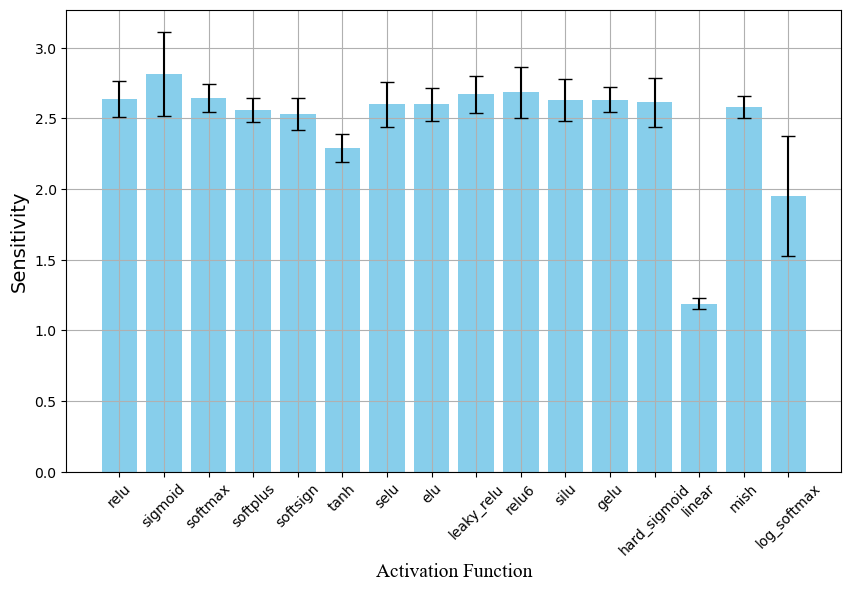

In [22]:
def model_activation(num, activation):
    """
    Create and compile the final neural network model.

    Parameters:
    - num: Number of variables/features to use in the model
    - activation: Activation function for the hidden layers

    Returns:
    - Compiled model
    - Sensitivity achieved by the model
    """
    variables = ['mBB', 'dRBB', 'pTB1', 'pTB2', 'pTV', 'Mtop', 'mTW', 'MET', 'dYWH', 'dPhiVBB', 'MV1cB1_cont', 'MV1cB2_cont', 'nTrackJetsOR']

    (x_train, y_train, w_train, 
    dset_val, dset_test) = scale_prepare_data(df_train, df_val, df_test, variables, scaler='standard')

    selected_variables = best_pca(x_train, variables, num)
    (x_train, y_train, w_train, 
    dset_val, dset_test) = scale_prepare_data(df_train, df_val, df_test, selected_variables, scaler='standard')

    model = Sequential()

    model.add(Dense(units=120, input_dim=num, activation=activation))

    model.add(Dense(65, activation=activation))

    model.add(Dense(49, activation=activation))

    model.add(Dense(14, activation=activation))

    model.add(Dense(units=1, activation='sigmoid'))

    optimizer = Nadam(learning_rate =0.005)

    model.compile(loss='BinaryFocalCrossentropy', optimizer=optimizer, metrics=['accuracy'])

    history = model.fit(x_train, y_train, sample_weight=w_train, epochs=3, batch_size=58, verbose=1)

    # Calculate sensitivity on the test set
    df_test['decision_value'] = model.predict(dset_test[0])
    sens = round(sensitivity_NN(df_test)[0], 2)

    return sens

# Define activation functions
activation = ['relu', 'sigmoid', 'softmax', 'softplus', 'softsign', 'tanh', 'selu', 'elu', 'leaky_relu', 'relu6', 'silu', 'gelu', 'hard_sigmoid', 'linear', 'mish', 'log_softmax']

num_iterations = 10

ac_sensitivities = []

for act in activation:
    sensitivities = []
    for _ in range(num_iterations):
        sens = model_activation(13, act)
        sensitivities.append(sens)
    mean_sensitivity = np.mean(sensitivities)
    std_deviation = np.std(sensitivities)
    ac_sensitivities.append((mean_sensitivity, std_deviation))

mean_values = [mean for mean, _ in ac_sensitivities]
std_dev_values = [std_dev for _, std_dev in ac_sensitivities]

def plot_activation_sensitivity(activation, mean_values, std_dev_values):
    plt.figure(figsize=(10, 6))
    plt.bar(activation, mean_values, yerr=std_dev_values, color='skyblue', capsize=5)
    plt.xlabel('Activation Function', fontname='Times New Roman', fontsize=14)
    plt.ylabel('Sensitivity', fontname='Times New Roman', fontsize=14)
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

# Usage example:
plot_activation_sensitivity(activation, mean_values, std_dev_values)


### Training Parameters

In [14]:
from keras.optimizers import Nadam 

def model_training(num, learning_rate, epoch, batchsize):
    """
    Create and compile the final neural network model.

    Parameters:
    - num: Number of features
    - learning_rate: Learning rate for the optimizer
    - epoch: number of epochs in training
    - batchsize: batchsize  in training

    Returns:
    - Compiled Keras model
    - Sensitivity achieved by the model
    """
    variables = ['mBB', 'dRBB', 'pTB1', 'pTB2', 'pTV', 'Mtop', 'mTW', 'MET', 'dYWH', 'dPhiVBB', 'MV1cB1_cont', 'MV1cB2_cont', 'nTrackJetsOR']

    (x_train, y_train, w_train, dset_val, dset_test) = scale_prepare_data(df_train, df_val, df_test, variables, scaler='standard')
    selected_variables = best_pca(x_train, variables, num)

    # Prepare data with selected variables
    (x_train, y_train, w_train, dset_val, dset_test) = scale_prepare_data(df_train, df_val, df_test, selected_variables, scaler='standard')

    model = Sequential()

    model.add(Dense(units=120, input_dim=num, activation='relu'))

    model.add(Dense(65, activation='relu'))
    model.add(Dense(49, activation='relu'))
    model.add(Dense(14, activation='relu'))

    model.add(Dense(units=1, activation='sigmoid'))

    optimizer = Nadam(learning_rate=learning_rate)
    model.compile(loss='BinaryFocalCrossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    history = model.fit(x_train, y_train, sample_weight=w_train, epochs=epoch, batch_size=batchsize, verbose=0)

    # Calculate sensitivity on the test set
    df_test['decision_value'] = model.predict(dset_test[0])
    sensitivity = round(sensitivity_NN(df_test)[0], 2)

    return model, sensitivity


Function used for the three steps of training parameter calibartion. The Learning Rate, Epoch and Batchsize can be varied in it. The final combination for these three parameters is 0.005, 10, and 128 respectively.

#### Learning rate

517/517 [==============================] - 0s 300us/step


517/517 [==============================] - 0s 294us/step


517/517 [==============================] - 0s 315us/step


517/517 [==============================] - 0s 308us/step


517/517 [==============================] - 0s 292us/step


517/517 [==============================] - 0s 344us/step


517/517 [==============================] - 0s 297us/step


517/517 [==============================] - 0s 294us/step


517/517 [==============================] - 0s 296us/step


517/517 [==============================] - 0s 297us/step


517/517 [==============================] - 0s 298us/step


517/517 [==============================] - 0s 320us/step


517/517 [==============================] - 0s 324us/step


517/517 [==============================] - 0s 309us/step


517/517 [==============================] - 0s 316us/step


517/517 [==============================] - 0s 300us/step


517/517 [==============================] - 0s 321us/step


517/517 [==============================] - 0s 301us/step


517/517 [==============================] - 0s 304us/step


517/517 [==============================] - 0s 299us/step


517/517 [==============================] - 0s 300us/step


517/517 [==============================] - 0s 297us/step


517/517 [==============================] - 0s 315us/step


517/517 [==============================] - 0s 296us/step


517/517 [==============================] - 0s 297us/step


517/517 [==============================] - 0s 306us/step


517/517 [==============================] - 0s 299us/step


517/517 [==============================] - 0s 301us/step


517/517 [==============================] - 0s 296us/step


517/517 [==============================] - 0s 294us/step


517/517 [==============================] - 0s 294us/step


517/517 [==============================] - 0s 297us/step


517/517 [==============================] - 0s 296us/step


517/517 [==============================] - 0s 312us/step


517/517 [==============================] - 0s 302us/step


517/517 [==============================] - 0s 297us/step


517/517 [==============================] - 0s 297us/step


517/517 [==============================] - 0s 300us/step


517/517 [==============================] - 0s 317us/step


517/517 [==============================] - 0s 295us/step


517/517 [==============================] - 0s 300us/step


517/517 [==============================] - 0s 296us/step


517/517 [==============================] - 0s 323us/step


517/517 [==============================] - 0s 305us/step


517/517 [==============================] - 0s 290us/step


517/517 [==============================] - 0s 300us/step


517/517 [==============================] - 0s 288us/step


517/517 [==============================] - 0s 309us/step


517/517 [==============================] - 0s 317us/step


517/517 [==============================] - 0s 299us/step


517/517 [==============================] - 0s 293us/step


517/517 [==============================] - 0s 296us/step


517/517 [==============================] - 0s 301us/step


517/517 [==============================] - 0s 293us/step


517/517 [==============================] - 0s 290us/step


517/517 [==============================] - 0s 306us/step


517/517 [==============================] - 0s 317us/step


517/517 [==============================] - 0s 285us/step


517/517 [==============================] - 0s 293us/step


517/517 [==============================] - 1s 919us/step


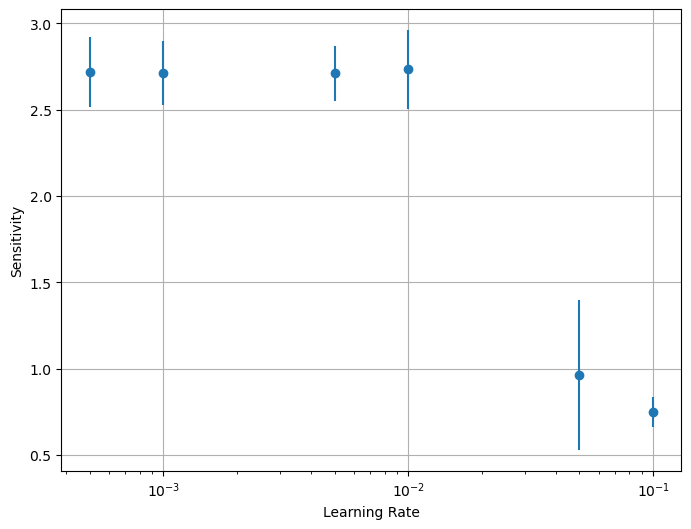

In [15]:
learning_rates = [0.0005, 0.001, 0.005, 0.01, 0.05, 0.1] 
num_iterations = 10 

# Initialize a list to store sensitivity values for each learning rate
sensitivities_all = []

for lr in learning_rates:
    sensitivities_lr = []  # Store sensitivity values for each learning rate
    for _ in range(num_iterations):
        _, sens = model_training(13, lr, 3, 58) #set epoch =3 and batchsize = 58
        sensitivities_lr.append(sens)
    sensitivities_all.append(sensitivities_lr)

# Calculate mean and standard deviation of sensitivity for each learning rate
mean_sensitivities = [np.mean(sensitivities_lr) for sensitivities_lr in sensitivities_all]
std_sensitivities = [np.std(sensitivities_lr) for sensitivities_lr in sensitivities_all]

# Plot learning rate vs. sensitivity with error bars
plt.figure(figsize=(8, 6))
plt.errorbar(learning_rates, mean_sensitivities, yerr=std_sensitivities, fmt='o')
plt.xscale('log')  
plt.xlabel('Learning Rate', fontname='Times New Roman')
plt.ylabel('Sensitivity', fontname='Times New Roman')
plt.grid(True)
plt.show()


#### Epochs

517/517 [==============================] - 0s 303us/step


517/517 [==============================] - 0s 291us/step


517/517 [==============================] - 0s 316us/step


517/517 [==============================] - 0s 336us/step


517/517 [==============================] - 0s 304us/step


517/517 [==============================] - 0s 308us/step


517/517 [==============================] - 0s 306us/step


517/517 [==============================] - 0s 341us/step


517/517 [==============================] - 0s 397us/step


517/517 [==============================] - 0s 306us/step


Epoch 1/2
1331/1331 [==============================] - 2s 636us/step - loss: 0.0912 - accuracy: 0.8874
Epoch 2/2
517/517 [==============================] - 0s 826us/step


Epoch 1/2
1331/1331 [==============================] - 2s 637us/step - loss: 0.0918 - accuracy: 0.8867
Epoch 2/2
517/517 [==============================] - 0s 306us/step


Epoch 1/2
1331/1331 [==============================] - 2s 627us/step - loss: 0.0915 - accuracy: 0.8861
Epoch 2/2
517/517 [==============================] - 0s 301us/step


Epoch 1/2
1331/1331 [==============================] - 2s 840us/step - loss: 0.0924 - accuracy: 0.8869
Epoch 2/2
517/517 [==============================] - 0s 306us/step


Epoch 1/2
1331/1331 [==============================] - 2s 646us/step - loss: 0.0925 - accuracy: 0.8862
Epoch 2/2
517/517 [==============================] - 0s 298us/step


Epoch 1/2
1331/1331 [==============================] - 2s 629us/step - loss: 0.0911 - accuracy: 0.8869
Epoch 2/2
517/517 [==============================] - 0s 301us/step


Epoch 1/2
1331/1331 [==============================] - 2s 635us/step - loss: 0.0922 - accuracy: 0.8869
Epoch 2/2
517/517 [==============================] - 0s 304us/step


Epoch 1/2
1331/1331 [==============================] - 2s 633us/step - loss: 0.0923 - accuracy: 0.8858
Epoch 2/2
517/517 [==============================] - 0s 386us/step


Epoch 1/2
1331/1331 [==============================] - 2s 638us/step - loss: 0.0915 - accuracy: 0.8872
Epoch 2/2
517/517 [==============================] - 0s 300us/step


Epoch 1/2
1331/1331 [==============================] - 2s 629us/step - loss: 0.0919 - accuracy: 0.8871
Epoch 2/2
517/517 [==============================] - 0s 302us/step


Epoch 1/3
1331/1331 [==============================] - 2s 666us/step - loss: 0.0910 - accuracy: 0.8871
Epoch 2/3
1331/1331 [==============================] - 1s 761us/step - loss: 0.0850 - accuracy: 0.8954
Epoch 3/3
517/517 [==============================] - 0s 298us/step


Epoch 1/3
1331/1331 [==============================] - 2s 643us/step - loss: 0.0916 - accuracy: 0.8858
Epoch 2/3
1331/1331 [==============================] - 1s 625us/step - loss: 0.0853 - accuracy: 0.8954
Epoch 3/3
517/517 [==============================] - 0s 296us/step


Epoch 1/3
1331/1331 [==============================] - 2s 840us/step - loss: 0.0915 - accuracy: 0.8866
Epoch 2/3
1331/1331 [==============================] - 1s 617us/step - loss: 0.0850 - accuracy: 0.8962
Epoch 3/3
517/517 [==============================] - 0s 303us/step


Epoch 1/3
1331/1331 [==============================] - 2s 640us/step - loss: 0.0921 - accuracy: 0.8846
Epoch 2/3
1331/1331 [==============================] - 1s 636us/step - loss: 0.0852 - accuracy: 0.8954
Epoch 3/3
517/517 [==============================] - 0s 305us/step


Epoch 1/3
1331/1331 [==============================] - 2s 634us/step - loss: 0.0916 - accuracy: 0.8868
Epoch 2/3
1331/1331 [==============================] - 1s 622us/step - loss: 0.0856 - accuracy: 0.8938
Epoch 3/3
517/517 [==============================] - 0s 295us/step


Epoch 1/3
1331/1331 [==============================] - 2s 630us/step - loss: 0.0918 - accuracy: 0.8866
Epoch 2/3
1331/1331 [==============================] - 1s 789us/step - loss: 0.0851 - accuracy: 0.8945
Epoch 3/3
517/517 [==============================] - 0s 299us/step


Epoch 1/3
1331/1331 [==============================] - 2s 646us/step - loss: 0.0919 - accuracy: 0.8879
Epoch 2/3
1331/1331 [==============================] - 1s 617us/step - loss: 0.0850 - accuracy: 0.8949
Epoch 3/3
517/517 [==============================] - 0s 298us/step


Epoch 1/3
1331/1331 [==============================] - 4s 738us/step - loss: 0.0917 - accuracy: 0.8875
Epoch 2/3
1331/1331 [==============================] - 1s 638us/step - loss: 0.0854 - accuracy: 0.8952
Epoch 3/3
517/517 [==============================] - 0s 316us/step


Epoch 1/3
1331/1331 [==============================] - 2s 727us/step - loss: 0.0917 - accuracy: 0.8875
Epoch 2/3
1331/1331 [==============================] - 1s 639us/step - loss: 0.0850 - accuracy: 0.8962
Epoch 3/3
517/517 [==============================] - 0s 310us/step


Epoch 1/3
1331/1331 [==============================] - 2s 647us/step - loss: 0.0910 - accuracy: 0.8871
Epoch 2/3
1331/1331 [==============================] - 1s 634us/step - loss: 0.0852 - accuracy: 0.8952
Epoch 3/3
517/517 [==============================] - 0s 322us/step


Epoch 1/4
1331/1331 [==============================] - 2s 646us/step - loss: 0.0914 - accuracy: 0.8862
Epoch 2/4
1331/1331 [==============================] - 1s 829us/step - loss: 0.0849 - accuracy: 0.8958
Epoch 3/4
1331/1331 [==============================] - 1s 637us/step - loss: 0.0842 - accuracy: 0.8962
Epoch 4/4
517/517 [==============================] - 0s 298us/step


Epoch 1/4
1331/1331 [==============================] - 2s 640us/step - loss: 0.0916 - accuracy: 0.8869
Epoch 2/4
1331/1331 [==============================] - 1s 622us/step - loss: 0.0859 - accuracy: 0.8947
Epoch 3/4
1331/1331 [==============================] - 1s 789us/step - loss: 0.0841 - accuracy: 0.8962
Epoch 4/4
517/517 [==============================] - 0s 303us/step


Epoch 1/4
1331/1331 [==============================] - 2s 632us/step - loss: 0.0916 - accuracy: 0.8858
Epoch 2/4
1331/1331 [==============================] - 1s 620us/step - loss: 0.0854 - accuracy: 0.8943
Epoch 3/4
1331/1331 [==============================] - 1s 622us/step - loss: 0.0835 - accuracy: 0.8963
Epoch 4/4
517/517 [==============================] - 0s 332us/step


Epoch 1/4
1331/1331 [==============================] - 2s 644us/step - loss: 0.0914 - accuracy: 0.8879
Epoch 2/4
1331/1331 [==============================] - 1s 629us/step - loss: 0.0854 - accuracy: 0.8962
Epoch 3/4
1331/1331 [==============================] - 1s 625us/step - loss: 0.0836 - accuracy: 0.8973
Epoch 4/4
517/517 [==============================] - 0s 333us/step


Epoch 1/4
1331/1331 [==============================] - 2s 863us/step - loss: 0.0920 - accuracy: 0.8879
Epoch 2/4
1331/1331 [==============================] - 1s 796us/step - loss: 0.0852 - accuracy: 0.8957
Epoch 3/4
1331/1331 [==============================] - 1s 701us/step - loss: 0.0834 - accuracy: 0.8976
Epoch 4/4
517/517 [==============================] - 0s 302us/step


Epoch 1/4
1331/1331 [==============================] - 2s 628us/step - loss: 0.0913 - accuracy: 0.8866
Epoch 2/4
1331/1331 [==============================] - 1s 796us/step - loss: 0.0850 - accuracy: 0.8952
Epoch 3/4
1331/1331 [==============================] - 1s 612us/step - loss: 0.0835 - accuracy: 0.8977
Epoch 4/4
517/517 [==============================] - 0s 288us/step


Epoch 1/4
1331/1331 [==============================] - 2s 623us/step - loss: 0.0912 - accuracy: 0.8884
Epoch 2/4
1331/1331 [==============================] - 1s 610us/step - loss: 0.0854 - accuracy: 0.8952
Epoch 3/4
1331/1331 [==============================] - 1s 610us/step - loss: 0.0841 - accuracy: 0.8960
Epoch 4/4
517/517 [==============================] - 0s 296us/step


Epoch 1/4
1331/1331 [==============================] - 2s 635us/step - loss: 0.0910 - accuracy: 0.8868
Epoch 2/4
1331/1331 [==============================] - 1s 625us/step - loss: 0.0859 - accuracy: 0.8948
Epoch 3/4
1331/1331 [==============================] - 1s 606us/step - loss: 0.0837 - accuracy: 0.8954
Epoch 4/4
517/517 [==============================] - 0s 293us/step


Epoch 1/4
1331/1331 [==============================] - 1s 612us/step - loss: 0.0915 - accuracy: 0.8864
Epoch 2/4
1331/1331 [==============================] - 1s 604us/step - loss: 0.0850 - accuracy: 0.8961
Epoch 3/4
1331/1331 [==============================] - 1s 603us/step - loss: 0.0835 - accuracy: 0.8961
Epoch 4/4
517/517 [==============================] - 0s 289us/step


Epoch 1/4
1331/1331 [==============================] - 2s 773us/step - loss: 0.0919 - accuracy: 0.8876
Epoch 2/4
1331/1331 [==============================] - 1s 607us/step - loss: 0.0853 - accuracy: 0.8958
Epoch 3/4
1331/1331 [==============================] - 1s 606us/step - loss: 0.0834 - accuracy: 0.8977
Epoch 4/4
517/517 [==============================] - 0s 290us/step


Epoch 1/5
1331/1331 [==============================] - 2s 611us/step - loss: 0.0914 - accuracy: 0.8866
Epoch 2/5
1331/1331 [==============================] - 1s 602us/step - loss: 0.0850 - accuracy: 0.8951
Epoch 3/5
1331/1331 [==============================] - 1s 777us/step - loss: 0.0835 - accuracy: 0.8968
Epoch 4/5
1331/1331 [==============================] - 1s 604us/step - loss: 0.0825 - accuracy: 0.8971
Epoch 5/5
517/517 [==============================] - 0s 294us/step


Epoch 1/5
1331/1331 [==============================] - 2s 770us/step - loss: 0.0917 - accuracy: 0.8868
Epoch 2/5
1331/1331 [==============================] - 1s 976us/step - loss: 0.0850 - accuracy: 0.8949
Epoch 3/5
1331/1331 [==============================] - 1s 686us/step - loss: 0.0839 - accuracy: 0.8967
Epoch 4/5
1331/1331 [==============================] - 1s 750us/step - loss: 0.0827 - accuracy: 0.8980
Epoch 5/5
517/517 [==============================] - 0s 486us/step


Epoch 1/5
1331/1331 [==============================] - 2s 621us/step - loss: 0.0910 - accuracy: 0.8862
Epoch 2/5
1331/1331 [==============================] - 1s 607us/step - loss: 0.0858 - accuracy: 0.8945
Epoch 3/5
1331/1331 [==============================] - 1s 601us/step - loss: 0.0836 - accuracy: 0.8965
Epoch 4/5
1331/1331 [==============================] - 1s 619us/step - loss: 0.0832 - accuracy: 0.8968
Epoch 5/5
517/517 [==============================] - 0s 296us/step


Epoch 1/5
1331/1331 [==============================] - 2s 620us/step - loss: 0.0917 - accuracy: 0.8877
Epoch 2/5
1331/1331 [==============================] - 1s 603us/step - loss: 0.0858 - accuracy: 0.8940
Epoch 3/5
1331/1331 [==============================] - 1s 752us/step - loss: 0.0838 - accuracy: 0.8975
Epoch 4/5
1331/1331 [==============================] - 1s 602us/step - loss: 0.0825 - accuracy: 0.8975
Epoch 5/5
517/517 [==============================] - 0s 285us/step


Epoch 1/5
1331/1331 [==============================] - 2s 619us/step - loss: 0.0919 - accuracy: 0.8847
Epoch 2/5
1331/1331 [==============================] - 1s 608us/step - loss: 0.0854 - accuracy: 0.8957
Epoch 3/5
1331/1331 [==============================] - 1s 610us/step - loss: 0.0844 - accuracy: 0.8963
Epoch 4/5
1331/1331 [==============================] - 1s 734us/step - loss: 0.0829 - accuracy: 0.8976
Epoch 5/5
517/517 [==============================] - 0s 289us/step


Epoch 1/5
1331/1331 [==============================] - 1s 618us/step - loss: 0.0920 - accuracy: 0.8866
Epoch 2/5
1331/1331 [==============================] - 1s 608us/step - loss: 0.0858 - accuracy: 0.8944
Epoch 3/5
1331/1331 [==============================] - 1s 608us/step - loss: 0.0835 - accuracy: 0.8972
Epoch 4/5
1331/1331 [==============================] - 1s 632us/step - loss: 0.0826 - accuracy: 0.8977
Epoch 5/5
517/517 [==============================] - 0s 289us/step


Epoch 1/5
1331/1331 [==============================] - 1s 613us/step - loss: 0.0920 - accuracy: 0.8870
Epoch 2/5
1331/1331 [==============================] - 1s 601us/step - loss: 0.0851 - accuracy: 0.8956
Epoch 3/5
1331/1331 [==============================] - 1s 597us/step - loss: 0.0837 - accuracy: 0.8969
Epoch 4/5
1331/1331 [==============================] - 1s 598us/step - loss: 0.0831 - accuracy: 0.8981
Epoch 5/5
517/517 [==============================] - 0s 287us/step


Epoch 1/5
1331/1331 [==============================] - 2s 798us/step - loss: 0.0921 - accuracy: 0.8852
Epoch 2/5
1331/1331 [==============================] - 1s 604us/step - loss: 0.0857 - accuracy: 0.8943
Epoch 3/5
1331/1331 [==============================] - 1s 602us/step - loss: 0.0834 - accuracy: 0.8961
Epoch 4/5
1331/1331 [==============================] - 1s 605us/step - loss: 0.0827 - accuracy: 0.8981
Epoch 5/5
517/517 [==============================] - 0s 284us/step


Epoch 1/5
1331/1331 [==============================] - 2s 618us/step - loss: 0.0912 - accuracy: 0.8870
Epoch 2/5
1331/1331 [==============================] - 1s 782us/step - loss: 0.0855 - accuracy: 0.8958
Epoch 3/5
1331/1331 [==============================] - 1s 608us/step - loss: 0.0836 - accuracy: 0.8976
Epoch 4/5
1331/1331 [==============================] - 1s 607us/step - loss: 0.0824 - accuracy: 0.8986
Epoch 5/5
517/517 [==============================] - 0s 293us/step


Epoch 1/5
1331/1331 [==============================] - 2s 612us/step - loss: 0.0918 - accuracy: 0.8864
Epoch 2/5
1331/1331 [==============================] - 1s 603us/step - loss: 0.0855 - accuracy: 0.8946
Epoch 3/5
1331/1331 [==============================] - 1s 801us/step - loss: 0.0838 - accuracy: 0.8960
Epoch 4/5
1331/1331 [==============================] - 1s 604us/step - loss: 0.0833 - accuracy: 0.8980
Epoch 5/5
517/517 [==============================] - 0s 288us/step


Epoch 1/6
1331/1331 [==============================] - 2s 614us/step - loss: 0.0913 - accuracy: 0.8868
Epoch 2/6
1331/1331 [==============================] - 1s 606us/step - loss: 0.0856 - accuracy: 0.8959
Epoch 3/6
1331/1331 [==============================] - 1s 601us/step - loss: 0.0837 - accuracy: 0.8973
Epoch 4/6
1331/1331 [==============================] - 1s 602us/step - loss: 0.0830 - accuracy: 0.8968
Epoch 5/6
1331/1331 [==============================] - 1s 778us/step - loss: 0.0824 - accuracy: 0.8976
Epoch 6/6
517/517 [==============================] - 0s 287us/step


Epoch 1/6
1331/1331 [==============================] - 2s 623us/step - loss: 0.0914 - accuracy: 0.8867
Epoch 2/6
1331/1331 [==============================] - 1s 613us/step - loss: 0.0856 - accuracy: 0.8947
Epoch 3/6
1331/1331 [==============================] - 1s 605us/step - loss: 0.0842 - accuracy: 0.8967
Epoch 4/6
1331/1331 [==============================] - 1s 609us/step - loss: 0.0825 - accuracy: 0.8972
Epoch 5/6
1331/1331 [==============================] - 1s 783us/step - loss: 0.0823 - accuracy: 0.8979
Epoch 6/6
517/517 [==============================] - 0s 290us/step


Epoch 1/6
1331/1331 [==============================] - 2s 615us/step - loss: 0.0914 - accuracy: 0.8866
Epoch 2/6
1331/1331 [==============================] - 1s 604us/step - loss: 0.0858 - accuracy: 0.8950
Epoch 3/6
1331/1331 [==============================] - 1s 601us/step - loss: 0.0839 - accuracy: 0.8963
Epoch 4/6
1331/1331 [==============================] - 1s 602us/step - loss: 0.0830 - accuracy: 0.8977
Epoch 5/6
1331/1331 [==============================] - 1s 776us/step - loss: 0.0823 - accuracy: 0.8975
Epoch 6/6
517/517 [==============================] - 0s 288us/step


Epoch 1/6
1331/1331 [==============================] - 2s 615us/step - loss: 0.0915 - accuracy: 0.8875
Epoch 2/6
1331/1331 [==============================] - 1s 608us/step - loss: 0.0857 - accuracy: 0.8944
Epoch 3/6
1331/1331 [==============================] - 1s 631us/step - loss: 0.0839 - accuracy: 0.8970
Epoch 4/6
1331/1331 [==============================] - 1s 682us/step - loss: 0.0830 - accuracy: 0.8969
Epoch 5/6
1331/1331 [==============================] - 1s 843us/step - loss: 0.0827 - accuracy: 0.8979
Epoch 6/6
517/517 [==============================] - 0s 278us/step


Epoch 1/6
1331/1331 [==============================] - 2s 649us/step - loss: 0.0912 - accuracy: 0.8874
Epoch 2/6
1331/1331 [==============================] - 1s 601us/step - loss: 0.0857 - accuracy: 0.8951
Epoch 3/6
1331/1331 [==============================] - 1s 618us/step - loss: 0.0833 - accuracy: 0.8964
Epoch 4/6
1331/1331 [==============================] - 1s 617us/step - loss: 0.0822 - accuracy: 0.8983
Epoch 5/6
1331/1331 [==============================] - 1s 774us/step - loss: 0.0820 - accuracy: 0.8975
Epoch 6/6
517/517 [==============================] - 0s 289us/step


Epoch 1/6
1331/1331 [==============================] - 2s 618us/step - loss: 0.0923 - accuracy: 0.8861
Epoch 2/6
1331/1331 [==============================] - 1s 602us/step - loss: 0.0857 - accuracy: 0.8957
Epoch 3/6
1331/1331 [==============================] - 1s 598us/step - loss: 0.0838 - accuracy: 0.8966
Epoch 4/6
1331/1331 [==============================] - 1s 594us/step - loss: 0.0830 - accuracy: 0.8974
Epoch 5/6
1331/1331 [==============================] - 1s 601us/step - loss: 0.0825 - accuracy: 0.8970
Epoch 6/6
517/517 [==============================] - 0s 289us/step


Epoch 1/6
1331/1331 [==============================] - 2s 619us/step - loss: 0.0926 - accuracy: 0.8850
Epoch 2/6
1331/1331 [==============================] - 1s 608us/step - loss: 0.0859 - accuracy: 0.8943
Epoch 3/6
1331/1331 [==============================] - 1s 607us/step - loss: 0.0839 - accuracy: 0.8956
Epoch 4/6
1331/1331 [==============================] - 1s 613us/step - loss: 0.0829 - accuracy: 0.8968
Epoch 5/6
1331/1331 [==============================] - 1s 605us/step - loss: 0.0822 - accuracy: 0.8973
Epoch 6/6
517/517 [==============================] - 0s 288us/step


Epoch 1/6
1331/1331 [==============================] - 4s 667us/step - loss: 0.0915 - accuracy: 0.8867
Epoch 2/6
1331/1331 [==============================] - 1s 629us/step - loss: 0.0856 - accuracy: 0.8949
Epoch 3/6
1331/1331 [==============================] - 1s 629us/step - loss: 0.0840 - accuracy: 0.8968
Epoch 4/6
1331/1331 [==============================] - 1s 623us/step - loss: 0.0828 - accuracy: 0.8978
Epoch 5/6
1331/1331 [==============================] - 1s 624us/step - loss: 0.0825 - accuracy: 0.8980
Epoch 6/6
517/517 [==============================] - 0s 304us/step


Epoch 1/6
1331/1331 [==============================] - 2s 642us/step - loss: 0.0926 - accuracy: 0.8862
Epoch 2/6
1331/1331 [==============================] - 1s 631us/step - loss: 0.0857 - accuracy: 0.8949
Epoch 3/6
1331/1331 [==============================] - 1s 635us/step - loss: 0.0837 - accuracy: 0.8966
Epoch 4/6
1331/1331 [==============================] - 1s 635us/step - loss: 0.0826 - accuracy: 0.8980
Epoch 5/6
1331/1331 [==============================] - 1s 630us/step - loss: 0.0821 - accuracy: 0.8985
Epoch 6/6
517/517 [==============================] - 0s 303us/step


Epoch 1/6
1331/1331 [==============================] - 2s 626us/step - loss: 0.0910 - accuracy: 0.8857
Epoch 2/6
1331/1331 [==============================] - 1s 613us/step - loss: 0.0848 - accuracy: 0.8953
Epoch 3/6
1331/1331 [==============================] - 1s 614us/step - loss: 0.0837 - accuracy: 0.8968
Epoch 4/6
1331/1331 [==============================] - 1s 614us/step - loss: 0.0828 - accuracy: 0.8972
Epoch 5/6
1331/1331 [==============================] - 1s 614us/step - loss: 0.0821 - accuracy: 0.8984
Epoch 6/6
517/517 [==============================] - 0s 296us/step


Epoch 1/7
1331/1331 [==============================] - 2s 634us/step - loss: 0.0923 - accuracy: 0.8849
Epoch 2/7
1331/1331 [==============================] - 1s 606us/step - loss: 0.0851 - accuracy: 0.8948
Epoch 3/7
1331/1331 [==============================] - 1s 601us/step - loss: 0.0838 - accuracy: 0.8962
Epoch 4/7
1331/1331 [==============================] - 1s 616us/step - loss: 0.0828 - accuracy: 0.8970
Epoch 5/7
1331/1331 [==============================] - 1s 776us/step - loss: 0.0822 - accuracy: 0.8979
Epoch 6/7
1331/1331 [==============================] - 1s 606us/step - loss: 0.0818 - accuracy: 0.8985
Epoch 7/7
517/517 [==============================] - 0s 294us/step


Epoch 1/7
1331/1331 [==============================] - 2s 621us/step - loss: 0.0913 - accuracy: 0.8872
Epoch 2/7
1331/1331 [==============================] - 1s 606us/step - loss: 0.0855 - accuracy: 0.8943
Epoch 3/7
1331/1331 [==============================] - 1s 611us/step - loss: 0.0839 - accuracy: 0.8967
Epoch 4/7
1331/1331 [==============================] - 1s 787us/step - loss: 0.0830 - accuracy: 0.8964
Epoch 5/7
1331/1331 [==============================] - 1s 608us/step - loss: 0.0823 - accuracy: 0.8988
Epoch 6/7
1331/1331 [==============================] - 1s 612us/step - loss: 0.0818 - accuracy: 0.8982
Epoch 7/7
517/517 [==============================] - 0s 289us/step


Epoch 1/7
1331/1331 [==============================] - 2s 625us/step - loss: 0.0914 - accuracy: 0.8864
Epoch 2/7
1331/1331 [==============================] - 1s 618us/step - loss: 0.0852 - accuracy: 0.8948
Epoch 3/7
1331/1331 [==============================] - 1s 793us/step - loss: 0.0835 - accuracy: 0.8967
Epoch 4/7
1331/1331 [==============================] - 1s 613us/step - loss: 0.0825 - accuracy: 0.8978
Epoch 5/7
1331/1331 [==============================] - 1s 617us/step - loss: 0.0823 - accuracy: 0.8976
Epoch 6/7
1331/1331 [==============================] - 1s 614us/step - loss: 0.0820 - accuracy: 0.8984
Epoch 7/7
517/517 [==============================] - 0s 292us/step


Epoch 1/7
1331/1331 [==============================] - 2s 635us/step - loss: 0.0909 - accuracy: 0.8881
Epoch 2/7
1331/1331 [==============================] - 1s 988us/step - loss: 0.0858 - accuracy: 0.8948
Epoch 3/7
1331/1331 [==============================] - 1s 730us/step - loss: 0.0840 - accuracy: 0.8959
Epoch 4/7
1331/1331 [==============================] - 1s 696us/step - loss: 0.0829 - accuracy: 0.8975
Epoch 5/7
1331/1331 [==============================] - 1s 855us/step - loss: 0.0824 - accuracy: 0.8984
Epoch 6/7
1331/1331 [==============================] - 1s 696us/step - loss: 0.0822 - accuracy: 0.8983
Epoch 7/7
517/517 [==============================] - 0s 397us/step


Epoch 1/7
1331/1331 [==============================] - 2s 924us/step - loss: 0.0911 - accuracy: 0.8873
Epoch 2/7
1331/1331 [==============================] - 1s 614us/step - loss: 0.0855 - accuracy: 0.8943
Epoch 3/7
1331/1331 [==============================] - 1s 610us/step - loss: 0.0840 - accuracy: 0.8970
Epoch 4/7
1331/1331 [==============================] - 1s 609us/step - loss: 0.0826 - accuracy: 0.8975
Epoch 5/7
1331/1331 [==============================] - 1s 618us/step - loss: 0.0823 - accuracy: 0.8990
Epoch 6/7
1331/1331 [==============================] - 1s 706us/step - loss: 0.0818 - accuracy: 0.8990
Epoch 7/7
517/517 [==============================] - 0s 288us/step


Epoch 1/7
1331/1331 [==============================] - 2s 614us/step - loss: 0.0917 - accuracy: 0.8872
Epoch 2/7
1331/1331 [==============================] - 1s 604us/step - loss: 0.0858 - accuracy: 0.8953
Epoch 3/7
1331/1331 [==============================] - 1s 606us/step - loss: 0.0836 - accuracy: 0.8963
Epoch 4/7
1331/1331 [==============================] - 1s 605us/step - loss: 0.0833 - accuracy: 0.8971
Epoch 5/7
1331/1331 [==============================] - 1s 747us/step - loss: 0.0825 - accuracy: 0.8985
Epoch 6/7
1331/1331 [==============================] - 1s 601us/step - loss: 0.0818 - accuracy: 0.8989
Epoch 7/7
517/517 [==============================] - 0s 288us/step


Epoch 1/7
1331/1331 [==============================] - 2s 802us/step - loss: 0.0920 - accuracy: 0.8861
Epoch 2/7
1331/1331 [==============================] - 1s 762us/step - loss: 0.0853 - accuracy: 0.8948
Epoch 3/7
1331/1331 [==============================] - 1s 701us/step - loss: 0.0834 - accuracy: 0.8970
Epoch 4/7
1331/1331 [==============================] - 1s 823us/step - loss: 0.0829 - accuracy: 0.8977
Epoch 5/7
1331/1331 [==============================] - 1s 633us/step - loss: 0.0821 - accuracy: 0.8981
Epoch 6/7
1331/1331 [==============================] - 1s 626us/step - loss: 0.0819 - accuracy: 0.8982
Epoch 7/7
517/517 [==============================] - 0s 308us/step


Epoch 1/7
1331/1331 [==============================] - 2s 646us/step - loss: 0.0919 - accuracy: 0.8874
Epoch 2/7
1331/1331 [==============================] - 1s 638us/step - loss: 0.0856 - accuracy: 0.8943
Epoch 3/7
1331/1331 [==============================] - 1s 809us/step - loss: 0.0841 - accuracy: 0.8972
Epoch 4/7
1331/1331 [==============================] - 1s 632us/step - loss: 0.0827 - accuracy: 0.8969
Epoch 5/7
1331/1331 [==============================] - 1s 635us/step - loss: 0.0821 - accuracy: 0.8983
Epoch 6/7
1331/1331 [==============================] - 1s 634us/step - loss: 0.0817 - accuracy: 0.8987
Epoch 7/7
517/517 [==============================] - 0s 299us/step


Epoch 1/7
1331/1331 [==============================] - 2s 652us/step - loss: 0.0911 - accuracy: 0.8876
Epoch 2/7
1331/1331 [==============================] - 1s 814us/step - loss: 0.0851 - accuracy: 0.8945
Epoch 3/7
1331/1331 [==============================] - 1s 639us/step - loss: 0.0838 - accuracy: 0.8963
Epoch 4/7
1331/1331 [==============================] - 1s 637us/step - loss: 0.0827 - accuracy: 0.8969
Epoch 5/7
1331/1331 [==============================] - 1s 638us/step - loss: 0.0826 - accuracy: 0.8974
Epoch 6/7
1331/1331 [==============================] - 1s 642us/step - loss: 0.0817 - accuracy: 0.8987
Epoch 7/7
517/517 [==============================] - 0s 314us/step


Epoch 1/7
1331/1331 [==============================] - 2s 650us/step - loss: 0.0907 - accuracy: 0.8880
Epoch 2/7
1331/1331 [==============================] - 1s 648us/step - loss: 0.0851 - accuracy: 0.8961
Epoch 3/7
1331/1331 [==============================] - 1s 627us/step - loss: 0.0836 - accuracy: 0.8974
Epoch 4/7
1331/1331 [==============================] - 1s 630us/step - loss: 0.0826 - accuracy: 0.8971
Epoch 5/7
1331/1331 [==============================] - 1s 619us/step - loss: 0.0821 - accuracy: 0.8979
Epoch 6/7
1331/1331 [==============================] - 1s 623us/step - loss: 0.0814 - accuracy: 0.8996
Epoch 7/7
517/517 [==============================] - 0s 299us/step


Epoch 1/8
1331/1331 [==============================] - 2s 625us/step - loss: 0.0921 - accuracy: 0.8863
Epoch 2/8
1331/1331 [==============================] - 1s 612us/step - loss: 0.0855 - accuracy: 0.8949
Epoch 3/8
1331/1331 [==============================] - 1s 626us/step - loss: 0.0839 - accuracy: 0.8959
Epoch 4/8
1331/1331 [==============================] - 1s 627us/step - loss: 0.0830 - accuracy: 0.8971
Epoch 5/8
1331/1331 [==============================] - 1s 610us/step - loss: 0.0820 - accuracy: 0.8982
Epoch 6/8
1331/1331 [==============================] - 1s 791us/step - loss: 0.0819 - accuracy: 0.8982
Epoch 7/8
1331/1331 [==============================] - 1s 610us/step - loss: 0.0812 - accuracy: 0.8990
Epoch 8/8
517/517 [==============================] - 0s 284us/step


Epoch 1/8
1331/1331 [==============================] - 2s 617us/step - loss: 0.0916 - accuracy: 0.8870
Epoch 2/8
1331/1331 [==============================] - 1s 607us/step - loss: 0.0853 - accuracy: 0.8948
Epoch 3/8
1331/1331 [==============================] - 1s 605us/step - loss: 0.0839 - accuracy: 0.8957
Epoch 4/8
1331/1331 [==============================] - 1s 777us/step - loss: 0.0827 - accuracy: 0.8972
Epoch 5/8
1331/1331 [==============================] - 1s 641us/step - loss: 0.0824 - accuracy: 0.8978
Epoch 6/8
1331/1331 [==============================] - 1s 609us/step - loss: 0.0824 - accuracy: 0.8983
Epoch 7/8
1331/1331 [==============================] - 1s 605us/step - loss: 0.0814 - accuracy: 0.8982
Epoch 8/8
517/517 [==============================] - 0s 289us/step


Epoch 1/8
1331/1331 [==============================] - 2s 620us/step - loss: 0.0920 - accuracy: 0.8850
Epoch 2/8
1331/1331 [==============================] - 1s 788us/step - loss: 0.0851 - accuracy: 0.8949
Epoch 3/8
1331/1331 [==============================] - 1s 613us/step - loss: 0.0834 - accuracy: 0.8972
Epoch 4/8
1331/1331 [==============================] - 1s 611us/step - loss: 0.0828 - accuracy: 0.8972
Epoch 5/8
1331/1331 [==============================] - 1s 609us/step - loss: 0.0820 - accuracy: 0.8983
Epoch 6/8
1331/1331 [==============================] - 1s 609us/step - loss: 0.0816 - accuracy: 0.8998
Epoch 7/8
1331/1331 [==============================] - 1s 611us/step - loss: 0.0812 - accuracy: 0.8992
Epoch 8/8
517/517 [==============================] - 0s 287us/step


Epoch 1/8
1331/1331 [==============================] - 2s 612us/step - loss: 0.0915 - accuracy: 0.8866
Epoch 2/8
1331/1331 [==============================] - 1s 597us/step - loss: 0.0854 - accuracy: 0.8953
Epoch 3/8
1331/1331 [==============================] - 1s 611us/step - loss: 0.0835 - accuracy: 0.8959
Epoch 4/8
1331/1331 [==============================] - 1s 596us/step - loss: 0.0832 - accuracy: 0.8982
Epoch 5/8
1331/1331 [==============================] - 1s 598us/step - loss: 0.0821 - accuracy: 0.8986
Epoch 6/8
1331/1331 [==============================] - 1s 599us/step - loss: 0.0818 - accuracy: 0.8983
Epoch 7/8
1331/1331 [==============================] - 1s 671us/step - loss: 0.0813 - accuracy: 0.8992
Epoch 8/8
517/517 [==============================] - 0s 288us/step


Epoch 1/8
1331/1331 [==============================] - 2s 629us/step - loss: 0.0919 - accuracy: 0.8871
Epoch 2/8
1331/1331 [==============================] - 1s 614us/step - loss: 0.0858 - accuracy: 0.8952
Epoch 3/8
1331/1331 [==============================] - 1s 609us/step - loss: 0.0835 - accuracy: 0.8973
Epoch 4/8
1331/1331 [==============================] - 1s 610us/step - loss: 0.0828 - accuracy: 0.8976
Epoch 5/8
1331/1331 [==============================] - 1s 608us/step - loss: 0.0824 - accuracy: 0.8974
Epoch 6/8
1331/1331 [==============================] - 1s 783us/step - loss: 0.0819 - accuracy: 0.8970
Epoch 7/8
1331/1331 [==============================] - 1s 613us/step - loss: 0.0812 - accuracy: 0.8995
Epoch 8/8
517/517 [==============================] - 0s 287us/step


Epoch 1/8
1331/1331 [==============================] - 2s 620us/step - loss: 0.0920 - accuracy: 0.8869
Epoch 2/8
1331/1331 [==============================] - 1s 608us/step - loss: 0.0852 - accuracy: 0.8945
Epoch 3/8
1331/1331 [==============================] - 1s 609us/step - loss: 0.0833 - accuracy: 0.8966
Epoch 4/8
1331/1331 [==============================] - 1s 795us/step - loss: 0.0826 - accuracy: 0.8981
Epoch 5/8
1331/1331 [==============================] - 1s 612us/step - loss: 0.0821 - accuracy: 0.8977
Epoch 6/8
1331/1331 [==============================] - 1s 610us/step - loss: 0.0819 - accuracy: 0.8985
Epoch 7/8
1331/1331 [==============================] - 1s 609us/step - loss: 0.0812 - accuracy: 0.8986
Epoch 8/8
517/517 [==============================] - 0s 289us/step


Epoch 1/8
1331/1331 [==============================] - 2s 614us/step - loss: 0.0920 - accuracy: 0.8878
Epoch 2/8
1331/1331 [==============================] - 1s 788us/step - loss: 0.0855 - accuracy: 0.8952
Epoch 3/8
1331/1331 [==============================] - 1s 603us/step - loss: 0.0840 - accuracy: 0.8971
Epoch 4/8
1331/1331 [==============================] - 1s 604us/step - loss: 0.0835 - accuracy: 0.8970
Epoch 5/8
1331/1331 [==============================] - 1s 600us/step - loss: 0.0820 - accuracy: 0.8987
Epoch 6/8
1331/1331 [==============================] - 1s 602us/step - loss: 0.0816 - accuracy: 0.8988
Epoch 7/8
1331/1331 [==============================] - 1s 604us/step - loss: 0.0811 - accuracy: 0.8986
Epoch 8/8
517/517 [==============================] - 0s 295us/step


Epoch 1/8
1331/1331 [==============================] - 2s 613us/step - loss: 0.0917 - accuracy: 0.8873
Epoch 2/8
1331/1331 [==============================] - 1s 606us/step - loss: 0.0856 - accuracy: 0.8950
Epoch 3/8
1331/1331 [==============================] - 1s 612us/step - loss: 0.0836 - accuracy: 0.8955
Epoch 4/8
1331/1331 [==============================] - 1s 604us/step - loss: 0.0828 - accuracy: 0.8961
Epoch 5/8
1331/1331 [==============================] - 1s 627us/step - loss: 0.0827 - accuracy: 0.8975
Epoch 6/8
1331/1331 [==============================] - 1s 769us/step - loss: 0.0817 - accuracy: 0.8991
Epoch 7/8
1331/1331 [==============================] - 1s 807us/step - loss: 0.0807 - accuracy: 0.8991
Epoch 8/8
517/517 [==============================] - 0s 300us/step


Epoch 1/8
1331/1331 [==============================] - 2s 969us/step - loss: 0.0920 - accuracy: 0.8853
Epoch 2/8
1331/1331 [==============================] - 1s 713us/step - loss: 0.0858 - accuracy: 0.8958
Epoch 3/8
1331/1331 [==============================] - 2s 1ms/step - loss: 0.0836 - accuracy: 0.8964
Epoch 4/8
1331/1331 [==============================] - 1s 1ms/step - loss: 0.0837 - accuracy: 0.8958
Epoch 5/8
1331/1331 [==============================] - 1s 898us/step - loss: 0.0822 - accuracy: 0.8984
Epoch 6/8
1331/1331 [==============================] - 1s 674us/step - loss: 0.0819 - accuracy: 0.8988
Epoch 7/8
1331/1331 [==============================] - 1s 691us/step - loss: 0.0812 - accuracy: 0.8988
Epoch 8/8
517/517 [==============================] - 0s 323us/step


Epoch 1/8
1331/1331 [==============================] - 2s 665us/step - loss: 0.0914 - accuracy: 0.8872
Epoch 2/8
1331/1331 [==============================] - 1s 635us/step - loss: 0.0850 - accuracy: 0.8954
Epoch 3/8
1331/1331 [==============================] - 1s 628us/step - loss: 0.0835 - accuracy: 0.8970
Epoch 4/8
1331/1331 [==============================] - 1s 624us/step - loss: 0.0832 - accuracy: 0.8967
Epoch 5/8
1331/1331 [==============================] - 1s 627us/step - loss: 0.0820 - accuracy: 0.8982
Epoch 6/8
1331/1331 [==============================] - 1s 909us/step - loss: 0.0819 - accuracy: 0.8982
Epoch 7/8
1331/1331 [==============================] - 1s 659us/step - loss: 0.0815 - accuracy: 0.8981
Epoch 8/8
517/517 [==============================] - 0s 302us/step


Epoch 1/9
1331/1331 [==============================] - 2s 629us/step - loss: 0.0914 - accuracy: 0.8874
Epoch 2/9
1331/1331 [==============================] - 1s 614us/step - loss: 0.0856 - accuracy: 0.8945
Epoch 3/9
1331/1331 [==============================] - 1s 782us/step - loss: 0.0830 - accuracy: 0.8972
Epoch 4/9
1331/1331 [==============================] - 1s 651us/step - loss: 0.0827 - accuracy: 0.8975
Epoch 5/9
1331/1331 [==============================] - 1s 634us/step - loss: 0.0824 - accuracy: 0.8982
Epoch 6/9
1331/1331 [==============================] - 1s 626us/step - loss: 0.0816 - accuracy: 0.8986
Epoch 7/9
1331/1331 [==============================] - 1s 616us/step - loss: 0.0809 - accuracy: 0.8993
Epoch 8/9
1331/1331 [==============================] - 1s 608us/step - loss: 0.0812 - accuracy: 0.8993
Epoch 9/9
517/517 [==============================] - 0s 291us/step


Epoch 1/9
1331/1331 [==============================] - 2s 727us/step - loss: 0.0921 - accuracy: 0.8871
Epoch 2/9
1331/1331 [==============================] - 1s 607us/step - loss: 0.0855 - accuracy: 0.8952
Epoch 3/9
1331/1331 [==============================] - 1s 602us/step - loss: 0.0837 - accuracy: 0.8960
Epoch 4/9
1331/1331 [==============================] - 1s 600us/step - loss: 0.0831 - accuracy: 0.8978
Epoch 5/9
1331/1331 [==============================] - 1s 595us/step - loss: 0.0824 - accuracy: 0.8985
Epoch 6/9
1331/1331 [==============================] - 1s 593us/step - loss: 0.0820 - accuracy: 0.8983
Epoch 7/9
1331/1331 [==============================] - 1s 611us/step - loss: 0.0817 - accuracy: 0.8992
Epoch 8/9
1331/1331 [==============================] - 1s 639us/step - loss: 0.0806 - accuracy: 0.8995
Epoch 9/9
517/517 [==============================] - 0s 328us/step


Epoch 1/9
1331/1331 [==============================] - 2s 636us/step - loss: 0.0918 - accuracy: 0.8868
Epoch 2/9
1331/1331 [==============================] - 1s 613us/step - loss: 0.0846 - accuracy: 0.8960
Epoch 3/9
1331/1331 [==============================] - 1s 611us/step - loss: 0.0834 - accuracy: 0.8966
Epoch 4/9
1331/1331 [==============================] - 1s 609us/step - loss: 0.0829 - accuracy: 0.8980
Epoch 5/9
1331/1331 [==============================] - 1s 612us/step - loss: 0.0823 - accuracy: 0.8975
Epoch 6/9
1331/1331 [==============================] - 1s 782us/step - loss: 0.0815 - accuracy: 0.8986
Epoch 7/9
1331/1331 [==============================] - 1s 618us/step - loss: 0.0816 - accuracy: 0.8990
Epoch 8/9
1331/1331 [==============================] - 1s 620us/step - loss: 0.0814 - accuracy: 0.8984
Epoch 9/9
517/517 [==============================] - 0s 296us/step


Epoch 1/9
1331/1331 [==============================] - 2s 632us/step - loss: 0.0919 - accuracy: 0.8870
Epoch 2/9
1331/1331 [==============================] - 1s 616us/step - loss: 0.0850 - accuracy: 0.8958
Epoch 3/9
1331/1331 [==============================] - 1s 796us/step - loss: 0.0839 - accuracy: 0.8959
Epoch 4/9
1331/1331 [==============================] - 1s 620us/step - loss: 0.0828 - accuracy: 0.8976
Epoch 5/9
1331/1331 [==============================] - 1s 622us/step - loss: 0.0821 - accuracy: 0.8980
Epoch 6/9
1331/1331 [==============================] - 1s 615us/step - loss: 0.0815 - accuracy: 0.8984
Epoch 7/9
1331/1331 [==============================] - 1s 615us/step - loss: 0.0817 - accuracy: 0.8981
Epoch 8/9
1331/1331 [==============================] - 1s 615us/step - loss: 0.0808 - accuracy: 0.8994
Epoch 9/9
517/517 [==============================] - 0s 295us/step


Epoch 1/9
1331/1331 [==============================] - 1s 614us/step - loss: 0.0915 - accuracy: 0.8876
Epoch 2/9
1331/1331 [==============================] - 1s 605us/step - loss: 0.0852 - accuracy: 0.8954
Epoch 3/9
1331/1331 [==============================] - 1s 604us/step - loss: 0.0838 - accuracy: 0.8961
Epoch 4/9
1331/1331 [==============================] - 1s 604us/step - loss: 0.0830 - accuracy: 0.8967
Epoch 5/9
1331/1331 [==============================] - 1s 605us/step - loss: 0.0823 - accuracy: 0.8979
Epoch 6/9
1331/1331 [==============================] - 1s 602us/step - loss: 0.0815 - accuracy: 0.8985
Epoch 7/9
1331/1331 [==============================] - 1s 764us/step - loss: 0.0812 - accuracy: 0.8985
Epoch 8/9
1331/1331 [==============================] - 1s 602us/step - loss: 0.0808 - accuracy: 0.8994
Epoch 9/9
517/517 [==============================] - 0s 288us/step


Epoch 1/9
1331/1331 [==============================] - 2s 619us/step - loss: 0.0921 - accuracy: 0.8862
Epoch 2/9
1331/1331 [==============================] - 1s 612us/step - loss: 0.0853 - accuracy: 0.8958
Epoch 3/9
1331/1331 [==============================] - 1s 613us/step - loss: 0.0840 - accuracy: 0.8968
Epoch 4/9
1331/1331 [==============================] - 1s 784us/step - loss: 0.0829 - accuracy: 0.8978
Epoch 5/9
1331/1331 [==============================] - 1s 624us/step - loss: 0.0819 - accuracy: 0.8983
Epoch 6/9
1331/1331 [==============================] - 1s 610us/step - loss: 0.0817 - accuracy: 0.8983
Epoch 7/9
1331/1331 [==============================] - 1s 637us/step - loss: 0.0810 - accuracy: 0.8994
Epoch 8/9
1331/1331 [==============================] - 1s 608us/step - loss: 0.0811 - accuracy: 0.8996
Epoch 9/9
517/517 [==============================] - 0s 290us/step


Epoch 1/9
1331/1331 [==============================] - 2s 795us/step - loss: 0.0912 - accuracy: 0.8882
Epoch 2/9
1331/1331 [==============================] - 1s 608us/step - loss: 0.0851 - accuracy: 0.8949
Epoch 3/9
1331/1331 [==============================] - 1s 607us/step - loss: 0.0837 - accuracy: 0.8959
Epoch 4/9
1331/1331 [==============================] - 1s 608us/step - loss: 0.0826 - accuracy: 0.8964
Epoch 5/9
1331/1331 [==============================] - 1s 608us/step - loss: 0.0825 - accuracy: 0.8975
Epoch 6/9
1331/1331 [==============================] - 1s 605us/step - loss: 0.0816 - accuracy: 0.8981
Epoch 7/9
1331/1331 [==============================] - 1s 607us/step - loss: 0.0811 - accuracy: 0.8982
Epoch 8/9
1331/1331 [==============================] - 1s 709us/step - loss: 0.0814 - accuracy: 0.8987
Epoch 9/9
517/517 [==============================] - 0s 288us/step


Epoch 1/9
1331/1331 [==============================] - 2s 624us/step - loss: 0.0919 - accuracy: 0.8871
Epoch 2/9
1331/1331 [==============================] - 1s 633us/step - loss: 0.0850 - accuracy: 0.8955
Epoch 3/9
1331/1331 [==============================] - 1s 614us/step - loss: 0.0836 - accuracy: 0.8964
Epoch 4/9
1331/1331 [==============================] - 1s 611us/step - loss: 0.0827 - accuracy: 0.8974
Epoch 5/9
1331/1331 [==============================] - 1s 787us/step - loss: 0.0821 - accuracy: 0.8979
Epoch 6/9
1331/1331 [==============================] - 1s 802us/step - loss: 0.0816 - accuracy: 0.8989
Epoch 7/9
1331/1331 [==============================] - 1s 642us/step - loss: 0.0814 - accuracy: 0.8991
Epoch 8/9
1331/1331 [==============================] - 1s 607us/step - loss: 0.0803 - accuracy: 0.8998
Epoch 9/9
517/517 [==============================] - 0s 287us/step


Epoch 1/9
1331/1331 [==============================] - 2s 619us/step - loss: 0.0922 - accuracy: 0.8855
Epoch 2/9
1331/1331 [==============================] - 1s 798us/step - loss: 0.0852 - accuracy: 0.8949
Epoch 3/9
1331/1331 [==============================] - 1s 602us/step - loss: 0.0841 - accuracy: 0.8967
Epoch 4/9
1331/1331 [==============================] - 1s 605us/step - loss: 0.0829 - accuracy: 0.8981
Epoch 5/9
1331/1331 [==============================] - 1s 605us/step - loss: 0.0823 - accuracy: 0.8990
Epoch 6/9
1331/1331 [==============================] - 1s 608us/step - loss: 0.0818 - accuracy: 0.8982
Epoch 7/9
1331/1331 [==============================] - 1s 603us/step - loss: 0.0814 - accuracy: 0.8985
Epoch 8/9
1331/1331 [==============================] - 1s 786us/step - loss: 0.0819 - accuracy: 0.8985
Epoch 9/9
517/517 [==============================] - 0s 296us/step


Epoch 1/9
1331/1331 [==============================] - 2s 625us/step - loss: 0.0913 - accuracy: 0.8875
Epoch 2/9
1331/1331 [==============================] - 1s 612us/step - loss: 0.0851 - accuracy: 0.8953
Epoch 3/9
1331/1331 [==============================] - 1s 641us/step - loss: 0.0837 - accuracy: 0.8966
Epoch 4/9
1331/1331 [==============================] - 1s 610us/step - loss: 0.0833 - accuracy: 0.8974
Epoch 5/9
1331/1331 [==============================] - 1s 654us/step - loss: 0.0821 - accuracy: 0.8984
Epoch 6/9
1331/1331 [==============================] - 1s 748us/step - loss: 0.0820 - accuracy: 0.8981
Epoch 7/9
1331/1331 [==============================] - 1s 612us/step - loss: 0.0816 - accuracy: 0.8988
Epoch 8/9
1331/1331 [==============================] - 1s 614us/step - loss: 0.0809 - accuracy: 0.8992
Epoch 9/9
517/517 [==============================] - 0s 295us/step


Epoch 1/10
1331/1331 [==============================] - 2s 614us/step - loss: 0.0915 - accuracy: 0.8862
Epoch 2/10
1331/1331 [==============================] - 1s 604us/step - loss: 0.0852 - accuracy: 0.8958
Epoch 3/10
1331/1331 [==============================] - 1s 789us/step - loss: 0.0840 - accuracy: 0.8963
Epoch 4/10
1331/1331 [==============================] - 1s 599us/step - loss: 0.0827 - accuracy: 0.8974
Epoch 5/10
1331/1331 [==============================] - 1s 601us/step - loss: 0.0827 - accuracy: 0.8972
Epoch 6/10
1331/1331 [==============================] - 1s 601us/step - loss: 0.0814 - accuracy: 0.8986
Epoch 7/10
1331/1331 [==============================] - 1s 602us/step - loss: 0.0814 - accuracy: 0.8989
Epoch 8/10
1331/1331 [==============================] - 1s 601us/step - loss: 0.0808 - accuracy: 0.8990
Epoch 9/10
1331/1331 [==============================] - 1s 601us/step - loss: 0.0808 - accuracy: 0.8997
Epoch 10/10
517/517 [==============================] - 0s 289us/

Epoch 1/10
1331/1331 [==============================] - 2s 625us/step - loss: 0.0918 - accuracy: 0.8875
Epoch 2/10
1331/1331 [==============================] - 1s 669us/step - loss: 0.0850 - accuracy: 0.8948
Epoch 3/10
1331/1331 [==============================] - 1s 609us/step - loss: 0.0836 - accuracy: 0.8955
Epoch 4/10
1331/1331 [==============================] - 1s 609us/step - loss: 0.0830 - accuracy: 0.8967
Epoch 5/10
1331/1331 [==============================] - 1s 610us/step - loss: 0.0819 - accuracy: 0.8974
Epoch 6/10
1331/1331 [==============================] - 1s 790us/step - loss: 0.0818 - accuracy: 0.8989
Epoch 7/10
1331/1331 [==============================] - 1s 607us/step - loss: 0.0812 - accuracy: 0.8990
Epoch 8/10
1331/1331 [==============================] - 1s 612us/step - loss: 0.0809 - accuracy: 0.8988
Epoch 9/10
1331/1331 [==============================] - 1s 612us/step - loss: 0.0803 - accuracy: 0.8992
Epoch 10/10
517/517 [==============================] - 0s 291us/

Epoch 1/10
1331/1331 [==============================] - 5s 649us/step - loss: 0.0919 - accuracy: 0.8859
Epoch 2/10
1331/1331 [==============================] - 1s 630us/step - loss: 0.0858 - accuracy: 0.8945
Epoch 3/10
1331/1331 [==============================] - 1s 624us/step - loss: 0.0838 - accuracy: 0.8961
Epoch 4/10
1331/1331 [==============================] - 1s 631us/step - loss: 0.0826 - accuracy: 0.8970
Epoch 5/10
1331/1331 [==============================] - 1s 628us/step - loss: 0.0825 - accuracy: 0.8992
Epoch 6/10
1331/1331 [==============================] - 1s 624us/step - loss: 0.0822 - accuracy: 0.8979
Epoch 7/10
1331/1331 [==============================] - 1s 813us/step - loss: 0.0818 - accuracy: 0.8983
Epoch 8/10
1331/1331 [==============================] - 1s 656us/step - loss: 0.0811 - accuracy: 0.8988
Epoch 9/10
1331/1331 [==============================] - 1s 624us/step - loss: 0.0809 - accuracy: 0.8991
Epoch 10/10
517/517 [==============================] - 0s 310us/

Epoch 1/10
1331/1331 [==============================] - 2s 636us/step - loss: 0.0916 - accuracy: 0.8864
Epoch 2/10
1331/1331 [==============================] - 1s 630us/step - loss: 0.0855 - accuracy: 0.8942
Epoch 3/10
1331/1331 [==============================] - 1s 818us/step - loss: 0.0840 - accuracy: 0.8959
Epoch 4/10
1331/1331 [==============================] - 1s 627us/step - loss: 0.0827 - accuracy: 0.8975
Epoch 5/10
1331/1331 [==============================] - 1s 621us/step - loss: 0.0821 - accuracy: 0.8983
Epoch 6/10
1331/1331 [==============================] - 1s 687us/step - loss: 0.0816 - accuracy: 0.8981
Epoch 7/10
1331/1331 [==============================] - 1s 719us/step - loss: 0.0812 - accuracy: 0.8991
Epoch 8/10
1331/1331 [==============================] - 1s 887us/step - loss: 0.0809 - accuracy: 0.8996
Epoch 9/10
1331/1331 [==============================] - 2s 2ms/step - loss: 0.0807 - accuracy: 0.8990
Epoch 10/10
517/517 [==============================] - 0s 322us/st

Epoch 1/10
1331/1331 [==============================] - 3s 631us/step - loss: 0.0912 - accuracy: 0.8887
Epoch 2/10
1331/1331 [==============================] - 1s 621us/step - loss: 0.0851 - accuracy: 0.8949
Epoch 3/10
1331/1331 [==============================] - 1s 620us/step - loss: 0.0834 - accuracy: 0.8974
Epoch 4/10
1331/1331 [==============================] - 1s 623us/step - loss: 0.0828 - accuracy: 0.8974
Epoch 5/10
1331/1331 [==============================] - 1s 622us/step - loss: 0.0817 - accuracy: 0.8981
Epoch 6/10
1331/1331 [==============================] - 1s 623us/step - loss: 0.0814 - accuracy: 0.8990
Epoch 7/10
1331/1331 [==============================] - 1s 774us/step - loss: 0.0814 - accuracy: 0.8980
Epoch 8/10
1331/1331 [==============================] - 1s 629us/step - loss: 0.0810 - accuracy: 0.8996
Epoch 9/10
1331/1331 [==============================] - 1s 620us/step - loss: 0.0805 - accuracy: 0.8994
Epoch 10/10
517/517 [==============================] - 0s 302us/

Epoch 1/10
1331/1331 [==============================] - 2s 635us/step - loss: 0.0915 - accuracy: 0.8873
Epoch 2/10
1331/1331 [==============================] - 1s 623us/step - loss: 0.0852 - accuracy: 0.8954
Epoch 3/10
1331/1331 [==============================] - 1s 868us/step - loss: 0.0839 - accuracy: 0.8958
Epoch 4/10
1331/1331 [==============================] - 2s 2ms/step - loss: 0.0830 - accuracy: 0.8967
Epoch 5/10
1331/1331 [==============================] - 1s 641us/step - loss: 0.0821 - accuracy: 0.8987
Epoch 6/10
1331/1331 [==============================] - 1s 622us/step - loss: 0.0816 - accuracy: 0.8993
Epoch 7/10
1331/1331 [==============================] - 1s 651us/step - loss: 0.0817 - accuracy: 0.8985
Epoch 8/10
1331/1331 [==============================] - 1s 776us/step - loss: 0.0810 - accuracy: 0.8991
Epoch 9/10
1331/1331 [==============================] - 1s 817us/step - loss: 0.0804 - accuracy: 0.9000
Epoch 10/10
517/517 [==============================] - 0s 294us/st

Epoch 1/10
1331/1331 [==============================] - 2s 625us/step - loss: 0.0913 - accuracy: 0.8882
Epoch 2/10
1331/1331 [==============================] - 1s 803us/step - loss: 0.0855 - accuracy: 0.8951
Epoch 3/10
1331/1331 [==============================] - 1s 830us/step - loss: 0.0834 - accuracy: 0.8968
Epoch 4/10
1331/1331 [==============================] - 1s 669us/step - loss: 0.0828 - accuracy: 0.8978
Epoch 5/10
1331/1331 [==============================] - 1s 652us/step - loss: 0.0822 - accuracy: 0.8985
Epoch 6/10
1331/1331 [==============================] - 1s 909us/step - loss: 0.0821 - accuracy: 0.8981
Epoch 7/10
1331/1331 [==============================] - 1s 755us/step - loss: 0.0810 - accuracy: 0.8989
Epoch 8/10
1331/1331 [==============================] - 1s 712us/step - loss: 0.0810 - accuracy: 0.8993
Epoch 9/10
1331/1331 [==============================] - 1s 596us/step - loss: 0.0809 - accuracy: 0.8994
Epoch 10/10
517/517 [==============================] - 0s 312us/

Epoch 1/10
1331/1331 [==============================] - 3s 840us/step - loss: 0.0921 - accuracy: 0.8874
Epoch 2/10
1331/1331 [==============================] - 1s 858us/step - loss: 0.0852 - accuracy: 0.8958
Epoch 3/10
1331/1331 [==============================] - 1s 622us/step - loss: 0.0833 - accuracy: 0.8970
Epoch 4/10
1331/1331 [==============================] - 1s 608us/step - loss: 0.0830 - accuracy: 0.8971
Epoch 5/10
1331/1331 [==============================] - 1s 625us/step - loss: 0.0822 - accuracy: 0.8987
Epoch 6/10
1331/1331 [==============================] - 1s 771us/step - loss: 0.0814 - accuracy: 0.8993
Epoch 7/10
1331/1331 [==============================] - 1s 612us/step - loss: 0.0812 - accuracy: 0.8989
Epoch 8/10
1331/1331 [==============================] - 1s 613us/step - loss: 0.0806 - accuracy: 0.8993
Epoch 9/10
1331/1331 [==============================] - 1s 620us/step - loss: 0.0808 - accuracy: 0.8993
Epoch 10/10
517/517 [==============================] - 0s 295us/

Epoch 1/10
1331/1331 [==============================] - 2s 631us/step - loss: 0.0914 - accuracy: 0.8871
Epoch 2/10
1331/1331 [==============================] - 1s 819us/step - loss: 0.0854 - accuracy: 0.8947
Epoch 3/10
1331/1331 [==============================] - 1s 726us/step - loss: 0.0837 - accuracy: 0.8962
Epoch 4/10
1331/1331 [==============================] - 1s 618us/step - loss: 0.0824 - accuracy: 0.8977
Epoch 5/10
1331/1331 [==============================] - 1s 613us/step - loss: 0.0821 - accuracy: 0.8976
Epoch 6/10
1331/1331 [==============================] - 1s 613us/step - loss: 0.0816 - accuracy: 0.8986
Epoch 7/10
1331/1331 [==============================] - 1s 611us/step - loss: 0.0814 - accuracy: 0.8995
Epoch 8/10
1331/1331 [==============================] - 1s 829us/step - loss: 0.0807 - accuracy: 0.8993
Epoch 9/10
1331/1331 [==============================] - 1s 662us/step - loss: 0.0802 - accuracy: 0.8994
Epoch 10/10
517/517 [==============================] - 0s 301us/

Epoch 1/10
1331/1331 [==============================] - 2s 975us/step - loss: 0.0912 - accuracy: 0.8884
Epoch 2/10
1331/1331 [==============================] - 1s 890us/step - loss: 0.0850 - accuracy: 0.8957
Epoch 3/10
1331/1331 [==============================] - 1s 733us/step - loss: 0.0839 - accuracy: 0.8960
Epoch 4/10
1331/1331 [==============================] - 2s 1ms/step - loss: 0.0829 - accuracy: 0.8970
Epoch 5/10
1331/1331 [==============================] - 1s 706us/step - loss: 0.0821 - accuracy: 0.8976
Epoch 6/10
1331/1331 [==============================] - 1s 653us/step - loss: 0.0818 - accuracy: 0.8986
Epoch 7/10
1331/1331 [==============================] - 1s 795us/step - loss: 0.0809 - accuracy: 0.8999
Epoch 8/10
1331/1331 [==============================] - 1s 633us/step - loss: 0.0807 - accuracy: 0.8995
Epoch 9/10
1331/1331 [==============================] - 1s 632us/step - loss: 0.0804 - accuracy: 0.8992
Epoch 10/10
517/517 [==============================] - 0s 340us/st

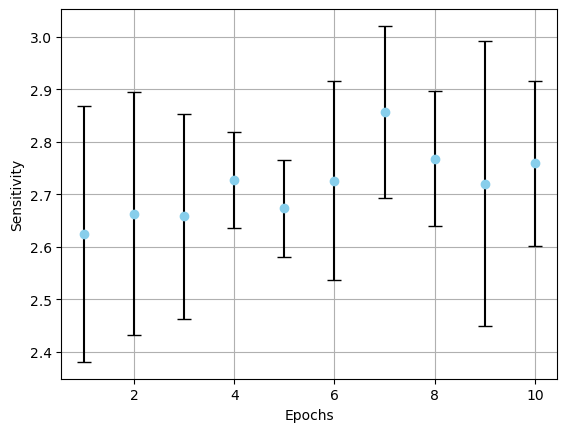

Maximum sensitivity achieved at Epoch 7: 2.857


In [23]:
epoch_list = np.linspace(1, 10, 10).astype(int)
batch_size = 58  
num_iterations_per_epoch = 10  
sensitivities = np.zeros((len(epoch_list), num_iterations_per_epoch))

# Loop over epoch_list to train the model and store sensitivities
for i, epochs in enumerate(epoch_list):
    for k in range(num_iterations_per_epoch):
        sensitivity = model_training(13, 0.005, epochs, 58)[1]
        sensitivities[i, k] = sensitivity

# Calculate mean and standard deviation of sensitivity for each epoch
mean_sensitivities = np.mean(sensitivities, axis=1)
std_sensitivities = np.std(sensitivities, axis=1)

# Find the epoch with the maximum sensitivity
max_sensitivity_index = np.argmax(mean_sensitivities)
max_sensitivity_epoch = epoch_list[max_sensitivity_index]
max_sensitivity_value = mean_sensitivities[max_sensitivity_index]

# Plot the sensitivities with error bars
plt.errorbar(epoch_list, mean_sensitivities, yerr=std_sensitivities, fmt='o', color='skyblue', ecolor='black', capsize=5)
plt.xlabel('Epochs', fontname='Times New Roman')
plt.ylabel('Sensitivity', fontname='Times New Roman')
plt.grid(True)
plt.show()

print("Maximum sensitivity achieved at Epoch {}: {}".format(max_sensitivity_epoch, max_sensitivity_value))


#### Batch Size 

Epoch 1/10
2412/2412 [==============================] - 4s 618us/step - loss: 0.0930 - accuracy: 0.8855
Epoch 2/10
2412/2412 [==============================] - 1s 593us/step - loss: 0.0872 - accuracy: 0.8935
Epoch 3/10
2412/2412 [==============================] - 1s 614us/step - loss: 0.0851 - accuracy: 0.8964
Epoch 4/10
2412/2412 [==============================] - 2s 718us/step - loss: 0.0834 - accuracy: 0.8969
Epoch 5/10
2412/2412 [==============================] - 2s 688us/step - loss: 0.0829 - accuracy: 0.8973
Epoch 6/10
2412/2412 [==============================] - 2s 884us/step - loss: 0.0825 - accuracy: 0.8981
Epoch 7/10
2412/2412 [==============================] - 1s 586us/step - loss: 0.0823 - accuracy: 0.8986
Epoch 8/10
2412/2412 [==============================] - 1s 578us/step - loss: 0.0815 - accuracy: 0.8988
Epoch 9/10
2412/2412 [==============================] - 2s 726us/step - loss: 0.0820 - accuracy: 0.8986
Epoch 10/10
517/517 [==============================] - 0s 292us/

Epoch 1/10
2412/2412 [==============================] - 3s 578us/step - loss: 0.0927 - accuracy: 0.8854
Epoch 2/10
2412/2412 [==============================] - 1s 569us/step - loss: 0.0869 - accuracy: 0.8937
Epoch 3/10
2412/2412 [==============================] - 2s 1ms/step - loss: 0.0851 - accuracy: 0.8954
Epoch 4/10
2412/2412 [==============================] - 1s 591us/step - loss: 0.0833 - accuracy: 0.8974
Epoch 5/10
2412/2412 [==============================] - 1s 592us/step - loss: 0.0831 - accuracy: 0.8979
Epoch 6/10
2412/2412 [==============================] - 1s 594us/step - loss: 0.0827 - accuracy: 0.8984
Epoch 7/10
2412/2412 [==============================] - 2s 720us/step - loss: 0.0820 - accuracy: 0.8979
Epoch 8/10
2412/2412 [==============================] - 2s 679us/step - loss: 0.0816 - accuracy: 0.8992
Epoch 9/10
2412/2412 [==============================] - 2s 670us/step - loss: 0.0817 - accuracy: 0.8997
Epoch 10/10
517/517 [==============================] - 0s 318us/st

Epoch 1/10
2412/2412 [==============================] - 4s 583us/step - loss: 0.0921 - accuracy: 0.8871
Epoch 2/10
2412/2412 [==============================] - 1s 574us/step - loss: 0.0864 - accuracy: 0.8935
Epoch 3/10
2412/2412 [==============================] - 1s 572us/step - loss: 0.0841 - accuracy: 0.8958
Epoch 4/10
2412/2412 [==============================] - 1s 571us/step - loss: 0.0830 - accuracy: 0.8976
Epoch 5/10
2412/2412 [==============================] - 2s 667us/step - loss: 0.0829 - accuracy: 0.8965
Epoch 6/10
2412/2412 [==============================] - 1s 597us/step - loss: 0.0820 - accuracy: 0.8980
Epoch 7/10
2412/2412 [==============================] - 1s 578us/step - loss: 0.0822 - accuracy: 0.8981
Epoch 8/10
2412/2412 [==============================] - 1s 572us/step - loss: 0.0815 - accuracy: 0.8991
Epoch 9/10
2412/2412 [==============================] - 2s 685us/step - loss: 0.0811 - accuracy: 0.8996
Epoch 10/10
517/517 [==============================] - 0s 282us/

Epoch 1/10
2412/2412 [==============================] - 3s 641us/step - loss: 0.0923 - accuracy: 0.8858
Epoch 2/10
2412/2412 [==============================] - 2s 729us/step - loss: 0.0861 - accuracy: 0.8944
Epoch 3/10
2412/2412 [==============================] - 2s 782us/step - loss: 0.0840 - accuracy: 0.8965
Epoch 4/10
2412/2412 [==============================] - 2s 908us/step - loss: 0.0838 - accuracy: 0.8979
Epoch 5/10
2412/2412 [==============================] - 2s 643us/step - loss: 0.0825 - accuracy: 0.8979
Epoch 6/10
2412/2412 [==============================] - 2s 754us/step - loss: 0.0821 - accuracy: 0.8983
Epoch 7/10
2412/2412 [==============================] - 1s 604us/step - loss: 0.0817 - accuracy: 0.8987
Epoch 8/10
2412/2412 [==============================] - 1s 577us/step - loss: 0.0816 - accuracy: 0.8980
Epoch 9/10
2412/2412 [==============================] - 2s 766us/step - loss: 0.0808 - accuracy: 0.8985
Epoch 10/10
517/517 [==============================] - 0s 288us/

Epoch 1/10
2412/2412 [==============================] - 4s 689us/step - loss: 0.0917 - accuracy: 0.8871
Epoch 2/10
2412/2412 [==============================] - 1s 569us/step - loss: 0.0862 - accuracy: 0.8942
Epoch 3/10
2412/2412 [==============================] - 1s 569us/step - loss: 0.0846 - accuracy: 0.8969
Epoch 4/10
2412/2412 [==============================] - 1s 561us/step - loss: 0.0836 - accuracy: 0.8968
Epoch 5/10
2412/2412 [==============================] - 2s 659us/step - loss: 0.0832 - accuracy: 0.8981
Epoch 6/10
2412/2412 [==============================] - 1s 569us/step - loss: 0.0824 - accuracy: 0.8981
Epoch 7/10
2412/2412 [==============================] - 1s 567us/step - loss: 0.0819 - accuracy: 0.8984
Epoch 8/10
2412/2412 [==============================] - 1s 563us/step - loss: 0.0818 - accuracy: 0.8989
Epoch 9/10
2412/2412 [==============================] - 2s 670us/step - loss: 0.0815 - accuracy: 0.8983
Epoch 10/10
517/517 [==============================] - 0s 316us/

Epoch 1/10
2412/2412 [==============================] - 4s 778us/step - loss: 0.0930 - accuracy: 0.8854
Epoch 2/10
2412/2412 [==============================] - 1s 592us/step - loss: 0.0861 - accuracy: 0.8939
Epoch 3/10
2412/2412 [==============================] - 1s 569us/step - loss: 0.0845 - accuracy: 0.8969
Epoch 4/10
2412/2412 [==============================] - 1s 565us/step - loss: 0.0836 - accuracy: 0.8969
Epoch 5/10
2412/2412 [==============================] - 2s 695us/step - loss: 0.0827 - accuracy: 0.8978
Epoch 6/10
2412/2412 [==============================] - 2s 654us/step - loss: 0.0826 - accuracy: 0.8978
Epoch 7/10
2412/2412 [==============================] - 1s 591us/step - loss: 0.0819 - accuracy: 0.8985
Epoch 8/10
2412/2412 [==============================] - 1s 581us/step - loss: 0.0819 - accuracy: 0.8982
Epoch 9/10
2412/2412 [==============================] - 2s 699us/step - loss: 0.0819 - accuracy: 0.8984
Epoch 10/10
517/517 [==============================] - 0s 333us/

Epoch 1/10
2412/2412 [==============================] - 3s 645us/step - loss: 0.0920 - accuracy: 0.8865
Epoch 2/10
2412/2412 [==============================] - 1s 564us/step - loss: 0.0868 - accuracy: 0.8940
Epoch 3/10
2412/2412 [==============================] - 2s 719us/step - loss: 0.0846 - accuracy: 0.8954
Epoch 4/10
2412/2412 [==============================] - 1s 570us/step - loss: 0.0833 - accuracy: 0.8971
Epoch 5/10
2412/2412 [==============================] - 1s 567us/step - loss: 0.0833 - accuracy: 0.8971
Epoch 6/10
2412/2412 [==============================] - 1s 607us/step - loss: 0.0823 - accuracy: 0.8988
Epoch 7/10
2412/2412 [==============================] - 2s 764us/step - loss: 0.0825 - accuracy: 0.8986
Epoch 8/10
2412/2412 [==============================] - 1s 584us/step - loss: 0.0816 - accuracy: 0.8984
Epoch 9/10
2412/2412 [==============================] - 1s 603us/step - loss: 0.0815 - accuracy: 0.8978
Epoch 10/10
517/517 [==============================] - 0s 283us/

Epoch 1/10
2412/2412 [==============================] - 4s 903us/step - loss: 0.0928 - accuracy: 0.8844
Epoch 2/10
2412/2412 [==============================] - 1s 586us/step - loss: 0.0863 - accuracy: 0.8942
Epoch 3/10
2412/2412 [==============================] - 2s 623us/step - loss: 0.0843 - accuracy: 0.8963
Epoch 4/10
2412/2412 [==============================] - 1s 587us/step - loss: 0.0837 - accuracy: 0.8965
Epoch 5/10
2412/2412 [==============================] - 2s 713us/step - loss: 0.0829 - accuracy: 0.8977
Epoch 6/10
2412/2412 [==============================] - 1s 610us/step - loss: 0.0824 - accuracy: 0.8981
Epoch 7/10
2412/2412 [==============================] - 1s 581us/step - loss: 0.0818 - accuracy: 0.8983
Epoch 8/10
2412/2412 [==============================] - 1s 576us/step - loss: 0.0814 - accuracy: 0.8994
Epoch 9/10
2412/2412 [==============================] - 2s 681us/step - loss: 0.0808 - accuracy: 0.8983
Epoch 10/10
517/517 [==============================] - 0s 303us/

Epoch 1/10
2412/2412 [==============================] - 3s 603us/step - loss: 0.0930 - accuracy: 0.8853
Epoch 2/10
2412/2412 [==============================] - 1s 567us/step - loss: 0.0861 - accuracy: 0.8937
Epoch 3/10
2412/2412 [==============================] - 1s 565us/step - loss: 0.0841 - accuracy: 0.8963
Epoch 4/10
2412/2412 [==============================] - 1s 605us/step - loss: 0.0834 - accuracy: 0.8972
Epoch 5/10
2412/2412 [==============================] - 2s 775us/step - loss: 0.0829 - accuracy: 0.8980
Epoch 6/10
2412/2412 [==============================] - 1s 590us/step - loss: 0.0827 - accuracy: 0.8981
Epoch 7/10
2412/2412 [==============================] - 1s 568us/step - loss: 0.0818 - accuracy: 0.8990
Epoch 8/10
2412/2412 [==============================] - 1s 603us/step - loss: 0.0815 - accuracy: 0.8985
Epoch 9/10
2412/2412 [==============================] - 2s 770us/step - loss: 0.0810 - accuracy: 0.8984
Epoch 10/10
517/517 [==============================] - 0s 281us/

Epoch 1/10
2412/2412 [==============================] - 3s 582us/step - loss: 0.0928 - accuracy: 0.8864
Epoch 2/10
2412/2412 [==============================] - 2s 726us/step - loss: 0.0869 - accuracy: 0.8933
Epoch 3/10
2412/2412 [==============================] - 1s 570us/step - loss: 0.0847 - accuracy: 0.8945
Epoch 4/10
2412/2412 [==============================] - 2s 665us/step - loss: 0.0840 - accuracy: 0.8968
Epoch 5/10
2412/2412 [==============================] - 1s 567us/step - loss: 0.0832 - accuracy: 0.8970
Epoch 6/10
2412/2412 [==============================] - 2s 697us/step - loss: 0.0821 - accuracy: 0.8991
Epoch 7/10
2412/2412 [==============================] - 1s 603us/step - loss: 0.0822 - accuracy: 0.8978
Epoch 8/10
2412/2412 [==============================] - 1s 563us/step - loss: 0.0821 - accuracy: 0.8982
Epoch 9/10
2412/2412 [==============================] - 1s 588us/step - loss: 0.0815 - accuracy: 0.8994
Epoch 10/10
517/517 [==============================] - 0s 295us/

Epoch 1/10
603/603 [==============================] - 2s 1ms/step - loss: 0.0909 - accuracy: 0.8863
Epoch 2/10
603/603 [==============================] - 0s 739us/step - loss: 0.0846 - accuracy: 0.8972
Epoch 3/10
603/603 [==============================] - 0s 725us/step - loss: 0.0826 - accuracy: 0.8973
Epoch 4/10
603/603 [==============================] - 0s 732us/step - loss: 0.0820 - accuracy: 0.8981
Epoch 5/10
603/603 [==============================] - 0s 743us/step - loss: 0.0812 - accuracy: 0.9002
Epoch 6/10
603/603 [==============================] - 0s 738us/step - loss: 0.0808 - accuracy: 0.8997
Epoch 7/10
603/603 [==============================] - 0s 774us/step - loss: 0.0803 - accuracy: 0.8991
Epoch 8/10
603/603 [==============================] - 0s 734us/step - loss: 0.0801 - accuracy: 0.8998
Epoch 9/10
603/603 [==============================] - 0s 809us/step - loss: 0.0801 - accuracy: 0.9003
Epoch 10/10
517/517 [==============================] - 0s 281us/step


Epoch 1/10
603/603 [==============================] - 2s 1ms/step - loss: 0.0910 - accuracy: 0.8873
Epoch 2/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0843 - accuracy: 0.8962
Epoch 3/10
603/603 [==============================] - 0s 749us/step - loss: 0.0826 - accuracy: 0.8981
Epoch 4/10
603/603 [==============================] - 0s 742us/step - loss: 0.0819 - accuracy: 0.8980
Epoch 5/10
603/603 [==============================] - 0s 753us/step - loss: 0.0814 - accuracy: 0.8995
Epoch 6/10
603/603 [==============================] - 0s 741us/step - loss: 0.0811 - accuracy: 0.8985
Epoch 7/10
603/603 [==============================] - 0s 743us/step - loss: 0.0803 - accuracy: 0.8998
Epoch 8/10
603/603 [==============================] - 0s 746us/step - loss: 0.0806 - accuracy: 0.8990
Epoch 9/10
603/603 [==============================] - 0s 734us/step - loss: 0.0800 - accuracy: 0.9002
Epoch 10/10
517/517 [==============================] - 0s 285us/step


Epoch 1/10
603/603 [==============================] - 2s 756us/step - loss: 0.0902 - accuracy: 0.8880
Epoch 2/10
603/603 [==============================] - 1s 888us/step - loss: 0.0842 - accuracy: 0.8958
Epoch 3/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0829 - accuracy: 0.8976
Epoch 4/10
603/603 [==============================] - 1s 868us/step - loss: 0.0824 - accuracy: 0.8980
Epoch 5/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0812 - accuracy: 0.8980
Epoch 6/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0813 - accuracy: 0.8999
Epoch 7/10
603/603 [==============================] - 0s 757us/step - loss: 0.0806 - accuracy: 0.8991
Epoch 8/10
603/603 [==============================] - 0s 756us/step - loss: 0.0801 - accuracy: 0.8995
Epoch 9/10
603/603 [==============================] - 0s 754us/step - loss: 0.0798 - accuracy: 0.9003
Epoch 10/10
517/517 [==============================] - 0s 283us/step


Epoch 1/10
603/603 [==============================] - 2s 1ms/step - loss: 0.0906 - accuracy: 0.8865
Epoch 2/10
603/603 [==============================] - 0s 761us/step - loss: 0.0844 - accuracy: 0.8957
Epoch 3/10
603/603 [==============================] - 0s 752us/step - loss: 0.0824 - accuracy: 0.8969
Epoch 4/10
603/603 [==============================] - 0s 760us/step - loss: 0.0823 - accuracy: 0.8977
Epoch 5/10
603/603 [==============================] - 0s 763us/step - loss: 0.0812 - accuracy: 0.8983
Epoch 6/10
603/603 [==============================] - 0s 763us/step - loss: 0.0805 - accuracy: 0.8988
Epoch 7/10
603/603 [==============================] - 0s 770us/step - loss: 0.0806 - accuracy: 0.8987
Epoch 8/10
603/603 [==============================] - 0s 759us/step - loss: 0.0799 - accuracy: 0.9003
Epoch 9/10
603/603 [==============================] - 0s 798us/step - loss: 0.0800 - accuracy: 0.9002
Epoch 10/10
517/517 [==============================] - 0s 284us/step


Epoch 1/10
603/603 [==============================] - 2s 1ms/step - loss: 0.0906 - accuracy: 0.8867
Epoch 2/10
603/603 [==============================] - 0s 762us/step - loss: 0.0850 - accuracy: 0.8961
Epoch 3/10
603/603 [==============================] - 0s 757us/step - loss: 0.0827 - accuracy: 0.8975
Epoch 4/10
603/603 [==============================] - 0s 761us/step - loss: 0.0823 - accuracy: 0.8981
Epoch 5/10
603/603 [==============================] - 0s 769us/step - loss: 0.0810 - accuracy: 0.8994
Epoch 6/10
603/603 [==============================] - 0s 758us/step - loss: 0.0809 - accuracy: 0.8997
Epoch 7/10
603/603 [==============================] - 0s 768us/step - loss: 0.0805 - accuracy: 0.8993
Epoch 8/10
603/603 [==============================] - 0s 759us/step - loss: 0.0799 - accuracy: 0.9005
Epoch 9/10
603/603 [==============================] - 0s 760us/step - loss: 0.0798 - accuracy: 0.9005
Epoch 10/10
517/517 [==============================] - 0s 291us/step


Epoch 1/10
603/603 [==============================] - 2s 1ms/step - loss: 0.0909 - accuracy: 0.8869
Epoch 2/10
603/603 [==============================] - 0s 773us/step - loss: 0.0849 - accuracy: 0.8954
Epoch 3/10
603/603 [==============================] - 0s 766us/step - loss: 0.0829 - accuracy: 0.8976
Epoch 4/10
603/603 [==============================] - 0s 758us/step - loss: 0.0823 - accuracy: 0.8987
Epoch 5/10
603/603 [==============================] - 0s 766us/step - loss: 0.0814 - accuracy: 0.8985
Epoch 6/10
603/603 [==============================] - 0s 759us/step - loss: 0.0811 - accuracy: 0.8991
Epoch 7/10
603/603 [==============================] - 0s 759us/step - loss: 0.0808 - accuracy: 0.8996
Epoch 8/10
603/603 [==============================] - 0s 764us/step - loss: 0.0806 - accuracy: 0.8997
Epoch 9/10
603/603 [==============================] - 0s 762us/step - loss: 0.0801 - accuracy: 0.8994
Epoch 10/10
517/517 [==============================] - 0s 363us/step


Epoch 1/10
603/603 [==============================] - 2s 1ms/step - loss: 0.0907 - accuracy: 0.8859
Epoch 2/10
603/603 [==============================] - 0s 771us/step - loss: 0.0847 - accuracy: 0.8960
Epoch 3/10
603/603 [==============================] - 0s 771us/step - loss: 0.0829 - accuracy: 0.8981
Epoch 4/10
603/603 [==============================] - 0s 765us/step - loss: 0.0818 - accuracy: 0.8982
Epoch 5/10
603/603 [==============================] - 0s 770us/step - loss: 0.0813 - accuracy: 0.8994
Epoch 6/10
603/603 [==============================] - 0s 768us/step - loss: 0.0812 - accuracy: 0.8992
Epoch 7/10
603/603 [==============================] - 0s 766us/step - loss: 0.0807 - accuracy: 0.8991
Epoch 8/10
603/603 [==============================] - 0s 767us/step - loss: 0.0801 - accuracy: 0.8993
Epoch 9/10
603/603 [==============================] - 0s 759us/step - loss: 0.0798 - accuracy: 0.8995
Epoch 10/10
517/517 [==============================] - 0s 287us/step


Epoch 1/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0912 - accuracy: 0.8851
Epoch 2/10
603/603 [==============================] - 0s 769us/step - loss: 0.0848 - accuracy: 0.8956
Epoch 3/10
603/603 [==============================] - 0s 763us/step - loss: 0.0832 - accuracy: 0.8975
Epoch 4/10
603/603 [==============================] - 0s 798us/step - loss: 0.0824 - accuracy: 0.8985
Epoch 5/10
603/603 [==============================] - 0s 755us/step - loss: 0.0814 - accuracy: 0.8986
Epoch 6/10
603/603 [==============================] - 0s 758us/step - loss: 0.0812 - accuracy: 0.8987
Epoch 7/10
603/603 [==============================] - 0s 775us/step - loss: 0.0806 - accuracy: 0.9003
Epoch 8/10
603/603 [==============================] - 0s 794us/step - loss: 0.0805 - accuracy: 0.8998
Epoch 9/10
603/603 [==============================] - 1s 2ms/step - loss: 0.0801 - accuracy: 0.8996
Epoch 10/10
517/517 [==============================] - 1s 925us/step


Epoch 1/10
603/603 [==============================] - 1s 782us/step - loss: 0.0906 - accuracy: 0.8878
Epoch 2/10
603/603 [==============================] - 1s 834us/step - loss: 0.0848 - accuracy: 0.8957
Epoch 3/10
603/603 [==============================] - 0s 828us/step - loss: 0.0828 - accuracy: 0.8970
Epoch 4/10
603/603 [==============================] - 0s 822us/step - loss: 0.0822 - accuracy: 0.8979
Epoch 5/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0815 - accuracy: 0.8987
Epoch 6/10
603/603 [==============================] - 1s 2ms/step - loss: 0.0810 - accuracy: 0.8990
Epoch 7/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0805 - accuracy: 0.8986
Epoch 8/10
603/603 [==============================] - 1s 908us/step - loss: 0.0806 - accuracy: 0.8999
Epoch 9/10
603/603 [==============================] - 1s 881us/step - loss: 0.0799 - accuracy: 0.8999
Epoch 10/10
517/517 [==============================] - 0s 424us/step


Epoch 1/10
603/603 [==============================] - 2s 1ms/step - loss: 0.0901 - accuracy: 0.8887
Epoch 2/10
603/603 [==============================] - 1s 849us/step - loss: 0.0843 - accuracy: 0.8954
Epoch 3/10
603/603 [==============================] - 1s 848us/step - loss: 0.0828 - accuracy: 0.8976
Epoch 4/10
603/603 [==============================] - 0s 742us/step - loss: 0.0818 - accuracy: 0.8979
Epoch 5/10
603/603 [==============================] - 0s 734us/step - loss: 0.0811 - accuracy: 0.8990
Epoch 6/10
603/603 [==============================] - 0s 729us/step - loss: 0.0806 - accuracy: 0.8995
Epoch 7/10
603/603 [==============================] - 0s 731us/step - loss: 0.0806 - accuracy: 0.8995
Epoch 8/10
603/603 [==============================] - 1s 988us/step - loss: 0.0799 - accuracy: 0.9003
Epoch 9/10
603/603 [==============================] - 0s 827us/step - loss: 0.0798 - accuracy: 0.9001
Epoch 10/10
517/517 [==============================] - 0s 291us/step


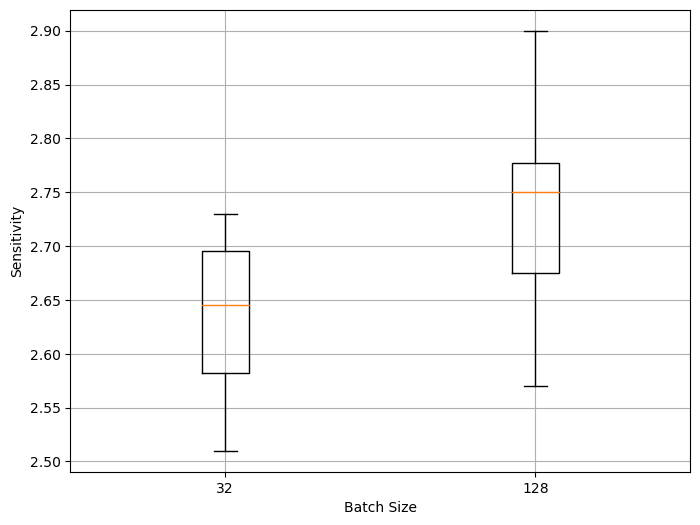

In [26]:

batch_sizes = (32, 128)
num_iterations = 10  

sensitivities_32 = []
sensitivities_128 = []

# Loop over batch sizes
for batch_size in batch_sizes:
    batch_sensitivities = []
    # Run multiple iterations for each batch size
    for _ in range(num_iterations):
        sensitivity = model_training(13, 0.005, 10, batch_size)[1]
        if batch_size == 32:
            sensitivities_32.append(sensitivity)
        else:
            sensitivities_128.append(sensitivity)



# Plotting
plt.figure(figsize=(8, 6))
plt.boxplot([sensitivities_32, sensitivities_128], labels=batch_sizes)
plt.xlabel('Batch Size', fontname='Times New Roman')
plt.ylabel('Sensitivity', fontname='Times New Roman')
plt.grid(True)
plt.show()

## Final Model 

In [11]:
def model_Final(num):
    """
    Create and compile the final neural network model.

    Parameters:
    - num: Number of features
    - learning_rate: Learning rate for the optimizer

    Returns:
    - Compiled Keras model
    - Sensitivity achieved by the model
    """
    variables = ['mBB', 'dRBB', 'pTB1', 'pTB2', 'pTV', 'Mtop', 'mTW', 'MET', 'dYWH', 'dPhiVBB', 'MV1cB1_cont', 'MV1cB2_cont', 'nTrackJetsOR']


    (x_train, y_train, w_train, dset_val, dset_test) = scale_prepare_data(df_train, df_val, df_test, variables, scaler='standard')
    selected_variables = best_pca(x_train, variables, num)


    (x_train, y_train, w_train, dset_val, dset_test) = scale_prepare_data(df_train, df_val, df_test, selected_variables, scaler='standard')


    model = Sequential()


    model.add(Dense(units=120, input_dim=num, activation='relu'))


    model.add(Dense(65, activation='relu'))
    model.add(Dense(49, activation='relu'))
    model.add(Dense(14, activation='relu'))

    model.add(Dense(units=1, activation='sigmoid'))


    optimizer = Nadam(learning_rate=0.005)
    model.compile(loss='BinaryFocalCrossentropy', optimizer=optimizer, metrics=['accuracy'])
    

    history = model.fit(x_train, y_train, sample_weight=w_train, epochs=10, batch_size=128, verbose=0)


    df_test['decision_value'] = model.predict(dset_test[0])
    sensitivity = round(sensitivity_NN(df_test)[0], 2)

    return model, sensitivity

517/517 [==============================] - 0s 303us/step
(<keras.src.engine.sequential.Sequential object at 0x2c3f33010>, 3.03)


### Investigating variability

Epoch 1/10
603/603 [==============================] - 1s 792us/step - loss: 0.0911 - accuracy: 0.8868
Epoch 2/10
603/603 [==============================] - 0s 795us/step - loss: 0.0844 - accuracy: 0.8966
Epoch 3/10
603/603 [==============================] - 0s 785us/step - loss: 0.0832 - accuracy: 0.8977
Epoch 4/10
603/603 [==============================] - 0s 769us/step - loss: 0.0821 - accuracy: 0.8985
Epoch 5/10
603/603 [==============================] - 1s 835us/step - loss: 0.0812 - accuracy: 0.8989
Epoch 6/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0809 - accuracy: 0.8999
Epoch 7/10
603/603 [==============================] - 0s 779us/step - loss: 0.0805 - accuracy: 0.8997
Epoch 8/10
603/603 [==============================] - 0s 768us/step - loss: 0.0800 - accuracy: 0.9005
Epoch 9/10
603/603 [==============================] - 0s 780us/step - loss: 0.0797 - accuracy: 0.9007
Epoch 10/10
517/517 [==============================] - 0s 301us/step


Epoch 1/10
603/603 [==============================] - 1s 796us/step - loss: 0.0913 - accuracy: 0.8857
Epoch 2/10
603/603 [==============================] - 0s 786us/step - loss: 0.0843 - accuracy: 0.8963
Epoch 3/10
603/603 [==============================] - 0s 785us/step - loss: 0.0829 - accuracy: 0.8979
Epoch 4/10
603/603 [==============================] - 0s 785us/step - loss: 0.0821 - accuracy: 0.8976
Epoch 5/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0814 - accuracy: 0.8991
Epoch 6/10
603/603 [==============================] - 0s 788us/step - loss: 0.0811 - accuracy: 0.8993
Epoch 7/10
603/603 [==============================] - 0s 805us/step - loss: 0.0805 - accuracy: 0.9001
Epoch 8/10
603/603 [==============================] - 0s 784us/step - loss: 0.0803 - accuracy: 0.8993
Epoch 9/10
603/603 [==============================] - 0s 781us/step - loss: 0.0800 - accuracy: 0.9001
Epoch 10/10
517/517 [==============================] - 0s 303us/step


Epoch 1/10
603/603 [==============================] - 1s 797us/step - loss: 0.0911 - accuracy: 0.8873
Epoch 2/10
603/603 [==============================] - 0s 786us/step - loss: 0.0848 - accuracy: 0.8960
Epoch 3/10
603/603 [==============================] - 0s 775us/step - loss: 0.0828 - accuracy: 0.8965
Epoch 4/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0821 - accuracy: 0.8977
Epoch 5/10
603/603 [==============================] - 0s 772us/step - loss: 0.0814 - accuracy: 0.8980
Epoch 6/10
603/603 [==============================] - 0s 776us/step - loss: 0.0809 - accuracy: 0.8989
Epoch 7/10
603/603 [==============================] - 0s 765us/step - loss: 0.0808 - accuracy: 0.8994
Epoch 8/10
603/603 [==============================] - 0s 774us/step - loss: 0.0803 - accuracy: 0.8992
Epoch 9/10
603/603 [==============================] - 0s 776us/step - loss: 0.0798 - accuracy: 0.8995
Epoch 10/10
517/517 [==============================] - 0s 301us/step


Epoch 1/10
603/603 [==============================] - 1s 800us/step - loss: 0.0912 - accuracy: 0.8860
Epoch 2/10
603/603 [==============================] - 0s 781us/step - loss: 0.0840 - accuracy: 0.8966
Epoch 3/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0827 - accuracy: 0.8970
Epoch 4/10
603/603 [==============================] - 0s 806us/step - loss: 0.0821 - accuracy: 0.8983
Epoch 5/10
603/603 [==============================] - 0s 771us/step - loss: 0.0815 - accuracy: 0.8988
Epoch 6/10
603/603 [==============================] - 0s 777us/step - loss: 0.0812 - accuracy: 0.8979
Epoch 7/10
603/603 [==============================] - 0s 776us/step - loss: 0.0806 - accuracy: 0.8992
Epoch 8/10
603/603 [==============================] - 0s 781us/step - loss: 0.0800 - accuracy: 0.8993
Epoch 9/10
603/603 [==============================] - 0s 778us/step - loss: 0.0802 - accuracy: 0.8997
Epoch 10/10
517/517 [==============================] - 0s 302us/step


Epoch 1/10
603/603 [==============================] - 1s 798us/step - loss: 0.0905 - accuracy: 0.8885
Epoch 2/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0843 - accuracy: 0.8963
Epoch 3/10
603/603 [==============================] - 0s 774us/step - loss: 0.0826 - accuracy: 0.8985
Epoch 4/10
603/603 [==============================] - 0s 773us/step - loss: 0.0821 - accuracy: 0.8981
Epoch 5/10
603/603 [==============================] - 0s 777us/step - loss: 0.0814 - accuracy: 0.8987
Epoch 6/10
603/603 [==============================] - 0s 772us/step - loss: 0.0809 - accuracy: 0.8988
Epoch 7/10
603/603 [==============================] - 0s 774us/step - loss: 0.0805 - accuracy: 0.8990
Epoch 8/10
603/603 [==============================] - 0s 768us/step - loss: 0.0801 - accuracy: 0.8996
Epoch 9/10
603/603 [==============================] - 0s 778us/step - loss: 0.0794 - accuracy: 0.8998
Epoch 10/10
517/517 [==============================] - 0s 304us/step


Epoch 1/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0911 - accuracy: 0.8861
Epoch 2/10
603/603 [==============================] - 0s 775us/step - loss: 0.0841 - accuracy: 0.8958
Epoch 3/10
603/603 [==============================] - 0s 775us/step - loss: 0.0829 - accuracy: 0.8982
Epoch 4/10
603/603 [==============================] - 0s 774us/step - loss: 0.0819 - accuracy: 0.8987
Epoch 5/10
603/603 [==============================] - 0s 775us/step - loss: 0.0813 - accuracy: 0.8989
Epoch 6/10
603/603 [==============================] - 0s 783us/step - loss: 0.0807 - accuracy: 0.8991
Epoch 7/10
603/603 [==============================] - 0s 774us/step - loss: 0.0806 - accuracy: 0.8997
Epoch 8/10
603/603 [==============================] - 0s 778us/step - loss: 0.0801 - accuracy: 0.8995
Epoch 9/10
603/603 [==============================] - 0s 773us/step - loss: 0.0796 - accuracy: 0.9006
Epoch 10/10
517/517 [==============================] - 0s 320us/step


Epoch 1/10
603/603 [==============================] - 1s 805us/step - loss: 0.0908 - accuracy: 0.8862
Epoch 2/10
603/603 [==============================] - 0s 784us/step - loss: 0.0847 - accuracy: 0.8961
Epoch 3/10
603/603 [==============================] - 0s 779us/step - loss: 0.0830 - accuracy: 0.8975
Epoch 4/10
603/603 [==============================] - 0s 783us/step - loss: 0.0822 - accuracy: 0.8981
Epoch 5/10
603/603 [==============================] - 0s 776us/step - loss: 0.0817 - accuracy: 0.8989
Epoch 6/10
603/603 [==============================] - 0s 780us/step - loss: 0.0807 - accuracy: 0.8991
Epoch 7/10
603/603 [==============================] - 0s 777us/step - loss: 0.0807 - accuracy: 0.8991
Epoch 8/10
603/603 [==============================] - 0s 777us/step - loss: 0.0801 - accuracy: 0.9003
Epoch 9/10
603/603 [==============================] - 0s 778us/step - loss: 0.0799 - accuracy: 0.8998
Epoch 10/10
517/517 [==============================] - 0s 305us/step


Epoch 1/10
603/603 [==============================] - 1s 800us/step - loss: 0.0911 - accuracy: 0.8863
Epoch 2/10
603/603 [==============================] - 0s 784us/step - loss: 0.0843 - accuracy: 0.8952
Epoch 3/10
603/603 [==============================] - 0s 779us/step - loss: 0.0832 - accuracy: 0.8969
Epoch 4/10
603/603 [==============================] - 0s 780us/step - loss: 0.0822 - accuracy: 0.8988
Epoch 5/10
603/603 [==============================] - 0s 785us/step - loss: 0.0812 - accuracy: 0.8995
Epoch 6/10
603/603 [==============================] - 0s 783us/step - loss: 0.0807 - accuracy: 0.8987
Epoch 7/10
603/603 [==============================] - 0s 780us/step - loss: 0.0807 - accuracy: 0.8988
Epoch 8/10
603/603 [==============================] - 0s 777us/step - loss: 0.0801 - accuracy: 0.8993
Epoch 9/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0796 - accuracy: 0.9001
Epoch 10/10
517/517 [==============================] - 0s 302us/step


Epoch 1/10
603/603 [==============================] - 1s 818us/step - loss: 0.0912 - accuracy: 0.8858
Epoch 2/10
603/603 [==============================] - 0s 791us/step - loss: 0.0843 - accuracy: 0.8967
Epoch 3/10
603/603 [==============================] - 0s 789us/step - loss: 0.0828 - accuracy: 0.8980
Epoch 4/10
603/603 [==============================] - 0s 783us/step - loss: 0.0819 - accuracy: 0.8987
Epoch 5/10
603/603 [==============================] - 0s 789us/step - loss: 0.0815 - accuracy: 0.8989
Epoch 6/10
603/603 [==============================] - 0s 785us/step - loss: 0.0806 - accuracy: 0.8994
Epoch 7/10
603/603 [==============================] - 0s 792us/step - loss: 0.0806 - accuracy: 0.8987
Epoch 8/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0804 - accuracy: 0.9000
Epoch 9/10
603/603 [==============================] - 0s 792us/step - loss: 0.0800 - accuracy: 0.8993
Epoch 10/10
517/517 [==============================] - 0s 303us/step


Epoch 1/10
603/603 [==============================] - 1s 800us/step - loss: 0.0911 - accuracy: 0.8880
Epoch 2/10
603/603 [==============================] - 0s 776us/step - loss: 0.0844 - accuracy: 0.8960
Epoch 3/10
603/603 [==============================] - 0s 784us/step - loss: 0.0828 - accuracy: 0.8981
Epoch 4/10
603/603 [==============================] - 0s 797us/step - loss: 0.0822 - accuracy: 0.8980
Epoch 5/10
603/603 [==============================] - 0s 781us/step - loss: 0.0814 - accuracy: 0.8988
Epoch 6/10
603/603 [==============================] - 0s 784us/step - loss: 0.0812 - accuracy: 0.8980
Epoch 7/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0808 - accuracy: 0.8998
Epoch 8/10
603/603 [==============================] - 0s 783us/step - loss: 0.0805 - accuracy: 0.8998
Epoch 9/10
603/603 [==============================] - 0s 780us/step - loss: 0.0802 - accuracy: 0.8995
Epoch 10/10
517/517 [==============================] - 0s 289us/step


Epoch 1/10
603/603 [==============================] - 1s 812us/step - loss: 0.0916 - accuracy: 0.8871
Epoch 2/10
603/603 [==============================] - 0s 777us/step - loss: 0.0845 - accuracy: 0.8965
Epoch 3/10
603/603 [==============================] - 0s 776us/step - loss: 0.0831 - accuracy: 0.8980
Epoch 4/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0819 - accuracy: 0.8990
Epoch 5/10
603/603 [==============================] - 0s 780us/step - loss: 0.0814 - accuracy: 0.8984
Epoch 6/10
603/603 [==============================] - 0s 776us/step - loss: 0.0810 - accuracy: 0.9000
Epoch 7/10
603/603 [==============================] - 0s 771us/step - loss: 0.0803 - accuracy: 0.8999
Epoch 8/10
603/603 [==============================] - 0s 779us/step - loss: 0.0802 - accuracy: 0.8999
Epoch 9/10
603/603 [==============================] - 0s 800us/step - loss: 0.0800 - accuracy: 0.8998
Epoch 10/10
517/517 [==============================] - 0s 304us/step


Epoch 1/10
603/603 [==============================] - 1s 813us/step - loss: 0.0913 - accuracy: 0.8869
Epoch 2/10
603/603 [==============================] - 0s 793us/step - loss: 0.0846 - accuracy: 0.8954
Epoch 3/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0834 - accuracy: 0.8973
Epoch 4/10
603/603 [==============================] - 0s 800us/step - loss: 0.0822 - accuracy: 0.8980
Epoch 5/10
603/603 [==============================] - 0s 798us/step - loss: 0.0816 - accuracy: 0.8981
Epoch 6/10
603/603 [==============================] - 0s 798us/step - loss: 0.0808 - accuracy: 0.8999
Epoch 7/10
603/603 [==============================] - 0s 794us/step - loss: 0.0811 - accuracy: 0.8991
Epoch 8/10
603/603 [==============================] - 1s 858us/step - loss: 0.0804 - accuracy: 0.8993
Epoch 9/10
603/603 [==============================] - 0s 797us/step - loss: 0.0802 - accuracy: 0.9005
Epoch 10/10
517/517 [==============================] - 0s 301us/step


Epoch 1/10
603/603 [==============================] - 14s 875us/step - loss: 0.0910 - accuracy: 0.8884
Epoch 2/10
603/603 [==============================] - 0s 818us/step - loss: 0.0840 - accuracy: 0.8967
Epoch 3/10
603/603 [==============================] - 1s 832us/step - loss: 0.0824 - accuracy: 0.8975
Epoch 4/10
603/603 [==============================] - 0s 813us/step - loss: 0.0817 - accuracy: 0.8979
Epoch 5/10
603/603 [==============================] - 0s 804us/step - loss: 0.0812 - accuracy: 0.8988
Epoch 6/10
603/603 [==============================] - 0s 801us/step - loss: 0.0810 - accuracy: 0.8987
Epoch 7/10
603/603 [==============================] - 0s 808us/step - loss: 0.0805 - accuracy: 0.8986
Epoch 8/10
603/603 [==============================] - 0s 802us/step - loss: 0.0802 - accuracy: 0.9000
Epoch 9/10
603/603 [==============================] - 0s 803us/step - loss: 0.0797 - accuracy: 0.9005
Epoch 10/10
517/517 [==============================] - 0s 320us/step


Epoch 1/10
603/603 [==============================] - 1s 842us/step - loss: 0.0911 - accuracy: 0.8876
Epoch 2/10
603/603 [==============================] - 0s 823us/step - loss: 0.0853 - accuracy: 0.8950
Epoch 3/10
603/603 [==============================] - 0s 817us/step - loss: 0.0828 - accuracy: 0.8977
Epoch 4/10
603/603 [==============================] - 0s 821us/step - loss: 0.0819 - accuracy: 0.8979
Epoch 5/10
603/603 [==============================] - 0s 815us/step - loss: 0.0817 - accuracy: 0.8980
Epoch 6/10
603/603 [==============================] - 0s 810us/step - loss: 0.0809 - accuracy: 0.8982
Epoch 7/10
603/603 [==============================] - 1s 834us/step - loss: 0.0805 - accuracy: 0.9001
Epoch 8/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0803 - accuracy: 0.8989
Epoch 9/10
603/603 [==============================] - 0s 822us/step - loss: 0.0796 - accuracy: 0.8998
Epoch 10/10
517/517 [==============================] - 0s 338us/step


Epoch 1/10
603/603 [==============================] - 1s 850us/step - loss: 0.0904 - accuracy: 0.8878
Epoch 2/10
603/603 [==============================] - 0s 817us/step - loss: 0.0845 - accuracy: 0.8967
Epoch 3/10
603/603 [==============================] - 0s 811us/step - loss: 0.0829 - accuracy: 0.8976
Epoch 4/10
603/603 [==============================] - 0s 808us/step - loss: 0.0821 - accuracy: 0.8981
Epoch 5/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0818 - accuracy: 0.8992
Epoch 6/10
603/603 [==============================] - 1s 836us/step - loss: 0.0815 - accuracy: 0.8992
Epoch 7/10
603/603 [==============================] - 0s 804us/step - loss: 0.0801 - accuracy: 0.9003
Epoch 8/10
603/603 [==============================] - 0s 818us/step - loss: 0.0801 - accuracy: 0.8995
Epoch 9/10
603/603 [==============================] - 0s 803us/step - loss: 0.0799 - accuracy: 0.9002
Epoch 10/10
517/517 [==============================] - 0s 340us/step


Epoch 1/10
603/603 [==============================] - 1s 821us/step - loss: 0.0908 - accuracy: 0.8865
Epoch 2/10
603/603 [==============================] - 0s 813us/step - loss: 0.0845 - accuracy: 0.8949
Epoch 3/10
603/603 [==============================] - 0s 808us/step - loss: 0.0831 - accuracy: 0.8971
Epoch 4/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0820 - accuracy: 0.8976
Epoch 5/10
603/603 [==============================] - 0s 820us/step - loss: 0.0818 - accuracy: 0.8981
Epoch 6/10
603/603 [==============================] - 1s 906us/step - loss: 0.0810 - accuracy: 0.8991
Epoch 7/10
603/603 [==============================] - 0s 805us/step - loss: 0.0809 - accuracy: 0.8989
Epoch 8/10
603/603 [==============================] - 0s 806us/step - loss: 0.0804 - accuracy: 0.8993
Epoch 9/10
603/603 [==============================] - 0s 826us/step - loss: 0.0802 - accuracy: 0.8983
Epoch 10/10
517/517 [==============================] - 0s 318us/step


Epoch 1/10
603/603 [==============================] - 1s 834us/step - loss: 0.0912 - accuracy: 0.8880
Epoch 2/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0845 - accuracy: 0.8958
Epoch 3/10
603/603 [==============================] - 0s 804us/step - loss: 0.0832 - accuracy: 0.8974
Epoch 4/10
603/603 [==============================] - 0s 811us/step - loss: 0.0822 - accuracy: 0.8973
Epoch 5/10
603/603 [==============================] - 0s 803us/step - loss: 0.0820 - accuracy: 0.8988
Epoch 6/10
603/603 [==============================] - 0s 807us/step - loss: 0.0811 - accuracy: 0.8987
Epoch 7/10
603/603 [==============================] - 0s 803us/step - loss: 0.0807 - accuracy: 0.8992
Epoch 8/10
603/603 [==============================] - 0s 802us/step - loss: 0.0806 - accuracy: 0.8997
Epoch 9/10
603/603 [==============================] - 0s 807us/step - loss: 0.0799 - accuracy: 0.8997
Epoch 10/10
517/517 [==============================] - 0s 310us/step


Epoch 1/10
603/603 [==============================] - 2s 1ms/step - loss: 0.0906 - accuracy: 0.8870
Epoch 2/10
603/603 [==============================] - 1s 833us/step - loss: 0.0841 - accuracy: 0.8958
Epoch 3/10
603/603 [==============================] - 0s 804us/step - loss: 0.0829 - accuracy: 0.8976
Epoch 4/10
603/603 [==============================] - 0s 808us/step - loss: 0.0822 - accuracy: 0.8981
Epoch 5/10
603/603 [==============================] - 0s 799us/step - loss: 0.0817 - accuracy: 0.8982
Epoch 6/10
603/603 [==============================] - 0s 804us/step - loss: 0.0811 - accuracy: 0.8989
Epoch 7/10
603/603 [==============================] - 0s 808us/step - loss: 0.0808 - accuracy: 0.8988
Epoch 8/10
603/603 [==============================] - 0s 813us/step - loss: 0.0804 - accuracy: 0.9003
Epoch 9/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0800 - accuracy: 0.8995
Epoch 10/10
517/517 [==============================] - 0s 312us/step


Epoch 1/10
603/603 [==============================] - 1s 811us/step - loss: 0.0910 - accuracy: 0.8855
Epoch 2/10
603/603 [==============================] - 0s 796us/step - loss: 0.0842 - accuracy: 0.8960
Epoch 3/10
603/603 [==============================] - 0s 792us/step - loss: 0.0829 - accuracy: 0.8971
Epoch 4/10
603/603 [==============================] - 0s 800us/step - loss: 0.0826 - accuracy: 0.8983
Epoch 5/10
603/603 [==============================] - 0s 793us/step - loss: 0.0814 - accuracy: 0.8987
Epoch 6/10
603/603 [==============================] - 0s 789us/step - loss: 0.0812 - accuracy: 0.8987
Epoch 7/10
603/603 [==============================] - 0s 791us/step - loss: 0.0806 - accuracy: 0.8991
Epoch 8/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0805 - accuracy: 0.9001
Epoch 9/10
603/603 [==============================] - 0s 791us/step - loss: 0.0799 - accuracy: 0.9005
Epoch 10/10
517/517 [==============================] - 0s 312us/step


Epoch 1/10
603/603 [==============================] - 1s 838us/step - loss: 0.0913 - accuracy: 0.8852
Epoch 2/10
603/603 [==============================] - 0s 799us/step - loss: 0.0845 - accuracy: 0.8963
Epoch 3/10
603/603 [==============================] - 0s 795us/step - loss: 0.0832 - accuracy: 0.8971
Epoch 4/10
603/603 [==============================] - 0s 804us/step - loss: 0.0816 - accuracy: 0.8991
Epoch 5/10
603/603 [==============================] - 0s 790us/step - loss: 0.0814 - accuracy: 0.8992
Epoch 6/10
603/603 [==============================] - 0s 789us/step - loss: 0.0807 - accuracy: 0.8983
Epoch 7/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0804 - accuracy: 0.8997
Epoch 8/10
603/603 [==============================] - 0s 797us/step - loss: 0.0802 - accuracy: 0.8993
Epoch 9/10
603/603 [==============================] - 0s 795us/step - loss: 0.0800 - accuracy: 0.8996
Epoch 10/10
517/517 [==============================] - 0s 310us/step


Epoch 1/10
603/603 [==============================] - 1s 861us/step - loss: 0.0917 - accuracy: 0.8865
Epoch 2/10
603/603 [==============================] - 0s 809us/step - loss: 0.0842 - accuracy: 0.8976
Epoch 3/10
603/603 [==============================] - 0s 810us/step - loss: 0.0824 - accuracy: 0.8975
Epoch 4/10
603/603 [==============================] - 0s 796us/step - loss: 0.0817 - accuracy: 0.8985
Epoch 5/10
603/603 [==============================] - 0s 803us/step - loss: 0.0810 - accuracy: 0.8989
Epoch 6/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0809 - accuracy: 0.8993
Epoch 7/10
603/603 [==============================] - 0s 806us/step - loss: 0.0805 - accuracy: 0.8996
Epoch 8/10
603/603 [==============================] - 0s 806us/step - loss: 0.0799 - accuracy: 0.8990
Epoch 9/10
603/603 [==============================] - 0s 802us/step - loss: 0.0799 - accuracy: 0.9001
Epoch 10/10
517/517 [==============================] - 0s 305us/step


Epoch 1/10
603/603 [==============================] - 1s 808us/step - loss: 0.0916 - accuracy: 0.8862
Epoch 2/10
603/603 [==============================] - 0s 786us/step - loss: 0.0846 - accuracy: 0.8960
Epoch 3/10
603/603 [==============================] - 0s 790us/step - loss: 0.0827 - accuracy: 0.8971
Epoch 4/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0817 - accuracy: 0.8976
Epoch 5/10
603/603 [==============================] - 0s 807us/step - loss: 0.0813 - accuracy: 0.8994
Epoch 6/10
603/603 [==============================] - 0s 803us/step - loss: 0.0813 - accuracy: 0.8981
Epoch 7/10
603/603 [==============================] - 0s 779us/step - loss: 0.0808 - accuracy: 0.8991
Epoch 8/10
603/603 [==============================] - 0s 782us/step - loss: 0.0801 - accuracy: 0.9001
Epoch 9/10
603/603 [==============================] - 1s 843us/step - loss: 0.0804 - accuracy: 0.9002
Epoch 10/10
517/517 [==============================] - 0s 303us/step


Epoch 1/10
603/603 [==============================] - 1s 816us/step - loss: 0.0921 - accuracy: 0.8859
Epoch 2/10
603/603 [==============================] - 0s 786us/step - loss: 0.0843 - accuracy: 0.8961
Epoch 3/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0827 - accuracy: 0.8973
Epoch 4/10
603/603 [==============================] - 0s 797us/step - loss: 0.0818 - accuracy: 0.8983
Epoch 5/10
603/603 [==============================] - 0s 793us/step - loss: 0.0815 - accuracy: 0.8984
Epoch 6/10
603/603 [==============================] - 0s 785us/step - loss: 0.0808 - accuracy: 0.8988
Epoch 7/10
603/603 [==============================] - 0s 794us/step - loss: 0.0805 - accuracy: 0.8984
Epoch 8/10
603/603 [==============================] - 0s 791us/step - loss: 0.0803 - accuracy: 0.8999
Epoch 9/10
603/603 [==============================] - 0s 800us/step - loss: 0.0801 - accuracy: 0.8996
Epoch 10/10
517/517 [==============================] - 0s 308us/step


Epoch 1/10
603/603 [==============================] - 1s 948us/step - loss: 0.0910 - accuracy: 0.8886
Epoch 2/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0848 - accuracy: 0.8960
Epoch 3/10
603/603 [==============================] - 0s 805us/step - loss: 0.0830 - accuracy: 0.8974
Epoch 4/10
603/603 [==============================] - 0s 783us/step - loss: 0.0821 - accuracy: 0.8980
Epoch 5/10
603/603 [==============================] - 0s 787us/step - loss: 0.0817 - accuracy: 0.8989
Epoch 6/10
603/603 [==============================] - 0s 782us/step - loss: 0.0807 - accuracy: 0.8994
Epoch 7/10
603/603 [==============================] - 0s 783us/step - loss: 0.0802 - accuracy: 0.8996
Epoch 8/10
603/603 [==============================] - 0s 790us/step - loss: 0.0802 - accuracy: 0.8992
Epoch 9/10
603/603 [==============================] - 0s 780us/step - loss: 0.0798 - accuracy: 0.8996
Epoch 10/10
517/517 [==============================] - 0s 307us/step


Epoch 1/10
603/603 [==============================] - 2s 1ms/step - loss: 0.0908 - accuracy: 0.8871
Epoch 2/10
603/603 [==============================] - 0s 784us/step - loss: 0.0843 - accuracy: 0.8955
Epoch 3/10
603/603 [==============================] - 0s 784us/step - loss: 0.0830 - accuracy: 0.8972
Epoch 4/10
603/603 [==============================] - 0s 782us/step - loss: 0.0817 - accuracy: 0.8977
Epoch 5/10
603/603 [==============================] - 0s 787us/step - loss: 0.0815 - accuracy: 0.8986
Epoch 6/10
603/603 [==============================] - 0s 778us/step - loss: 0.0811 - accuracy: 0.8988
Epoch 7/10
603/603 [==============================] - 0s 785us/step - loss: 0.0806 - accuracy: 0.8997
Epoch 8/10
603/603 [==============================] - 0s 771us/step - loss: 0.0802 - accuracy: 0.8994
Epoch 9/10
603/603 [==============================] - 0s 777us/step - loss: 0.0797 - accuracy: 0.8999
Epoch 10/10
517/517 [==============================] - 0s 611us/step


Epoch 1/10
603/603 [==============================] - 1s 814us/step - loss: 0.0913 - accuracy: 0.8859
Epoch 2/10
603/603 [==============================] - 0s 788us/step - loss: 0.0843 - accuracy: 0.8965
Epoch 3/10
603/603 [==============================] - 0s 786us/step - loss: 0.0830 - accuracy: 0.8981
Epoch 4/10
603/603 [==============================] - 0s 776us/step - loss: 0.0817 - accuracy: 0.8978
Epoch 5/10
603/603 [==============================] - 0s 790us/step - loss: 0.0814 - accuracy: 0.8988
Epoch 6/10
603/603 [==============================] - 0s 780us/step - loss: 0.0809 - accuracy: 0.8983
Epoch 7/10
603/603 [==============================] - 0s 782us/step - loss: 0.0807 - accuracy: 0.8994
Epoch 8/10
603/603 [==============================] - 0s 787us/step - loss: 0.0802 - accuracy: 0.8994
Epoch 9/10
603/603 [==============================] - 0s 777us/step - loss: 0.0797 - accuracy: 0.9000
Epoch 10/10
517/517 [==============================] - 0s 304us/step


Epoch 1/10
603/603 [==============================] - 1s 801us/step - loss: 0.0908 - accuracy: 0.8865
Epoch 2/10
603/603 [==============================] - 0s 790us/step - loss: 0.0846 - accuracy: 0.8955
Epoch 3/10
603/603 [==============================] - 0s 804us/step - loss: 0.0831 - accuracy: 0.8976
Epoch 4/10
603/603 [==============================] - 0s 794us/step - loss: 0.0821 - accuracy: 0.8976
Epoch 5/10
603/603 [==============================] - 0s 786us/step - loss: 0.0814 - accuracy: 0.8986
Epoch 6/10
603/603 [==============================] - 0s 788us/step - loss: 0.0810 - accuracy: 0.8990
Epoch 7/10
603/603 [==============================] - 0s 780us/step - loss: 0.0812 - accuracy: 0.8987
Epoch 8/10
603/603 [==============================] - 0s 786us/step - loss: 0.0805 - accuracy: 0.9001
Epoch 9/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0797 - accuracy: 0.9004
Epoch 10/10
517/517 [==============================] - 0s 303us/step


Epoch 1/10
603/603 [==============================] - 1s 798us/step - loss: 0.0918 - accuracy: 0.8864
Epoch 2/10
603/603 [==============================] - 0s 780us/step - loss: 0.0841 - accuracy: 0.8969
Epoch 3/10
603/603 [==============================] - 1s 835us/step - loss: 0.0829 - accuracy: 0.8978
Epoch 4/10
603/603 [==============================] - 0s 782us/step - loss: 0.0820 - accuracy: 0.8983
Epoch 5/10
603/603 [==============================] - 0s 793us/step - loss: 0.0810 - accuracy: 0.8989
Epoch 6/10
603/603 [==============================] - 0s 780us/step - loss: 0.0807 - accuracy: 0.8996
Epoch 7/10
603/603 [==============================] - 0s 785us/step - loss: 0.0803 - accuracy: 0.9001
Epoch 8/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0800 - accuracy: 0.9003
Epoch 9/10
603/603 [==============================] - 0s 776us/step - loss: 0.0796 - accuracy: 0.8998
Epoch 10/10
517/517 [==============================] - 0s 301us/step


Epoch 1/10
603/603 [==============================] - 1s 806us/step - loss: 0.0912 - accuracy: 0.8867
Epoch 2/10
603/603 [==============================] - 0s 789us/step - loss: 0.0840 - accuracy: 0.8962
Epoch 3/10
603/603 [==============================] - 0s 782us/step - loss: 0.0826 - accuracy: 0.8982
Epoch 4/10
603/603 [==============================] - 0s 786us/step - loss: 0.0817 - accuracy: 0.8986
Epoch 5/10
603/603 [==============================] - 0s 785us/step - loss: 0.0811 - accuracy: 0.8993
Epoch 6/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0805 - accuracy: 0.8996
Epoch 7/10
603/603 [==============================] - 1s 853us/step - loss: 0.0803 - accuracy: 0.9003
Epoch 8/10
603/603 [==============================] - 0s 793us/step - loss: 0.0804 - accuracy: 0.9000
Epoch 9/10
603/603 [==============================] - 0s 775us/step - loss: 0.0797 - accuracy: 0.8998
Epoch 10/10
517/517 [==============================] - 0s 301us/step


Epoch 1/10
603/603 [==============================] - 1s 805us/step - loss: 0.0914 - accuracy: 0.8863
Epoch 2/10
603/603 [==============================] - 0s 805us/step - loss: 0.0845 - accuracy: 0.8958
Epoch 3/10
603/603 [==============================] - 0s 771us/step - loss: 0.0828 - accuracy: 0.8975
Epoch 4/10
603/603 [==============================] - 0s 778us/step - loss: 0.0818 - accuracy: 0.8984
Epoch 5/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0812 - accuracy: 0.8997
Epoch 6/10
603/603 [==============================] - 1s 840us/step - loss: 0.0807 - accuracy: 0.9000
Epoch 7/10
603/603 [==============================] - 0s 773us/step - loss: 0.0807 - accuracy: 0.9000
Epoch 8/10
603/603 [==============================] - 0s 781us/step - loss: 0.0800 - accuracy: 0.8999
Epoch 9/10
603/603 [==============================] - 0s 781us/step - loss: 0.0802 - accuracy: 0.9001
Epoch 10/10
517/517 [==============================] - 0s 305us/step


Epoch 1/10
603/603 [==============================] - 1s 806us/step - loss: 0.0911 - accuracy: 0.8865
Epoch 2/10
603/603 [==============================] - 0s 805us/step - loss: 0.0847 - accuracy: 0.8967
Epoch 3/10
603/603 [==============================] - 0s 783us/step - loss: 0.0829 - accuracy: 0.8975
Epoch 4/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0817 - accuracy: 0.8996
Epoch 5/10
603/603 [==============================] - 0s 785us/step - loss: 0.0816 - accuracy: 0.8982
Epoch 6/10
603/603 [==============================] - 0s 789us/step - loss: 0.0813 - accuracy: 0.8990
Epoch 7/10
603/603 [==============================] - 0s 778us/step - loss: 0.0806 - accuracy: 0.8997
Epoch 8/10
603/603 [==============================] - 0s 801us/step - loss: 0.0803 - accuracy: 0.8996
Epoch 9/10
603/603 [==============================] - 0s 785us/step - loss: 0.0800 - accuracy: 0.9002
Epoch 10/10
517/517 [==============================] - 0s 299us/step


Epoch 1/10
603/603 [==============================] - 1s 816us/step - loss: 0.0907 - accuracy: 0.8856
Epoch 2/10
603/603 [==============================] - 0s 773us/step - loss: 0.0847 - accuracy: 0.8964
Epoch 3/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0827 - accuracy: 0.8971
Epoch 4/10
603/603 [==============================] - 0s 777us/step - loss: 0.0822 - accuracy: 0.8979
Epoch 5/10
603/603 [==============================] - 0s 784us/step - loss: 0.0815 - accuracy: 0.8989
Epoch 6/10
603/603 [==============================] - 0s 776us/step - loss: 0.0809 - accuracy: 0.8990
Epoch 7/10
603/603 [==============================] - 0s 775us/step - loss: 0.0805 - accuracy: 0.8992
Epoch 8/10
603/603 [==============================] - 0s 774us/step - loss: 0.0801 - accuracy: 0.8999
Epoch 9/10
603/603 [==============================] - 0s 778us/step - loss: 0.0797 - accuracy: 0.8999
Epoch 10/10
517/517 [==============================] - 0s 300us/step


Epoch 1/10
603/603 [==============================] - 1s 803us/step - loss: 0.0909 - accuracy: 0.8862
Epoch 2/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0846 - accuracy: 0.8961
Epoch 3/10
603/603 [==============================] - 0s 810us/step - loss: 0.0828 - accuracy: 0.8978
Epoch 4/10
603/603 [==============================] - 0s 772us/step - loss: 0.0818 - accuracy: 0.8982
Epoch 5/10
603/603 [==============================] - 0s 778us/step - loss: 0.0817 - accuracy: 0.8985
Epoch 6/10
603/603 [==============================] - 0s 782us/step - loss: 0.0809 - accuracy: 0.8994
Epoch 7/10
603/603 [==============================] - 0s 779us/step - loss: 0.0804 - accuracy: 0.8996
Epoch 8/10
603/603 [==============================] - 0s 777us/step - loss: 0.0801 - accuracy: 0.8995
Epoch 9/10
603/603 [==============================] - 0s 780us/step - loss: 0.0797 - accuracy: 0.9004
Epoch 10/10
517/517 [==============================] - 0s 300us/step


Epoch 1/10
603/603 [==============================] - 2s 1ms/step - loss: 0.0910 - accuracy: 0.8869
Epoch 2/10
603/603 [==============================] - 0s 785us/step - loss: 0.0843 - accuracy: 0.8958
Epoch 3/10
603/603 [==============================] - 0s 779us/step - loss: 0.0830 - accuracy: 0.8976
Epoch 4/10
603/603 [==============================] - 0s 774us/step - loss: 0.0820 - accuracy: 0.8989
Epoch 5/10
603/603 [==============================] - 0s 799us/step - loss: 0.0820 - accuracy: 0.8989
Epoch 6/10
603/603 [==============================] - 0s 782us/step - loss: 0.0811 - accuracy: 0.8989
Epoch 7/10
603/603 [==============================] - 0s 771us/step - loss: 0.0806 - accuracy: 0.8993
Epoch 8/10
603/603 [==============================] - 0s 782us/step - loss: 0.0805 - accuracy: 0.8993
Epoch 9/10
603/603 [==============================] - 0s 770us/step - loss: 0.0802 - accuracy: 0.8992
Epoch 10/10
517/517 [==============================] - 0s 299us/step


Epoch 1/10
603/603 [==============================] - 1s 800us/step - loss: 0.0908 - accuracy: 0.8866
Epoch 2/10
603/603 [==============================] - 0s 781us/step - loss: 0.0846 - accuracy: 0.8968
Epoch 3/10
603/603 [==============================] - 0s 776us/step - loss: 0.0832 - accuracy: 0.8972
Epoch 4/10
603/603 [==============================] - 0s 784us/step - loss: 0.0822 - accuracy: 0.8986
Epoch 5/10
603/603 [==============================] - 0s 773us/step - loss: 0.0815 - accuracy: 0.8991
Epoch 6/10
603/603 [==============================] - 0s 777us/step - loss: 0.0806 - accuracy: 0.8992
Epoch 7/10
603/603 [==============================] - 0s 781us/step - loss: 0.0802 - accuracy: 0.8998
Epoch 8/10
603/603 [==============================] - 0s 798us/step - loss: 0.0801 - accuracy: 0.8994
Epoch 9/10
603/603 [==============================] - 0s 780us/step - loss: 0.0798 - accuracy: 0.9008
Epoch 10/10
517/517 [==============================] - 0s 304us/step


Epoch 1/10
603/603 [==============================] - 1s 801us/step - loss: 0.0912 - accuracy: 0.8858
Epoch 2/10
603/603 [==============================] - 0s 785us/step - loss: 0.0845 - accuracy: 0.8963
Epoch 3/10
603/603 [==============================] - 0s 776us/step - loss: 0.0829 - accuracy: 0.8973
Epoch 4/10
603/603 [==============================] - 0s 783us/step - loss: 0.0822 - accuracy: 0.8982
Epoch 5/10
603/603 [==============================] - 0s 781us/step - loss: 0.0816 - accuracy: 0.8983
Epoch 6/10
603/603 [==============================] - 0s 781us/step - loss: 0.0811 - accuracy: 0.8985
Epoch 7/10
603/603 [==============================] - 0s 783us/step - loss: 0.0804 - accuracy: 0.8988
Epoch 8/10
603/603 [==============================] - 0s 779us/step - loss: 0.0804 - accuracy: 0.8999
Epoch 9/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0799 - accuracy: 0.9003
Epoch 10/10
517/517 [==============================] - 0s 310us/step


Epoch 1/10
603/603 [==============================] - 1s 816us/step - loss: 0.0908 - accuracy: 0.8871
Epoch 2/10
603/603 [==============================] - 0s 808us/step - loss: 0.0843 - accuracy: 0.8961
Epoch 3/10
603/603 [==============================] - 0s 788us/step - loss: 0.0826 - accuracy: 0.8981
Epoch 4/10
603/603 [==============================] - 0s 791us/step - loss: 0.0818 - accuracy: 0.8987
Epoch 5/10
603/603 [==============================] - 0s 788us/step - loss: 0.0816 - accuracy: 0.8992
Epoch 6/10
603/603 [==============================] - 0s 788us/step - loss: 0.0807 - accuracy: 0.8999
Epoch 7/10
603/603 [==============================] - 0s 791us/step - loss: 0.0807 - accuracy: 0.8997
Epoch 8/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0807 - accuracy: 0.8997
Epoch 9/10
603/603 [==============================] - 0s 787us/step - loss: 0.0799 - accuracy: 0.8991
Epoch 10/10
517/517 [==============================] - 0s 305us/step


Epoch 1/10
603/603 [==============================] - 1s 797us/step - loss: 0.0915 - accuracy: 0.8859
Epoch 2/10
603/603 [==============================] - 0s 780us/step - loss: 0.0846 - accuracy: 0.8953
Epoch 3/10
603/603 [==============================] - 0s 786us/step - loss: 0.0831 - accuracy: 0.8972
Epoch 4/10
603/603 [==============================] - 0s 783us/step - loss: 0.0821 - accuracy: 0.8981
Epoch 5/10
603/603 [==============================] - 0s 787us/step - loss: 0.0817 - accuracy: 0.8984
Epoch 6/10
603/603 [==============================] - 0s 782us/step - loss: 0.0809 - accuracy: 0.8986
Epoch 7/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0806 - accuracy: 0.8994
Epoch 8/10
603/603 [==============================] - 0s 808us/step - loss: 0.0800 - accuracy: 0.8992
Epoch 9/10
603/603 [==============================] - 0s 783us/step - loss: 0.0799 - accuracy: 0.8994
Epoch 10/10
517/517 [==============================] - 0s 304us/step


Epoch 1/10
603/603 [==============================] - 1s 827us/step - loss: 0.0906 - accuracy: 0.8873
Epoch 2/10
603/603 [==============================] - 0s 781us/step - loss: 0.0846 - accuracy: 0.8956
Epoch 3/10
603/603 [==============================] - 0s 783us/step - loss: 0.0829 - accuracy: 0.8972
Epoch 4/10
603/603 [==============================] - 0s 784us/step - loss: 0.0818 - accuracy: 0.8985
Epoch 5/10
603/603 [==============================] - 0s 786us/step - loss: 0.0815 - accuracy: 0.8992
Epoch 6/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0810 - accuracy: 0.8994
Epoch 7/10
603/603 [==============================] - 0s 788us/step - loss: 0.0806 - accuracy: 0.8993
Epoch 8/10
603/603 [==============================] - 0s 789us/step - loss: 0.0800 - accuracy: 0.8999
Epoch 9/10
603/603 [==============================] - 0s 778us/step - loss: 0.0796 - accuracy: 0.9007
Epoch 10/10
517/517 [==============================] - 0s 305us/step


Epoch 1/10
603/603 [==============================] - 1s 800us/step - loss: 0.0909 - accuracy: 0.8853
Epoch 2/10
603/603 [==============================] - 0s 779us/step - loss: 0.0842 - accuracy: 0.8962
Epoch 3/10
603/603 [==============================] - 0s 766us/step - loss: 0.0825 - accuracy: 0.8972
Epoch 4/10
603/603 [==============================] - 0s 774us/step - loss: 0.0819 - accuracy: 0.8985
Epoch 5/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0817 - accuracy: 0.8990
Epoch 6/10
603/603 [==============================] - 0s 776us/step - loss: 0.0809 - accuracy: 0.8993
Epoch 7/10
603/603 [==============================] - 0s 762us/step - loss: 0.0807 - accuracy: 0.9000
Epoch 8/10
603/603 [==============================] - 0s 777us/step - loss: 0.0803 - accuracy: 0.8995
Epoch 9/10
603/603 [==============================] - 0s 785us/step - loss: 0.0802 - accuracy: 0.8996
Epoch 10/10
517/517 [==============================] - 0s 303us/step


Epoch 1/10
603/603 [==============================] - 1s 808us/step - loss: 0.0916 - accuracy: 0.8868
Epoch 2/10
603/603 [==============================] - 0s 778us/step - loss: 0.0844 - accuracy: 0.8960
Epoch 3/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0828 - accuracy: 0.8978
Epoch 4/10
603/603 [==============================] - 0s 786us/step - loss: 0.0818 - accuracy: 0.8975
Epoch 5/10
603/603 [==============================] - 0s 773us/step - loss: 0.0812 - accuracy: 0.8984
Epoch 6/10
603/603 [==============================] - 0s 784us/step - loss: 0.0809 - accuracy: 0.8988
Epoch 7/10
603/603 [==============================] - 0s 777us/step - loss: 0.0806 - accuracy: 0.8999
Epoch 8/10
603/603 [==============================] - 0s 783us/step - loss: 0.0802 - accuracy: 0.8998
Epoch 9/10
603/603 [==============================] - 0s 800us/step - loss: 0.0804 - accuracy: 0.8995
Epoch 10/10
517/517 [==============================] - 0s 303us/step


Epoch 1/10
603/603 [==============================] - 1s 811us/step - loss: 0.0913 - accuracy: 0.8858
Epoch 2/10
603/603 [==============================] - 0s 804us/step - loss: 0.0840 - accuracy: 0.8959
Epoch 3/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0829 - accuracy: 0.8978
Epoch 4/10
603/603 [==============================] - 0s 788us/step - loss: 0.0817 - accuracy: 0.8972
Epoch 5/10
603/603 [==============================] - 0s 787us/step - loss: 0.0816 - accuracy: 0.8987
Epoch 6/10
603/603 [==============================] - 0s 768us/step - loss: 0.0808 - accuracy: 0.8995
Epoch 7/10
603/603 [==============================] - 0s 766us/step - loss: 0.0803 - accuracy: 0.8993
Epoch 8/10
603/603 [==============================] - 0s 766us/step - loss: 0.0802 - accuracy: 0.8996
Epoch 9/10
603/603 [==============================] - 0s 759us/step - loss: 0.0799 - accuracy: 0.9001
Epoch 10/10
517/517 [==============================] - 0s 303us/step


Epoch 1/10
603/603 [==============================] - 1s 800us/step - loss: 0.0909 - accuracy: 0.8863
Epoch 2/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0848 - accuracy: 0.8960
Epoch 3/10
603/603 [==============================] - 0s 778us/step - loss: 0.0830 - accuracy: 0.8979
Epoch 4/10
603/603 [==============================] - 0s 779us/step - loss: 0.0825 - accuracy: 0.8989
Epoch 5/10
603/603 [==============================] - 0s 783us/step - loss: 0.0813 - accuracy: 0.8984
Epoch 6/10
603/603 [==============================] - 0s 780us/step - loss: 0.0809 - accuracy: 0.8987
Epoch 7/10
603/603 [==============================] - 0s 778us/step - loss: 0.0805 - accuracy: 0.8998
Epoch 8/10
603/603 [==============================] - 0s 778us/step - loss: 0.0801 - accuracy: 0.8994
Epoch 9/10
603/603 [==============================] - 0s 778us/step - loss: 0.0800 - accuracy: 0.8998
Epoch 10/10
517/517 [==============================] - 0s 301us/step


Epoch 1/10
603/603 [==============================] - 1s 812us/step - loss: 0.0910 - accuracy: 0.8860
Epoch 2/10
603/603 [==============================] - 0s 778us/step - loss: 0.0843 - accuracy: 0.8956
Epoch 3/10
603/603 [==============================] - 0s 786us/step - loss: 0.0830 - accuracy: 0.8974
Epoch 4/10
603/603 [==============================] - 0s 790us/step - loss: 0.0821 - accuracy: 0.8976
Epoch 5/10
603/603 [==============================] - 0s 780us/step - loss: 0.0814 - accuracy: 0.8981
Epoch 6/10
603/603 [==============================] - 0s 808us/step - loss: 0.0807 - accuracy: 0.8993
Epoch 7/10
603/603 [==============================] - 0s 783us/step - loss: 0.0804 - accuracy: 0.9001
Epoch 8/10
603/603 [==============================] - 0s 787us/step - loss: 0.0807 - accuracy: 0.8991
Epoch 9/10
603/603 [==============================] - 0s 781us/step - loss: 0.0800 - accuracy: 0.9003
Epoch 10/10
517/517 [==============================] - 0s 308us/step


Epoch 1/10
603/603 [==============================] - 1s 795us/step - loss: 0.0912 - accuracy: 0.8862
Epoch 2/10
603/603 [==============================] - 0s 775us/step - loss: 0.0845 - accuracy: 0.8967
Epoch 3/10
603/603 [==============================] - 0s 778us/step - loss: 0.0832 - accuracy: 0.8976
Epoch 4/10
603/603 [==============================] - 0s 784us/step - loss: 0.0819 - accuracy: 0.8979
Epoch 5/10
603/603 [==============================] - 0s 771us/step - loss: 0.0813 - accuracy: 0.8983
Epoch 6/10
603/603 [==============================] - 0s 801us/step - loss: 0.0811 - accuracy: 0.8995
Epoch 7/10
603/603 [==============================] - 0s 778us/step - loss: 0.0806 - accuracy: 0.8992
Epoch 8/10
603/603 [==============================] - 0s 778us/step - loss: 0.0801 - accuracy: 0.9002
Epoch 9/10
603/603 [==============================] - 0s 778us/step - loss: 0.0800 - accuracy: 0.9000
Epoch 10/10
517/517 [==============================] - 0s 305us/step


Epoch 1/10
603/603 [==============================] - 1s 804us/step - loss: 0.0908 - accuracy: 0.8870
Epoch 2/10
603/603 [==============================] - 0s 779us/step - loss: 0.0842 - accuracy: 0.8962
Epoch 3/10
603/603 [==============================] - 0s 777us/step - loss: 0.0827 - accuracy: 0.8980
Epoch 4/10
603/603 [==============================] - 0s 778us/step - loss: 0.0819 - accuracy: 0.8986
Epoch 5/10
603/603 [==============================] - 0s 779us/step - loss: 0.0812 - accuracy: 0.8984
Epoch 6/10
603/603 [==============================] - 0s 783us/step - loss: 0.0808 - accuracy: 0.8992
Epoch 7/10
603/603 [==============================] - 0s 779us/step - loss: 0.0807 - accuracy: 0.8989
Epoch 8/10
603/603 [==============================] - 0s 807us/step - loss: 0.0804 - accuracy: 0.8994
Epoch 9/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0800 - accuracy: 0.9000
Epoch 10/10
517/517 [==============================] - 0s 300us/step


Epoch 1/10
603/603 [==============================] - 1s 796us/step - loss: 0.0916 - accuracy: 0.8865
Epoch 2/10
603/603 [==============================] - 0s 782us/step - loss: 0.0845 - accuracy: 0.8961
Epoch 3/10
603/603 [==============================] - 0s 778us/step - loss: 0.0828 - accuracy: 0.8976
Epoch 4/10
603/603 [==============================] - 0s 778us/step - loss: 0.0822 - accuracy: 0.8980
Epoch 5/10
603/603 [==============================] - 0s 781us/step - loss: 0.0817 - accuracy: 0.8980
Epoch 6/10
603/603 [==============================] - 0s 800us/step - loss: 0.0807 - accuracy: 0.8992
Epoch 7/10
603/603 [==============================] - 0s 780us/step - loss: 0.0807 - accuracy: 0.8991
Epoch 8/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0801 - accuracy: 0.8991
Epoch 9/10
603/603 [==============================] - 0s 782us/step - loss: 0.0797 - accuracy: 0.8996
Epoch 10/10
517/517 [==============================] - 0s 302us/step


Epoch 1/10
603/603 [==============================] - 1s 800us/step - loss: 0.0905 - accuracy: 0.8873
Epoch 2/10
603/603 [==============================] - 0s 782us/step - loss: 0.0841 - accuracy: 0.8969
Epoch 3/10
603/603 [==============================] - 0s 783us/step - loss: 0.0825 - accuracy: 0.8981
Epoch 4/10
603/603 [==============================] - 0s 783us/step - loss: 0.0822 - accuracy: 0.8986
Epoch 5/10
603/603 [==============================] - 0s 785us/step - loss: 0.0816 - accuracy: 0.8991
Epoch 6/10
603/603 [==============================] - 0s 781us/step - loss: 0.0808 - accuracy: 0.8995
Epoch 7/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0805 - accuracy: 0.8992
Epoch 8/10
603/603 [==============================] - 0s 821us/step - loss: 0.0802 - accuracy: 0.8993
Epoch 9/10
603/603 [==============================] - 0s 792us/step - loss: 0.0800 - accuracy: 0.8992
Epoch 10/10
517/517 [==============================] - 0s 298us/step


Epoch 1/10
603/603 [==============================] - 1s 799us/step - loss: 0.0912 - accuracy: 0.8866
Epoch 2/10
603/603 [==============================] - 0s 778us/step - loss: 0.0846 - accuracy: 0.8961
Epoch 3/10
603/603 [==============================] - 0s 784us/step - loss: 0.0825 - accuracy: 0.8978
Epoch 4/10
603/603 [==============================] - 0s 773us/step - loss: 0.0821 - accuracy: 0.8979
Epoch 5/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0813 - accuracy: 0.8987
Epoch 6/10
603/603 [==============================] - 1s 846us/step - loss: 0.0807 - accuracy: 0.8991
Epoch 7/10
603/603 [==============================] - 0s 779us/step - loss: 0.0806 - accuracy: 0.8992
Epoch 8/10
603/603 [==============================] - 0s 778us/step - loss: 0.0803 - accuracy: 0.8987
Epoch 9/10
603/603 [==============================] - 0s 781us/step - loss: 0.0800 - accuracy: 0.8996
Epoch 10/10
517/517 [==============================] - 0s 301us/step


Epoch 1/10
603/603 [==============================] - 1s 814us/step - loss: 0.0918 - accuracy: 0.8853
Epoch 2/10
603/603 [==============================] - 0s 810us/step - loss: 0.0845 - accuracy: 0.8965
Epoch 3/10
603/603 [==============================] - 0s 787us/step - loss: 0.0836 - accuracy: 0.8964
Epoch 4/10
603/603 [==============================] - 0s 798us/step - loss: 0.0820 - accuracy: 0.8983
Epoch 5/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0813 - accuracy: 0.8986
Epoch 6/10
603/603 [==============================] - 0s 795us/step - loss: 0.0811 - accuracy: 0.8994
Epoch 7/10
603/603 [==============================] - 0s 789us/step - loss: 0.0806 - accuracy: 0.8996
Epoch 8/10
603/603 [==============================] - 0s 790us/step - loss: 0.0805 - accuracy: 0.8998
Epoch 9/10
603/603 [==============================] - 0s 783us/step - loss: 0.0799 - accuracy: 0.9003
Epoch 10/10
517/517 [==============================] - 0s 299us/step


Epoch 1/10
603/603 [==============================] - 1s 802us/step - loss: 0.0906 - accuracy: 0.8871
Epoch 2/10
603/603 [==============================] - 0s 782us/step - loss: 0.0845 - accuracy: 0.8967
Epoch 3/10
603/603 [==============================] - 1s 969us/step - loss: 0.0829 - accuracy: 0.8972
Epoch 4/10
603/603 [==============================] - 1s 874us/step - loss: 0.0823 - accuracy: 0.8986
Epoch 5/10
603/603 [==============================] - 0s 781us/step - loss: 0.0815 - accuracy: 0.8988
Epoch 6/10
603/603 [==============================] - 0s 781us/step - loss: 0.0809 - accuracy: 0.8990
Epoch 7/10
603/603 [==============================] - 0s 800us/step - loss: 0.0807 - accuracy: 0.8990
Epoch 8/10
603/603 [==============================] - 0s 780us/step - loss: 0.0804 - accuracy: 0.8995
Epoch 9/10
603/603 [==============================] - 0s 781us/step - loss: 0.0796 - accuracy: 0.9000
Epoch 10/10
517/517 [==============================] - 0s 305us/step


Epoch 1/10
603/603 [==============================] - 1s 809us/step - loss: 0.0914 - accuracy: 0.8858
Epoch 2/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0841 - accuracy: 0.8959
Epoch 3/10
603/603 [==============================] - 1s 827us/step - loss: 0.0830 - accuracy: 0.8983
Epoch 4/10
603/603 [==============================] - 0s 786us/step - loss: 0.0821 - accuracy: 0.8981
Epoch 5/10
603/603 [==============================] - 0s 784us/step - loss: 0.0824 - accuracy: 0.8984
Epoch 6/10
603/603 [==============================] - 0s 790us/step - loss: 0.0807 - accuracy: 0.8998
Epoch 7/10
603/603 [==============================] - 0s 791us/step - loss: 0.0806 - accuracy: 0.8998
Epoch 8/10
603/603 [==============================] - 0s 782us/step - loss: 0.0804 - accuracy: 0.8994
Epoch 9/10
603/603 [==============================] - 0s 792us/step - loss: 0.0800 - accuracy: 0.8995
Epoch 10/10
517/517 [==============================] - 0s 296us/step


Epoch 1/10
603/603 [==============================] - 2s 1ms/step - loss: 0.0917 - accuracy: 0.8865
Epoch 2/10
603/603 [==============================] - 0s 792us/step - loss: 0.0850 - accuracy: 0.8968
Epoch 3/10
603/603 [==============================] - 0s 782us/step - loss: 0.0829 - accuracy: 0.8976
Epoch 4/10
603/603 [==============================] - 0s 790us/step - loss: 0.0821 - accuracy: 0.8987
Epoch 5/10
603/603 [==============================] - 0s 783us/step - loss: 0.0818 - accuracy: 0.8991
Epoch 6/10
603/603 [==============================] - 0s 781us/step - loss: 0.0812 - accuracy: 0.8987
Epoch 7/10
603/603 [==============================] - 0s 786us/step - loss: 0.0806 - accuracy: 0.8998
Epoch 8/10
603/603 [==============================] - 0s 781us/step - loss: 0.0802 - accuracy: 0.8998
Epoch 9/10
603/603 [==============================] - 0s 785us/step - loss: 0.0800 - accuracy: 0.9004
Epoch 10/10
517/517 [==============================] - 0s 300us/step


Epoch 1/10
603/603 [==============================] - 1s 840us/step - loss: 0.0913 - accuracy: 0.8860
Epoch 2/10
603/603 [==============================] - 0s 781us/step - loss: 0.0844 - accuracy: 0.8974
Epoch 3/10
603/603 [==============================] - 0s 810us/step - loss: 0.0831 - accuracy: 0.8973
Epoch 4/10
603/603 [==============================] - 0s 783us/step - loss: 0.0820 - accuracy: 0.8986
Epoch 5/10
603/603 [==============================] - 0s 787us/step - loss: 0.0815 - accuracy: 0.8994
Epoch 6/10
603/603 [==============================] - 0s 780us/step - loss: 0.0812 - accuracy: 0.8985
Epoch 7/10
603/603 [==============================] - 0s 783us/step - loss: 0.0809 - accuracy: 0.8990
Epoch 8/10
603/603 [==============================] - 0s 786us/step - loss: 0.0802 - accuracy: 0.8994
Epoch 9/10
603/603 [==============================] - 0s 784us/step - loss: 0.0799 - accuracy: 0.8996
Epoch 10/10
517/517 [==============================] - 0s 310us/step


Epoch 1/10
603/603 [==============================] - 1s 807us/step - loss: 0.0912 - accuracy: 0.8844
Epoch 2/10
603/603 [==============================] - 0s 780us/step - loss: 0.0848 - accuracy: 0.8954
Epoch 3/10
603/603 [==============================] - 0s 782us/step - loss: 0.0828 - accuracy: 0.8974
Epoch 4/10
603/603 [==============================] - 0s 788us/step - loss: 0.0819 - accuracy: 0.8983
Epoch 5/10
603/603 [==============================] - 0s 784us/step - loss: 0.0815 - accuracy: 0.8974
Epoch 6/10
603/603 [==============================] - 0s 786us/step - loss: 0.0814 - accuracy: 0.8984
Epoch 7/10
603/603 [==============================] - 0s 801us/step - loss: 0.0804 - accuracy: 0.8993
Epoch 8/10
603/603 [==============================] - 0s 779us/step - loss: 0.0803 - accuracy: 0.8994
Epoch 9/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0798 - accuracy: 0.8997
Epoch 10/10
517/517 [==============================] - 0s 300us/step


Epoch 1/10
603/603 [==============================] - 1s 814us/step - loss: 0.0917 - accuracy: 0.8876
Epoch 2/10
603/603 [==============================] - 0s 782us/step - loss: 0.0845 - accuracy: 0.8961
Epoch 3/10
603/603 [==============================] - 0s 788us/step - loss: 0.0827 - accuracy: 0.8979
Epoch 4/10
603/603 [==============================] - 0s 789us/step - loss: 0.0820 - accuracy: 0.8986
Epoch 5/10
603/603 [==============================] - 0s 788us/step - loss: 0.0813 - accuracy: 0.8990
Epoch 6/10
603/603 [==============================] - 0s 788us/step - loss: 0.0813 - accuracy: 0.8992
Epoch 7/10
603/603 [==============================] - 1s 892us/step - loss: 0.0808 - accuracy: 0.8990
Epoch 8/10
603/603 [==============================] - 1s 992us/step - loss: 0.0804 - accuracy: 0.8998
Epoch 9/10
603/603 [==============================] - 0s 781us/step - loss: 0.0797 - accuracy: 0.9000
Epoch 10/10
517/517 [==============================] - 0s 296us/step


Epoch 1/10
603/603 [==============================] - 1s 803us/step - loss: 0.0915 - accuracy: 0.8848
Epoch 2/10
603/603 [==============================] - 0s 794us/step - loss: 0.0848 - accuracy: 0.8965
Epoch 3/10
603/603 [==============================] - 0s 787us/step - loss: 0.0830 - accuracy: 0.8970
Epoch 4/10
603/603 [==============================] - 0s 792us/step - loss: 0.0819 - accuracy: 0.8982
Epoch 5/10
603/603 [==============================] - 0s 793us/step - loss: 0.0815 - accuracy: 0.8977
Epoch 6/10
603/603 [==============================] - 0s 796us/step - loss: 0.0808 - accuracy: 0.8992
Epoch 7/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0806 - accuracy: 0.8990
Epoch 8/10
603/603 [==============================] - 0s 787us/step - loss: 0.0798 - accuracy: 0.9006
Epoch 9/10
603/603 [==============================] - 0s 785us/step - loss: 0.0797 - accuracy: 0.9002
Epoch 10/10
517/517 [==============================] - 0s 307us/step


Epoch 1/10
603/603 [==============================] - 1s 806us/step - loss: 0.0921 - accuracy: 0.8862
Epoch 2/10
603/603 [==============================] - 0s 817us/step - loss: 0.0844 - accuracy: 0.8963
Epoch 3/10
603/603 [==============================] - 1s 877us/step - loss: 0.0830 - accuracy: 0.8972
Epoch 4/10
603/603 [==============================] - 0s 803us/step - loss: 0.0818 - accuracy: 0.8984
Epoch 5/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0814 - accuracy: 0.8993
Epoch 6/10
603/603 [==============================] - 0s 826us/step - loss: 0.0808 - accuracy: 0.8996
Epoch 7/10
603/603 [==============================] - 0s 791us/step - loss: 0.0806 - accuracy: 0.8998
Epoch 8/10
603/603 [==============================] - 0s 786us/step - loss: 0.0801 - accuracy: 0.8998
Epoch 9/10
603/603 [==============================] - 0s 789us/step - loss: 0.0801 - accuracy: 0.9004
Epoch 10/10
517/517 [==============================] - 0s 298us/step


Epoch 1/10
603/603 [==============================] - 1s 810us/step - loss: 0.0921 - accuracy: 0.8848
Epoch 2/10
603/603 [==============================] - 0s 789us/step - loss: 0.0843 - accuracy: 0.8956
Epoch 3/10
603/603 [==============================] - 0s 788us/step - loss: 0.0828 - accuracy: 0.8974
Epoch 4/10
603/603 [==============================] - 1s 852us/step - loss: 0.0821 - accuracy: 0.8988
Epoch 5/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0813 - accuracy: 0.8987
Epoch 6/10
603/603 [==============================] - 0s 814us/step - loss: 0.0810 - accuracy: 0.8993
Epoch 7/10
603/603 [==============================] - 0s 787us/step - loss: 0.0805 - accuracy: 0.8997
Epoch 8/10
603/603 [==============================] - 0s 787us/step - loss: 0.0802 - accuracy: 0.8994
Epoch 9/10
603/603 [==============================] - 0s 782us/step - loss: 0.0799 - accuracy: 0.8993
Epoch 10/10
517/517 [==============================] - 0s 299us/step


Epoch 1/10
603/603 [==============================] - 1s 808us/step - loss: 0.0908 - accuracy: 0.8868
Epoch 2/10
603/603 [==============================] - 0s 784us/step - loss: 0.0844 - accuracy: 0.8958
Epoch 3/10
603/603 [==============================] - 0s 787us/step - loss: 0.0828 - accuracy: 0.8974
Epoch 4/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0816 - accuracy: 0.8994
Epoch 5/10
603/603 [==============================] - 0s 804us/step - loss: 0.0815 - accuracy: 0.8995
Epoch 6/10
603/603 [==============================] - 0s 779us/step - loss: 0.0809 - accuracy: 0.8993
Epoch 7/10
603/603 [==============================] - 0s 778us/step - loss: 0.0805 - accuracy: 0.8993
Epoch 8/10
603/603 [==============================] - 0s 773us/step - loss: 0.0800 - accuracy: 0.9000
Epoch 9/10
603/603 [==============================] - 0s 809us/step - loss: 0.0800 - accuracy: 0.8996
Epoch 10/10
517/517 [==============================] - 0s 310us/step


Epoch 1/10
603/603 [==============================] - 1s 807us/step - loss: 0.0906 - accuracy: 0.8872
Epoch 2/10
603/603 [==============================] - 0s 785us/step - loss: 0.0844 - accuracy: 0.8967
Epoch 3/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0831 - accuracy: 0.8974
Epoch 4/10
603/603 [==============================] - 0s 792us/step - loss: 0.0825 - accuracy: 0.8985
Epoch 5/10
603/603 [==============================] - 0s 784us/step - loss: 0.0818 - accuracy: 0.8986
Epoch 6/10
603/603 [==============================] - 0s 786us/step - loss: 0.0809 - accuracy: 0.8994
Epoch 7/10
603/603 [==============================] - 0s 776us/step - loss: 0.0805 - accuracy: 0.8996
Epoch 8/10
603/603 [==============================] - 0s 780us/step - loss: 0.0804 - accuracy: 0.9008
Epoch 9/10
603/603 [==============================] - 0s 781us/step - loss: 0.0800 - accuracy: 0.9000
Epoch 10/10
517/517 [==============================] - 0s 303us/step


Epoch 1/10
603/603 [==============================] - 2s 1ms/step - loss: 0.0910 - accuracy: 0.8869
Epoch 2/10
603/603 [==============================] - 1s 836us/step - loss: 0.0842 - accuracy: 0.8965
Epoch 3/10
603/603 [==============================] - 0s 791us/step - loss: 0.0828 - accuracy: 0.8978
Epoch 4/10
603/603 [==============================] - 0s 788us/step - loss: 0.0821 - accuracy: 0.8978
Epoch 5/10
603/603 [==============================] - 0s 792us/step - loss: 0.0813 - accuracy: 0.8987
Epoch 6/10
603/603 [==============================] - 0s 793us/step - loss: 0.0810 - accuracy: 0.8989
Epoch 7/10
603/603 [==============================] - 0s 780us/step - loss: 0.0807 - accuracy: 0.9001
Epoch 8/10
603/603 [==============================] - 0s 791us/step - loss: 0.0803 - accuracy: 0.8995
Epoch 9/10
603/603 [==============================] - 0s 786us/step - loss: 0.0799 - accuracy: 0.8996
Epoch 10/10
517/517 [==============================] - 0s 298us/step


Epoch 1/10
603/603 [==============================] - 1s 829us/step - loss: 0.0910 - accuracy: 0.8878
Epoch 2/10
603/603 [==============================] - 0s 782us/step - loss: 0.0843 - accuracy: 0.8966
Epoch 3/10
603/603 [==============================] - 0s 786us/step - loss: 0.0827 - accuracy: 0.8983
Epoch 4/10
603/603 [==============================] - 0s 786us/step - loss: 0.0825 - accuracy: 0.8983
Epoch 5/10
603/603 [==============================] - 0s 801us/step - loss: 0.0817 - accuracy: 0.8993
Epoch 6/10
603/603 [==============================] - 0s 782us/step - loss: 0.0813 - accuracy: 0.8992
Epoch 7/10
603/603 [==============================] - 0s 782us/step - loss: 0.0810 - accuracy: 0.8997
Epoch 8/10
603/603 [==============================] - 0s 784us/step - loss: 0.0802 - accuracy: 0.8992
Epoch 9/10
603/603 [==============================] - 0s 780us/step - loss: 0.0800 - accuracy: 0.9002
Epoch 10/10
517/517 [==============================] - 0s 674us/step


Epoch 1/10
603/603 [==============================] - 1s 805us/step - loss: 0.0908 - accuracy: 0.8872
Epoch 2/10
603/603 [==============================] - 0s 789us/step - loss: 0.0840 - accuracy: 0.8960
Epoch 3/10
603/603 [==============================] - 1s 856us/step - loss: 0.0832 - accuracy: 0.8970
Epoch 4/10
603/603 [==============================] - 1s 918us/step - loss: 0.0821 - accuracy: 0.8986
Epoch 5/10
603/603 [==============================] - 0s 781us/step - loss: 0.0812 - accuracy: 0.8980
Epoch 6/10
603/603 [==============================] - 0s 787us/step - loss: 0.0811 - accuracy: 0.8998
Epoch 7/10
603/603 [==============================] - 0s 781us/step - loss: 0.0806 - accuracy: 0.8988
Epoch 8/10
603/603 [==============================] - 0s 809us/step - loss: 0.0806 - accuracy: 0.8990
Epoch 9/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0799 - accuracy: 0.9001
Epoch 10/10
517/517 [==============================] - 0s 303us/step


Epoch 1/10
603/603 [==============================] - 1s 810us/step - loss: 0.0920 - accuracy: 0.8866
Epoch 2/10
603/603 [==============================] - 0s 786us/step - loss: 0.0847 - accuracy: 0.8973
Epoch 3/10
603/603 [==============================] - 0s 787us/step - loss: 0.0829 - accuracy: 0.8980
Epoch 4/10
603/603 [==============================] - 0s 786us/step - loss: 0.0821 - accuracy: 0.8981
Epoch 5/10
603/603 [==============================] - 0s 785us/step - loss: 0.0814 - accuracy: 0.8986
Epoch 6/10
603/603 [==============================] - 0s 782us/step - loss: 0.0807 - accuracy: 0.8992
Epoch 7/10
603/603 [==============================] - 0s 795us/step - loss: 0.0804 - accuracy: 0.8993
Epoch 8/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0801 - accuracy: 0.8990
Epoch 9/10
603/603 [==============================] - 0s 819us/step - loss: 0.0798 - accuracy: 0.8998
Epoch 10/10
517/517 [==============================] - 0s 301us/step


Epoch 1/10
603/603 [==============================] - 1s 805us/step - loss: 0.0920 - accuracy: 0.8838
Epoch 2/10
603/603 [==============================] - 0s 797us/step - loss: 0.0846 - accuracy: 0.8960
Epoch 3/10
603/603 [==============================] - 0s 789us/step - loss: 0.0836 - accuracy: 0.8973
Epoch 4/10
603/603 [==============================] - 0s 791us/step - loss: 0.0823 - accuracy: 0.8974
Epoch 5/10
603/603 [==============================] - 0s 789us/step - loss: 0.0815 - accuracy: 0.8988
Epoch 6/10
603/603 [==============================] - 0s 782us/step - loss: 0.0816 - accuracy: 0.8989
Epoch 7/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0808 - accuracy: 0.8991
Epoch 8/10
603/603 [==============================] - 0s 823us/step - loss: 0.0806 - accuracy: 0.8995
Epoch 9/10
603/603 [==============================] - 0s 792us/step - loss: 0.0800 - accuracy: 0.8994
Epoch 10/10
517/517 [==============================] - 0s 303us/step


Epoch 1/10
603/603 [==============================] - 1s 841us/step - loss: 0.0906 - accuracy: 0.8862
Epoch 2/10
603/603 [==============================] - 0s 784us/step - loss: 0.0844 - accuracy: 0.8951
Epoch 3/10
603/603 [==============================] - 0s 780us/step - loss: 0.0830 - accuracy: 0.8972
Epoch 4/10
603/603 [==============================] - 0s 774us/step - loss: 0.0821 - accuracy: 0.8979
Epoch 5/10
603/603 [==============================] - 0s 790us/step - loss: 0.0817 - accuracy: 0.8979
Epoch 6/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0812 - accuracy: 0.8991
Epoch 7/10
603/603 [==============================] - 0s 785us/step - loss: 0.0807 - accuracy: 0.8995
Epoch 8/10
603/603 [==============================] - 0s 781us/step - loss: 0.0802 - accuracy: 0.9003
Epoch 9/10
603/603 [==============================] - 0s 783us/step - loss: 0.0799 - accuracy: 0.9005
Epoch 10/10
517/517 [==============================] - 0s 304us/step


Epoch 1/10
603/603 [==============================] - 1s 805us/step - loss: 0.0920 - accuracy: 0.8856
Epoch 2/10
603/603 [==============================] - 0s 783us/step - loss: 0.0845 - accuracy: 0.8955
Epoch 3/10
603/603 [==============================] - 0s 784us/step - loss: 0.0827 - accuracy: 0.8967
Epoch 4/10
603/603 [==============================] - 0s 809us/step - loss: 0.0821 - accuracy: 0.8981
Epoch 5/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0814 - accuracy: 0.8990
Epoch 6/10
603/603 [==============================] - 0s 778us/step - loss: 0.0813 - accuracy: 0.8993
Epoch 7/10
603/603 [==============================] - 0s 784us/step - loss: 0.0806 - accuracy: 0.8990
Epoch 8/10
603/603 [==============================] - 0s 778us/step - loss: 0.0800 - accuracy: 0.8996
Epoch 9/10
603/603 [==============================] - 0s 777us/step - loss: 0.0797 - accuracy: 0.9005
Epoch 10/10
517/517 [==============================] - 0s 303us/step


Epoch 1/10
603/603 [==============================] - 1s 799us/step - loss: 0.0909 - accuracy: 0.8872
Epoch 2/10
603/603 [==============================] - 0s 778us/step - loss: 0.0840 - accuracy: 0.8964
Epoch 3/10
603/603 [==============================] - 0s 776us/step - loss: 0.0829 - accuracy: 0.8983
Epoch 4/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0820 - accuracy: 0.8983
Epoch 5/10
603/603 [==============================] - 0s 782us/step - loss: 0.0814 - accuracy: 0.8978
Epoch 6/10
603/603 [==============================] - 0s 780us/step - loss: 0.0810 - accuracy: 0.8979
Epoch 7/10
603/603 [==============================] - 0s 802us/step - loss: 0.0808 - accuracy: 0.8988
Epoch 8/10
603/603 [==============================] - 0s 779us/step - loss: 0.0804 - accuracy: 0.8991
Epoch 9/10
603/603 [==============================] - 0s 773us/step - loss: 0.0800 - accuracy: 0.8992
Epoch 10/10
517/517 [==============================] - 0s 303us/step


Epoch 1/10
603/603 [==============================] - 1s 805us/step - loss: 0.0907 - accuracy: 0.8869
Epoch 2/10
603/603 [==============================] - 0s 783us/step - loss: 0.0842 - accuracy: 0.8961
Epoch 3/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0830 - accuracy: 0.8974
Epoch 4/10
603/603 [==============================] - 0s 791us/step - loss: 0.0816 - accuracy: 0.8992
Epoch 5/10
603/603 [==============================] - 0s 779us/step - loss: 0.0812 - accuracy: 0.8992
Epoch 6/10
603/603 [==============================] - 0s 784us/step - loss: 0.0811 - accuracy: 0.8985
Epoch 7/10
603/603 [==============================] - 0s 773us/step - loss: 0.0803 - accuracy: 0.8995
Epoch 8/10
603/603 [==============================] - 0s 782us/step - loss: 0.0799 - accuracy: 0.9000
Epoch 9/10
603/603 [==============================] - 0s 809us/step - loss: 0.0802 - accuracy: 0.8999
Epoch 10/10
517/517 [==============================] - 0s 306us/step


Epoch 1/10
603/603 [==============================] - 1s 807us/step - loss: 0.0916 - accuracy: 0.8857
Epoch 2/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0850 - accuracy: 0.8944
Epoch 3/10
603/603 [==============================] - 0s 783us/step - loss: 0.0830 - accuracy: 0.8983
Epoch 4/10
603/603 [==============================] - 0s 785us/step - loss: 0.0820 - accuracy: 0.8977
Epoch 5/10
603/603 [==============================] - 0s 783us/step - loss: 0.0814 - accuracy: 0.8990
Epoch 6/10
603/603 [==============================] - 0s 781us/step - loss: 0.0808 - accuracy: 0.8986
Epoch 7/10
603/603 [==============================] - 0s 780us/step - loss: 0.0803 - accuracy: 0.8995
Epoch 8/10
603/603 [==============================] - 0s 781us/step - loss: 0.0803 - accuracy: 0.9001
Epoch 9/10
603/603 [==============================] - 0s 796us/step - loss: 0.0801 - accuracy: 0.8995
Epoch 10/10
517/517 [==============================] - 0s 309us/step


Epoch 1/10
603/603 [==============================] - 2s 1ms/step - loss: 0.0918 - accuracy: 0.8854
Epoch 2/10
603/603 [==============================] - 0s 788us/step - loss: 0.0848 - accuracy: 0.8956
Epoch 3/10
603/603 [==============================] - 0s 785us/step - loss: 0.0824 - accuracy: 0.8971
Epoch 4/10
603/603 [==============================] - 0s 788us/step - loss: 0.0822 - accuracy: 0.8978
Epoch 5/10
603/603 [==============================] - 0s 786us/step - loss: 0.0815 - accuracy: 0.8988
Epoch 6/10
603/603 [==============================] - 0s 785us/step - loss: 0.0808 - accuracy: 0.8988
Epoch 7/10
603/603 [==============================] - 0s 790us/step - loss: 0.0806 - accuracy: 0.8993
Epoch 8/10
603/603 [==============================] - 0s 782us/step - loss: 0.0803 - accuracy: 0.9001
Epoch 9/10
603/603 [==============================] - 0s 791us/step - loss: 0.0798 - accuracy: 0.9003
Epoch 10/10
517/517 [==============================] - 0s 301us/step


Epoch 1/10
603/603 [==============================] - 1s 805us/step - loss: 0.0914 - accuracy: 0.8865
Epoch 2/10
603/603 [==============================] - 0s 778us/step - loss: 0.0849 - accuracy: 0.8951
Epoch 3/10
603/603 [==============================] - 0s 808us/step - loss: 0.0832 - accuracy: 0.8967
Epoch 4/10
603/603 [==============================] - 0s 773us/step - loss: 0.0818 - accuracy: 0.8999
Epoch 5/10
603/603 [==============================] - 0s 784us/step - loss: 0.0817 - accuracy: 0.8980
Epoch 6/10
603/603 [==============================] - 0s 782us/step - loss: 0.0809 - accuracy: 0.8997
Epoch 7/10
603/603 [==============================] - 0s 779us/step - loss: 0.0807 - accuracy: 0.8993
Epoch 8/10
603/603 [==============================] - 0s 778us/step - loss: 0.0803 - accuracy: 0.8999
Epoch 9/10
603/603 [==============================] - 0s 780us/step - loss: 0.0803 - accuracy: 0.8994
Epoch 10/10
517/517 [==============================] - 0s 304us/step


Epoch 1/10
603/603 [==============================] - 1s 815us/step - loss: 0.0914 - accuracy: 0.8884
Epoch 2/10
603/603 [==============================] - 0s 796us/step - loss: 0.0841 - accuracy: 0.8963
Epoch 3/10
603/603 [==============================] - 0s 785us/step - loss: 0.0828 - accuracy: 0.8972
Epoch 4/10
603/603 [==============================] - 0s 798us/step - loss: 0.0820 - accuracy: 0.8980
Epoch 5/10
603/603 [==============================] - 0s 792us/step - loss: 0.0818 - accuracy: 0.8991
Epoch 6/10
603/603 [==============================] - 0s 817us/step - loss: 0.0808 - accuracy: 0.8994
Epoch 7/10
603/603 [==============================] - 0s 790us/step - loss: 0.0803 - accuracy: 0.8989
Epoch 8/10
603/603 [==============================] - 0s 789us/step - loss: 0.0801 - accuracy: 0.9000
Epoch 9/10
603/603 [==============================] - 0s 791us/step - loss: 0.0795 - accuracy: 0.9010
Epoch 10/10
517/517 [==============================] - 0s 305us/step


Epoch 1/10
603/603 [==============================] - 1s 817us/step - loss: 0.0907 - accuracy: 0.8876
Epoch 2/10
603/603 [==============================] - 0s 794us/step - loss: 0.0842 - accuracy: 0.8953
Epoch 3/10
603/603 [==============================] - 0s 783us/step - loss: 0.0830 - accuracy: 0.8973
Epoch 4/10
603/603 [==============================] - 0s 793us/step - loss: 0.0818 - accuracy: 0.8983
Epoch 5/10
603/603 [==============================] - 0s 788us/step - loss: 0.0815 - accuracy: 0.8985
Epoch 6/10
603/603 [==============================] - 0s 788us/step - loss: 0.0809 - accuracy: 0.8992
Epoch 7/10
603/603 [==============================] - 0s 788us/step - loss: 0.0805 - accuracy: 0.8999
Epoch 8/10
603/603 [==============================] - 0s 806us/step - loss: 0.0802 - accuracy: 0.9000
Epoch 9/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0802 - accuracy: 0.8996
Epoch 10/10
517/517 [==============================] - 0s 302us/step


Epoch 1/10
603/603 [==============================] - 1s 808us/step - loss: 0.0914 - accuracy: 0.8862
Epoch 2/10
603/603 [==============================] - 0s 783us/step - loss: 0.0842 - accuracy: 0.8958
Epoch 3/10
603/603 [==============================] - 0s 787us/step - loss: 0.0828 - accuracy: 0.8978
Epoch 4/10
603/603 [==============================] - 0s 788us/step - loss: 0.0820 - accuracy: 0.8980
Epoch 5/10
603/603 [==============================] - 0s 777us/step - loss: 0.0814 - accuracy: 0.8986
Epoch 6/10
603/603 [==============================] - 0s 781us/step - loss: 0.0808 - accuracy: 0.8998
Epoch 7/10
603/603 [==============================] - 0s 788us/step - loss: 0.0806 - accuracy: 0.9003
Epoch 8/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0802 - accuracy: 0.8993
Epoch 9/10
603/603 [==============================] - 0s 809us/step - loss: 0.0796 - accuracy: 0.8997
Epoch 10/10
517/517 [==============================] - 0s 304us/step


Epoch 1/10
603/603 [==============================] - 1s 807us/step - loss: 0.0906 - accuracy: 0.8877
Epoch 2/10
603/603 [==============================] - 0s 799us/step - loss: 0.0849 - accuracy: 0.8963
Epoch 3/10
603/603 [==============================] - 0s 795us/step - loss: 0.0823 - accuracy: 0.8983
Epoch 4/10
603/603 [==============================] - 0s 789us/step - loss: 0.0819 - accuracy: 0.8977
Epoch 5/10
603/603 [==============================] - 0s 784us/step - loss: 0.0815 - accuracy: 0.8987
Epoch 6/10
603/603 [==============================] - 1s 921us/step - loss: 0.0810 - accuracy: 0.8989
Epoch 7/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0811 - accuracy: 0.8992
Epoch 8/10
603/603 [==============================] - 0s 789us/step - loss: 0.0803 - accuracy: 0.8999
Epoch 9/10
603/603 [==============================] - 0s 786us/step - loss: 0.0799 - accuracy: 0.8998
Epoch 10/10
517/517 [==============================] - 0s 298us/step


Epoch 1/10
603/603 [==============================] - 1s 811us/step - loss: 0.0913 - accuracy: 0.8869
Epoch 2/10
603/603 [==============================] - 0s 788us/step - loss: 0.0850 - accuracy: 0.8955
Epoch 3/10
603/603 [==============================] - 0s 790us/step - loss: 0.0832 - accuracy: 0.8968
Epoch 4/10
603/603 [==============================] - 0s 790us/step - loss: 0.0821 - accuracy: 0.8979
Epoch 5/10
603/603 [==============================] - 0s 793us/step - loss: 0.0812 - accuracy: 0.8983
Epoch 6/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0812 - accuracy: 0.8994
Epoch 7/10
603/603 [==============================] - 0s 791us/step - loss: 0.0808 - accuracy: 0.8984
Epoch 8/10
603/603 [==============================] - 0s 789us/step - loss: 0.0800 - accuracy: 0.8997
Epoch 9/10
603/603 [==============================] - 0s 788us/step - loss: 0.0800 - accuracy: 0.8993
Epoch 10/10
517/517 [==============================] - 0s 303us/step


Epoch 1/10
603/603 [==============================] - 1s 818us/step - loss: 0.0917 - accuracy: 0.8858
Epoch 2/10
603/603 [==============================] - 0s 810us/step - loss: 0.0847 - accuracy: 0.8955
Epoch 3/10
603/603 [==============================] - 0s 795us/step - loss: 0.0828 - accuracy: 0.8976
Epoch 4/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0819 - accuracy: 0.8982
Epoch 5/10
603/603 [==============================] - 0s 787us/step - loss: 0.0812 - accuracy: 0.8989
Epoch 6/10
603/603 [==============================] - 0s 787us/step - loss: 0.0810 - accuracy: 0.8996
Epoch 7/10
603/603 [==============================] - 0s 787us/step - loss: 0.0808 - accuracy: 0.8988
Epoch 8/10
603/603 [==============================] - 0s 790us/step - loss: 0.0799 - accuracy: 0.8997
Epoch 9/10
603/603 [==============================] - 0s 786us/step - loss: 0.0797 - accuracy: 0.9002
Epoch 10/10
517/517 [==============================] - 0s 304us/step


Epoch 1/10
603/603 [==============================] - 1s 806us/step - loss: 0.0911 - accuracy: 0.8863
Epoch 2/10
603/603 [==============================] - 0s 779us/step - loss: 0.0847 - accuracy: 0.8952
Epoch 3/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0831 - accuracy: 0.8966
Epoch 4/10
603/603 [==============================] - 0s 818us/step - loss: 0.0820 - accuracy: 0.8985
Epoch 5/10
603/603 [==============================] - 0s 775us/step - loss: 0.0819 - accuracy: 0.8976
Epoch 6/10
603/603 [==============================] - 0s 785us/step - loss: 0.0814 - accuracy: 0.8994
Epoch 7/10
603/603 [==============================] - 0s 787us/step - loss: 0.0808 - accuracy: 0.9001
Epoch 8/10
603/603 [==============================] - 0s 780us/step - loss: 0.0803 - accuracy: 0.8991
Epoch 9/10
603/603 [==============================] - 0s 789us/step - loss: 0.0801 - accuracy: 0.8998
Epoch 10/10
517/517 [==============================] - 0s 306us/step


Epoch 1/10
603/603 [==============================] - 1s 886us/step - loss: 0.0913 - accuracy: 0.8872
Epoch 2/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0841 - accuracy: 0.8955
Epoch 3/10
603/603 [==============================] - 1s 886us/step - loss: 0.0831 - accuracy: 0.8969
Epoch 4/10
603/603 [==============================] - 0s 785us/step - loss: 0.0822 - accuracy: 0.8980
Epoch 5/10
603/603 [==============================] - 0s 784us/step - loss: 0.0812 - accuracy: 0.8987
Epoch 6/10
603/603 [==============================] - 0s 808us/step - loss: 0.0812 - accuracy: 0.8991
Epoch 7/10
603/603 [==============================] - 1s 861us/step - loss: 0.0806 - accuracy: 0.8987
Epoch 8/10
603/603 [==============================] - 0s 791us/step - loss: 0.0801 - accuracy: 0.9003
Epoch 9/10
603/603 [==============================] - 0s 783us/step - loss: 0.0798 - accuracy: 0.8999
Epoch 10/10
517/517 [==============================] - 0s 307us/step


Epoch 1/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0909 - accuracy: 0.8872
Epoch 2/10
603/603 [==============================] - 0s 795us/step - loss: 0.0843 - accuracy: 0.8959
Epoch 3/10
603/603 [==============================] - 0s 786us/step - loss: 0.0826 - accuracy: 0.8971
Epoch 4/10
603/603 [==============================] - 0s 786us/step - loss: 0.0819 - accuracy: 0.8981
Epoch 5/10
603/603 [==============================] - 0s 790us/step - loss: 0.0813 - accuracy: 0.8993
Epoch 6/10
603/603 [==============================] - 0s 786us/step - loss: 0.0807 - accuracy: 0.8999
Epoch 7/10
603/603 [==============================] - 0s 789us/step - loss: 0.0805 - accuracy: 0.8995
Epoch 8/10
603/603 [==============================] - 0s 805us/step - loss: 0.0805 - accuracy: 0.8996
Epoch 9/10
603/603 [==============================] - 0s 788us/step - loss: 0.0798 - accuracy: 0.8998
Epoch 10/10
517/517 [==============================] - 0s 303us/step


Epoch 1/10
603/603 [==============================] - 1s 821us/step - loss: 0.0912 - accuracy: 0.8866
Epoch 2/10
603/603 [==============================] - 0s 779us/step - loss: 0.0845 - accuracy: 0.8966
Epoch 3/10
603/603 [==============================] - 0s 791us/step - loss: 0.0827 - accuracy: 0.8973
Epoch 4/10
603/603 [==============================] - 0s 777us/step - loss: 0.0824 - accuracy: 0.8985
Epoch 5/10
603/603 [==============================] - 0s 787us/step - loss: 0.0815 - accuracy: 0.8985
Epoch 6/10
603/603 [==============================] - 0s 784us/step - loss: 0.0812 - accuracy: 0.8987
Epoch 7/10
603/603 [==============================] - 0s 779us/step - loss: 0.0805 - accuracy: 0.8997
Epoch 8/10
603/603 [==============================] - 0s 784us/step - loss: 0.0803 - accuracy: 0.9003
Epoch 9/10
603/603 [==============================] - 0s 789us/step - loss: 0.0800 - accuracy: 0.9000
Epoch 10/10
517/517 [==============================] - 0s 703us/step


Epoch 1/10
603/603 [==============================] - 1s 808us/step - loss: 0.0909 - accuracy: 0.8877
Epoch 2/10
603/603 [==============================] - 0s 788us/step - loss: 0.0847 - accuracy: 0.8961
Epoch 3/10
603/603 [==============================] - 0s 788us/step - loss: 0.0832 - accuracy: 0.8972
Epoch 4/10
603/603 [==============================] - 0s 782us/step - loss: 0.0820 - accuracy: 0.8983
Epoch 5/10
603/603 [==============================] - 0s 794us/step - loss: 0.0817 - accuracy: 0.8985
Epoch 6/10
603/603 [==============================] - 0s 787us/step - loss: 0.0811 - accuracy: 0.8993
Epoch 7/10
603/603 [==============================] - 0s 782us/step - loss: 0.0804 - accuracy: 0.8992
Epoch 8/10
603/603 [==============================] - 0s 790us/step - loss: 0.0802 - accuracy: 0.8989
Epoch 9/10
603/603 [==============================] - 0s 791us/step - loss: 0.0801 - accuracy: 0.9003
Epoch 10/10
517/517 [==============================] - 0s 326us/step


Epoch 1/10
603/603 [==============================] - 1s 817us/step - loss: 0.0910 - accuracy: 0.8868
Epoch 2/10
603/603 [==============================] - 0s 788us/step - loss: 0.0845 - accuracy: 0.8964
Epoch 3/10
603/603 [==============================] - 0s 780us/step - loss: 0.0826 - accuracy: 0.8979
Epoch 4/10
603/603 [==============================] - 0s 783us/step - loss: 0.0817 - accuracy: 0.8976
Epoch 5/10
603/603 [==============================] - 0s 781us/step - loss: 0.0815 - accuracy: 0.8979
Epoch 6/10
603/603 [==============================] - 0s 780us/step - loss: 0.0810 - accuracy: 0.8989
Epoch 7/10
603/603 [==============================] - 0s 788us/step - loss: 0.0805 - accuracy: 0.9002
Epoch 8/10
603/603 [==============================] - 0s 781us/step - loss: 0.0801 - accuracy: 0.9000
Epoch 9/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0798 - accuracy: 0.8998
Epoch 10/10
517/517 [==============================] - 0s 295us/step


Epoch 1/10
603/603 [==============================] - 1s 824us/step - loss: 0.0912 - accuracy: 0.8861
Epoch 2/10
603/603 [==============================] - 0s 787us/step - loss: 0.0851 - accuracy: 0.8953
Epoch 3/10
603/603 [==============================] - 0s 775us/step - loss: 0.0837 - accuracy: 0.8971
Epoch 4/10
603/603 [==============================] - 0s 782us/step - loss: 0.0816 - accuracy: 0.8988
Epoch 5/10
603/603 [==============================] - 0s 778us/step - loss: 0.0813 - accuracy: 0.8985
Epoch 6/10
603/603 [==============================] - 0s 780us/step - loss: 0.0809 - accuracy: 0.8991
Epoch 7/10
603/603 [==============================] - 0s 776us/step - loss: 0.0804 - accuracy: 0.8996
Epoch 8/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0805 - accuracy: 0.8996
Epoch 9/10
603/603 [==============================] - 0s 794us/step - loss: 0.0800 - accuracy: 0.9004
Epoch 10/10
517/517 [==============================] - 0s 307us/step


Epoch 1/10
603/603 [==============================] - 1s 879us/step - loss: 0.0915 - accuracy: 0.8844
Epoch 2/10
603/603 [==============================] - 0s 813us/step - loss: 0.0842 - accuracy: 0.8963
Epoch 3/10
603/603 [==============================] - 0s 783us/step - loss: 0.0830 - accuracy: 0.8973
Epoch 4/10
603/603 [==============================] - 0s 787us/step - loss: 0.0822 - accuracy: 0.8973
Epoch 5/10
603/603 [==============================] - 0s 788us/step - loss: 0.0819 - accuracy: 0.8984
Epoch 6/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0808 - accuracy: 0.8990
Epoch 7/10
603/603 [==============================] - 0s 793us/step - loss: 0.0804 - accuracy: 0.8999
Epoch 8/10
603/603 [==============================] - 0s 788us/step - loss: 0.0799 - accuracy: 0.9004
Epoch 9/10
603/603 [==============================] - 0s 786us/step - loss: 0.0796 - accuracy: 0.8990
Epoch 10/10
517/517 [==============================] - 0s 306us/step


Epoch 1/10
603/603 [==============================] - 1s 818us/step - loss: 0.0913 - accuracy: 0.8864
Epoch 2/10
603/603 [==============================] - 0s 787us/step - loss: 0.0852 - accuracy: 0.8952
Epoch 3/10
603/603 [==============================] - 0s 805us/step - loss: 0.0827 - accuracy: 0.8966
Epoch 4/10
603/603 [==============================] - 0s 776us/step - loss: 0.0821 - accuracy: 0.8983
Epoch 5/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0815 - accuracy: 0.8986
Epoch 6/10
603/603 [==============================] - 0s 800us/step - loss: 0.0807 - accuracy: 0.8993
Epoch 7/10
603/603 [==============================] - 0s 784us/step - loss: 0.0801 - accuracy: 0.9009
Epoch 8/10
603/603 [==============================] - 0s 784us/step - loss: 0.0800 - accuracy: 0.8996
Epoch 9/10
603/603 [==============================] - 0s 791us/step - loss: 0.0799 - accuracy: 0.9000
Epoch 10/10
517/517 [==============================] - 0s 303us/step


Epoch 1/10
603/603 [==============================] - 1s 822us/step - loss: 0.0911 - accuracy: 0.8869
Epoch 2/10
603/603 [==============================] - 0s 779us/step - loss: 0.0843 - accuracy: 0.8971
Epoch 3/10
603/603 [==============================] - 0s 783us/step - loss: 0.0832 - accuracy: 0.8972
Epoch 4/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0826 - accuracy: 0.8980
Epoch 5/10
603/603 [==============================] - 0s 817us/step - loss: 0.0820 - accuracy: 0.8984
Epoch 6/10
603/603 [==============================] - 0s 777us/step - loss: 0.0810 - accuracy: 0.8988
Epoch 7/10
603/603 [==============================] - 0s 781us/step - loss: 0.0804 - accuracy: 0.9002
Epoch 8/10
603/603 [==============================] - 0s 781us/step - loss: 0.0804 - accuracy: 0.9000
Epoch 9/10
603/603 [==============================] - 0s 783us/step - loss: 0.0799 - accuracy: 0.9006
Epoch 10/10
517/517 [==============================] - 0s 302us/step


Epoch 1/10
603/603 [==============================] - 1s 806us/step - loss: 0.0910 - accuracy: 0.8870
Epoch 2/10
603/603 [==============================] - 0s 778us/step - loss: 0.0846 - accuracy: 0.8958
Epoch 3/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0829 - accuracy: 0.8975
Epoch 4/10
603/603 [==============================] - 0s 777us/step - loss: 0.0821 - accuracy: 0.8984
Epoch 5/10
603/603 [==============================] - 0s 786us/step - loss: 0.0815 - accuracy: 0.8986
Epoch 6/10
603/603 [==============================] - 0s 777us/step - loss: 0.0810 - accuracy: 0.8994
Epoch 7/10
603/603 [==============================] - 0s 811us/step - loss: 0.0806 - accuracy: 0.8990
Epoch 8/10
603/603 [==============================] - 0s 780us/step - loss: 0.0802 - accuracy: 0.8996
Epoch 9/10
603/603 [==============================] - 0s 774us/step - loss: 0.0800 - accuracy: 0.9007
Epoch 10/10
517/517 [==============================] - 0s 303us/step


Epoch 1/10
603/603 [==============================] - 2s 1ms/step - loss: 0.0915 - accuracy: 0.8872
Epoch 2/10
603/603 [==============================] - 0s 792us/step - loss: 0.0846 - accuracy: 0.8954
Epoch 3/10
603/603 [==============================] - 0s 796us/step - loss: 0.0831 - accuracy: 0.8977
Epoch 4/10
603/603 [==============================] - 0s 784us/step - loss: 0.0823 - accuracy: 0.8979
Epoch 5/10
603/603 [==============================] - 0s 791us/step - loss: 0.0814 - accuracy: 0.8980
Epoch 6/10
603/603 [==============================] - 0s 794us/step - loss: 0.0809 - accuracy: 0.8986
Epoch 7/10
603/603 [==============================] - 0s 792us/step - loss: 0.0810 - accuracy: 0.8990
Epoch 8/10
603/603 [==============================] - 0s 814us/step - loss: 0.0800 - accuracy: 0.8995
Epoch 9/10
603/603 [==============================] - 0s 789us/step - loss: 0.0801 - accuracy: 0.8994
Epoch 10/10
517/517 [==============================] - 0s 303us/step


Epoch 1/10
603/603 [==============================] - 1s 818us/step - loss: 0.0915 - accuracy: 0.8864
Epoch 2/10
603/603 [==============================] - 0s 784us/step - loss: 0.0851 - accuracy: 0.8957
Epoch 3/10
603/603 [==============================] - 0s 783us/step - loss: 0.0832 - accuracy: 0.8976
Epoch 4/10
603/603 [==============================] - 0s 787us/step - loss: 0.0827 - accuracy: 0.8978
Epoch 5/10
603/603 [==============================] - 0s 774us/step - loss: 0.0817 - accuracy: 0.8986
Epoch 6/10
603/603 [==============================] - 0s 796us/step - loss: 0.0811 - accuracy: 0.8995
Epoch 7/10
603/603 [==============================] - 0s 787us/step - loss: 0.0804 - accuracy: 0.8993
Epoch 8/10
603/603 [==============================] - 0s 783us/step - loss: 0.0802 - accuracy: 0.8997
Epoch 9/10
603/603 [==============================] - 0s 802us/step - loss: 0.0799 - accuracy: 0.8996
Epoch 10/10
517/517 [==============================] - 0s 410us/step


Epoch 1/10
603/603 [==============================] - 1s 825us/step - loss: 0.0910 - accuracy: 0.8879
Epoch 2/10
603/603 [==============================] - 0s 792us/step - loss: 0.0844 - accuracy: 0.8958
Epoch 3/10
603/603 [==============================] - 0s 781us/step - loss: 0.0825 - accuracy: 0.8988
Epoch 4/10
603/603 [==============================] - 0s 812us/step - loss: 0.0819 - accuracy: 0.8981
Epoch 5/10
603/603 [==============================] - 0s 792us/step - loss: 0.0810 - accuracy: 0.8989
Epoch 6/10
603/603 [==============================] - 0s 788us/step - loss: 0.0807 - accuracy: 0.9006
Epoch 7/10
603/603 [==============================] - 0s 791us/step - loss: 0.0803 - accuracy: 0.8991
Epoch 8/10
603/603 [==============================] - 0s 786us/step - loss: 0.0797 - accuracy: 0.8999
Epoch 9/10
603/603 [==============================] - 0s 787us/step - loss: 0.0798 - accuracy: 0.9003
Epoch 10/10
517/517 [==============================] - 0s 303us/step


Epoch 1/10
603/603 [==============================] - 1s 804us/step - loss: 0.0913 - accuracy: 0.8867
Epoch 2/10
603/603 [==============================] - 0s 779us/step - loss: 0.0848 - accuracy: 0.8957
Epoch 3/10
603/603 [==============================] - 0s 786us/step - loss: 0.0831 - accuracy: 0.8969
Epoch 4/10
603/603 [==============================] - 0s 783us/step - loss: 0.0825 - accuracy: 0.8982
Epoch 5/10
603/603 [==============================] - 0s 782us/step - loss: 0.0816 - accuracy: 0.8989
Epoch 6/10
603/603 [==============================] - 0s 792us/step - loss: 0.0809 - accuracy: 0.9000
Epoch 7/10
603/603 [==============================] - 0s 785us/step - loss: 0.0803 - accuracy: 0.8999
Epoch 8/10
603/603 [==============================] - 0s 780us/step - loss: 0.0801 - accuracy: 0.8997
Epoch 9/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0800 - accuracy: 0.9005
Epoch 10/10
517/517 [==============================] - 0s 302us/step


Epoch 1/10
603/603 [==============================] - 1s 827us/step - loss: 0.0903 - accuracy: 0.8882
Epoch 2/10
603/603 [==============================] - 0s 780us/step - loss: 0.0845 - accuracy: 0.8959
Epoch 3/10
603/603 [==============================] - 0s 784us/step - loss: 0.0832 - accuracy: 0.8971
Epoch 4/10
603/603 [==============================] - 0s 777us/step - loss: 0.0822 - accuracy: 0.8979
Epoch 5/10
603/603 [==============================] - 0s 790us/step - loss: 0.0816 - accuracy: 0.8979
Epoch 6/10
603/603 [==============================] - 0s 785us/step - loss: 0.0810 - accuracy: 0.8996
Epoch 7/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0806 - accuracy: 0.8998
Epoch 8/10
603/603 [==============================] - 1s 841us/step - loss: 0.0801 - accuracy: 0.8998
Epoch 9/10
603/603 [==============================] - 0s 781us/step - loss: 0.0801 - accuracy: 0.8996
Epoch 10/10
517/517 [==============================] - 0s 307us/step


Epoch 1/10
603/603 [==============================] - 19s 934us/step - loss: 0.0909 - accuracy: 0.8868
Epoch 2/10
603/603 [==============================] - 1s 868us/step - loss: 0.0848 - accuracy: 0.8958
Epoch 3/10
603/603 [==============================] - 1s 831us/step - loss: 0.0832 - accuracy: 0.8974
Epoch 4/10
603/603 [==============================] - 0s 811us/step - loss: 0.0822 - accuracy: 0.8984
Epoch 5/10
603/603 [==============================] - 0s 814us/step - loss: 0.0814 - accuracy: 0.8991
Epoch 6/10
603/603 [==============================] - 0s 819us/step - loss: 0.0809 - accuracy: 0.8995
Epoch 7/10
603/603 [==============================] - 0s 815us/step - loss: 0.0806 - accuracy: 0.8992
Epoch 8/10
603/603 [==============================] - 0s 806us/step - loss: 0.0804 - accuracy: 0.8995
Epoch 9/10
603/603 [==============================] - 0s 810us/step - loss: 0.0798 - accuracy: 0.9007
Epoch 10/10
517/517 [==============================] - 0s 315us/step


Epoch 1/10
603/603 [==============================] - 2s 884us/step - loss: 0.0908 - accuracy: 0.8856
Epoch 2/10
603/603 [==============================] - 1s 829us/step - loss: 0.0844 - accuracy: 0.8956
Epoch 3/10
603/603 [==============================] - 1s 840us/step - loss: 0.0829 - accuracy: 0.8979
Epoch 4/10
603/603 [==============================] - 0s 822us/step - loss: 0.0820 - accuracy: 0.8978
Epoch 5/10
603/603 [==============================] - 0s 815us/step - loss: 0.0812 - accuracy: 0.8980
Epoch 6/10
603/603 [==============================] - 0s 824us/step - loss: 0.0809 - accuracy: 0.8989
Epoch 7/10
603/603 [==============================] - 1s 834us/step - loss: 0.0805 - accuracy: 0.8991
Epoch 8/10
603/603 [==============================] - 1s 830us/step - loss: 0.0801 - accuracy: 0.8996
Epoch 9/10
603/603 [==============================] - 0s 820us/step - loss: 0.0801 - accuracy: 0.8998
Epoch 10/10
517/517 [==============================] - 0s 318us/step


Epoch 1/10
603/603 [==============================] - 2s 852us/step - loss: 0.0910 - accuracy: 0.8876
Epoch 2/10
603/603 [==============================] - 1s 836us/step - loss: 0.0845 - accuracy: 0.8959
Epoch 3/10
603/603 [==============================] - 0s 811us/step - loss: 0.0830 - accuracy: 0.8983
Epoch 4/10
603/603 [==============================] - 0s 809us/step - loss: 0.0820 - accuracy: 0.8985
Epoch 5/10
603/603 [==============================] - 0s 812us/step - loss: 0.0814 - accuracy: 0.8987
Epoch 6/10
603/603 [==============================] - 0s 812us/step - loss: 0.0808 - accuracy: 0.8988
Epoch 7/10
603/603 [==============================] - 0s 807us/step - loss: 0.0810 - accuracy: 0.8998
Epoch 8/10
603/603 [==============================] - 0s 805us/step - loss: 0.0803 - accuracy: 0.8992
Epoch 9/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0803 - accuracy: 0.8999
Epoch 10/10
517/517 [==============================] - 0s 321us/step


Epoch 1/10
603/603 [==============================] - 2s 860us/step - loss: 0.0912 - accuracy: 0.8868
Epoch 2/10
603/603 [==============================] - 0s 821us/step - loss: 0.0845 - accuracy: 0.8953
Epoch 3/10
603/603 [==============================] - 0s 815us/step - loss: 0.0828 - accuracy: 0.8973
Epoch 4/10
603/603 [==============================] - 0s 816us/step - loss: 0.0821 - accuracy: 0.8981
Epoch 5/10
603/603 [==============================] - 0s 817us/step - loss: 0.0815 - accuracy: 0.8984
Epoch 6/10
603/603 [==============================] - 0s 817us/step - loss: 0.0813 - accuracy: 0.8989
Epoch 7/10
603/603 [==============================] - 0s 811us/step - loss: 0.0808 - accuracy: 0.8990
Epoch 8/10
603/603 [==============================] - 0s 822us/step - loss: 0.0809 - accuracy: 0.8990
Epoch 9/10
603/603 [==============================] - 0s 811us/step - loss: 0.0803 - accuracy: 0.8995
Epoch 10/10
517/517 [==============================] - 0s 324us/step


Epoch 1/10
603/603 [==============================] - 2s 863us/step - loss: 0.0904 - accuracy: 0.8853
Epoch 2/10
603/603 [==============================] - 1s 828us/step - loss: 0.0845 - accuracy: 0.8961
Epoch 3/10
603/603 [==============================] - 0s 819us/step - loss: 0.0827 - accuracy: 0.8970
Epoch 4/10
603/603 [==============================] - 0s 818us/step - loss: 0.0819 - accuracy: 0.8981
Epoch 5/10
603/603 [==============================] - 0s 816us/step - loss: 0.0813 - accuracy: 0.8990
Epoch 6/10
603/603 [==============================] - 0s 823us/step - loss: 0.0807 - accuracy: 0.8990
Epoch 7/10
603/603 [==============================] - 0s 817us/step - loss: 0.0808 - accuracy: 0.8997
Epoch 8/10
603/603 [==============================] - 0s 810us/step - loss: 0.0802 - accuracy: 0.8990
Epoch 9/10
603/603 [==============================] - 0s 812us/step - loss: 0.0801 - accuracy: 0.8994
Epoch 10/10
517/517 [==============================] - 0s 311us/step


Epoch 1/10
603/603 [==============================] - 2s 888us/step - loss: 0.0912 - accuracy: 0.8865
Epoch 2/10
603/603 [==============================] - 0s 818us/step - loss: 0.0848 - accuracy: 0.8961
Epoch 3/10
603/603 [==============================] - 0s 822us/step - loss: 0.0824 - accuracy: 0.8984
Epoch 4/10
603/603 [==============================] - 0s 821us/step - loss: 0.0821 - accuracy: 0.8974
Epoch 5/10
603/603 [==============================] - 0s 819us/step - loss: 0.0816 - accuracy: 0.8996
Epoch 6/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0810 - accuracy: 0.8990
Epoch 7/10
603/603 [==============================] - 0s 821us/step - loss: 0.0805 - accuracy: 0.8993
Epoch 8/10
603/603 [==============================] - 0s 817us/step - loss: 0.0799 - accuracy: 0.9000
Epoch 9/10
603/603 [==============================] - 0s 821us/step - loss: 0.0799 - accuracy: 0.8986
Epoch 10/10
517/517 [==============================] - 0s 309us/step


Epoch 1/10
603/603 [==============================] - 2s 857us/step - loss: 0.0915 - accuracy: 0.8871
Epoch 2/10
603/603 [==============================] - 0s 820us/step - loss: 0.0844 - accuracy: 0.8954
Epoch 3/10
603/603 [==============================] - 0s 819us/step - loss: 0.0831 - accuracy: 0.8972
Epoch 4/10
603/603 [==============================] - 0s 818us/step - loss: 0.0819 - accuracy: 0.8983
Epoch 5/10
603/603 [==============================] - 0s 813us/step - loss: 0.0817 - accuracy: 0.8980
Epoch 6/10
603/603 [==============================] - 0s 818us/step - loss: 0.0809 - accuracy: 0.8993
Epoch 7/10
603/603 [==============================] - 0s 813us/step - loss: 0.0806 - accuracy: 0.8991
Epoch 8/10
603/603 [==============================] - 1s 914us/step - loss: 0.0802 - accuracy: 0.8990
Epoch 9/10
603/603 [==============================] - 0s 814us/step - loss: 0.0800 - accuracy: 0.9001
Epoch 10/10
517/517 [==============================] - 0s 308us/step


Epoch 1/10
603/603 [==============================] - 2s 867us/step - loss: 0.0902 - accuracy: 0.8880
Epoch 2/10
603/603 [==============================] - 0s 813us/step - loss: 0.0846 - accuracy: 0.8953
Epoch 3/10
603/603 [==============================] - 0s 803us/step - loss: 0.0829 - accuracy: 0.8981
Epoch 4/10
603/603 [==============================] - 0s 806us/step - loss: 0.0823 - accuracy: 0.8986
Epoch 5/10
603/603 [==============================] - 0s 799us/step - loss: 0.0813 - accuracy: 0.8984
Epoch 6/10
603/603 [==============================] - 0s 806us/step - loss: 0.0810 - accuracy: 0.8990
Epoch 7/10
603/603 [==============================] - 0s 808us/step - loss: 0.0805 - accuracy: 0.9000
Epoch 8/10
603/603 [==============================] - 0s 800us/step - loss: 0.0804 - accuracy: 0.8998
Epoch 9/10
603/603 [==============================] - 0s 804us/step - loss: 0.0802 - accuracy: 0.9003
Epoch 10/10
517/517 [==============================] - 0s 481us/step


Epoch 1/10
603/603 [==============================] - 2s 855us/step - loss: 0.0912 - accuracy: 0.8861
Epoch 2/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0844 - accuracy: 0.8960
Epoch 3/10
603/603 [==============================] - 0s 804us/step - loss: 0.0831 - accuracy: 0.8974
Epoch 4/10
603/603 [==============================] - 0s 807us/step - loss: 0.0819 - accuracy: 0.8983
Epoch 5/10
603/603 [==============================] - 0s 811us/step - loss: 0.0813 - accuracy: 0.8984
Epoch 6/10
603/603 [==============================] - 0s 808us/step - loss: 0.0812 - accuracy: 0.8989
Epoch 7/10
603/603 [==============================] - 0s 799us/step - loss: 0.0808 - accuracy: 0.8984
Epoch 8/10
603/603 [==============================] - 0s 805us/step - loss: 0.0805 - accuracy: 0.9001
Epoch 9/10
603/603 [==============================] - 0s 828us/step - loss: 0.0802 - accuracy: 0.8999
Epoch 10/10
517/517 [==============================] - 0s 311us/step


Epoch 1/10
603/603 [==============================] - 2s 851us/step - loss: 0.0914 - accuracy: 0.8862
Epoch 2/10
603/603 [==============================] - 0s 809us/step - loss: 0.0843 - accuracy: 0.8962
Epoch 3/10
603/603 [==============================] - 0s 808us/step - loss: 0.0828 - accuracy: 0.8978
Epoch 4/10
603/603 [==============================] - 0s 802us/step - loss: 0.0820 - accuracy: 0.8987
Epoch 5/10
603/603 [==============================] - 0s 798us/step - loss: 0.0813 - accuracy: 0.8987
Epoch 6/10
603/603 [==============================] - 1s 830us/step - loss: 0.0809 - accuracy: 0.8987
Epoch 7/10
603/603 [==============================] - 0s 802us/step - loss: 0.0805 - accuracy: 0.8996
Epoch 8/10
603/603 [==============================] - 0s 800us/step - loss: 0.0801 - accuracy: 0.8996
Epoch 9/10
603/603 [==============================] - 0s 805us/step - loss: 0.0797 - accuracy: 0.9007
Epoch 10/10
517/517 [==============================] - 0s 429us/step


Epoch 1/10
603/603 [==============================] - 2s 856us/step - loss: 0.0910 - accuracy: 0.8854
Epoch 2/10
603/603 [==============================] - 0s 803us/step - loss: 0.0846 - accuracy: 0.8958
Epoch 3/10
603/603 [==============================] - 0s 797us/step - loss: 0.0832 - accuracy: 0.8969
Epoch 4/10
603/603 [==============================] - 0s 804us/step - loss: 0.0817 - accuracy: 0.8982
Epoch 5/10
603/603 [==============================] - 0s 788us/step - loss: 0.0815 - accuracy: 0.8989
Epoch 6/10
603/603 [==============================] - 1s 830us/step - loss: 0.0810 - accuracy: 0.8992
Epoch 7/10
603/603 [==============================] - 0s 797us/step - loss: 0.0802 - accuracy: 0.8998
Epoch 8/10
603/603 [==============================] - 0s 799us/step - loss: 0.0800 - accuracy: 0.9000
Epoch 9/10
603/603 [==============================] - 0s 796us/step - loss: 0.0796 - accuracy: 0.9007
Epoch 10/10
517/517 [==============================] - 0s 576us/step


Epoch 1/10
603/603 [==============================] - 2s 831us/step - loss: 0.0909 - accuracy: 0.8868
Epoch 2/10
603/603 [==============================] - 0s 803us/step - loss: 0.0847 - accuracy: 0.8950
Epoch 3/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0829 - accuracy: 0.8978
Epoch 4/10
603/603 [==============================] - 0s 780us/step - loss: 0.0824 - accuracy: 0.8972
Epoch 5/10
603/603 [==============================] - 0s 790us/step - loss: 0.0819 - accuracy: 0.8980
Epoch 6/10
603/603 [==============================] - 0s 807us/step - loss: 0.0808 - accuracy: 0.8996
Epoch 7/10
603/603 [==============================] - 0s 784us/step - loss: 0.0810 - accuracy: 0.8989
Epoch 8/10
603/603 [==============================] - 0s 790us/step - loss: 0.0803 - accuracy: 0.9001
Epoch 9/10
603/603 [==============================] - 0s 780us/step - loss: 0.0799 - accuracy: 0.9003
Epoch 10/10
517/517 [==============================] - 0s 309us/step


Epoch 1/10
603/603 [==============================] - 2s 928us/step - loss: 0.0913 - accuracy: 0.8866
Epoch 2/10
603/603 [==============================] - 0s 791us/step - loss: 0.0846 - accuracy: 0.8958
Epoch 3/10
603/603 [==============================] - 0s 786us/step - loss: 0.0830 - accuracy: 0.8963
Epoch 4/10
603/603 [==============================] - 0s 785us/step - loss: 0.0819 - accuracy: 0.8986
Epoch 5/10
603/603 [==============================] - 0s 787us/step - loss: 0.0813 - accuracy: 0.8989
Epoch 6/10
603/603 [==============================] - 0s 787us/step - loss: 0.0809 - accuracy: 0.8990
Epoch 7/10
603/603 [==============================] - 0s 808us/step - loss: 0.0805 - accuracy: 0.8997
Epoch 8/10
603/603 [==============================] - 0s 781us/step - loss: 0.0803 - accuracy: 0.8980
Epoch 9/10
603/603 [==============================] - 0s 791us/step - loss: 0.0801 - accuracy: 0.8997
Epoch 10/10
517/517 [==============================] - 0s 693us/step


Epoch 1/10
603/603 [==============================] - 2s 1ms/step - loss: 0.0906 - accuracy: 0.8884
Epoch 2/10
603/603 [==============================] - 0s 799us/step - loss: 0.0841 - accuracy: 0.8964
Epoch 3/10
603/603 [==============================] - 0s 799us/step - loss: 0.0831 - accuracy: 0.8976
Epoch 4/10
603/603 [==============================] - 0s 796us/step - loss: 0.0822 - accuracy: 0.8977
Epoch 5/10
603/603 [==============================] - 0s 798us/step - loss: 0.0810 - accuracy: 0.8985
Epoch 6/10
603/603 [==============================] - 0s 798us/step - loss: 0.0810 - accuracy: 0.9002
Epoch 7/10
603/603 [==============================] - 0s 818us/step - loss: 0.0806 - accuracy: 0.8992
Epoch 8/10
603/603 [==============================] - 0s 800us/step - loss: 0.0799 - accuracy: 0.9006
Epoch 9/10
603/603 [==============================] - 0s 799us/step - loss: 0.0801 - accuracy: 0.9001
Epoch 10/10
517/517 [==============================] - 0s 699us/step


Epoch 1/10
603/603 [==============================] - 2s 815us/step - loss: 0.0908 - accuracy: 0.8871
Epoch 2/10
603/603 [==============================] - 0s 783us/step - loss: 0.0841 - accuracy: 0.8967
Epoch 3/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0825 - accuracy: 0.8984
Epoch 4/10
603/603 [==============================] - 0s 785us/step - loss: 0.0819 - accuracy: 0.8981
Epoch 5/10
603/603 [==============================] - 0s 795us/step - loss: 0.0814 - accuracy: 0.8989
Epoch 6/10
603/603 [==============================] - 0s 788us/step - loss: 0.0810 - accuracy: 0.8999
Epoch 7/10
603/603 [==============================] - 0s 806us/step - loss: 0.0808 - accuracy: 0.8996
Epoch 8/10
603/603 [==============================] - 0s 780us/step - loss: 0.0804 - accuracy: 0.9005
Epoch 9/10
603/603 [==============================] - 0s 778us/step - loss: 0.0800 - accuracy: 0.9004
Epoch 10/10
517/517 [==============================] - 0s 304us/step


Epoch 1/10
603/603 [==============================] - 2s 1ms/step - loss: 0.0915 - accuracy: 0.8854
Epoch 2/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0842 - accuracy: 0.8968
Epoch 3/10
603/603 [==============================] - 1s 948us/step - loss: 0.0832 - accuracy: 0.8971
Epoch 4/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0819 - accuracy: 0.8987
Epoch 5/10
603/603 [==============================] - 0s 778us/step - loss: 0.0814 - accuracy: 0.8995
Epoch 6/10
603/603 [==============================] - 0s 796us/step - loss: 0.0811 - accuracy: 0.9003
Epoch 7/10
603/603 [==============================] - 0s 803us/step - loss: 0.0805 - accuracy: 0.8997
Epoch 8/10
603/603 [==============================] - 0s 780us/step - loss: 0.0801 - accuracy: 0.8999
Epoch 9/10
603/603 [==============================] - 0s 790us/step - loss: 0.0797 - accuracy: 0.9003
Epoch 10/10
517/517 [==============================] - 0s 302us/step


Epoch 1/10
603/603 [==============================] - 2s 983us/step - loss: 0.0911 - accuracy: 0.8870
Epoch 2/10
603/603 [==============================] - 1s 893us/step - loss: 0.0847 - accuracy: 0.8954
Epoch 3/10
603/603 [==============================] - 0s 802us/step - loss: 0.0831 - accuracy: 0.8981
Epoch 4/10
603/603 [==============================] - 0s 814us/step - loss: 0.0819 - accuracy: 0.8984
Epoch 5/10
603/603 [==============================] - 1s 849us/step - loss: 0.0814 - accuracy: 0.8989
Epoch 6/10
603/603 [==============================] - 0s 799us/step - loss: 0.0808 - accuracy: 0.8982
Epoch 7/10
603/603 [==============================] - 0s 817us/step - loss: 0.0808 - accuracy: 0.8988
Epoch 8/10
603/603 [==============================] - 0s 797us/step - loss: 0.0803 - accuracy: 0.8997
Epoch 9/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0801 - accuracy: 0.8996
Epoch 10/10
517/517 [==============================] - 0s 325us/step


Epoch 1/10
603/603 [==============================] - 2s 1ms/step - loss: 0.0916 - accuracy: 0.8868
Epoch 2/10
603/603 [==============================] - 0s 801us/step - loss: 0.0846 - accuracy: 0.8958
Epoch 3/10
603/603 [==============================] - 0s 797us/step - loss: 0.0832 - accuracy: 0.8970
Epoch 4/10
603/603 [==============================] - 0s 807us/step - loss: 0.0822 - accuracy: 0.8989
Epoch 5/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0817 - accuracy: 0.8976
Epoch 6/10
603/603 [==============================] - 0s 798us/step - loss: 0.0812 - accuracy: 0.8989
Epoch 7/10
603/603 [==============================] - 0s 795us/step - loss: 0.0806 - accuracy: 0.8988
Epoch 8/10
603/603 [==============================] - 0s 794us/step - loss: 0.0801 - accuracy: 0.9000
Epoch 9/10
603/603 [==============================] - 0s 789us/step - loss: 0.0801 - accuracy: 0.9000
Epoch 10/10
517/517 [==============================] - 0s 302us/step


Epoch 1/10
603/603 [==============================] - 2s 1ms/step - loss: 0.0907 - accuracy: 0.8886
Epoch 2/10
603/603 [==============================] - 0s 811us/step - loss: 0.0846 - accuracy: 0.8964
Epoch 3/10
603/603 [==============================] - 0s 799us/step - loss: 0.0830 - accuracy: 0.8978
Epoch 4/10
603/603 [==============================] - 0s 779us/step - loss: 0.0821 - accuracy: 0.8987
Epoch 5/10
603/603 [==============================] - 0s 811us/step - loss: 0.0813 - accuracy: 0.8991
Epoch 6/10
603/603 [==============================] - 0s 795us/step - loss: 0.0805 - accuracy: 0.8990
Epoch 7/10
603/603 [==============================] - 0s 803us/step - loss: 0.0805 - accuracy: 0.9000
Epoch 8/10
603/603 [==============================] - 0s 796us/step - loss: 0.0801 - accuracy: 0.8999
Epoch 9/10
603/603 [==============================] - 0s 803us/step - loss: 0.0796 - accuracy: 0.9000
Epoch 10/10
517/517 [==============================] - 0s 303us/step


Epoch 1/10
603/603 [==============================] - 1s 824us/step - loss: 0.0913 - accuracy: 0.8855
Epoch 2/10
603/603 [==============================] - 0s 798us/step - loss: 0.0844 - accuracy: 0.8964
Epoch 3/10
603/603 [==============================] - 0s 803us/step - loss: 0.0832 - accuracy: 0.8978
Epoch 4/10
603/603 [==============================] - 0s 797us/step - loss: 0.0816 - accuracy: 0.8975
Epoch 5/10
603/603 [==============================] - 0s 812us/step - loss: 0.0814 - accuracy: 0.8992
Epoch 6/10
603/603 [==============================] - 0s 786us/step - loss: 0.0813 - accuracy: 0.8987
Epoch 7/10
603/603 [==============================] - 0s 791us/step - loss: 0.0806 - accuracy: 0.8993
Epoch 8/10
603/603 [==============================] - 0s 787us/step - loss: 0.0804 - accuracy: 0.9007
Epoch 9/10
603/603 [==============================] - 0s 790us/step - loss: 0.0798 - accuracy: 0.9003
Epoch 10/10
517/517 [==============================] - 0s 310us/step


Epoch 1/10
603/603 [==============================] - 1s 812us/step - loss: 0.0915 - accuracy: 0.8874
Epoch 2/10
603/603 [==============================] - 0s 779us/step - loss: 0.0846 - accuracy: 0.8971
Epoch 3/10
603/603 [==============================] - 0s 795us/step - loss: 0.0828 - accuracy: 0.8972
Epoch 4/10
603/603 [==============================] - 0s 781us/step - loss: 0.0822 - accuracy: 0.8975
Epoch 5/10
603/603 [==============================] - 0s 803us/step - loss: 0.0814 - accuracy: 0.8988
Epoch 6/10
603/603 [==============================] - 0s 791us/step - loss: 0.0810 - accuracy: 0.8998
Epoch 7/10
603/603 [==============================] - 0s 784us/step - loss: 0.0806 - accuracy: 0.8996
Epoch 8/10
603/603 [==============================] - 0s 785us/step - loss: 0.0800 - accuracy: 0.8998
Epoch 9/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0800 - accuracy: 0.9010
Epoch 10/10
517/517 [==============================] - 0s 303us/step


Epoch 1/10
603/603 [==============================] - 1s 835us/step - loss: 0.0908 - accuracy: 0.8875
Epoch 2/10
603/603 [==============================] - 0s 803us/step - loss: 0.0838 - accuracy: 0.8960
Epoch 3/10
603/603 [==============================] - 0s 790us/step - loss: 0.0832 - accuracy: 0.8972
Epoch 4/10
603/603 [==============================] - 0s 784us/step - loss: 0.0818 - accuracy: 0.8977
Epoch 5/10
603/603 [==============================] - 0s 805us/step - loss: 0.0812 - accuracy: 0.8986
Epoch 6/10
603/603 [==============================] - 0s 781us/step - loss: 0.0811 - accuracy: 0.8990
Epoch 7/10
603/603 [==============================] - 0s 779us/step - loss: 0.0804 - accuracy: 0.8993
Epoch 8/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0801 - accuracy: 0.8994
Epoch 9/10
603/603 [==============================] - 0s 781us/step - loss: 0.0800 - accuracy: 0.8993
Epoch 10/10
517/517 [==============================] - 0s 309us/step


Epoch 1/10
603/603 [==============================] - 1s 820us/step - loss: 0.0906 - accuracy: 0.8873
Epoch 2/10
603/603 [==============================] - 0s 793us/step - loss: 0.0846 - accuracy: 0.8958
Epoch 3/10
603/603 [==============================] - 0s 796us/step - loss: 0.0826 - accuracy: 0.8978
Epoch 4/10
603/603 [==============================] - 0s 802us/step - loss: 0.0820 - accuracy: 0.8983
Epoch 5/10
603/603 [==============================] - 1s 845us/step - loss: 0.0814 - accuracy: 0.8985
Epoch 6/10
603/603 [==============================] - 0s 793us/step - loss: 0.0807 - accuracy: 0.8988
Epoch 7/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0802 - accuracy: 0.8993
Epoch 8/10
603/603 [==============================] - 0s 789us/step - loss: 0.0802 - accuracy: 0.8998
Epoch 9/10
603/603 [==============================] - 0s 793us/step - loss: 0.0797 - accuracy: 0.8997
Epoch 10/10
517/517 [==============================] - 0s 308us/step


Epoch 1/10
603/603 [==============================] - 1s 826us/step - loss: 0.0914 - accuracy: 0.8862
Epoch 2/10
603/603 [==============================] - 0s 805us/step - loss: 0.0848 - accuracy: 0.8968
Epoch 3/10
603/603 [==============================] - 0s 798us/step - loss: 0.0831 - accuracy: 0.8970
Epoch 4/10
603/603 [==============================] - 0s 800us/step - loss: 0.0820 - accuracy: 0.8976
Epoch 5/10
603/603 [==============================] - 0s 816us/step - loss: 0.0813 - accuracy: 0.8992
Epoch 6/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0808 - accuracy: 0.8991
Epoch 7/10
603/603 [==============================] - 0s 791us/step - loss: 0.0807 - accuracy: 0.9000
Epoch 8/10
603/603 [==============================] - 0s 798us/step - loss: 0.0802 - accuracy: 0.8997
Epoch 9/10
603/603 [==============================] - 0s 787us/step - loss: 0.0797 - accuracy: 0.8997
Epoch 10/10
517/517 [==============================] - 0s 304us/step


Epoch 1/10
603/603 [==============================] - 1s 808us/step - loss: 0.0914 - accuracy: 0.8864
Epoch 2/10
603/603 [==============================] - 0s 792us/step - loss: 0.0845 - accuracy: 0.8957
Epoch 3/10
603/603 [==============================] - 0s 796us/step - loss: 0.0834 - accuracy: 0.8982
Epoch 4/10
603/603 [==============================] - 0s 791us/step - loss: 0.0818 - accuracy: 0.8987
Epoch 5/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0810 - accuracy: 0.8996
Epoch 6/10
603/603 [==============================] - 0s 793us/step - loss: 0.0808 - accuracy: 0.8993
Epoch 7/10
603/603 [==============================] - 0s 783us/step - loss: 0.0810 - accuracy: 0.8989
Epoch 8/10
603/603 [==============================] - 0s 786us/step - loss: 0.0801 - accuracy: 0.8999
Epoch 9/10
603/603 [==============================] - 0s 779us/step - loss: 0.0799 - accuracy: 0.9003
Epoch 10/10
517/517 [==============================] - 0s 305us/step


Epoch 1/10
603/603 [==============================] - 1s 817us/step - loss: 0.0919 - accuracy: 0.8860
Epoch 2/10
603/603 [==============================] - 0s 813us/step - loss: 0.0850 - accuracy: 0.8951
Epoch 3/10
603/603 [==============================] - 0s 783us/step - loss: 0.0833 - accuracy: 0.8968
Epoch 4/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0821 - accuracy: 0.8983
Epoch 5/10
603/603 [==============================] - 0s 786us/step - loss: 0.0818 - accuracy: 0.8982
Epoch 6/10
603/603 [==============================] - 0s 791us/step - loss: 0.0812 - accuracy: 0.8988
Epoch 7/10
603/603 [==============================] - 0s 779us/step - loss: 0.0806 - accuracy: 0.8989
Epoch 8/10
603/603 [==============================] - 0s 786us/step - loss: 0.0805 - accuracy: 0.8996
Epoch 9/10
603/603 [==============================] - 0s 786us/step - loss: 0.0798 - accuracy: 0.8990
Epoch 10/10
517/517 [==============================] - 0s 306us/step


Epoch 1/10
603/603 [==============================] - 2s 2ms/step - loss: 0.0914 - accuracy: 0.8866
Epoch 2/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0847 - accuracy: 0.8951
Epoch 3/10
603/603 [==============================] - 1s 949us/step - loss: 0.0830 - accuracy: 0.8984
Epoch 4/10
603/603 [==============================] - 1s 932us/step - loss: 0.0819 - accuracy: 0.8976
Epoch 5/10
603/603 [==============================] - 1s 851us/step - loss: 0.0810 - accuracy: 0.8983
Epoch 6/10
603/603 [==============================] - 1s 891us/step - loss: 0.0808 - accuracy: 0.8999
Epoch 7/10
603/603 [==============================] - 1s 848us/step - loss: 0.0803 - accuracy: 0.8995
Epoch 8/10
603/603 [==============================] - 1s 863us/step - loss: 0.0798 - accuracy: 0.9000
Epoch 9/10
603/603 [==============================] - 0s 799us/step - loss: 0.0801 - accuracy: 0.8998
Epoch 10/10
517/517 [==============================] - 0s 389us/step


Epoch 1/10
603/603 [==============================] - 2s 935us/step - loss: 0.0912 - accuracy: 0.8868
Epoch 2/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0846 - accuracy: 0.8952
Epoch 3/10
603/603 [==============================] - 1s 885us/step - loss: 0.0825 - accuracy: 0.8983
Epoch 4/10
603/603 [==============================] - 1s 848us/step - loss: 0.0822 - accuracy: 0.8984
Epoch 5/10
603/603 [==============================] - 1s 844us/step - loss: 0.0813 - accuracy: 0.8988
Epoch 6/10
603/603 [==============================] - 0s 786us/step - loss: 0.0811 - accuracy: 0.8989
Epoch 7/10
603/603 [==============================] - 0s 771us/step - loss: 0.0806 - accuracy: 0.8995
Epoch 8/10
603/603 [==============================] - 1s 909us/step - loss: 0.0803 - accuracy: 0.9002
Epoch 9/10
603/603 [==============================] - 2s 3ms/step - loss: 0.0801 - accuracy: 0.8993
Epoch 10/10
517/517 [==============================] - 0s 308us/step


Epoch 1/10
603/603 [==============================] - 3s 955us/step - loss: 0.0918 - accuracy: 0.8859
Epoch 2/10
603/603 [==============================] - 0s 824us/step - loss: 0.0842 - accuracy: 0.8956
Epoch 3/10
603/603 [==============================] - 0s 805us/step - loss: 0.0829 - accuracy: 0.8984
Epoch 4/10
603/603 [==============================] - 0s 801us/step - loss: 0.0817 - accuracy: 0.8990
Epoch 5/10
603/603 [==============================] - 1s 856us/step - loss: 0.0812 - accuracy: 0.8988
Epoch 6/10
603/603 [==============================] - 1s 877us/step - loss: 0.0806 - accuracy: 0.9001
Epoch 7/10
603/603 [==============================] - 1s 849us/step - loss: 0.0804 - accuracy: 0.9003
Epoch 8/10
603/603 [==============================] - 1s 835us/step - loss: 0.0799 - accuracy: 0.8996
Epoch 9/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0800 - accuracy: 0.9002
Epoch 10/10
517/517 [==============================] - 0s 333us/step


Epoch 1/10
603/603 [==============================] - 2s 821us/step - loss: 0.0914 - accuracy: 0.8853
Epoch 2/10
603/603 [==============================] - 1s 987us/step - loss: 0.0843 - accuracy: 0.8958
Epoch 3/10
603/603 [==============================] - 1s 853us/step - loss: 0.0831 - accuracy: 0.8974
Epoch 4/10
603/603 [==============================] - 0s 766us/step - loss: 0.0824 - accuracy: 0.8980
Epoch 5/10
603/603 [==============================] - 0s 795us/step - loss: 0.0816 - accuracy: 0.8982
Epoch 6/10
603/603 [==============================] - 0s 801us/step - loss: 0.0815 - accuracy: 0.8986
Epoch 7/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0804 - accuracy: 0.8994
Epoch 8/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0800 - accuracy: 0.8993
Epoch 9/10
603/603 [==============================] - 1s 848us/step - loss: 0.0801 - accuracy: 0.8997
Epoch 10/10
517/517 [==============================] - 0s 322us/step


Epoch 1/10
603/603 [==============================] - 2s 811us/step - loss: 0.0910 - accuracy: 0.8874
Epoch 2/10
603/603 [==============================] - 0s 759us/step - loss: 0.0843 - accuracy: 0.8964
Epoch 3/10
603/603 [==============================] - 0s 757us/step - loss: 0.0832 - accuracy: 0.8973
Epoch 4/10
603/603 [==============================] - 0s 756us/step - loss: 0.0819 - accuracy: 0.8985
Epoch 5/10
603/603 [==============================] - 0s 756us/step - loss: 0.0815 - accuracy: 0.8990
Epoch 6/10
603/603 [==============================] - 0s 767us/step - loss: 0.0812 - accuracy: 0.8991
Epoch 7/10
603/603 [==============================] - 0s 760us/step - loss: 0.0809 - accuracy: 0.8997
Epoch 8/10
603/603 [==============================] - 0s 755us/step - loss: 0.0803 - accuracy: 0.8998
Epoch 9/10
603/603 [==============================] - 0s 752us/step - loss: 0.0801 - accuracy: 0.9004
Epoch 10/10
517/517 [==============================] - 0s 296us/step


Epoch 1/10
603/603 [==============================] - 2s 1ms/step - loss: 0.0907 - accuracy: 0.8869
Epoch 2/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0840 - accuracy: 0.8965
Epoch 3/10
603/603 [==============================] - 1s 2ms/step - loss: 0.0825 - accuracy: 0.8988
Epoch 4/10
603/603 [==============================] - 3s 4ms/step - loss: 0.0817 - accuracy: 0.8987
Epoch 5/10
603/603 [==============================] - 0s 763us/step - loss: 0.0814 - accuracy: 0.8995
Epoch 6/10
603/603 [==============================] - 0s 757us/step - loss: 0.0809 - accuracy: 0.8987
Epoch 7/10
603/603 [==============================] - 0s 758us/step - loss: 0.0803 - accuracy: 0.8992
Epoch 8/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0799 - accuracy: 0.8996
Epoch 9/10
603/603 [==============================] - 0s 753us/step - loss: 0.0800 - accuracy: 0.8993
Epoch 10/10
517/517 [==============================] - 0s 334us/step


Epoch 1/10
603/603 [==============================] - 3s 790us/step - loss: 0.0917 - accuracy: 0.8866
Epoch 2/10
603/603 [==============================] - 0s 755us/step - loss: 0.0845 - accuracy: 0.8961
Epoch 3/10
603/603 [==============================] - 0s 759us/step - loss: 0.0829 - accuracy: 0.8987
Epoch 4/10
603/603 [==============================] - 0s 748us/step - loss: 0.0824 - accuracy: 0.8988
Epoch 5/10
603/603 [==============================] - 0s 757us/step - loss: 0.0816 - accuracy: 0.8988
Epoch 6/10
603/603 [==============================] - 0s 757us/step - loss: 0.0812 - accuracy: 0.8997
Epoch 7/10
603/603 [==============================] - 0s 755us/step - loss: 0.0807 - accuracy: 0.8992
Epoch 8/10
603/603 [==============================] - 0s 754us/step - loss: 0.0803 - accuracy: 0.8996
Epoch 9/10
603/603 [==============================] - 0s 753us/step - loss: 0.0799 - accuracy: 0.8996
Epoch 10/10
517/517 [==============================] - 0s 289us/step


Epoch 1/10
603/603 [==============================] - 2s 792us/step - loss: 0.0905 - accuracy: 0.8882
Epoch 2/10
603/603 [==============================] - 0s 770us/step - loss: 0.0843 - accuracy: 0.8959
Epoch 3/10
603/603 [==============================] - 0s 776us/step - loss: 0.0828 - accuracy: 0.8980
Epoch 4/10
603/603 [==============================] - 0s 798us/step - loss: 0.0822 - accuracy: 0.8978
Epoch 5/10
603/603 [==============================] - 0s 764us/step - loss: 0.0810 - accuracy: 0.8989
Epoch 6/10
603/603 [==============================] - 0s 758us/step - loss: 0.0812 - accuracy: 0.8992
Epoch 7/10
603/603 [==============================] - 0s 772us/step - loss: 0.0803 - accuracy: 0.8993
Epoch 8/10
603/603 [==============================] - 0s 765us/step - loss: 0.0801 - accuracy: 0.8994
Epoch 9/10
603/603 [==============================] - 0s 764us/step - loss: 0.0799 - accuracy: 0.9001
Epoch 10/10
517/517 [==============================] - 0s 539us/step


Epoch 1/10
603/603 [==============================] - 2s 792us/step - loss: 0.0911 - accuracy: 0.8861
Epoch 2/10
603/603 [==============================] - 0s 783us/step - loss: 0.0837 - accuracy: 0.8963
Epoch 3/10
603/603 [==============================] - 0s 771us/step - loss: 0.0825 - accuracy: 0.8977
Epoch 4/10
603/603 [==============================] - 0s 766us/step - loss: 0.0819 - accuracy: 0.8980
Epoch 5/10
603/603 [==============================] - 0s 766us/step - loss: 0.0813 - accuracy: 0.8986
Epoch 6/10
603/603 [==============================] - 0s 791us/step - loss: 0.0810 - accuracy: 0.8992
Epoch 7/10
603/603 [==============================] - 0s 761us/step - loss: 0.0805 - accuracy: 0.8996
Epoch 8/10
603/603 [==============================] - 0s 758us/step - loss: 0.0802 - accuracy: 0.8996
Epoch 9/10
603/603 [==============================] - 0s 757us/step - loss: 0.0799 - accuracy: 0.8998
Epoch 10/10
517/517 [==============================] - 0s 546us/step


Epoch 1/10
603/603 [==============================] - 2s 764us/step - loss: 0.0918 - accuracy: 0.8856
Epoch 2/10
603/603 [==============================] - 0s 760us/step - loss: 0.0846 - accuracy: 0.8959
Epoch 3/10
603/603 [==============================] - 0s 748us/step - loss: 0.0840 - accuracy: 0.8966
Epoch 4/10
603/603 [==============================] - 0s 748us/step - loss: 0.0820 - accuracy: 0.8988
Epoch 5/10
603/603 [==============================] - 0s 747us/step - loss: 0.0815 - accuracy: 0.8984
Epoch 6/10
603/603 [==============================] - 0s 742us/step - loss: 0.0811 - accuracy: 0.8986
Epoch 7/10
603/603 [==============================] - 0s 750us/step - loss: 0.0805 - accuracy: 0.8993
Epoch 8/10
603/603 [==============================] - 0s 745us/step - loss: 0.0801 - accuracy: 0.9004
Epoch 9/10
603/603 [==============================] - 0s 764us/step - loss: 0.0797 - accuracy: 0.8997
Epoch 10/10
517/517 [==============================] - 0s 294us/step


Epoch 1/10
603/603 [==============================] - 2s 796us/step - loss: 0.0910 - accuracy: 0.8875
Epoch 2/10
603/603 [==============================] - 0s 771us/step - loss: 0.0846 - accuracy: 0.8949
Epoch 3/10
603/603 [==============================] - 0s 770us/step - loss: 0.0829 - accuracy: 0.8980
Epoch 4/10
603/603 [==============================] - 0s 769us/step - loss: 0.0821 - accuracy: 0.8980
Epoch 5/10
603/603 [==============================] - 0s 771us/step - loss: 0.0816 - accuracy: 0.8983
Epoch 6/10
603/603 [==============================] - 0s 767us/step - loss: 0.0810 - accuracy: 0.8990
Epoch 7/10
603/603 [==============================] - 0s 773us/step - loss: 0.0804 - accuracy: 0.8996
Epoch 8/10
603/603 [==============================] - 0s 768us/step - loss: 0.0803 - accuracy: 0.8994
Epoch 9/10
603/603 [==============================] - 0s 766us/step - loss: 0.0802 - accuracy: 0.8996
Epoch 10/10
517/517 [==============================] - 0s 391us/step


Epoch 1/10
603/603 [==============================] - 2s 873us/step - loss: 0.0917 - accuracy: 0.8841
Epoch 2/10
603/603 [==============================] - 0s 773us/step - loss: 0.0844 - accuracy: 0.8959
Epoch 3/10
603/603 [==============================] - 0s 767us/step - loss: 0.0833 - accuracy: 0.8970
Epoch 4/10
603/603 [==============================] - 0s 769us/step - loss: 0.0825 - accuracy: 0.8977
Epoch 5/10
603/603 [==============================] - 0s 779us/step - loss: 0.0817 - accuracy: 0.8980
Epoch 6/10
603/603 [==============================] - 1s 978us/step - loss: 0.0811 - accuracy: 0.8987
Epoch 7/10
603/603 [==============================] - 0s 794us/step - loss: 0.0807 - accuracy: 0.8987
Epoch 8/10
603/603 [==============================] - 0s 773us/step - loss: 0.0802 - accuracy: 0.8997
Epoch 9/10
603/603 [==============================] - 0s 761us/step - loss: 0.0801 - accuracy: 0.9001
Epoch 10/10
517/517 [==============================] - 0s 615us/step


Epoch 1/10
603/603 [==============================] - 2s 802us/step - loss: 0.0911 - accuracy: 0.8864
Epoch 2/10
603/603 [==============================] - 0s 766us/step - loss: 0.0845 - accuracy: 0.8948
Epoch 3/10
603/603 [==============================] - 0s 768us/step - loss: 0.0828 - accuracy: 0.8981
Epoch 4/10
603/603 [==============================] - 0s 761us/step - loss: 0.0820 - accuracy: 0.8986
Epoch 5/10
603/603 [==============================] - 0s 767us/step - loss: 0.0813 - accuracy: 0.8995
Epoch 6/10
603/603 [==============================] - 0s 764us/step - loss: 0.0806 - accuracy: 0.8988
Epoch 7/10
603/603 [==============================] - 0s 762us/step - loss: 0.0804 - accuracy: 0.9000
Epoch 8/10
603/603 [==============================] - 0s 807us/step - loss: 0.0800 - accuracy: 0.8998
Epoch 9/10
603/603 [==============================] - 0s 757us/step - loss: 0.0799 - accuracy: 0.8998
Epoch 10/10
517/517 [==============================] - 0s 291us/step


Epoch 1/10
603/603 [==============================] - 2s 1ms/step - loss: 0.0910 - accuracy: 0.8866
Epoch 2/10
603/603 [==============================] - 0s 772us/step - loss: 0.0840 - accuracy: 0.8958
Epoch 3/10
603/603 [==============================] - 0s 763us/step - loss: 0.0826 - accuracy: 0.8977
Epoch 4/10
603/603 [==============================] - 0s 765us/step - loss: 0.0821 - accuracy: 0.8981
Epoch 5/10
603/603 [==============================] - 0s 760us/step - loss: 0.0814 - accuracy: 0.8987
Epoch 6/10
603/603 [==============================] - 0s 764us/step - loss: 0.0807 - accuracy: 0.8994
Epoch 7/10
603/603 [==============================] - 0s 762us/step - loss: 0.0806 - accuracy: 0.8994
Epoch 8/10
603/603 [==============================] - 0s 763us/step - loss: 0.0801 - accuracy: 0.8998
Epoch 9/10
603/603 [==============================] - 0s 766us/step - loss: 0.0796 - accuracy: 0.8998
Epoch 10/10
517/517 [==============================] - 0s 291us/step


Epoch 1/10
603/603 [==============================] - 2s 787us/step - loss: 0.0908 - accuracy: 0.8867
Epoch 2/10
603/603 [==============================] - 0s 774us/step - loss: 0.0846 - accuracy: 0.8962
Epoch 3/10
603/603 [==============================] - 0s 764us/step - loss: 0.0831 - accuracy: 0.8970
Epoch 4/10
603/603 [==============================] - 0s 764us/step - loss: 0.0820 - accuracy: 0.8982
Epoch 5/10
603/603 [==============================] - 0s 763us/step - loss: 0.0816 - accuracy: 0.8977
Epoch 6/10
603/603 [==============================] - 0s 766us/step - loss: 0.0806 - accuracy: 0.8994
Epoch 7/10
603/603 [==============================] - 0s 767us/step - loss: 0.0805 - accuracy: 0.8994
Epoch 8/10
603/603 [==============================] - 1s 836us/step - loss: 0.0801 - accuracy: 0.9000
Epoch 9/10
603/603 [==============================] - 0s 763us/step - loss: 0.0798 - accuracy: 0.9000
Epoch 10/10
517/517 [==============================] - 0s 296us/step


Epoch 1/10
603/603 [==============================] - 2s 789us/step - loss: 0.0914 - accuracy: 0.8868
Epoch 2/10
603/603 [==============================] - 0s 764us/step - loss: 0.0847 - accuracy: 0.8948
Epoch 3/10
603/603 [==============================] - 0s 772us/step - loss: 0.0831 - accuracy: 0.8970
Epoch 4/10
603/603 [==============================] - 0s 759us/step - loss: 0.0819 - accuracy: 0.8980
Epoch 5/10
603/603 [==============================] - 0s 758us/step - loss: 0.0817 - accuracy: 0.8982
Epoch 6/10
603/603 [==============================] - 0s 760us/step - loss: 0.0811 - accuracy: 0.8989
Epoch 7/10
603/603 [==============================] - 0s 763us/step - loss: 0.0807 - accuracy: 0.8994
Epoch 8/10
603/603 [==============================] - 0s 762us/step - loss: 0.0801 - accuracy: 0.8998
Epoch 9/10
603/603 [==============================] - 0s 757us/step - loss: 0.0798 - accuracy: 0.8996
Epoch 10/10
517/517 [==============================] - 0s 288us/step


Epoch 1/10
603/603 [==============================] - 2s 783us/step - loss: 0.0907 - accuracy: 0.8862
Epoch 2/10
603/603 [==============================] - 0s 762us/step - loss: 0.0841 - accuracy: 0.8955
Epoch 3/10
603/603 [==============================] - 0s 768us/step - loss: 0.0825 - accuracy: 0.8979
Epoch 4/10
603/603 [==============================] - 0s 755us/step - loss: 0.0819 - accuracy: 0.8981
Epoch 5/10
603/603 [==============================] - 0s 755us/step - loss: 0.0811 - accuracy: 0.8987
Epoch 6/10
603/603 [==============================] - 0s 764us/step - loss: 0.0810 - accuracy: 0.8994
Epoch 7/10
603/603 [==============================] - 0s 765us/step - loss: 0.0804 - accuracy: 0.8990
Epoch 8/10
603/603 [==============================] - 0s 754us/step - loss: 0.0802 - accuracy: 0.8991
Epoch 9/10
603/603 [==============================] - 0s 748us/step - loss: 0.0801 - accuracy: 0.8997
Epoch 10/10
517/517 [==============================] - 0s 294us/step


Epoch 1/10
603/603 [==============================] - 2s 794us/step - loss: 0.0909 - accuracy: 0.8875
Epoch 2/10
603/603 [==============================] - 0s 771us/step - loss: 0.0845 - accuracy: 0.8962
Epoch 3/10
603/603 [==============================] - 0s 766us/step - loss: 0.0831 - accuracy: 0.8977
Epoch 4/10
603/603 [==============================] - 0s 755us/step - loss: 0.0819 - accuracy: 0.8987
Epoch 5/10
603/603 [==============================] - 0s 767us/step - loss: 0.0814 - accuracy: 0.8995
Epoch 6/10
603/603 [==============================] - 0s 769us/step - loss: 0.0809 - accuracy: 0.8990
Epoch 7/10
603/603 [==============================] - 0s 760us/step - loss: 0.0808 - accuracy: 0.8999
Epoch 8/10
603/603 [==============================] - 0s 766us/step - loss: 0.0800 - accuracy: 0.9000
Epoch 9/10
603/603 [==============================] - 0s 766us/step - loss: 0.0801 - accuracy: 0.8991
Epoch 10/10
517/517 [==============================] - 0s 297us/step


Epoch 1/10
603/603 [==============================] - 2s 815us/step - loss: 0.0907 - accuracy: 0.8871
Epoch 2/10
603/603 [==============================] - 0s 758us/step - loss: 0.0839 - accuracy: 0.8967
Epoch 3/10
603/603 [==============================] - 0s 762us/step - loss: 0.0828 - accuracy: 0.8986
Epoch 4/10
603/603 [==============================] - 0s 753us/step - loss: 0.0820 - accuracy: 0.8982
Epoch 5/10
603/603 [==============================] - 0s 755us/step - loss: 0.0815 - accuracy: 0.8989
Epoch 6/10
603/603 [==============================] - 0s 753us/step - loss: 0.0811 - accuracy: 0.8988
Epoch 7/10
603/603 [==============================] - 0s 755us/step - loss: 0.0808 - accuracy: 0.8988
Epoch 8/10
603/603 [==============================] - 0s 752us/step - loss: 0.0801 - accuracy: 0.9007
Epoch 9/10
603/603 [==============================] - 0s 752us/step - loss: 0.0798 - accuracy: 0.8999
Epoch 10/10
517/517 [==============================] - 0s 288us/step


Epoch 1/10
603/603 [==============================] - 2s 790us/step - loss: 0.0918 - accuracy: 0.8853
Epoch 2/10
603/603 [==============================] - 0s 762us/step - loss: 0.0846 - accuracy: 0.8956
Epoch 3/10
603/603 [==============================] - 0s 782us/step - loss: 0.0836 - accuracy: 0.8974
Epoch 4/10
603/603 [==============================] - 0s 772us/step - loss: 0.0821 - accuracy: 0.8989
Epoch 5/10
603/603 [==============================] - 0s 779us/step - loss: 0.0814 - accuracy: 0.8988
Epoch 6/10
603/603 [==============================] - 0s 774us/step - loss: 0.0807 - accuracy: 0.8999
Epoch 7/10
603/603 [==============================] - 0s 773us/step - loss: 0.0806 - accuracy: 0.8989
Epoch 8/10
603/603 [==============================] - 0s 777us/step - loss: 0.0801 - accuracy: 0.8998
Epoch 9/10
603/603 [==============================] - 0s 772us/step - loss: 0.0796 - accuracy: 0.9006
Epoch 10/10
517/517 [==============================] - 0s 633us/step


Epoch 1/10
603/603 [==============================] - 2s 801us/step - loss: 0.0917 - accuracy: 0.8849
Epoch 2/10
603/603 [==============================] - 0s 757us/step - loss: 0.0849 - accuracy: 0.8955
Epoch 3/10
603/603 [==============================] - 0s 781us/step - loss: 0.0833 - accuracy: 0.8972
Epoch 4/10
603/603 [==============================] - 0s 781us/step - loss: 0.0825 - accuracy: 0.8980
Epoch 5/10
603/603 [==============================] - 0s 773us/step - loss: 0.0815 - accuracy: 0.8991
Epoch 6/10
603/603 [==============================] - 0s 773us/step - loss: 0.0810 - accuracy: 0.8994
Epoch 7/10
603/603 [==============================] - 1s 847us/step - loss: 0.0806 - accuracy: 0.8992
Epoch 8/10
603/603 [==============================] - 0s 818us/step - loss: 0.0803 - accuracy: 0.9000
Epoch 9/10
603/603 [==============================] - 0s 775us/step - loss: 0.0801 - accuracy: 0.8999
Epoch 10/10
517/517 [==============================] - 0s 412us/step


Epoch 1/10
603/603 [==============================] - 2s 787us/step - loss: 0.0909 - accuracy: 0.8868
Epoch 2/10
603/603 [==============================] - 0s 765us/step - loss: 0.0843 - accuracy: 0.8956
Epoch 3/10
603/603 [==============================] - 0s 775us/step - loss: 0.0830 - accuracy: 0.8966
Epoch 4/10
603/603 [==============================] - 0s 772us/step - loss: 0.0827 - accuracy: 0.8971
Epoch 5/10
603/603 [==============================] - 0s 776us/step - loss: 0.0818 - accuracy: 0.8991
Epoch 6/10
603/603 [==============================] - 0s 767us/step - loss: 0.0811 - accuracy: 0.8985
Epoch 7/10
603/603 [==============================] - 0s 773us/step - loss: 0.0806 - accuracy: 0.8999
Epoch 8/10
603/603 [==============================] - 0s 774us/step - loss: 0.0805 - accuracy: 0.8997
Epoch 9/10
603/603 [==============================] - 0s 767us/step - loss: 0.0799 - accuracy: 0.8998
Epoch 10/10
517/517 [==============================] - 0s 586us/step


Epoch 1/10
603/603 [==============================] - 2s 870us/step - loss: 0.0913 - accuracy: 0.8861
Epoch 2/10
603/603 [==============================] - 0s 793us/step - loss: 0.0840 - accuracy: 0.8970
Epoch 3/10
603/603 [==============================] - 0s 777us/step - loss: 0.0834 - accuracy: 0.8984
Epoch 4/10
603/603 [==============================] - 0s 779us/step - loss: 0.0822 - accuracy: 0.8986
Epoch 5/10
603/603 [==============================] - 0s 785us/step - loss: 0.0814 - accuracy: 0.8986
Epoch 6/10
603/603 [==============================] - 0s 789us/step - loss: 0.0813 - accuracy: 0.8995
Epoch 7/10
603/603 [==============================] - 0s 785us/step - loss: 0.0810 - accuracy: 0.9000
Epoch 8/10
603/603 [==============================] - 1s 967us/step - loss: 0.0801 - accuracy: 0.8997
Epoch 9/10
603/603 [==============================] - 1s 963us/step - loss: 0.0797 - accuracy: 0.9001
Epoch 10/10
517/517 [==============================] - 0s 291us/step


Epoch 1/10
603/603 [==============================] - 2s 835us/step - loss: 0.0909 - accuracy: 0.8878
Epoch 2/10
603/603 [==============================] - 0s 759us/step - loss: 0.0843 - accuracy: 0.8964
Epoch 3/10
603/603 [==============================] - 0s 771us/step - loss: 0.0829 - accuracy: 0.8980
Epoch 4/10
603/603 [==============================] - 0s 804us/step - loss: 0.0818 - accuracy: 0.8979
Epoch 5/10
603/603 [==============================] - 0s 759us/step - loss: 0.0812 - accuracy: 0.8991
Epoch 6/10
603/603 [==============================] - 0s 779us/step - loss: 0.0809 - accuracy: 0.8988
Epoch 7/10
603/603 [==============================] - 0s 774us/step - loss: 0.0804 - accuracy: 0.9001
Epoch 8/10
603/603 [==============================] - 0s 771us/step - loss: 0.0802 - accuracy: 0.8999
Epoch 9/10
603/603 [==============================] - 0s 816us/step - loss: 0.0798 - accuracy: 0.9000
Epoch 10/10
517/517 [==============================] - 0s 627us/step


Epoch 1/10
603/603 [==============================] - 2s 808us/step - loss: 0.0914 - accuracy: 0.8865
Epoch 2/10
603/603 [==============================] - 0s 787us/step - loss: 0.0843 - accuracy: 0.8962
Epoch 3/10
603/603 [==============================] - 0s 780us/step - loss: 0.0830 - accuracy: 0.8968
Epoch 4/10
603/603 [==============================] - 0s 786us/step - loss: 0.0819 - accuracy: 0.8982
Epoch 5/10
603/603 [==============================] - 0s 790us/step - loss: 0.0814 - accuracy: 0.8984
Epoch 6/10
603/603 [==============================] - 0s 788us/step - loss: 0.0811 - accuracy: 0.8987
Epoch 7/10
603/603 [==============================] - 0s 786us/step - loss: 0.0804 - accuracy: 0.8993
Epoch 8/10
603/603 [==============================] - 0s 791us/step - loss: 0.0804 - accuracy: 0.8998
Epoch 9/10
603/603 [==============================] - 0s 783us/step - loss: 0.0797 - accuracy: 0.9000
Epoch 10/10
517/517 [==============================] - 0s 445us/step


Epoch 1/10
603/603 [==============================] - 2s 874us/step - loss: 0.0914 - accuracy: 0.8857
Epoch 2/10
603/603 [==============================] - 0s 783us/step - loss: 0.0847 - accuracy: 0.8955
Epoch 3/10
603/603 [==============================] - 0s 764us/step - loss: 0.0830 - accuracy: 0.8968
Epoch 4/10
603/603 [==============================] - 0s 771us/step - loss: 0.0819 - accuracy: 0.8986
Epoch 5/10
603/603 [==============================] - 0s 785us/step - loss: 0.0814 - accuracy: 0.8983
Epoch 6/10
603/603 [==============================] - 0s 779us/step - loss: 0.0809 - accuracy: 0.8994
Epoch 7/10
603/603 [==============================] - 0s 793us/step - loss: 0.0804 - accuracy: 0.9001
Epoch 8/10
603/603 [==============================] - 0s 785us/step - loss: 0.0800 - accuracy: 0.8999
Epoch 9/10
603/603 [==============================] - 0s 777us/step - loss: 0.0796 - accuracy: 0.9005
Epoch 10/10
517/517 [==============================] - 0s 602us/step


Epoch 1/10
603/603 [==============================] - 2s 968us/step - loss: 0.0908 - accuracy: 0.8862
Epoch 2/10
603/603 [==============================] - 0s 784us/step - loss: 0.0842 - accuracy: 0.8969
Epoch 3/10
603/603 [==============================] - 0s 777us/step - loss: 0.0826 - accuracy: 0.8972
Epoch 4/10
603/603 [==============================] - 0s 773us/step - loss: 0.0817 - accuracy: 0.8979
Epoch 5/10
603/603 [==============================] - 0s 763us/step - loss: 0.0810 - accuracy: 0.8989
Epoch 6/10
603/603 [==============================] - 0s 771us/step - loss: 0.0808 - accuracy: 0.8989
Epoch 7/10
603/603 [==============================] - 0s 777us/step - loss: 0.0804 - accuracy: 0.8998
Epoch 8/10
603/603 [==============================] - 0s 793us/step - loss: 0.0801 - accuracy: 0.8994
Epoch 9/10
603/603 [==============================] - 0s 769us/step - loss: 0.0798 - accuracy: 0.8992
Epoch 10/10
517/517 [==============================] - 0s 291us/step


Epoch 1/10
603/603 [==============================] - 2s 886us/step - loss: 0.0909 - accuracy: 0.8866
Epoch 2/10
603/603 [==============================] - 0s 782us/step - loss: 0.0846 - accuracy: 0.8960
Epoch 3/10
603/603 [==============================] - 0s 780us/step - loss: 0.0831 - accuracy: 0.8971
Epoch 4/10
603/603 [==============================] - 0s 789us/step - loss: 0.0820 - accuracy: 0.8984
Epoch 5/10
603/603 [==============================] - 0s 783us/step - loss: 0.0814 - accuracy: 0.8995
Epoch 6/10
603/603 [==============================] - 0s 767us/step - loss: 0.0809 - accuracy: 0.8995
Epoch 7/10
603/603 [==============================] - 0s 770us/step - loss: 0.0805 - accuracy: 0.8999
Epoch 8/10
603/603 [==============================] - 0s 775us/step - loss: 0.0800 - accuracy: 0.8994
Epoch 9/10
603/603 [==============================] - 0s 763us/step - loss: 0.0798 - accuracy: 0.8994
Epoch 10/10
517/517 [==============================] - 0s 295us/step


Epoch 1/10
603/603 [==============================] - 2s 875us/step - loss: 0.0911 - accuracy: 0.8865
Epoch 2/10
603/603 [==============================] - 0s 759us/step - loss: 0.0843 - accuracy: 0.8958
Epoch 3/10
603/603 [==============================] - 0s 766us/step - loss: 0.0831 - accuracy: 0.8967
Epoch 4/10
603/603 [==============================] - 0s 762us/step - loss: 0.0820 - accuracy: 0.8989
Epoch 5/10
603/603 [==============================] - 0s 763us/step - loss: 0.0818 - accuracy: 0.8977
Epoch 6/10
603/603 [==============================] - 0s 760us/step - loss: 0.0816 - accuracy: 0.8983
Epoch 7/10
603/603 [==============================] - 0s 761us/step - loss: 0.0811 - accuracy: 0.8999
Epoch 8/10
603/603 [==============================] - 0s 806us/step - loss: 0.0802 - accuracy: 0.8997
Epoch 9/10
603/603 [==============================] - 0s 756us/step - loss: 0.0803 - accuracy: 0.9006
Epoch 10/10
517/517 [==============================] - 0s 290us/step


Epoch 1/10
603/603 [==============================] - 2s 1ms/step - loss: 0.0908 - accuracy: 0.8875
Epoch 2/10
603/603 [==============================] - 0s 772us/step - loss: 0.0840 - accuracy: 0.8962
Epoch 3/10
603/603 [==============================] - 0s 790us/step - loss: 0.0826 - accuracy: 0.8982
Epoch 4/10
603/603 [==============================] - 0s 772us/step - loss: 0.0818 - accuracy: 0.8983
Epoch 5/10
603/603 [==============================] - 0s 771us/step - loss: 0.0813 - accuracy: 0.8993
Epoch 6/10
603/603 [==============================] - 0s 763us/step - loss: 0.0812 - accuracy: 0.8994
Epoch 7/10
603/603 [==============================] - 0s 771us/step - loss: 0.0812 - accuracy: 0.8993
Epoch 8/10
603/603 [==============================] - 0s 781us/step - loss: 0.0799 - accuracy: 0.9004
Epoch 9/10
603/603 [==============================] - 0s 763us/step - loss: 0.0801 - accuracy: 0.9002
Epoch 10/10
517/517 [==============================] - 0s 294us/step


Epoch 1/10
603/603 [==============================] - 2s 1ms/step - loss: 0.0907 - accuracy: 0.8856
Epoch 2/10
603/603 [==============================] - 0s 765us/step - loss: 0.0847 - accuracy: 0.8950
Epoch 3/10
603/603 [==============================] - 0s 782us/step - loss: 0.0833 - accuracy: 0.8975
Epoch 4/10
603/603 [==============================] - 0s 767us/step - loss: 0.0823 - accuracy: 0.8974
Epoch 5/10
603/603 [==============================] - 0s 764us/step - loss: 0.0813 - accuracy: 0.8992
Epoch 6/10
603/603 [==============================] - 0s 762us/step - loss: 0.0812 - accuracy: 0.8987
Epoch 7/10
603/603 [==============================] - 0s 770us/step - loss: 0.0806 - accuracy: 0.8997
Epoch 8/10
603/603 [==============================] - 0s 774us/step - loss: 0.0802 - accuracy: 0.8997
Epoch 9/10
603/603 [==============================] - 0s 768us/step - loss: 0.0801 - accuracy: 0.8998
Epoch 10/10
517/517 [==============================] - 0s 293us/step


Epoch 1/10
603/603 [==============================] - 2s 1ms/step - loss: 0.0915 - accuracy: 0.8864
Epoch 2/10
603/603 [==============================] - 0s 762us/step - loss: 0.0841 - accuracy: 0.8954
Epoch 3/10
603/603 [==============================] - 0s 765us/step - loss: 0.0832 - accuracy: 0.8974
Epoch 4/10
603/603 [==============================] - 0s 760us/step - loss: 0.0823 - accuracy: 0.8989
Epoch 5/10
603/603 [==============================] - 0s 763us/step - loss: 0.0817 - accuracy: 0.8983
Epoch 6/10
603/603 [==============================] - 0s 769us/step - loss: 0.0812 - accuracy: 0.8990
Epoch 7/10
603/603 [==============================] - 0s 762us/step - loss: 0.0806 - accuracy: 0.8996
Epoch 8/10
603/603 [==============================] - 0s 759us/step - loss: 0.0800 - accuracy: 0.9001
Epoch 9/10
603/603 [==============================] - 0s 771us/step - loss: 0.0800 - accuracy: 0.8998
Epoch 10/10
517/517 [==============================] - 0s 294us/step


Epoch 1/10
603/603 [==============================] - 2s 1ms/step - loss: 0.0910 - accuracy: 0.8861
Epoch 2/10
603/603 [==============================] - 0s 766us/step - loss: 0.0846 - accuracy: 0.8953
Epoch 3/10
603/603 [==============================] - 0s 762us/step - loss: 0.0828 - accuracy: 0.8973
Epoch 4/10
603/603 [==============================] - 0s 757us/step - loss: 0.0819 - accuracy: 0.8988
Epoch 5/10
603/603 [==============================] - 0s 753us/step - loss: 0.0816 - accuracy: 0.8989
Epoch 6/10
603/603 [==============================] - 0s 756us/step - loss: 0.0807 - accuracy: 0.8993
Epoch 7/10
603/603 [==============================] - 0s 768us/step - loss: 0.0807 - accuracy: 0.8989
Epoch 8/10
603/603 [==============================] - 0s 771us/step - loss: 0.0799 - accuracy: 0.9002
Epoch 9/10
603/603 [==============================] - 0s 768us/step - loss: 0.0798 - accuracy: 0.8999
Epoch 10/10
517/517 [==============================] - 0s 289us/step


Epoch 1/10
603/603 [==============================] - 2s 1ms/step - loss: 0.0904 - accuracy: 0.8869
Epoch 2/10
603/603 [==============================] - 0s 807us/step - loss: 0.0846 - accuracy: 0.8953
Epoch 3/10
603/603 [==============================] - 0s 759us/step - loss: 0.0830 - accuracy: 0.8977
Epoch 4/10
603/603 [==============================] - 0s 753us/step - loss: 0.0820 - accuracy: 0.8985
Epoch 5/10
603/603 [==============================] - 0s 759us/step - loss: 0.0818 - accuracy: 0.8990
Epoch 6/10
603/603 [==============================] - 0s 753us/step - loss: 0.0812 - accuracy: 0.8984
Epoch 7/10
603/603 [==============================] - 0s 760us/step - loss: 0.0808 - accuracy: 0.8998
Epoch 8/10
603/603 [==============================] - 0s 754us/step - loss: 0.0804 - accuracy: 0.8993
Epoch 9/10
603/603 [==============================] - 0s 756us/step - loss: 0.0800 - accuracy: 0.9003
Epoch 10/10
517/517 [==============================] - 0s 287us/step


Epoch 1/10
603/603 [==============================] - 2s 1ms/step - loss: 0.0916 - accuracy: 0.8861
Epoch 2/10
603/603 [==============================] - 0s 750us/step - loss: 0.0845 - accuracy: 0.8963
Epoch 3/10
603/603 [==============================] - 0s 757us/step - loss: 0.0833 - accuracy: 0.8967
Epoch 4/10
603/603 [==============================] - 0s 753us/step - loss: 0.0826 - accuracy: 0.8971
Epoch 5/10
603/603 [==============================] - 0s 762us/step - loss: 0.0815 - accuracy: 0.8982
Epoch 6/10
603/603 [==============================] - 0s 757us/step - loss: 0.0810 - accuracy: 0.8993
Epoch 7/10
603/603 [==============================] - 0s 758us/step - loss: 0.0804 - accuracy: 0.8997
Epoch 8/10
603/603 [==============================] - 0s 755us/step - loss: 0.0803 - accuracy: 0.8991
Epoch 9/10
603/603 [==============================] - 0s 757us/step - loss: 0.0800 - accuracy: 0.8999
Epoch 10/10
517/517 [==============================] - 0s 293us/step


Epoch 1/10
603/603 [==============================] - 2s 832us/step - loss: 0.0908 - accuracy: 0.8872
Epoch 2/10
603/603 [==============================] - 0s 766us/step - loss: 0.0848 - accuracy: 0.8946
Epoch 3/10
603/603 [==============================] - 0s 765us/step - loss: 0.0824 - accuracy: 0.8975
Epoch 4/10
603/603 [==============================] - 0s 769us/step - loss: 0.0820 - accuracy: 0.8981
Epoch 5/10
603/603 [==============================] - 0s 777us/step - loss: 0.0813 - accuracy: 0.8989
Epoch 6/10
603/603 [==============================] - 0s 763us/step - loss: 0.0809 - accuracy: 0.8988
Epoch 7/10
603/603 [==============================] - 0s 772us/step - loss: 0.0806 - accuracy: 0.8987
Epoch 8/10
603/603 [==============================] - 0s 762us/step - loss: 0.0804 - accuracy: 0.8995
Epoch 9/10
603/603 [==============================] - 0s 759us/step - loss: 0.0800 - accuracy: 0.8995
Epoch 10/10
517/517 [==============================] - 0s 293us/step


Epoch 1/10
603/603 [==============================] - 2s 1ms/step - loss: 0.0913 - accuracy: 0.8848
Epoch 2/10
603/603 [==============================] - 0s 760us/step - loss: 0.0845 - accuracy: 0.8966
Epoch 3/10
603/603 [==============================] - 0s 760us/step - loss: 0.0828 - accuracy: 0.8976
Epoch 4/10
603/603 [==============================] - 0s 754us/step - loss: 0.0821 - accuracy: 0.8983
Epoch 5/10
603/603 [==============================] - 0s 758us/step - loss: 0.0817 - accuracy: 0.8985
Epoch 6/10
603/603 [==============================] - 0s 762us/step - loss: 0.0809 - accuracy: 0.8991
Epoch 7/10
603/603 [==============================] - 0s 760us/step - loss: 0.0808 - accuracy: 0.8983
Epoch 8/10
603/603 [==============================] - 0s 758us/step - loss: 0.0800 - accuracy: 0.8998
Epoch 9/10
603/603 [==============================] - 0s 759us/step - loss: 0.0799 - accuracy: 0.8990
Epoch 10/10
517/517 [==============================] - 0s 291us/step


Epoch 1/10
603/603 [==============================] - 2s 1ms/step - loss: 0.0912 - accuracy: 0.8863
Epoch 2/10
603/603 [==============================] - 0s 769us/step - loss: 0.0839 - accuracy: 0.8972
Epoch 3/10
603/603 [==============================] - 0s 755us/step - loss: 0.0827 - accuracy: 0.8982
Epoch 4/10
603/603 [==============================] - 0s 760us/step - loss: 0.0819 - accuracy: 0.8984
Epoch 5/10
603/603 [==============================] - 0s 762us/step - loss: 0.0811 - accuracy: 0.8993
Epoch 6/10
603/603 [==============================] - 0s 759us/step - loss: 0.0804 - accuracy: 0.9003
Epoch 7/10
603/603 [==============================] - 0s 760us/step - loss: 0.0802 - accuracy: 0.8999
Epoch 8/10
603/603 [==============================] - 0s 759us/step - loss: 0.0799 - accuracy: 0.9008
Epoch 9/10
603/603 [==============================] - 0s 756us/step - loss: 0.0796 - accuracy: 0.8996
Epoch 10/10
517/517 [==============================] - 0s 288us/step


Epoch 1/10
603/603 [==============================] - 2s 781us/step - loss: 0.0907 - accuracy: 0.8884
Epoch 2/10
603/603 [==============================] - 0s 765us/step - loss: 0.0845 - accuracy: 0.8959
Epoch 3/10
603/603 [==============================] - 0s 760us/step - loss: 0.0828 - accuracy: 0.8972
Epoch 4/10
603/603 [==============================] - 0s 763us/step - loss: 0.0819 - accuracy: 0.8984
Epoch 5/10
603/603 [==============================] - 0s 757us/step - loss: 0.0817 - accuracy: 0.8991
Epoch 6/10
603/603 [==============================] - 0s 759us/step - loss: 0.0811 - accuracy: 0.8998
Epoch 7/10
603/603 [==============================] - 0s 760us/step - loss: 0.0806 - accuracy: 0.8994
Epoch 8/10
603/603 [==============================] - 0s 759us/step - loss: 0.0803 - accuracy: 0.8996
Epoch 9/10
603/603 [==============================] - 0s 757us/step - loss: 0.0799 - accuracy: 0.8996
Epoch 10/10
517/517 [==============================] - 0s 289us/step


Epoch 1/10
603/603 [==============================] - 2s 794us/step - loss: 0.0909 - accuracy: 0.8860
Epoch 2/10
603/603 [==============================] - 0s 767us/step - loss: 0.0846 - accuracy: 0.8956
Epoch 3/10
603/603 [==============================] - 0s 761us/step - loss: 0.0828 - accuracy: 0.8967
Epoch 4/10
603/603 [==============================] - 1s 969us/step - loss: 0.0824 - accuracy: 0.8983
Epoch 5/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0814 - accuracy: 0.8988
Epoch 6/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0810 - accuracy: 0.8994
Epoch 7/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0806 - accuracy: 0.9002
Epoch 8/10
603/603 [==============================] - 0s 798us/step - loss: 0.0802 - accuracy: 0.8996
Epoch 9/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0797 - accuracy: 0.9010
Epoch 10/10
517/517 [==============================] - 0s 287us/step


Epoch 1/10
603/603 [==============================] - 2s 767us/step - loss: 0.0912 - accuracy: 0.8855
Epoch 2/10
603/603 [==============================] - 0s 747us/step - loss: 0.0850 - accuracy: 0.8958
Epoch 3/10
603/603 [==============================] - 0s 749us/step - loss: 0.0826 - accuracy: 0.8975
Epoch 4/10
603/603 [==============================] - 0s 745us/step - loss: 0.0818 - accuracy: 0.8981
Epoch 5/10
603/603 [==============================] - 0s 752us/step - loss: 0.0813 - accuracy: 0.8986
Epoch 6/10
603/603 [==============================] - 0s 793us/step - loss: 0.0808 - accuracy: 0.8993
Epoch 7/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0802 - accuracy: 0.9000
Epoch 8/10
603/603 [==============================] - 1s 868us/step - loss: 0.0801 - accuracy: 0.8996
Epoch 9/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0801 - accuracy: 0.9003
Epoch 10/10
517/517 [==============================] - 0s 310us/step


Epoch 1/10
603/603 [==============================] - 2s 929us/step - loss: 0.0911 - accuracy: 0.8867
Epoch 2/10
603/603 [==============================] - 1s 864us/step - loss: 0.0847 - accuracy: 0.8955
Epoch 3/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0831 - accuracy: 0.8980
Epoch 4/10
603/603 [==============================] - 1s 895us/step - loss: 0.0822 - accuracy: 0.8980
Epoch 5/10
603/603 [==============================] - 0s 760us/step - loss: 0.0815 - accuracy: 0.8978
Epoch 6/10
603/603 [==============================] - 0s 754us/step - loss: 0.0811 - accuracy: 0.8988
Epoch 7/10
603/603 [==============================] - 0s 751us/step - loss: 0.0806 - accuracy: 0.8989
Epoch 8/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0804 - accuracy: 0.9000
Epoch 9/10
603/603 [==============================] - 0s 755us/step - loss: 0.0800 - accuracy: 0.8996
Epoch 10/10
517/517 [==============================] - 0s 296us/step


Epoch 1/10
603/603 [==============================] - 2s 798us/step - loss: 0.0909 - accuracy: 0.8862
Epoch 2/10
603/603 [==============================] - 0s 770us/step - loss: 0.0843 - accuracy: 0.8949
Epoch 3/10
603/603 [==============================] - 0s 787us/step - loss: 0.0828 - accuracy: 0.8980
Epoch 4/10
603/603 [==============================] - 0s 744us/step - loss: 0.0822 - accuracy: 0.8989
Epoch 5/10
603/603 [==============================] - 0s 750us/step - loss: 0.0820 - accuracy: 0.8989
Epoch 6/10
603/603 [==============================] - 0s 740us/step - loss: 0.0812 - accuracy: 0.8990
Epoch 7/10
603/603 [==============================] - 0s 819us/step - loss: 0.0806 - accuracy: 0.8993
Epoch 8/10
603/603 [==============================] - 1s 957us/step - loss: 0.0802 - accuracy: 0.9000
Epoch 9/10
603/603 [==============================] - 0s 750us/step - loss: 0.0799 - accuracy: 0.9000
Epoch 10/10
517/517 [==============================] - 0s 303us/step


Epoch 1/10
603/603 [==============================] - 2s 766us/step - loss: 0.0914 - accuracy: 0.8861
Epoch 2/10
603/603 [==============================] - 0s 757us/step - loss: 0.0851 - accuracy: 0.8949
Epoch 3/10
603/603 [==============================] - 0s 754us/step - loss: 0.0830 - accuracy: 0.8965
Epoch 4/10
603/603 [==============================] - 0s 753us/step - loss: 0.0824 - accuracy: 0.8982
Epoch 5/10
603/603 [==============================] - 0s 757us/step - loss: 0.0814 - accuracy: 0.8995
Epoch 6/10
603/603 [==============================] - 0s 752us/step - loss: 0.0813 - accuracy: 0.8985
Epoch 7/10
603/603 [==============================] - 0s 751us/step - loss: 0.0808 - accuracy: 0.8994
Epoch 8/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0802 - accuracy: 0.9000
Epoch 9/10
603/603 [==============================] - 0s 751us/step - loss: 0.0801 - accuracy: 0.8998
Epoch 10/10
517/517 [==============================] - 0s 302us/step


Epoch 1/10
603/603 [==============================] - 2s 1ms/step - loss: 0.0912 - accuracy: 0.8861
Epoch 2/10
603/603 [==============================] - 0s 746us/step - loss: 0.0841 - accuracy: 0.8967
Epoch 3/10
603/603 [==============================] - 0s 758us/step - loss: 0.0829 - accuracy: 0.8969
Epoch 4/10
603/603 [==============================] - 0s 748us/step - loss: 0.0820 - accuracy: 0.8988
Epoch 5/10
603/603 [==============================] - 0s 753us/step - loss: 0.0813 - accuracy: 0.8989
Epoch 6/10
603/603 [==============================] - 0s 751us/step - loss: 0.0812 - accuracy: 0.8990
Epoch 7/10
603/603 [==============================] - 0s 746us/step - loss: 0.0806 - accuracy: 0.8998
Epoch 8/10
603/603 [==============================] - 0s 742us/step - loss: 0.0799 - accuracy: 0.8999
Epoch 9/10
603/603 [==============================] - 0s 748us/step - loss: 0.0798 - accuracy: 0.8996
Epoch 10/10
517/517 [==============================] - 0s 290us/step


Epoch 1/10
603/603 [==============================] - 2s 839us/step - loss: 0.0908 - accuracy: 0.8854
Epoch 2/10
603/603 [==============================] - 0s 790us/step - loss: 0.0844 - accuracy: 0.8959
Epoch 3/10
603/603 [==============================] - 0s 757us/step - loss: 0.0829 - accuracy: 0.8975
Epoch 4/10
603/603 [==============================] - 0s 742us/step - loss: 0.0820 - accuracy: 0.8987
Epoch 5/10
603/603 [==============================] - 0s 759us/step - loss: 0.0812 - accuracy: 0.8982
Epoch 6/10
603/603 [==============================] - 1s 899us/step - loss: 0.0805 - accuracy: 0.9001
Epoch 7/10
603/603 [==============================] - 1s 868us/step - loss: 0.0801 - accuracy: 0.8994
Epoch 8/10
603/603 [==============================] - 0s 759us/step - loss: 0.0802 - accuracy: 0.8998
Epoch 9/10
603/603 [==============================] - 0s 741us/step - loss: 0.0799 - accuracy: 0.8988
Epoch 10/10
517/517 [==============================] - 0s 288us/step


Epoch 1/10
603/603 [==============================] - 2s 1ms/step - loss: 0.0911 - accuracy: 0.8871
Epoch 2/10
603/603 [==============================] - 0s 747us/step - loss: 0.0842 - accuracy: 0.8968
Epoch 3/10
603/603 [==============================] - 0s 742us/step - loss: 0.0832 - accuracy: 0.8976
Epoch 4/10
603/603 [==============================] - 0s 742us/step - loss: 0.0823 - accuracy: 0.8976
Epoch 5/10
603/603 [==============================] - 0s 752us/step - loss: 0.0813 - accuracy: 0.8994
Epoch 6/10
603/603 [==============================] - 0s 744us/step - loss: 0.0811 - accuracy: 0.8980
Epoch 7/10
603/603 [==============================] - 0s 742us/step - loss: 0.0803 - accuracy: 0.8995
Epoch 8/10
603/603 [==============================] - 0s 743us/step - loss: 0.0804 - accuracy: 0.8997
Epoch 9/10
603/603 [==============================] - 0s 760us/step - loss: 0.0803 - accuracy: 0.8995
Epoch 10/10
517/517 [==============================] - 0s 286us/step


Epoch 1/10
603/603 [==============================] - 2s 787us/step - loss: 0.0904 - accuracy: 0.8883
Epoch 2/10
603/603 [==============================] - 0s 786us/step - loss: 0.0845 - accuracy: 0.8967
Epoch 3/10
603/603 [==============================] - 0s 754us/step - loss: 0.0826 - accuracy: 0.8973
Epoch 4/10
603/603 [==============================] - 0s 740us/step - loss: 0.0822 - accuracy: 0.8981
Epoch 5/10
603/603 [==============================] - 0s 753us/step - loss: 0.0813 - accuracy: 0.8997
Epoch 6/10
603/603 [==============================] - 0s 763us/step - loss: 0.0805 - accuracy: 0.9003
Epoch 7/10
603/603 [==============================] - 0s 749us/step - loss: 0.0803 - accuracy: 0.9001
Epoch 8/10
603/603 [==============================] - 0s 744us/step - loss: 0.0802 - accuracy: 0.9010
Epoch 9/10
603/603 [==============================] - 0s 751us/step - loss: 0.0796 - accuracy: 0.8995
Epoch 10/10
517/517 [==============================] - 0s 295us/step


Epoch 1/10
603/603 [==============================] - 2s 770us/step - loss: 0.0912 - accuracy: 0.8836
Epoch 2/10
603/603 [==============================] - 0s 758us/step - loss: 0.0847 - accuracy: 0.8956
Epoch 3/10
603/603 [==============================] - 0s 750us/step - loss: 0.0829 - accuracy: 0.8978
Epoch 4/10
603/603 [==============================] - 0s 733us/step - loss: 0.0823 - accuracy: 0.8973
Epoch 5/10
603/603 [==============================] - 0s 743us/step - loss: 0.0812 - accuracy: 0.8987
Epoch 6/10
603/603 [==============================] - 0s 740us/step - loss: 0.0812 - accuracy: 0.8987
Epoch 7/10
603/603 [==============================] - 0s 756us/step - loss: 0.0808 - accuracy: 0.8982
Epoch 8/10
603/603 [==============================] - 0s 743us/step - loss: 0.0803 - accuracy: 0.8993
Epoch 9/10
603/603 [==============================] - 0s 766us/step - loss: 0.0799 - accuracy: 0.8994
Epoch 10/10
517/517 [==============================] - 0s 291us/step


Epoch 1/10
603/603 [==============================] - 2s 772us/step - loss: 0.0913 - accuracy: 0.8868
Epoch 2/10
603/603 [==============================] - 0s 751us/step - loss: 0.0848 - accuracy: 0.8967
Epoch 3/10
603/603 [==============================] - 0s 750us/step - loss: 0.0829 - accuracy: 0.8977
Epoch 4/10
603/603 [==============================] - 0s 742us/step - loss: 0.0827 - accuracy: 0.8979
Epoch 5/10
603/603 [==============================] - 0s 747us/step - loss: 0.0809 - accuracy: 0.8993
Epoch 6/10
603/603 [==============================] - 0s 745us/step - loss: 0.0812 - accuracy: 0.8995
Epoch 7/10
603/603 [==============================] - 0s 739us/step - loss: 0.0805 - accuracy: 0.9000
Epoch 8/10
603/603 [==============================] - 0s 751us/step - loss: 0.0806 - accuracy: 0.8997
Epoch 9/10
603/603 [==============================] - 0s 742us/step - loss: 0.0798 - accuracy: 0.8998
Epoch 10/10
517/517 [==============================] - 0s 288us/step


Epoch 1/10
603/603 [==============================] - 2s 984us/step - loss: 0.0916 - accuracy: 0.8870
Epoch 2/10
603/603 [==============================] - 0s 755us/step - loss: 0.0845 - accuracy: 0.8964
Epoch 3/10
603/603 [==============================] - 0s 744us/step - loss: 0.0830 - accuracy: 0.8976
Epoch 4/10
603/603 [==============================] - 0s 744us/step - loss: 0.0818 - accuracy: 0.8986
Epoch 5/10
603/603 [==============================] - 0s 743us/step - loss: 0.0811 - accuracy: 0.8985
Epoch 6/10
603/603 [==============================] - 0s 786us/step - loss: 0.0810 - accuracy: 0.8993
Epoch 7/10
603/603 [==============================] - 0s 747us/step - loss: 0.0805 - accuracy: 0.8997
Epoch 8/10
603/603 [==============================] - 0s 746us/step - loss: 0.0803 - accuracy: 0.8991
Epoch 9/10
603/603 [==============================] - 0s 736us/step - loss: 0.0801 - accuracy: 0.8999
Epoch 10/10
517/517 [==============================] - 0s 289us/step


Epoch 1/10
603/603 [==============================] - 2s 1ms/step - loss: 0.0913 - accuracy: 0.8870
Epoch 2/10
603/603 [==============================] - 0s 764us/step - loss: 0.0850 - accuracy: 0.8958
Epoch 3/10
603/603 [==============================] - 0s 741us/step - loss: 0.0829 - accuracy: 0.8979
Epoch 4/10
603/603 [==============================] - 0s 739us/step - loss: 0.0819 - accuracy: 0.8990
Epoch 5/10
603/603 [==============================] - 0s 734us/step - loss: 0.0815 - accuracy: 0.8989
Epoch 6/10
603/603 [==============================] - 0s 822us/step - loss: 0.0810 - accuracy: 0.8985
Epoch 7/10
603/603 [==============================] - 0s 743us/step - loss: 0.0806 - accuracy: 0.8998
Epoch 8/10
603/603 [==============================] - 0s 762us/step - loss: 0.0805 - accuracy: 0.8996
Epoch 9/10
603/603 [==============================] - 0s 736us/step - loss: 0.0800 - accuracy: 0.9000
Epoch 10/10
517/517 [==============================] - 0s 322us/step


Epoch 1/10
603/603 [==============================] - 2s 844us/step - loss: 0.0909 - accuracy: 0.8858
Epoch 2/10
603/603 [==============================] - 0s 747us/step - loss: 0.0846 - accuracy: 0.8952
Epoch 3/10
603/603 [==============================] - 0s 738us/step - loss: 0.0827 - accuracy: 0.8980
Epoch 4/10
603/603 [==============================] - 0s 788us/step - loss: 0.0819 - accuracy: 0.8987
Epoch 5/10
603/603 [==============================] - 0s 737us/step - loss: 0.0814 - accuracy: 0.8990
Epoch 6/10
603/603 [==============================] - 0s 749us/step - loss: 0.0810 - accuracy: 0.8988
Epoch 7/10
603/603 [==============================] - 1s 951us/step - loss: 0.0805 - accuracy: 0.8999
Epoch 8/10
603/603 [==============================] - 1s 830us/step - loss: 0.0803 - accuracy: 0.8996
Epoch 9/10
603/603 [==============================] - 0s 739us/step - loss: 0.0800 - accuracy: 0.9002
Epoch 10/10
517/517 [==============================] - 0s 296us/step


Epoch 1/10
603/603 [==============================] - 1s 767us/step - loss: 0.0916 - accuracy: 0.8855
Epoch 2/10
603/603 [==============================] - 0s 745us/step - loss: 0.0846 - accuracy: 0.8969
Epoch 3/10
603/603 [==============================] - 0s 750us/step - loss: 0.0827 - accuracy: 0.8973
Epoch 4/10
603/603 [==============================] - 0s 752us/step - loss: 0.0819 - accuracy: 0.8982
Epoch 5/10
603/603 [==============================] - 0s 760us/step - loss: 0.0815 - accuracy: 0.8988
Epoch 6/10
603/603 [==============================] - 0s 747us/step - loss: 0.0808 - accuracy: 0.8984
Epoch 7/10
603/603 [==============================] - 0s 760us/step - loss: 0.0803 - accuracy: 0.8994
Epoch 8/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0802 - accuracy: 0.8998
Epoch 9/10
603/603 [==============================] - 0s 743us/step - loss: 0.0796 - accuracy: 0.8998
Epoch 10/10
517/517 [==============================] - 0s 296us/step


Epoch 1/10
603/603 [==============================] - 1s 779us/step - loss: 0.0917 - accuracy: 0.8879
Epoch 2/10
603/603 [==============================] - 0s 757us/step - loss: 0.0843 - accuracy: 0.8956
Epoch 3/10
603/603 [==============================] - 0s 744us/step - loss: 0.0831 - accuracy: 0.8973
Epoch 4/10
603/603 [==============================] - 0s 736us/step - loss: 0.0820 - accuracy: 0.8981
Epoch 5/10
603/603 [==============================] - 0s 752us/step - loss: 0.0815 - accuracy: 0.8986
Epoch 6/10
603/603 [==============================] - 0s 739us/step - loss: 0.0807 - accuracy: 0.8985
Epoch 7/10
603/603 [==============================] - 0s 739us/step - loss: 0.0803 - accuracy: 0.8996
Epoch 8/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0801 - accuracy: 0.9005
Epoch 9/10
603/603 [==============================] - 0s 735us/step - loss: 0.0797 - accuracy: 0.8998
Epoch 10/10
517/517 [==============================] - 0s 290us/step


Epoch 1/10
603/603 [==============================] - 1s 758us/step - loss: 0.0911 - accuracy: 0.8871
Epoch 2/10
603/603 [==============================] - 0s 739us/step - loss: 0.0846 - accuracy: 0.8962
Epoch 3/10
603/603 [==============================] - 0s 741us/step - loss: 0.0832 - accuracy: 0.8970
Epoch 4/10
603/603 [==============================] - 0s 772us/step - loss: 0.0821 - accuracy: 0.8982
Epoch 5/10
603/603 [==============================] - 1s 890us/step - loss: 0.0816 - accuracy: 0.8987
Epoch 6/10
603/603 [==============================] - 0s 814us/step - loss: 0.0814 - accuracy: 0.8990
Epoch 7/10
603/603 [==============================] - 0s 778us/step - loss: 0.0808 - accuracy: 0.8992
Epoch 8/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0807 - accuracy: 0.8991
Epoch 9/10
603/603 [==============================] - 0s 757us/step - loss: 0.0801 - accuracy: 0.9000
Epoch 10/10
517/517 [==============================] - 0s 290us/step


Epoch 1/10
603/603 [==============================] - 2s 771us/step - loss: 0.0910 - accuracy: 0.8871
Epoch 2/10
603/603 [==============================] - 0s 745us/step - loss: 0.0836 - accuracy: 0.8971
Epoch 3/10
603/603 [==============================] - 0s 754us/step - loss: 0.0827 - accuracy: 0.8986
Epoch 4/10
603/603 [==============================] - 0s 743us/step - loss: 0.0818 - accuracy: 0.8990
Epoch 5/10
603/603 [==============================] - 0s 816us/step - loss: 0.0812 - accuracy: 0.8990
Epoch 6/10
603/603 [==============================] - 1s 889us/step - loss: 0.0808 - accuracy: 0.8994
Epoch 7/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0805 - accuracy: 0.8992
Epoch 8/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0800 - accuracy: 0.9002
Epoch 9/10
603/603 [==============================] - 0s 804us/step - loss: 0.0796 - accuracy: 0.8995
Epoch 10/10
517/517 [==============================] - 0s 308us/step


Epoch 1/10
603/603 [==============================] - 2s 810us/step - loss: 0.0909 - accuracy: 0.8860
Epoch 2/10
603/603 [==============================] - 0s 767us/step - loss: 0.0846 - accuracy: 0.8959
Epoch 3/10
603/603 [==============================] - 0s 752us/step - loss: 0.0825 - accuracy: 0.8978
Epoch 4/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0819 - accuracy: 0.8979
Epoch 5/10
603/603 [==============================] - 0s 809us/step - loss: 0.0813 - accuracy: 0.8982
Epoch 6/10
603/603 [==============================] - 1s 861us/step - loss: 0.0809 - accuracy: 0.8992
Epoch 7/10
603/603 [==============================] - 1s 836us/step - loss: 0.0801 - accuracy: 0.8999
Epoch 8/10
603/603 [==============================] - 0s 790us/step - loss: 0.0804 - accuracy: 0.8995
Epoch 9/10
603/603 [==============================] - 0s 744us/step - loss: 0.0798 - accuracy: 0.9004
Epoch 10/10
517/517 [==============================] - 0s 294us/step


Epoch 1/10
603/603 [==============================] - 2s 781us/step - loss: 0.0912 - accuracy: 0.8875
Epoch 2/10
603/603 [==============================] - 0s 743us/step - loss: 0.0843 - accuracy: 0.8960
Epoch 3/10
603/603 [==============================] - 0s 749us/step - loss: 0.0829 - accuracy: 0.8973
Epoch 4/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0823 - accuracy: 0.8975
Epoch 5/10
603/603 [==============================] - 0s 744us/step - loss: 0.0816 - accuracy: 0.8989
Epoch 6/10
603/603 [==============================] - 0s 738us/step - loss: 0.0814 - accuracy: 0.8987
Epoch 7/10
603/603 [==============================] - 0s 738us/step - loss: 0.0811 - accuracy: 0.8990
Epoch 8/10
603/603 [==============================] - 0s 744us/step - loss: 0.0803 - accuracy: 0.8995
Epoch 9/10
603/603 [==============================] - 0s 751us/step - loss: 0.0801 - accuracy: 0.8999
Epoch 10/10
517/517 [==============================] - 0s 306us/step


Epoch 1/10
603/603 [==============================] - 2s 772us/step - loss: 0.0905 - accuracy: 0.8861
Epoch 2/10
603/603 [==============================] - 0s 749us/step - loss: 0.0845 - accuracy: 0.8957
Epoch 3/10
603/603 [==============================] - 0s 744us/step - loss: 0.0828 - accuracy: 0.8970
Epoch 4/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0824 - accuracy: 0.8972
Epoch 5/10
603/603 [==============================] - 0s 750us/step - loss: 0.0815 - accuracy: 0.8985
Epoch 6/10
603/603 [==============================] - 0s 751us/step - loss: 0.0808 - accuracy: 0.8995
Epoch 7/10
603/603 [==============================] - 0s 759us/step - loss: 0.0806 - accuracy: 0.8991
Epoch 8/10
603/603 [==============================] - 0s 749us/step - loss: 0.0803 - accuracy: 0.8989
Epoch 9/10
603/603 [==============================] - 0s 744us/step - loss: 0.0799 - accuracy: 0.9003
Epoch 10/10
517/517 [==============================] - 0s 434us/step


Epoch 1/10
603/603 [==============================] - 2s 762us/step - loss: 0.0917 - accuracy: 0.8850
Epoch 2/10
603/603 [==============================] - 0s 736us/step - loss: 0.0846 - accuracy: 0.8963
Epoch 3/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0829 - accuracy: 0.8973
Epoch 4/10
603/603 [==============================] - 0s 740us/step - loss: 0.0818 - accuracy: 0.8988
Epoch 5/10
603/603 [==============================] - 0s 741us/step - loss: 0.0812 - accuracy: 0.8986
Epoch 6/10
603/603 [==============================] - 0s 736us/step - loss: 0.0810 - accuracy: 0.8985
Epoch 7/10
603/603 [==============================] - 0s 742us/step - loss: 0.0806 - accuracy: 0.8991
Epoch 8/10
603/603 [==============================] - 0s 741us/step - loss: 0.0804 - accuracy: 0.8997
Epoch 9/10
603/603 [==============================] - 0s 798us/step - loss: 0.0800 - accuracy: 0.8999
Epoch 10/10
517/517 [==============================] - 0s 284us/step


Epoch 1/10
603/603 [==============================] - 2s 817us/step - loss: 0.0915 - accuracy: 0.8867
Epoch 2/10
603/603 [==============================] - 0s 743us/step - loss: 0.0845 - accuracy: 0.8957
Epoch 3/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0827 - accuracy: 0.8972
Epoch 4/10
603/603 [==============================] - 0s 805us/step - loss: 0.0818 - accuracy: 0.8981
Epoch 5/10
603/603 [==============================] - 0s 747us/step - loss: 0.0814 - accuracy: 0.8982
Epoch 6/10
603/603 [==============================] - 0s 775us/step - loss: 0.0811 - accuracy: 0.8989
Epoch 7/10
603/603 [==============================] - 0s 749us/step - loss: 0.0806 - accuracy: 0.8996
Epoch 8/10
603/603 [==============================] - 0s 747us/step - loss: 0.0801 - accuracy: 0.8990
Epoch 9/10
603/603 [==============================] - 0s 743us/step - loss: 0.0800 - accuracy: 0.8998
Epoch 10/10
517/517 [==============================] - 0s 286us/step


Epoch 1/10
603/603 [==============================] - 2s 779us/step - loss: 0.0905 - accuracy: 0.8868
Epoch 2/10
603/603 [==============================] - 0s 753us/step - loss: 0.0842 - accuracy: 0.8953
Epoch 3/10
603/603 [==============================] - 0s 743us/step - loss: 0.0830 - accuracy: 0.8967
Epoch 4/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0826 - accuracy: 0.8968
Epoch 5/10
603/603 [==============================] - 0s 746us/step - loss: 0.0821 - accuracy: 0.8989
Epoch 6/10
603/603 [==============================] - 0s 740us/step - loss: 0.0809 - accuracy: 0.8987
Epoch 7/10
603/603 [==============================] - 0s 743us/step - loss: 0.0807 - accuracy: 0.8995
Epoch 8/10
603/603 [==============================] - 0s 740us/step - loss: 0.0802 - accuracy: 0.8992
Epoch 9/10
603/603 [==============================] - 0s 742us/step - loss: 0.0802 - accuracy: 0.8998
Epoch 10/10
517/517 [==============================] - 0s 288us/step


Epoch 1/10
603/603 [==============================] - 2s 777us/step - loss: 0.0913 - accuracy: 0.8857
Epoch 2/10
603/603 [==============================] - 0s 804us/step - loss: 0.0843 - accuracy: 0.8963
Epoch 3/10
603/603 [==============================] - 0s 818us/step - loss: 0.0830 - accuracy: 0.8976
Epoch 4/10
603/603 [==============================] - 1s 970us/step - loss: 0.0824 - accuracy: 0.8990
Epoch 5/10
603/603 [==============================] - 1s 837us/step - loss: 0.0814 - accuracy: 0.8991
Epoch 6/10
603/603 [==============================] - 0s 738us/step - loss: 0.0808 - accuracy: 0.8990
Epoch 7/10
603/603 [==============================] - 0s 734us/step - loss: 0.0806 - accuracy: 0.8997
Epoch 8/10
603/603 [==============================] - 1s 918us/step - loss: 0.0803 - accuracy: 0.9003
Epoch 9/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0798 - accuracy: 0.8996
Epoch 10/10
517/517 [==============================] - 0s 290us/step


Epoch 1/10
603/603 [==============================] - 2s 1ms/step - loss: 0.0913 - accuracy: 0.8865
Epoch 2/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0846 - accuracy: 0.8958
Epoch 3/10
603/603 [==============================] - 1s 2ms/step - loss: 0.0829 - accuracy: 0.8978
Epoch 4/10
603/603 [==============================] - 1s 996us/step - loss: 0.0821 - accuracy: 0.8976
Epoch 5/10
603/603 [==============================] - 0s 778us/step - loss: 0.0816 - accuracy: 0.8986
Epoch 6/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0809 - accuracy: 0.8988
Epoch 7/10
603/603 [==============================] - 1s 993us/step - loss: 0.0806 - accuracy: 0.8994
Epoch 8/10
603/603 [==============================] - 1s 866us/step - loss: 0.0800 - accuracy: 0.9000
Epoch 9/10
603/603 [==============================] - 0s 755us/step - loss: 0.0798 - accuracy: 0.9002
Epoch 10/10
517/517 [==============================] - 0s 286us/step


Epoch 1/10
603/603 [==============================] - 2s 1ms/step - loss: 0.0912 - accuracy: 0.8868
Epoch 2/10
603/603 [==============================] - 1s 866us/step - loss: 0.0846 - accuracy: 0.8955
Epoch 3/10
603/603 [==============================] - 0s 765us/step - loss: 0.0832 - accuracy: 0.8982
Epoch 4/10
603/603 [==============================] - 0s 755us/step - loss: 0.0824 - accuracy: 0.8972
Epoch 5/10
603/603 [==============================] - 0s 766us/step - loss: 0.0813 - accuracy: 0.8982
Epoch 6/10
603/603 [==============================] - 1s 827us/step - loss: 0.0811 - accuracy: 0.8986
Epoch 7/10
603/603 [==============================] - 1s 861us/step - loss: 0.0805 - accuracy: 0.9003
Epoch 8/10
603/603 [==============================] - 1s 898us/step - loss: 0.0801 - accuracy: 0.8999
Epoch 9/10
603/603 [==============================] - 0s 778us/step - loss: 0.0798 - accuracy: 0.8999
Epoch 10/10
517/517 [==============================] - 0s 591us/step


Epoch 1/10
603/603 [==============================] - 2s 953us/step - loss: 0.0909 - accuracy: 0.8875
Epoch 2/10
603/603 [==============================] - 0s 774us/step - loss: 0.0846 - accuracy: 0.8960
Epoch 3/10
603/603 [==============================] - 0s 765us/step - loss: 0.0830 - accuracy: 0.8979
Epoch 4/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0820 - accuracy: 0.8983
Epoch 5/10
603/603 [==============================] - 1s 920us/step - loss: 0.0811 - accuracy: 0.8987
Epoch 6/10
603/603 [==============================] - 0s 826us/step - loss: 0.0810 - accuracy: 0.8992
Epoch 7/10
603/603 [==============================] - 0s 746us/step - loss: 0.0805 - accuracy: 0.8997
Epoch 8/10
603/603 [==============================] - 0s 763us/step - loss: 0.0800 - accuracy: 0.8995
Epoch 9/10
603/603 [==============================] - 1s 879us/step - loss: 0.0798 - accuracy: 0.8997
Epoch 10/10
517/517 [==============================] - 0s 728us/step


Epoch 1/10
603/603 [==============================] - 2s 915us/step - loss: 0.0906 - accuracy: 0.8877
Epoch 2/10
603/603 [==============================] - 0s 788us/step - loss: 0.0845 - accuracy: 0.8963
Epoch 3/10
603/603 [==============================] - 1s 878us/step - loss: 0.0826 - accuracy: 0.8972
Epoch 4/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0817 - accuracy: 0.8981
Epoch 5/10
603/603 [==============================] - 0s 782us/step - loss: 0.0810 - accuracy: 0.8985
Epoch 6/10
603/603 [==============================] - 0s 794us/step - loss: 0.0810 - accuracy: 0.8988
Epoch 7/10
603/603 [==============================] - 1s 830us/step - loss: 0.0804 - accuracy: 0.8998
Epoch 8/10
603/603 [==============================] - 0s 763us/step - loss: 0.0800 - accuracy: 0.9003
Epoch 9/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0800 - accuracy: 0.8990
Epoch 10/10
517/517 [==============================] - 0s 288us/step


Epoch 1/10
603/603 [==============================] - 2s 1ms/step - loss: 0.0910 - accuracy: 0.8876
Epoch 2/10
603/603 [==============================] - 1s 981us/step - loss: 0.0844 - accuracy: 0.8963
Epoch 3/10
603/603 [==============================] - 1s 885us/step - loss: 0.0829 - accuracy: 0.8969
Epoch 4/10
603/603 [==============================] - 0s 745us/step - loss: 0.0822 - accuracy: 0.8987
Epoch 5/10
603/603 [==============================] - 1s 879us/step - loss: 0.0812 - accuracy: 0.8979
Epoch 6/10
603/603 [==============================] - 1s 984us/step - loss: 0.0811 - accuracy: 0.8989
Epoch 7/10
603/603 [==============================] - 1s 855us/step - loss: 0.0803 - accuracy: 0.9000
Epoch 8/10
603/603 [==============================] - 0s 747us/step - loss: 0.0800 - accuracy: 0.8997
Epoch 9/10
603/603 [==============================] - 0s 739us/step - loss: 0.0802 - accuracy: 0.9000
Epoch 10/10
517/517 [==============================] - 0s 653us/step


Epoch 1/10
603/603 [==============================] - 2s 848us/step - loss: 0.0915 - accuracy: 0.8866
Epoch 2/10
603/603 [==============================] - 0s 747us/step - loss: 0.0844 - accuracy: 0.8969
Epoch 3/10
603/603 [==============================] - 0s 755us/step - loss: 0.0831 - accuracy: 0.8973
Epoch 4/10
603/603 [==============================] - 0s 747us/step - loss: 0.0822 - accuracy: 0.8983
Epoch 5/10
603/603 [==============================] - 0s 755us/step - loss: 0.0818 - accuracy: 0.8997
Epoch 6/10
603/603 [==============================] - 0s 736us/step - loss: 0.0810 - accuracy: 0.8994
Epoch 7/10
603/603 [==============================] - 0s 741us/step - loss: 0.0806 - accuracy: 0.9000
Epoch 8/10
603/603 [==============================] - 0s 750us/step - loss: 0.0802 - accuracy: 0.8999
Epoch 9/10
603/603 [==============================] - 0s 749us/step - loss: 0.0802 - accuracy: 0.8993
Epoch 10/10
517/517 [==============================] - 0s 293us/step


Epoch 1/10
603/603 [==============================] - 2s 1ms/step - loss: 0.0908 - accuracy: 0.8866
Epoch 2/10
603/603 [==============================] - 1s 969us/step - loss: 0.0845 - accuracy: 0.8970
Epoch 3/10
603/603 [==============================] - 0s 795us/step - loss: 0.0825 - accuracy: 0.8985
Epoch 4/10
603/603 [==============================] - 0s 757us/step - loss: 0.0820 - accuracy: 0.8977
Epoch 5/10
603/603 [==============================] - 1s 880us/step - loss: 0.0813 - accuracy: 0.8996
Epoch 6/10
603/603 [==============================] - 0s 789us/step - loss: 0.0811 - accuracy: 0.8990
Epoch 7/10
603/603 [==============================] - 0s 768us/step - loss: 0.0804 - accuracy: 0.9006
Epoch 8/10
603/603 [==============================] - 1s 873us/step - loss: 0.0803 - accuracy: 0.9000
Epoch 9/10
603/603 [==============================] - 0s 746us/step - loss: 0.0798 - accuracy: 0.8999
Epoch 10/10
517/517 [==============================] - 0s 672us/step


Epoch 1/10
603/603 [==============================] - 3s 1ms/step - loss: 0.0913 - accuracy: 0.8869
Epoch 2/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0848 - accuracy: 0.8959
Epoch 3/10
603/603 [==============================] - 1s 829us/step - loss: 0.0827 - accuracy: 0.8977
Epoch 4/10
603/603 [==============================] - 0s 750us/step - loss: 0.0824 - accuracy: 0.8975
Epoch 5/10
603/603 [==============================] - 0s 747us/step - loss: 0.0814 - accuracy: 0.8982
Epoch 6/10
603/603 [==============================] - 0s 786us/step - loss: 0.0810 - accuracy: 0.8993
Epoch 7/10
603/603 [==============================] - 0s 738us/step - loss: 0.0803 - accuracy: 0.8996
Epoch 8/10
603/603 [==============================] - 0s 737us/step - loss: 0.0800 - accuracy: 0.8995
Epoch 9/10
603/603 [==============================] - 0s 735us/step - loss: 0.0799 - accuracy: 0.9001
Epoch 10/10
517/517 [==============================] - 0s 284us/step


Epoch 1/10
603/603 [==============================] - 2s 786us/step - loss: 0.0909 - accuracy: 0.8867
Epoch 2/10
603/603 [==============================] - 0s 732us/step - loss: 0.0846 - accuracy: 0.8967
Epoch 3/10
603/603 [==============================] - 0s 739us/step - loss: 0.0830 - accuracy: 0.8976
Epoch 4/10
603/603 [==============================] - 0s 737us/step - loss: 0.0817 - accuracy: 0.8981
Epoch 5/10
603/603 [==============================] - 0s 737us/step - loss: 0.0818 - accuracy: 0.8984
Epoch 6/10
603/603 [==============================] - 0s 749us/step - loss: 0.0810 - accuracy: 0.8995
Epoch 7/10
603/603 [==============================] - 0s 739us/step - loss: 0.0805 - accuracy: 0.8995
Epoch 8/10
603/603 [==============================] - 0s 743us/step - loss: 0.0801 - accuracy: 0.9009
Epoch 9/10
603/603 [==============================] - 0s 735us/step - loss: 0.0798 - accuracy: 0.8998
Epoch 10/10
517/517 [==============================] - 0s 287us/step


Epoch 1/10
603/603 [==============================] - 33s 913us/step - loss: 0.0909 - accuracy: 0.8873
Epoch 2/10
603/603 [==============================] - 1s 983us/step - loss: 0.0844 - accuracy: 0.8957
Epoch 3/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0830 - accuracy: 0.8967
Epoch 4/10
603/603 [==============================] - 1s 943us/step - loss: 0.0818 - accuracy: 0.8983
Epoch 5/10
603/603 [==============================] - 0s 771us/step - loss: 0.0815 - accuracy: 0.8987
Epoch 6/10
603/603 [==============================] - 0s 778us/step - loss: 0.0812 - accuracy: 0.8991
Epoch 7/10
603/603 [==============================] - 0s 762us/step - loss: 0.0809 - accuracy: 0.8994
Epoch 8/10
603/603 [==============================] - 0s 779us/step - loss: 0.0803 - accuracy: 0.9003
Epoch 9/10
603/603 [==============================] - 0s 768us/step - loss: 0.0798 - accuracy: 0.8993
Epoch 10/10
517/517 [==============================] - 0s 298us/step


Epoch 1/10
603/603 [==============================] - 3s 813us/step - loss: 0.0906 - accuracy: 0.8864
Epoch 2/10
603/603 [==============================] - 0s 766us/step - loss: 0.0845 - accuracy: 0.8958
Epoch 3/10
603/603 [==============================] - 0s 774us/step - loss: 0.0828 - accuracy: 0.8981
Epoch 4/10
603/603 [==============================] - 0s 774us/step - loss: 0.0821 - accuracy: 0.8980
Epoch 5/10
603/603 [==============================] - 0s 827us/step - loss: 0.0813 - accuracy: 0.8979
Epoch 6/10
603/603 [==============================] - 0s 770us/step - loss: 0.0810 - accuracy: 0.8994
Epoch 7/10
603/603 [==============================] - 0s 758us/step - loss: 0.0806 - accuracy: 0.8998
Epoch 8/10
603/603 [==============================] - 0s 814us/step - loss: 0.0799 - accuracy: 0.9001
Epoch 9/10
603/603 [==============================] - 0s 763us/step - loss: 0.0800 - accuracy: 0.9002
Epoch 10/10
517/517 [==============================] - 0s 293us/step


Epoch 1/10
603/603 [==============================] - 2s 800us/step - loss: 0.0914 - accuracy: 0.8842
Epoch 2/10
603/603 [==============================] - 0s 772us/step - loss: 0.0846 - accuracy: 0.8962
Epoch 3/10
603/603 [==============================] - 0s 783us/step - loss: 0.0832 - accuracy: 0.8972
Epoch 4/10
603/603 [==============================] - 0s 776us/step - loss: 0.0822 - accuracy: 0.8979
Epoch 5/10
603/603 [==============================] - 0s 771us/step - loss: 0.0814 - accuracy: 0.8985
Epoch 6/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0808 - accuracy: 0.8993
Epoch 7/10
603/603 [==============================] - 0s 770us/step - loss: 0.0806 - accuracy: 0.8991
Epoch 8/10
603/603 [==============================] - 0s 775us/step - loss: 0.0808 - accuracy: 0.8999
Epoch 9/10
603/603 [==============================] - 0s 769us/step - loss: 0.0796 - accuracy: 0.9000
Epoch 10/10
517/517 [==============================] - 0s 296us/step


Epoch 1/10
603/603 [==============================] - 3s 805us/step - loss: 0.0913 - accuracy: 0.8873
Epoch 2/10
603/603 [==============================] - 0s 768us/step - loss: 0.0850 - accuracy: 0.8958
Epoch 3/10
603/603 [==============================] - 0s 796us/step - loss: 0.0830 - accuracy: 0.8974
Epoch 4/10
603/603 [==============================] - 0s 775us/step - loss: 0.0824 - accuracy: 0.8991
Epoch 5/10
603/603 [==============================] - 0s 761us/step - loss: 0.0817 - accuracy: 0.8984
Epoch 6/10
603/603 [==============================] - 0s 768us/step - loss: 0.0810 - accuracy: 0.8996
Epoch 7/10
603/603 [==============================] - 1s 846us/step - loss: 0.0804 - accuracy: 0.8990
Epoch 8/10
603/603 [==============================] - 0s 765us/step - loss: 0.0804 - accuracy: 0.8990
Epoch 9/10
603/603 [==============================] - 1s 884us/step - loss: 0.0801 - accuracy: 0.9001
Epoch 10/10
517/517 [==============================] - 0s 293us/step


Epoch 1/10
603/603 [==============================] - 2s 829us/step - loss: 0.0908 - accuracy: 0.8868
Epoch 2/10
603/603 [==============================] - 0s 803us/step - loss: 0.0839 - accuracy: 0.8965
Epoch 3/10
603/603 [==============================] - 0s 750us/step - loss: 0.0830 - accuracy: 0.8980
Epoch 4/10
603/603 [==============================] - 0s 767us/step - loss: 0.0817 - accuracy: 0.8987
Epoch 5/10
603/603 [==============================] - 0s 754us/step - loss: 0.0812 - accuracy: 0.8988
Epoch 6/10
603/603 [==============================] - 0s 751us/step - loss: 0.0805 - accuracy: 0.8994
Epoch 7/10
603/603 [==============================] - 1s 1ms/step - loss: 0.0808 - accuracy: 0.8990
Epoch 8/10
603/603 [==============================] - 0s 756us/step - loss: 0.0799 - accuracy: 0.9002
Epoch 9/10
603/603 [==============================] - 0s 805us/step - loss: 0.0797 - accuracy: 0.9003
Epoch 10/10
517/517 [==============================] - 0s 290us/step


Epoch 1/10
603/603 [==============================] - 2s 810us/step - loss: 0.0908 - accuracy: 0.8865
Epoch 2/10
603/603 [==============================] - 1s 870us/step - loss: 0.0842 - accuracy: 0.8962
Epoch 3/10
603/603 [==============================] - 1s 870us/step - loss: 0.0827 - accuracy: 0.8979
Epoch 4/10
603/603 [==============================] - 0s 749us/step - loss: 0.0824 - accuracy: 0.8979
Epoch 5/10
603/603 [==============================] - 1s 880us/step - loss: 0.0814 - accuracy: 0.8978
Epoch 6/10
603/603 [==============================] - 0s 760us/step - loss: 0.0810 - accuracy: 0.8988
Epoch 7/10
603/603 [==============================] - 0s 758us/step - loss: 0.0807 - accuracy: 0.8991
Epoch 8/10
603/603 [==============================] - 0s 753us/step - loss: 0.0800 - accuracy: 0.9003
Epoch 9/10
603/603 [==============================] - 0s 768us/step - loss: 0.0798 - accuracy: 0.9000
Epoch 10/10
517/517 [==============================] - 0s 289us/step


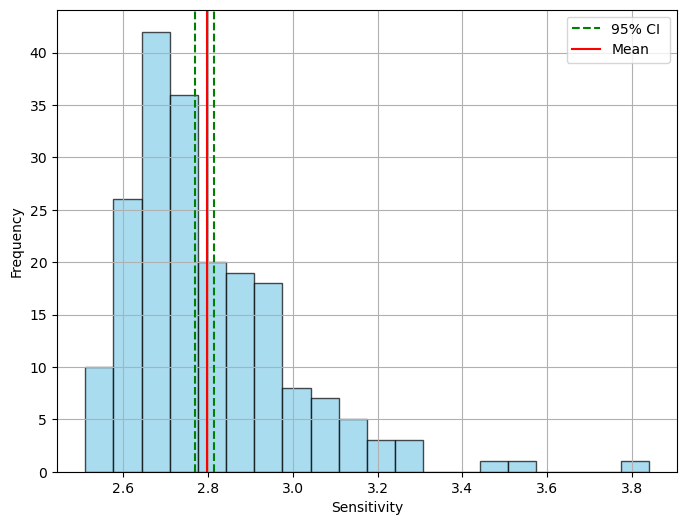

Mean Variability: 2.79815
95% Confidence Interval for the Mean: [2.76923125 2.81401375]


In [27]:
sens_array = []

for i in range(200):
    sensitivity = model_Final(13)[1]
    sens_array.append(sensitivity)

def plot_sensitivity_histogram(sens_array):
    """
    Plot a histogram of the final model sensitivities to investigate variability in the model.

    Parameters:
    - sens_array (list): List containing sensitivity values of the final model.

    Returns:
    None
    """
    # Number of bootstrap samples
    num_bootstraps = 10

    # Bootstrap resampling
    bootstrap_means = []
    for _ in range(num_bootstraps):
        bootstrap_sample = np.random.choice(sens_array, size=len(sens_array), replace=True)
        bootstrap_means.append(np.mean(bootstrap_sample))

    # Calculate 95% confidence interval
    confidence_interval = np.percentile(bootstrap_means, [2.5, 97.5])

    # Calculate mean
    mean_variability = np.mean(sens_array)

    # Plot histogram with confidence interval and mean
    plt.figure(figsize=(8, 6))
    plt.hist(sens_array, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
    plt.axvline(x=confidence_interval[0], color='green', linestyle='dashed', linewidth=1.5)
    plt.axvline(x=confidence_interval[1], color='green', linestyle='dashed', linewidth=1.5, label='95% CI ')
    plt.axvline(x=mean_variability, color='red', linestyle='solid', linewidth=1.5, label='Mean')
    plt.xlabel('Sensitivity', fontname='Times New Roman')
    plt.ylabel('Frequency', fontname='Times New Roman')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print mean and confidence interval
    print("Mean Variability:", mean_variability)
    print("95% Confidence Interval for the Mean:", confidence_interval)

# Usage example:
plot_sensitivity_histogram(sens_array)



This cell outputs the histogram of variability in the tagging performances of the final model.

### Removing Parameters



In [ ]:
def plot_sensitivity_vs_variables(num_iterations=5):
    """
    Plot the average sensitivity with error bars against the number of variables.

    Parameters:
    - num_iterations (int): Number of iterations to compute sensitivity for each number of variables.

    Returns:
    None
    """
    sens_lst_avg = []
    sens_lst_std = []

    # Iterate over the number of variables
    for i in range(13, 0, -1):
        sens_values = []

        # Compute sensitivity multiple times and store the values
        for _ in range(num_iterations):
            sensitivity = model_Final(i)[1]  # Assuming model_Final returns a tuple with sensitivity at index 1
            sens_values.append(sensitivity)

        # Calculate the average sensitivity and standard deviation
        sens_avg = np.mean(sens_values)
        sens_std = np.std(sens_values)

        # Append to the lists
        sens_lst_avg.append(sens_avg)
        sens_lst_std.append(sens_std)

    # Plot the average sensitivity with error bars
    plt.errorbar(np.arange(13, 0, -1), sens_lst_avg, yerr=sens_lst_std, fmt='o', capsize=5)
    plt.xlabel('Number of Variables', fontname='Times New Roman')
    plt.ylabel('Average Sensitivity', fontname='Times New Roman')
    plt.grid(True)
    plt.show()

# Usage example:
plot_sensitivity_vs_variables(num_iterations=5)

Code performs the analysis of model performance after iteratively removing each variable.

### Do I have enough data? 



In [ ]:
def model_Final_training_size(num, df_train, df_val, df_test):
    """
    Create and compile the final neural network model.

    Parameters:
    - num: Number of variables/features to use in the model
    - df_train: DataFrame containing the training data
    - df_val: DataFrame containing the validation data
    - df_test: DataFrame containing the test data

    Returns:
    - model: Compiled Keras model
    - sens: Sensitivity achieved by the model
    """
    variables = ['mBB', 'dRBB', 'pTB1', 'pTB2', 'pTV', 'Mtop', 'mTW', 'MET', 'dYWH', 'dPhiVBB', 'MV1cB1_cont', 'MV1cB2_cont', 'nTrackJetsOR']


    selected_variables = np.random.choice(variables, size=num, replace=False)
    print("Selected Variables:", selected_variables)


    (x_train, y_train, w_train, 
    dset_val, dset_test) = scale_prepare_data(df_train, df_val, df_test, selected_variables, scaler='standard')


    model = Sequential()

    model.add(Dense(units=120, input_dim=num, activation='relu'))

    model.add(Dense(65, activation='relu'))

    model.add(Dense(49, activation='relu'))

    model.add(Dense(14, activation='relu'))

    model.add(Dense(units=1, activation='sigmoid'))

    optimizer = Nadam(learning_rate=0.005)
    model.compile(loss='BinaryFocalCrossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    history = model.fit(x_train, y_train, sample_weight=w_train, epochs=10, batch_size=120, verbose=0)

    df_test['decision_value'] = model.predict(dset_test[0])
    sens = round(sensitivity_NN(df_test)[0], 2)

    return model, sens

def plot_sensitivity_vs_training_size(df_train, df_val, df_test, num_runs):
    """
    Plot sensitivity achieved by the final neural network model for different subset sizes of the dataframe.

    Parameters:
    - df_train: DataFrame containing the training data
    - df_val: DataFrame containing the validation data
    - df_test: DataFrame containing the test data
    - num_runs: Number of times to run the training and sensitivity calculation
    """
    variables = ['mBB', 'dRBB', 'pTB1', 'pTB2', 'pTV', 'Mtop', 'mTW', 'MET', 'dYWH', 'dPhiVBB', 'MV1cB1_cont', 'MV1cB2_cont', 'nTrackJetsOR']
    subset_sizes = [2500, 5000, 7500, 10000, 12500, 15000, 17500, 20000, 22500, 25000, 27500, 30000, 32500, 35000, 37500, 40000, 42500, 45000, 47500, 50000, 52500, 55000, 57500, 60000, 62500, 65000, 67500, 70000, 72500, len(df_train)]
    
    sensitivities_all_runs = []

    for _ in range(num_runs):
        sensitivities = []

        for size in subset_sizes:
            # Sample a subset of the training data
            df_train_subset = df_train.sample(n=size, random_state=42)
            
            # Train the model
            model, sens = model_Final_training_size(len(variables), df_train_subset, df_val, df_test)
            sensitivities.append(sens)

        sensitivities_all_runs.append(sensitivities)

    # Calculate mean and standard deviation of sensitivities
    sensitivities_mean = np.mean(sensitivities_all_runs, axis=0)
    sensitivities_std = np.std(sensitivities_all_runs, axis=0)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.errorbar(subset_sizes, sensitivities_mean, yerr=sensitivities_std, fmt='o')
    plt.xlabel('Subset Size', fontname='Times New Roman', fontsize=14)
    plt.ylabel('Sensitivity',fontname='Times New Roman', fontsize=14)
    plt.grid(True)
    plt.show()


plot_sensitivity_vs_training_size(df_train, df_val, df_test, 5)


This cell performs the analysis of the amount of data used in training. 

### NN Sensitivity



110252


1644/1644 [==============================] - 1s 285us/step


1644/1644 [==============================] - 1s 344us/step


1644/1644 [==============================] - 1s 299us/step


1644/1644 [==============================] - 1s 300us/step


1644/1644 [==============================] - 1s 296us/step


1644/1644 [==============================] - 1s 302us/step


1644/1644 [==============================] - 1s 298us/step


1644/1644 [==============================] - 1s 290us/step


1644/1644 [==============================] - 1s 299us/step


1644/1644 [==============================] - 1s 295us/step


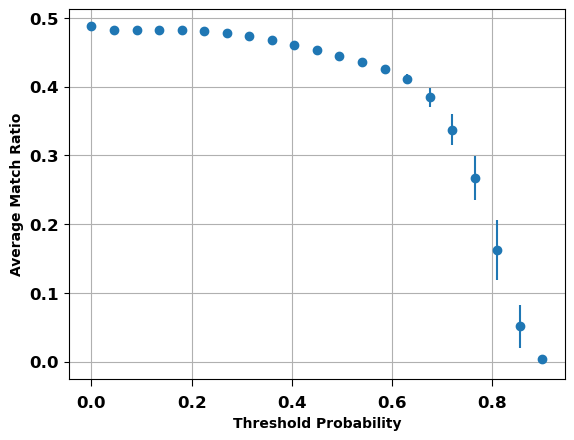

In [91]:


df = pd.read_csv('../data-v2/VHbb_data_2jet.csv')
print(len(df))

def model_Final_sensitivity(num):
    """
    Create and compile the final neural network model.

    Parameters:
    - num: Number of features
    - learning_rate: Learning rate for the optimizer

    Returns:
    - Compiled Keras model
    - Sensitivity achieved by the model
    """
    variables = ['mBB', 'dRBB', 'pTB1', 'pTB2', 'pTV', 'Mtop', 'mTW', 'MET', 'dYWH', 'dPhiVBB', 'MV1cB1_cont', 'MV1cB2_cont', 'nTrackJetsOR']

    (x_train, y_train, w_train, dset_val, dset_test) = scale_prepare_data(df_train, df_val, df_test, variables, scaler='standard')
    selected_variables = best_pca(x_train, variables, num)

    (x_train, y_train, w_train, dset_val, dset_test) = scale_prepare_data(df_train, df_val, df_test, selected_variables, scaler='standard')

    model = Sequential()
    model.add(Dense(units=120, input_dim=num, activation='relu'))
    model.add(Dense(65, activation='relu'))
    model.add(Dense(49, activation='relu'))
    model.add(Dense(14, activation='relu'))
    model.add(Dense(units=1, activation='sigmoid'))

    optimizer = Nadam(learning_rate=0.005)
    model.compile(loss='BinaryFocalCrossentropy', optimizer=optimizer, metrics=['accuracy'])

    history = model.fit(x_train, y_train, sample_weight=w_train, epochs=10, batch_size=128, verbose=0)
    predicted_outputs = model.predict(dset_test[0])

    return history, predicted_outputs


def plot_match_ratios(num_repetitions):
    """
    Plot the average match ratio between the neural network predictions and cut-based predictions over a range of threshold probabilities.

    Parameters:
    - num_repetitions (int): Number of repetitions for calculating match ratios (default is 10).

    Returns:
    None
    """
    index_list_cut = df.loc[(df['Mtop'] > 209000) & (df['pTB2'] > 49000) & (df['dRBB'] < 1.39) & (df['pTV'] > 140000)].index.tolist()

    thresholds = np.linspace(0, 0.9, 21)  # Include threshold zero
    match_ratios_all_reps = []

    for _ in range(num_repetitions):
        match_ratios = []
        predicted_outputs = model_Final_sensitivity(13)[1]
        zipped_outputs = list(zip(range(1, len(predicted_outputs) + 1), predicted_outputs))

        for threshold in thresholds:
            zipped_outputs_filtered = [(index, prob) for index, prob in zipped_outputs if prob > threshold]
            index_list_NN = [index for index, _ in zipped_outputs_filtered]
            num_matches = len(set(index_list_NN).intersection(index_list_cut)) / (len(index_list_cut) + 0.000001)
            match_ratios.append(num_matches)
        
        match_ratios_all_reps.append(match_ratios)

    match_ratios_all_reps = np.array(match_ratios_all_reps)
    mean_match_ratios = np.mean(match_ratios_all_reps, axis=0)
    std_dev_match_ratios = np.std(match_ratios_all_reps, axis=0)

    plt.errorbar(thresholds, mean_match_ratios, yerr=std_dev_match_ratios, fmt='o')
    plt.xlabel('Threshold Probability', fontname='Times New Roman')
    plt.ylabel('Average Match Ratio', fontname='Times New Roman')
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.tick_params(axis='both', which='minor', labelsize=10)
    plt.grid(True)
    plt.show()

# Assuming df_train, df_val, and df_test are defined somewhere
plot_match_ratios(10)

Investigation of the overlap between the cut-based analysis and the ML analysis. They overlap with a maximum of 50%. This is surprisingly consistent and could be an area of future development the model were to be further investigated.